# Project: Decoding Molecules From Fingerprints.
## Group Members:
### Qi Chen, e-mail: gusqichr@student.gu.se
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
***

In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
from IPython.display import display
from joblib import Parallel, delayed
from rdkit import Chem
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
# Path to the data
zip_file_path = '../data/final_chembl.zip'

with zipfile.ZipFile(zip_file_path, 'r') as z:
    file_list = z.namelist()

    csv_filename = file_list[0]

    # Read the file as a pandas DataFrame
    with z.open(csv_filename) as f:
        df = pd.read_csv(f)

df.head()

ChEMBL ID                                             smiles  \
0  CHEMBL3897759  Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5ccc(F)c(F)c5)C...   
1  CHEMBL3935110  Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5cc(F)ccc5F)CC4...   
2  CHEMBL3347413    N#Cc1cc(Cl)cc(Oc2cc(CCc3cccnc3)[nH]c(=O)c2Cl)c1   
3  CHEMBL1739263  N=C(N)c1ccc(-c2sc(-c3ccc(C(=N)N)cc3)c3c2OCCO3)cc1   
4  CHEMBL3917493  O=C(C=Cc1cccs1)c1cccc(NC(=O)c2cc(-c3ccncc3)[nH...   

   MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0       13.506757       -0.836612          13.506757           0.011403   
1       13.986498       -0.441178          13.986498           0.012570   
2       12.093976       -0.437141          12.093976           0.061471   
3        7.537508        0.042215           7.537508           0.042215   
4       12.517530       -0.360849          12.517530           0.130332   

        qed    MolWt  HeavyAtomMolWt  ExactMolWt  ...  fr_tetrazole  \
0  0.294586  544.650         510.378  544.276216  ...             0   
1  0.294586  544.650         510.378  544.276216  ...             0   
2  0.699111  386.238         373.134  385.038482  ...             0   
3  0.410744  378.457         360.313  378.115047  ...             0   
4  0.363273  400.463         384.335  400.099397  ...             0   

   fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  \
0            0            0             0                 0        0   
1            0            0             0                 0        0   
2            0            0             0                 0        0   
3            0            0             1                 0        0   
4            0            0             1                 0        0   

   NumBridgeheadAtoms  LongestAliChain  LargestRing  MolLogLike  
0                   0                1            6  -12.275704  
1                   0                1            6  -12.228626  
2                   0                2            6  -11.894518  
3                   0                0            6  -12.655379  
4                   0                0            6  -11.901545  

[5 rows x 214 columns]

In [3]:
# Sub Dataframe of ChEMBL ID and SMILES
smiles_df = df[['ChEMBL ID', 'smiles']].copy()

PandasTools.AddMoleculeColumnToFrame(smiles_df, 'smiles', 'Molecule')

display(smiles_df.head())

ChEMBL ID                                             smiles  \
0  CHEMBL3897759  Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5ccc(F)c(F)c5)C...   
1  CHEMBL3935110  Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5cc(F)ccc5F)CC4...   
2  CHEMBL3347413    N#Cc1cc(Cl)cc(Oc2cc(CCc3cccnc3)[nH]c(=O)c2Cl)c1   
3  CHEMBL1739263  N=C(N)c1ccc(-c2sc(-c3ccc(C(=N)N)cc3)c3c2OCCO3)cc1   
4  CHEMBL3917493  O=C(C=Cc1cccs1)c1cccc(NC(=O)c2cc(-c3ccncc3)[nH...   

                                            Molecule  
0  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...  
1  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...  
2  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...  
3  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...  
4  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...

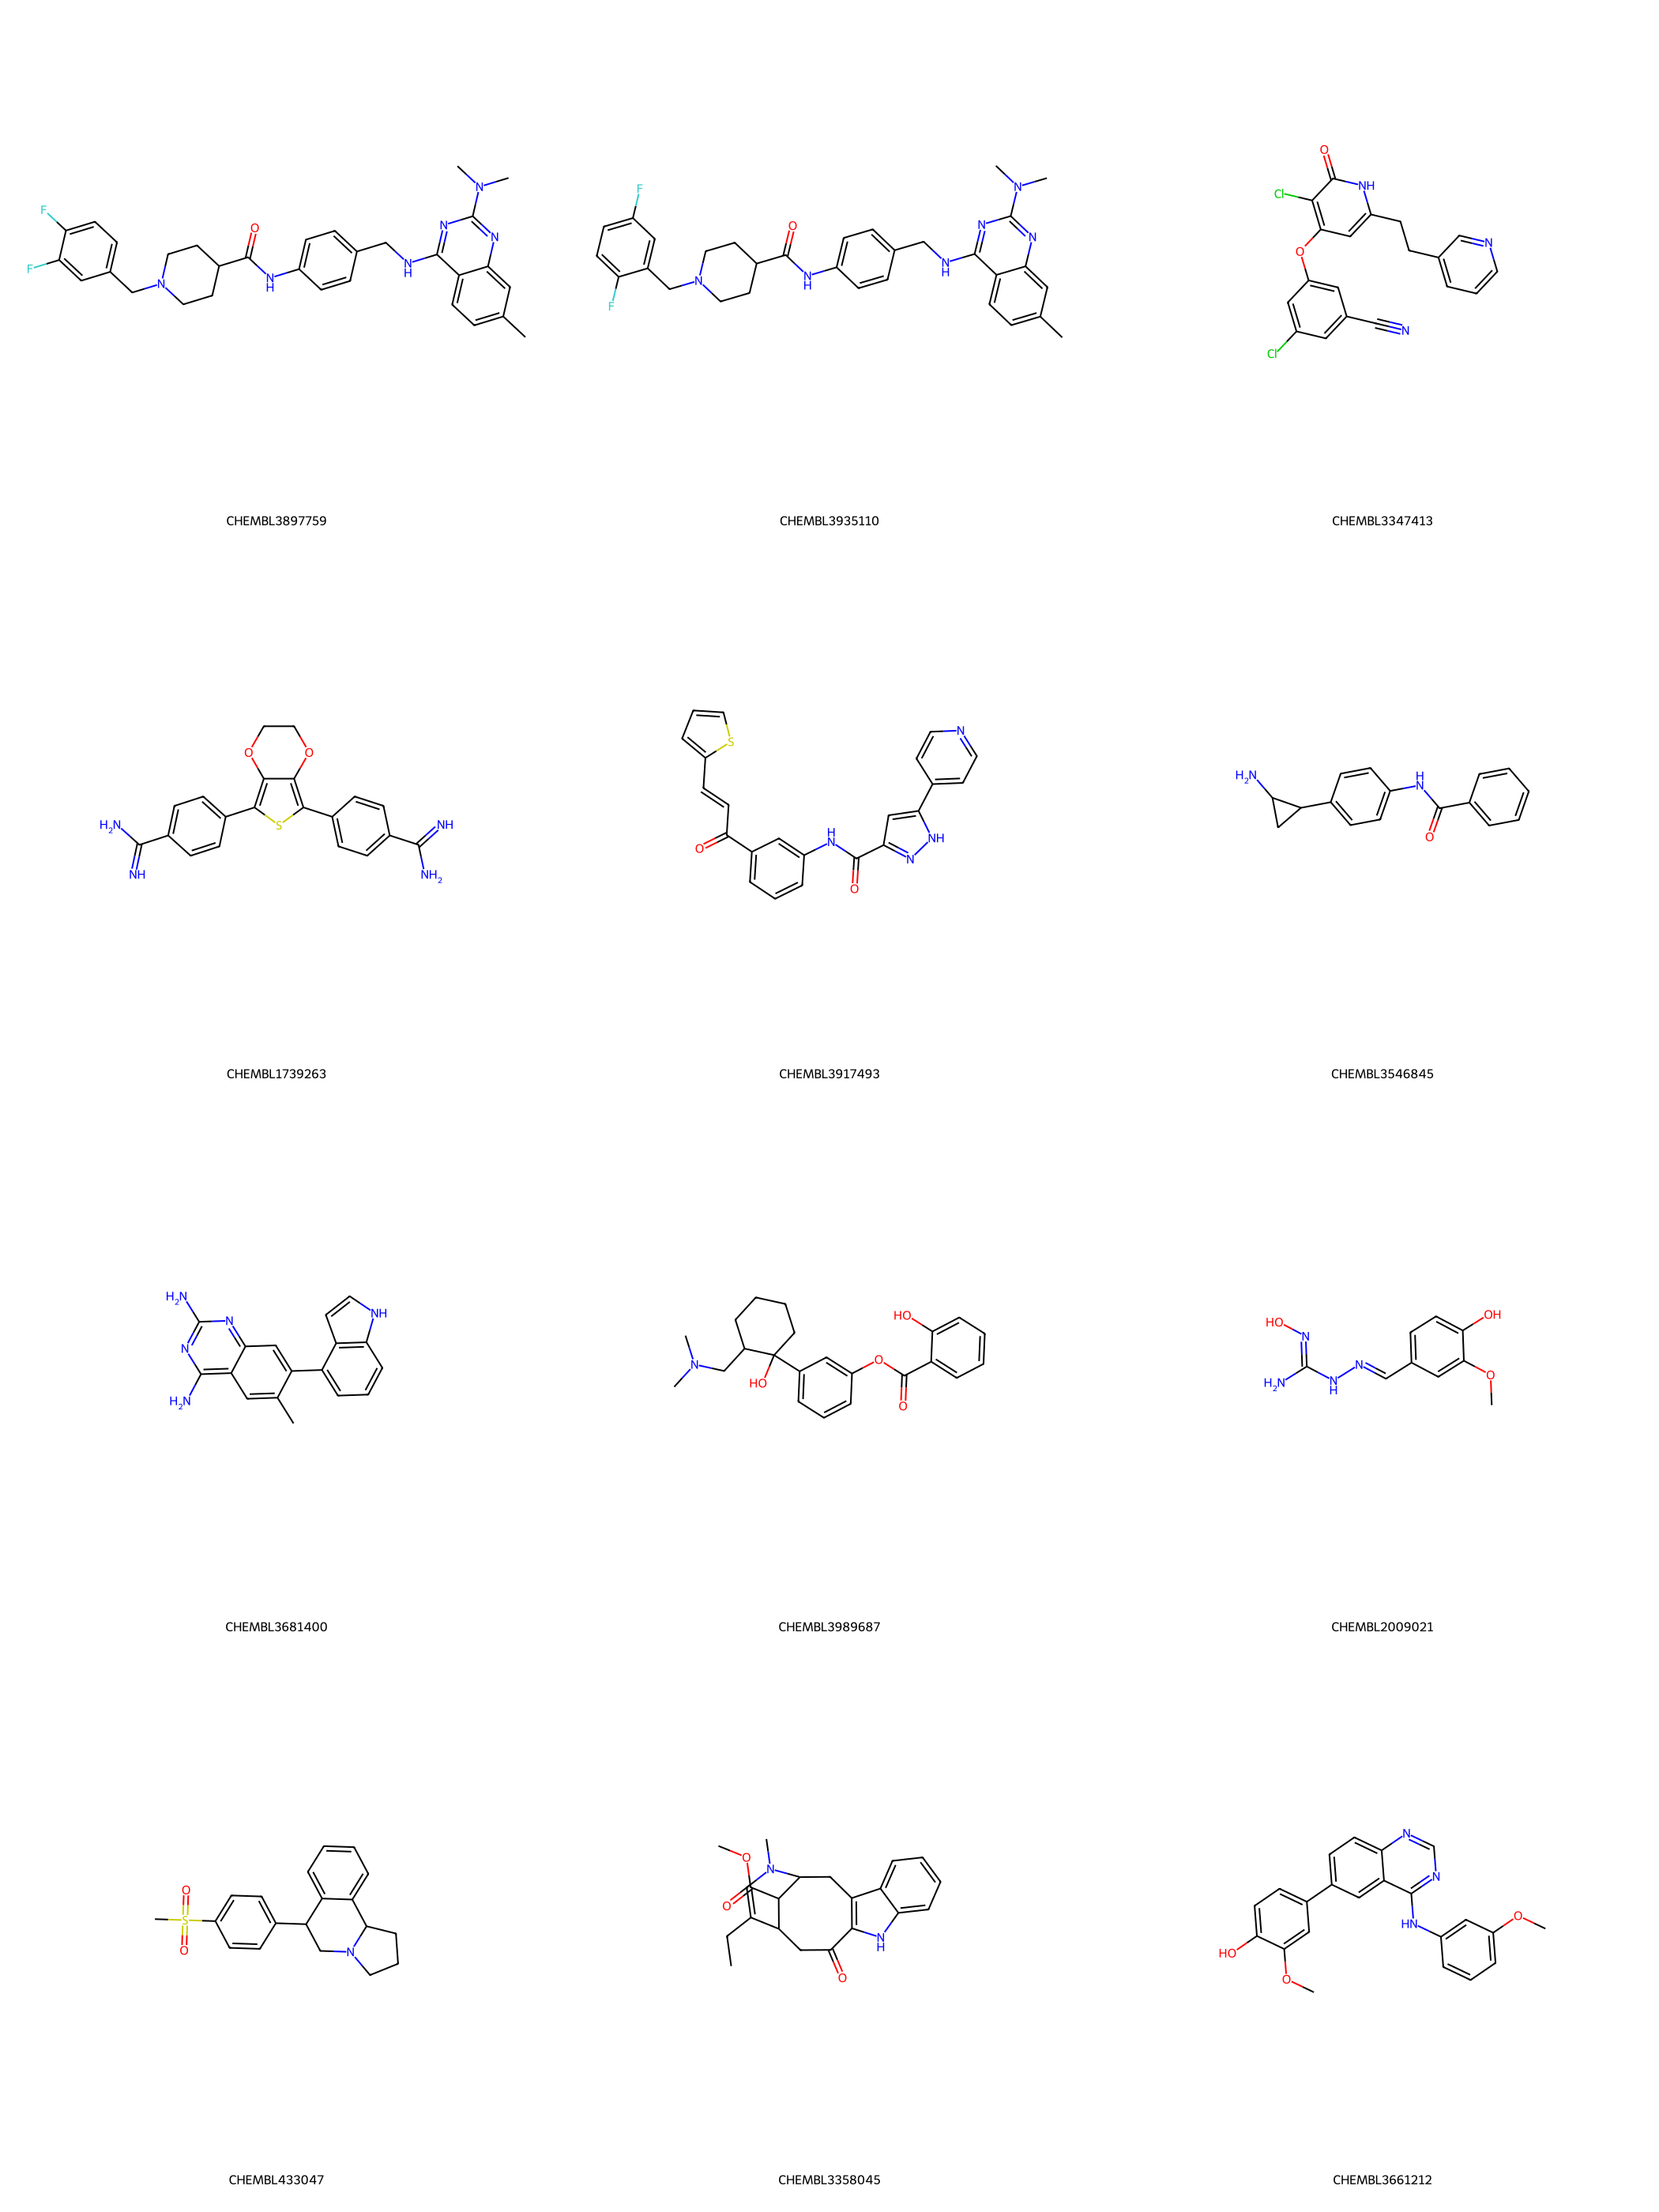

In [4]:
# Prepare molecules and ChEMBL IDs for display (limit to first 10)
mols = smiles_df['Molecule'].tolist()[:12]
ids = smiles_df['ChEMBL ID'].tolist()[:12]

# Display the grid of molecules
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(700, 700), legends=ids)
display(img)

## Convert SMILES to Fingerprints

In [5]:
# Function to generate ECFP4 fingerprint and sparse representation
def generate_fingerprint(mol):
    if mol is not None:
        # Create the Morgan fingerprint generator
        morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
        fp = morgan_generator.GetFingerprint(mol)

        # Convert to a bit vector
        bit_vector = np.array(list(fp.ToBitString())).astype(int)

        # Get sparse representation: indices of '1' bits
        sparse_representation = list(np.where(bit_vector == 1)[0])

        # Convert sparse representation to a string of space-separated indices
        sparse_representation_str = ' '.join(map(str, sparse_representation))
        
        return bit_vector, sparse_representation_str
    return None, None

# Parallel processing for fingerprint generation
num_cores = -1
results = Parallel(n_jobs=num_cores)(delayed(generate_fingerprint)(mol) for mol in smiles_df['Molecule'])

# Unzip the results into two lists
bit_vectors, sparse_fingerprints = zip(*results)

# Assign the new columns to the DataFrame
smiles_df['FingerprintBits'] = list(bit_vectors)
smiles_df['SparseFingerprintBits'] = list(sparse_fingerprints)

# Display the DataFrame with FingerprintBits and SparseFingerprintBits
smiles_df.head()

ChEMBL ID                                             smiles  \
0  CHEMBL3897759  Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5ccc(F)c(F)c5)C...   
1  CHEMBL3935110  Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5cc(F)ccc5F)CC4...   
2  CHEMBL3347413    N#Cc1cc(Cl)cc(Oc2cc(CCc3cccnc3)[nH]c(=O)c2Cl)c1   
3  CHEMBL1739263  N=C(N)c1ccc(-c2sc(-c3ccc(C(=N)N)cc3)c3c2OCCO3)cc1   
4  CHEMBL3917493  O=C(C=Cc1cccs1)c1cccc(NC(=O)c2cc(-c3ccncc3)[nH...   

                                            Molecule  \
0  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...   
1  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...   
2  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...   
3  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...   
4  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...   

                                     FingerprintBits  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...   

                               SparseFingerprintBits  
0  80 191 216 235 255 263 310 363 378 380 467 531...  
1  80 191 216 235 249 255 263 310 363 378 380 467...  
2  24 80 102 216 240 301 305 314 322 378 437 499 ...  
3  82 140 162 338 441 621 623 656 675 807 854 876...  
4  12 14 31 63 74 119 184 191 241 378 383 391 486...

In [6]:
# Drop the 'Molecule' column and save the rest of the DataFrame
smiles_df_filtered = smiles_df.drop(columns=['Molecule'])

# Write the DataFrame in smaller chunks, saving separate files
chunk_size = 10000  # Adjust based on your system's memory
num_chunks = len(smiles_df_filtered) // chunk_size + 1

for i in range(num_chunks):
    start_row = i * chunk_size
    end_row = (i + 1) * chunk_size
    chunk_df = smiles_df_filtered.iloc[start_row:end_row]
    
    # Save each chunk to a separate Parquet file
    file_name = f'molecule_fingerprints_part_{i}.parquet'
    chunk_df.to_parquet(file_name, compression='snappy')

    print(f"Saved chunk {i+1}/{num_chunks} to {file_name}")

Saved chunk 1/139 to molecule_fingerprints_part_0.parquet
Saved chunk 2/139 to molecule_fingerprints_part_1.parquet
Saved chunk 3/139 to molecule_fingerprints_part_2.parquet
Saved chunk 4/139 to molecule_fingerprints_part_3.parquet
Saved chunk 5/139 to molecule_fingerprints_part_4.parquet
Saved chunk 6/139 to molecule_fingerprints_part_5.parquet
Saved chunk 7/139 to molecule_fingerprints_part_6.parquet
Saved chunk 8/139 to molecule_fingerprints_part_7.parquet
Saved chunk 9/139 to molecule_fingerprints_part_8.parquet
Saved chunk 10/139 to molecule_fingerprints_part_9.parquet
Saved chunk 11/139 to molecule_fingerprints_part_10.parquet
Saved chunk 12/139 to molecule_fingerprints_part_11.parquet
Saved chunk 13/139 to molecule_fingerprints_part_12.parquet
Saved chunk 14/139 to molecule_fingerprints_part_13.parquet
Saved chunk 15/139 to molecule_fingerprints_part_14.parquet
Saved chunk 16/139 to molecule_fingerprints_part_15.parquet
Saved chunk 17/139 to molecule_fingerprints_part_16.parquet

In [11]:
# Set the output file path
output_file = 'molecule_fingerprints_combined.parquet'

# Remove the output file if it already exists
if os.path.exists(output_file):
    os.remove(output_file)

# List of chunk files
file_names = [f'molecule_fingerprints_part_{i}.parquet' for i in range(num_chunks)]

# Initialize an empty DataFrame to accumulate chunks
combined_df = pd.DataFrame()

# Iterate over each chunk file and append it to the combined DataFrame
for i, file_name in enumerate(file_names):
    chunk_df = pd.read_parquet(file_name)
    
    # Concatenate the chunk with the combined DataFrame
    combined_df = pd.concat([combined_df, chunk_df], ignore_index=True)
    
    # Periodically save the combined DataFrame to the output file to free memory
    if (i + 1) % 5 == 0 or i == len(file_names) - 1:
        # Save the combined DataFrame to a Parquet file
        combined_df.to_parquet(output_file, compression='snappy', index=False)
        print(f"Processed and saved up to chunk {i+1}/{len(file_names)}")
        
        # Clear the combined DataFrame from memory after saving
        combined_df = pd.DataFrame()

Processed and saved up to chunk 5/139
Processed and saved up to chunk 10/139
Processed and saved up to chunk 15/139
Processed and saved up to chunk 20/139
Processed and saved up to chunk 25/139
Processed and saved up to chunk 30/139
Processed and saved up to chunk 35/139
Processed and saved up to chunk 40/139
Processed and saved up to chunk 45/139
Processed and saved up to chunk 50/139
Processed and saved up to chunk 55/139
Processed and saved up to chunk 60/139
Processed and saved up to chunk 65/139
Processed and saved up to chunk 70/139
Processed and saved up to chunk 75/139
Processed and saved up to chunk 80/139
Processed and saved up to chunk 85/139
Processed and saved up to chunk 90/139
Processed and saved up to chunk 95/139
Processed and saved up to chunk 100/139
Processed and saved up to chunk 105/139
Processed and saved up to chunk 110/139
Processed and saved up to chunk 115/139
Processed and saved up to chunk 120/139
Processed and saved up to chunk 125/139
Processed and saved 

In [2]:
# Load the combined Parquet file into a pandas DataFrame
combined_df = pd.read_parquet('./data/molecule_fingerprints_combined.parquet')

# Display the first few rows
combined_df.head()

ChEMBL ID                                             smiles  \
0  CHEMBL3274216  Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)C(NC(=O)C(N)c3ccc...   
1  CHEMBL3609212  O=c1c2ccccc2[nH]c2c(-c3c(-c4ccccc4O)[nH]c4cccc...   
2  CHEMBL2134582  CC1(C(=O)NS(=O)(=O)c2ccc(Cl)s2)CCN1C(=O)Cc1ccc...   
3  CHEMBL3958199      CCNc1ccc(Nc2ccc(OC(C)C)cc2)c(Cc2ccc(Cl)cc2)c1   
4  CHEMBL3894235  CCC#CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4ccc(Oc5cc...   

                                     FingerprintBits  \
0  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                               SparseFingerprintBits  
0  1 5 80 89 116 186 232 233 251 257 314 329 341 ...  
1  13 45 119 155 211 239 314 352 504 548 650 678 ...  
2  80 162 171 307 310 325 350 353 389 502 503 521...  
3  1 62 80 191 216 283 294 310 322 491 555 561 66...  
4  80 140 151 191 193 229 294 305 309 322 323 378...

In [3]:
def convert_spaced_smiles(spaced_smiles):
    compact_smiles = spaced_smiles.replace(" ", "")
    mol = Chem.MolFromSmiles(compact_smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol)
    else:
        return "Invalid SMILES string"

In [4]:
def run_molforge(fp_input):
    # Get the full path to the Python interpreter you use in the terminal
    python_executable = "/home/student/conda/envs/MolForge_env/bin/python"
    
    # Command to run MolForge using the full path to Python
    command = f"{python_executable} predict.py --fp='ECFP4' --model_type='smiles' --input='{fp_input}'"
    
    # Run the command and capture output, ensuring environment variables are inherited
    result = subprocess.run(command, shell=True, capture_output=True, text=True, env=os.environ.copy())
    
    # Process the result
    spaced_smiles = None
    device_used = None
    output_lines = result.stdout.splitlines()
    
    for line in output_lines:
        if "Result:" in line:
            spaced_smiles = line.split("Result:")[1].strip()
        if "rank :" in line:
            device_used = line.split("rank :")[1].strip()
            
    # Now convert the spaced SMILES to compact SMILES
    if spaced_smiles:
        compact_smiles = convert_spaced_smiles(spaced_smiles)
    else:
        compact_smiles = "No Result"

    return compact_smiles, device_used

In [5]:
def process_row(row):
    fp_input = row['SparseFingerprintBits']
    
    # Run MolForge and get the converted SMILES and device information
    compact_smiles, device_used = run_molforge(fp_input)
    
    return compact_smiles, device_used

In [6]:
def process_dataframe_in_parallel(df):
    with ThreadPoolExecutor(max_workers=15) as executor:  # Adjust max_workers based on hardware
        futures = {executor.submit(process_row, row): idx for idx, row in df.iterrows()}
        
        for future in as_completed(futures):
            idx = futures[future]
            try:
                result, device_used = future.result()
                df.at[idx, 'Converted_SMILES'] = result
                print(f"Processed molecule {idx + 1}/{len(df)} | Result: {result} | Device: {device_used}")
            except Exception as e:
                print(f"Error processing molecule {idx + 1}: {e}")
                df.at[idx, 'Converted_SMILES'] = 'Error'
    
    return df

In [7]:
combined_df['Converted_SMILES'] = ""
processed_df = process_dataframe_in_parallel(combined_df)
processed_df.to_csv("processed_data.csv", index=False)

Processed molecule 6/32680 | Result: O=C(Nc1ccc(C2CCNC2)cc1)Oc1ccccc1 | Device: cuda
Processed molecule 2/32680 | Result: O=c1c2ccccc2[nH]c2c(-c3ccccc3O)c3ccccc3n12 | Device: cuda
Processed molecule 4/32680 | Result: CCNc1ccc(Nc2ccc(OC(C)C)cc2)c(Cc2ccc(Cl)cc2)c1 | Device: cuda
Processed molecule 14/32680 | Result: NC(=O)c1nn(CC(=O)N2[C@@H]3C[C@@H]3C[C@H]2C(=O)Nc2cccc(Br)c2F)c2ccccc12 | Device: cuda
Processed molecule 15/32680 | Result: O=C(O)CC1c2ccccc2-c2ccc(F)cc21 | Device: cuda
Processed molecule 13/32680 | Result: COc1ccc2c(c1)C(=O)N(C[C@@]1(C#Cc3ccc(-c4ncc(C)[nH]c4=O)nc3)NC(=O)NC1=O)C2 | Device: cuda
Processed molecule 1/32680 | Result: Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)C(NC(=O)C(N)c3ccccc3)[C@@H]2SC1 | Device: cuda
Processed molecule 8/32680 | Result: CCCN(CCC)C(=O)c1ccc(-c2ccc3c(c2)OCO3)s1 | Device: cuda
Processed molecule 10/32680 | Result: CN(C)c1ccc(Nc2nccc(-c3ccc(Oc4ccccc4N)cc3)n2)cc1 | Device: cuda
Processed molecule 12/32680 | Result: CCN1CCN(c2cccc(-c3ccc(C#C[C@]4(CN5Cc6ccc(OC

[23:40:22] SMILES Parse Error: unclosed ring for input: 'CC1=CC2=C(C=N1)N=C(C3=NN=C(N2CC4=CC=CC=N4)C)NC(C)C(C)C'


Processed molecule 74/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 73/32680 | Result: Cc1nc(-c2ccccc2)c(C(=O)N2CCN(Cc3ccccc3)CC2)o1 | Device: cuda
Processed molecule 75/32680 | Result: CCOP(=O)(CCNC(=O)C1Cc2cc3c(cc2C(=O)C(C)S1)OCO3)OCC | Device: cuda
Processed molecule 76/32680 | Result: CCOP(=O)(OCC)C(O)C1=C(N(C)C)C(=O)N(c2cccc(Cl)c2)C1=O | Device: cuda
Processed molecule 77/32680 | Result: Cc1nn(Cc2ccc(-c3nc4c(C)cccc4[nH]3)cc2)c(C)c1CC(=O)O | Device: cuda
Processed molecule 78/32680 | Result: C/C(=N\N=c1/scc(O)n1Cc1ccccc1)C1CCCCC1 | Device: cuda
Processed molecule 80/32680 | Result: CC(=NN=c1scc(O)n1Cc1ccccc1)c1cc2ccccc2oc1=O | Device: cuda
Processed molecule 79/32680 | Result: CCCSc1nc(Sc2ncccn2)nc2sc(Nc3ccccn3)nc12 | Device: cuda
Processed molecule 81/32680 | Result: Oc1cs/c(=N\N=C\c2cccs2)n1Cc1ccccc1 | Device: cuda
Processed molecule 84/32680 | Result: Cc1nonc1NC(=O)c1cccc2ccccc12 | Device: cuda
Processed molecule 82/32680 | Result: N#C/C=C/c1ccc(Nc2nccc

[23:45:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 20 21 22 23 24 25 26 27 28 29


Processed molecule 393/32680 | Result: Invalid SMILES string | Device: cuda


[23:45:33] SMILES Parse Error: unclosed ring for input: 'CCC(C1=CC=C(C=C1)C2=C3C=CSC3=C4C(=C(C=CC4=C2C5=CC=C(C=C5)C(CC)NCC)O)C=CS4)NCC'


Processed molecule 395/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 396/32680 | Result: CCCC[C@@H]1N[C@H](CNC(=O)c2ccc3ccccc3c2)CCN(CC(c2ccccc2)c2ccccc2)C1=O | Device: cuda
Processed molecule 397/32680 | Result: COc1cccc(N2C(=O)c3cccnc3C2O)c1 | Device: cuda
Processed molecule 399/32680 | Result: COc1cc(/C=C/C(=O)c2c(Cl)cccc2Cl)ccc1O | Device: cuda
Processed molecule 398/32680 | Result: CCN1CCc2nc(Nc3cc(-c4cc(F)cc(N5CCn6c(cc7c6CC(C)(C)C7)C5=O)c4CO)cn(C)c3=O)ccc2C1 | Device: cuda
Processed molecule 400/32680 | Result: O=C(NC1CCCCC1)N[C@H]1C=C[C@@H](CC(=O)N2CCOCC2)O[C@H]1CO | Device: cuda
Processed molecule 401/32680 | Result: CN1CCC(c2ccc(Nc3cc(-c4cc(F)cc(N5CCc6c(sc7c6CC(C)(C)C7)C5=O)c4CO)cn(C)c3=O)nc2)CC1 | Device: cuda
Processed molecule 403/32680 | Result: CC(C)c1nn(-c2ccc(C(N)=O)c(N[C@H]3CC[C@@H](O)CC3)c2)c2nccc(-n3cnc(-c4ccccc4)c3)c12 | Device: cuda
Processed molecule 402/32680 | Result: Cc1ncsc1CNc1nc(-n2ncc3ncccc32)nc(N)c1Br | Device: cuda
Processed mole

[23:52:26] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 21


Processed molecule 823/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 824/32680 | Result: CCc1c(C(=O)NCCc2ccccc2Cl)[nH]c2ccc(Cl)cc12 | Device: cuda
Processed molecule 826/32680 | Result: CCCOc1ccc(CC2COC(=O)N2c2ccc3[nH]cnc3c2)cc1 | Device: cuda
Processed molecule 825/32680 | Result: C=CC(=O)Nc1cccc(-n2cnc3cnc(Nc4ccc(N5CCN(S(C)(=O)=O)[C@H](C)C5)cc4)nc32)c1 | Device: cuda
Processed molecule 827/32680 | Result: CNc1nc(C2CCCN2C(C)=O)nc2c1CN(CCO)CC2 | Device: cuda
Processed molecule 828/32680 | Result: Nc1nc(Cl)nc2c1ncn2[C@H]1C[C@H](O)[C@@H](COP(=O)(O)CP(=O)(O)O)O1 | Device: cuda
Processed molecule 830/32680 | Result: CCOc1cc(C(=O)n2cccn2)cc(OCC)c1OCC | Device: cuda
Processed molecule 829/32680 | Result: O=C(NC1C(c2ccccc2)C1c1ccccc1)N1CCCC(NS(=O)(=O)c2ccc(F)cc2)C1 | Device: cuda
Processed molecule 832/32680 | Result: OC[C@H]1O[C@@H](c2ccc(Cl)c(Cn3nc4ccccn4c3=S)c2)[C@H](O)[C@@H](O)[C@@H]1O | Device: cuda
Processed molecule 831/32680 | Result: COc1ccc2[nH]cc(C(=O)CCN3

[23:53:53] Can't kekulize mol.  Unkekulized atoms: 10 11 13 14 16


Processed molecule 912/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 913/32680 | Result: CS(=O)(=O)N1CCN(C(=O)c2cnn3c2OCCC3)CC1 | Device: cuda
Processed molecule 914/32680 | Result: CCc1cc(-c2nc3ccc(N4CCC[C@@H](C(=O)N5CCCC5)C4)nc3[nH]2)no1 | Device: cuda
Processed molecule 915/32680 | Result: CC1(C)C(=O)N(c2ccccc2)c2nc(Nc3ccccc3)ncc21 | Device: cuda
Processed molecule 916/32680 | Result: COc1ncc(N2CCc3ncnc(N[C@H]4CCN(C(=O)C5CCOCC5)C4)c3C2)cc1C#N | Device: cuda
Processed molecule 917/32680 | Result: CC1(C)C(=O)N(C2CCc3c(NS(C)(=O)=O)cccc32)c2nc(Nc3ccccc3)ncc21 | Device: cuda
Processed molecule 918/32680 | Result: Cc1ccc(S(=O)(=O)Nc2ccccc2C(=O)N2Cc3ccccc3[C@H](OCc3ccccc3)[C@H]2CO)cc1 | Device: cuda
Processed molecule 919/32680 | Result: COc1[nH]c(CC(C)C)cc(=O)c1-c1ccccc1 | Device: cuda
Processed molecule 921/32680 | Result: CC(C)CCNC(=O)CCNC(=O)N1Cc2ccccc2C1 | Device: cuda
Processed molecule 920/32680 | Result: Cc1[nH]nc2c1C(c1ccc(Br)cc1)c1c(n[nH]c1C)O2 | Device:

[23:54:18] SMILES Parse Error: unclosed ring for input: 'CC1([C@@H]2CC[C@@H](C2)[C@]1(C)[C@]34CNP(=S)(O3)OC)C'


Processed molecule 940/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 937/32680 | Result: CN1CCN(c2ccc3nc(-c4ccc(=O)n(C)c4)n(Cc4ccccc4)c3n2)CC1 | Device: cuda
Processed molecule 939/32680 | Result: NC(=O)CCNc1cc(C(N)=O)nc(-c2ccc(Oc3ccc(F)cc3)cc2)n1 | Device: cuda
Processed molecule 941/32680 | Result: CN(c1ccc(Cl)cc1)c1ccc(C(=O)c2ccc(C(=O)O)c(C(=O)Cc3ccccc3)c2)nc1 | Device: cuda
Processed molecule 943/32680 | Result: O=C(Nc1cc(Cl)ccc1O)c1cc(C(F)(F)F)cc(C(F)(F)F)c1 | Device: cuda
Processed molecule 944/32680 | Result: CC1CCCC(NC(=O)c2cccnc2Oc2ccc(Nc3ccccn3)cc2)C1 | Device: cuda
Processed molecule 942/32680 | Result: CN1CCN(c2cc(C(N)=O)nc(-c3ccc(Oc4ccc(C(F)(F)F)cc4)cc3)n2)C(C(N)=O)C1 | Device: cuda


[23:54:26] SMILES Parse Error: unclosed ring for input: 'C12C3C4C5C1C1C(C4C(C2C5)(O)O)C3CC14'


Processed molecule 946/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 945/32680 | Result: CCCCN1C(=O)C(CC(=O)NCCc2ccccn2)CC(C(=O)N2CCOCC2)=C1C | Device: cuda
Processed molecule 948/32680 | Result: CC(C)(C)OCCN(c1sc2ccccc2c1Br)S(=O)(=O)c1ccccc1 | Device: cuda
Processed molecule 947/32680 | Result: CN(C)C[C@@H](NC(=O)N1Cc2c(n[nH]c2Nc2nc(C#N)nc3ccccc23)C1(C)C)c1ccccc1 | Device: cuda
Processed molecule 949/32680 | Result: Cc1nc2ccc(C(=O)NCCCN3CCCC3=O)cn2c1N(C)C(=O)CCc1ccccc1 | Device: cuda
Processed molecule 950/32680 | Result: CN(C)C(=O)/C(C#N)=C/c1ccc(-c2cnc3[nH]cc(C(=O)C(C)(C)C)c3n2)cc1 | Device: cuda
Processed molecule 954/32680 | Result: CC(C)(C)c1ncc(C(=O)NCCNc2ncccn2)s1 | Device: cuda
Processed molecule 951/32680 | Result: O=C1C(Cl)=C(N2CCOCC2)C(=O)N1c1ccc(Cl)cc1 | Device: cuda
Processed molecule 953/32680 | Result: COc1ccc(OC)c(CCNC(=O)c2ccc(NC(=O)N3Cc4ccccc4C3)cc2)c1 | Device: cuda
Processed molecule 955/32680 | Result: COc1ccc(COC(=O)C2C(c3ccccc3)=NC(=O)N

[23:55:44] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6


Processed molecule 1025/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 1030/32680 | Result: COc1ccc(CNCCCNC(=O)Nc2ccccc2)cc1 | Device: cuda
Processed molecule 1031/32680 | Result: Cn1c(OC2CCCN(c3cccc(F)c3)C2)nc(-c2ccncn2)cc1=O | Device: cuda
Processed molecule 1029/32680 | Result: O=c1c(Cc2ccccc2)c[nH]c2c(-c3cc[nH]n3)cnn12 | Device: cuda
Processed molecule 1027/32680 | Result: COCCN(C)Cc1ccc(-n2nc(C(=O)N3CCOCC3)c3c2-c2ccccc2S(=O)(=O)C3)cc1 | Device: cuda
Processed molecule 1032/32680 | Result: CN(C)C(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(NCC(F)F)nc2C1 | Device: cuda
Processed molecule 1033/32680 | Result: CSc1ccc(/C=C(/C(=O)O)c2ccccc2)cc1 | Device: cuda
Processed molecule 1028/32680 | Result: O=C1C=CC(F)(F)C2=C1[C@@]1(S(=O)(=O)c3ccc(C(F)(F)F)cc3)CC[C@@H](NS(=O)(=O)C3CC3)C[C@H]1CO2 | Device: cuda
Processed molecule 1034/32680 | Result: CS(=O)(=O)c1ccc(/C=C(/C(=O)O)c2ccc(Br)cc2)cc1 | Device: cuda
Processed molecule 1036/32680 | Result: Nc1cc(N2CCCCC2)ccc1N1CCCCC1

[23:56:00] SMILES Parse Error: unclosed ring for input: 'Cc1cncc(n1)c1cc2c(cn1)cnn2c1cccc(n1)N1CCCC2(CCCN(C2)C1)C1'


Processed molecule 1043/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 1048/32680 | Result: CC(Cc1ccnc(NC(N)=O)c1)c1ccccc1 | Device: cuda
Processed molecule 1044/32680 | Result: Brc1c(Br)c(Br)c2[nH]c(N3C=NC4CCCCC43)nc2c1Br | Device: cuda
Processed molecule 1045/32680 | Result: CN1CCC(NC(=O)c2ccc(-c3c(-c4cccc(OC(F)(F)F)c4)cc4n3[C@@H](CCO)CNC4=O)cc2)CC1 | Device: cuda
Processed molecule 1047/32680 | Result: O=C(Nc1cccnc1)N1CC(Oc2ccc(-c3ccccc3)cc2)C1 | Device: cuda
Processed molecule 1046/32680 | Result: O=c1[nH]c2ccccc2nc1-c1ccccc1NCc1ccccn1 | Device: cuda
Processed molecule 1049/32680 | Result: COc1ccc(C(=O)Cc2sc(N)nc2O)cc1 | Device: cuda
Processed molecule 1050/32680 | Result: NCCCC1CNC(=O)c2c(-c3cccc(OC(F)(F)F)c3)cc(-c3ccsc3)n21 | Device: cuda
Processed molecule 1051/32680 | Result: O=C(c1ccc2cc(Oc3ccc(C(F)(F)F)cn3)ccc2n1)N1CC(F)(F)C1 | Device: cuda
Processed molecule 1053/32680 | Result: CC(C)Nc1nc(-c2ccc(NCCCN3CCN(C)CC3)c(S(C)(=O)=O)c2)cc2ncn(C)c(=O)c12 | De

[23:58:27] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 38 39 40


Processed molecule 1194/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 1195/32680 | Result: O=c1c2ccccc2oc2cc(OCC3CO3)cc(OCc3ccccc3)c12 | Device: cuda
Processed molecule 1196/32680 | Result: O=c1[nH]c(=S)[nH]c(O)c1N=Nc1ccc(-c2nc3ccccc3[nH]2)cc1 | Device: cuda
Processed molecule 1201/32680 | Result: O=C(c1cn(-c2ccccc2)nc1-c1cccnc1)N1CCN(c2ccncc2)CC1 | Device: cuda
Processed molecule 1198/32680 | Result: O=C(c1cn(-c2ccccc2)nc1-c1ccncc1)N1CCC(Cc2ccccc2)CC1 | Device: cuda
Processed molecule 1197/32680 | Result: CO[C@H]1[C@@H](C(=O)N[C@@H](C)c2cccc(Cl)c2F)N(C(=O)Cn2nc(C(N)=O)c3cccnc32)C[C@@H]1F | Device: cuda
Processed molecule 1200/32680 | Result: O=C(Nc1ccc([C@H]2CNCCO2)cc1)c1ccc(Cl)c(Cl)c1 | Device: cuda
Processed molecule 1199/32680 | Result: Cn1cc(-c2cc(C(N)=O)nc3cc(CN4CCOC(C)(C)C4)ccc23)cn1 | Device: cuda
Processed molecule 1204/32680 | Result: COc1cc(-c2cnn(C)c2CO)ccc1Nc1ncc2cc(C)nc(NCC(C)(C)OC)c2n1 | Device: cuda
Processed molecule 1202/32680 | Result: CC(=O

[00:00:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6


Processed molecule 1332/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 1334/32680 | Result: NC(=S)N1N=C(c2ccc(Br)cc2)CC1c1cccc2ccccc12 | Device: cuda
Processed molecule 1333/32680 | Result: Cc1nc(C2CC2c2nc3ccccc3n2C)cc(-n2c(C3CCN(C)CC3)nc3ccccc32)n1 | Device: cuda
Processed molecule 1337/32680 | Result: Cc1cc(=O)c(-c2nnc(Nc3ccccc3F)o2)nn1-c1c(F)cccc1Cl | Device: cuda
Processed molecule 1339/32680 | Result: COc1cccc(-c2c[nH]c(C(O)c3cc(C)cc(C)c3)n2)c1 | Device: cuda
Processed molecule 1336/32680 | Result: COc1cc2c(cc1OC)C(c1cc(OC)c(OC)c(OC)c1)N(CCO)CC2 | Device: cuda
Processed molecule 1335/32680 | Result: CNC(=O)NCC#Cc1cn2c(-c3ccc(C(=O)NC4CC4)cc3)cnc2c(NCC(C)C)n1 | Device: cuda
Processed molecule 1338/32680 | Result: CCCCNCC#Cc1ccc2c(c1)CCn1c-2cc(OCC2COc3ncccc3O2)nc1=O | Device: cuda
Processed molecule 1340/32680 | Result: COc1cc2c(cc1C)C(=C(C)C)CC(=O)C2(C)O | Device: cuda
Processed molecule 1341/32680 | Result: CC(C)Oc1ccc2c(NC(=O)C(C)O)nn(CC(F)(F)F)c2c1 | Devi

[00:01:10] SMILES Parse Error: unclosed ring for input: 'CCCOC(=O)[C@@]12[C@@H](CC[C@@H]1C(C)C)[C@@H]3[C@H]4[C@H](O4)[C@@]5(CC[C@H]([C@]3(C[C@H]2O5)C)O6)C'


Processed molecule 1365/32680 | Result: COc1cc2cncc(Cc3ccc4cccc(N)c4n3)c2cc1OC | Device: cuda
Processed molecule 1366/32680 | Result: O=C(CCCOc1ccccc1)Nc1cccnc1 | Device: cuda
Processed molecule 1367/32680 | Result: COCC(C)Oc1ccc2cc(NC(=O)C3CC3)ncc2c1 | Device: cuda
Processed molecule 1368/32680 | Result: CCOc1ccc(/C=C2\C(=O)N(c3cccc(C(=O)O)c3)N=C2C)cc1OC | Device: cuda
Processed molecule 1369/32680 | Result: COc1cc(Br)c(CNc2ccc(C(F)(F)F)c(OC3CCN(C)C3)c2)cc1OC | Device: cuda
Processed molecule 1371/32680 | Result: NC(=O)c1cc(N2CCOCC2)nc(NCc2ccccc2)n1 | Device: cuda
Processed molecule 1373/32680 | Result: O=C(Nc1ccc(Cl)c(Cl)c1)NC1CCCCC1 | Device: cuda
Processed molecule 1370/32680 | Result: COc1cc2cncc(Cc3ccc4nc(-c5ccc(CO)cc5)oc4c3)c2cc1OC | Device: cuda
Processed molecule 1372/32680 | Result: O=C(O)/C=C/c1ccc2c(ccn2-c2ccccc2)c1 | Device: cuda
Processed molecule 1374/32680 | Result: CC(C)(C)N(NC(=O)c1ccccc1)C(=O)C1CCCCC1 | Device: cuda
Processed molecule 1375/32680 | Result: COc1ccccc1C

[00:03:22] Can't kekulize mol.  Unkekulized atoms: 3 4 5 16 17 18 19 20 21 22 23


Processed molecule 1500/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 1502/32680 | Result: NCc1cnn(-c2ccccc2C(=O)NCc2ccncc2)c1 | Device: cuda
Processed molecule 1503/32680 | Result: Nc1ncnn2c(CN3CCNCC3)cc(-c3ccc(CO)cc3)c12 | Device: cuda
Processed molecule 1506/32680 | Result: Cc1cc(C)cc(NC(=O)c2ccc(C)c(C#Cc3cnc4ccnn4c3)c2)c1 | Device: cuda
Processed molecule 1507/32680 | Result: NC(=O)c1sc2nc(-c3cccc4ccccc34)ccc2c1N | Device: cuda
Processed molecule 1504/32680 | Result: CN1C(=O)N(c2cccc(C(F)(F)F)c2)C2=C(C(=O)CC2)C1c1ccc(C#N)cc1C(=O)NCCCO | Device: cuda
Processed molecule 1505/32680 | Result: COc1ccc(-c2nc(N=Nc3c(O)[nH]c4ccc(Cl)cc34)c3ccccc3n2)cc1OC | Device: cuda
Processed molecule 1508/32680 | Result: CC(C)OCCS(=O)(=O)N1CCN(Cc2cccn2C)CC1 | Device: cuda
Processed molecule 1509/32680 | Result: COc1ccc(C2CN(Cc3cccc(OC(F)(F)F)c3)c3ccccc3N2CC(O)C(F)(F)F)cc1 | Device: cuda
Processed molecule 1510/32680 | Result: Cc1ncc(C2(CNC(=O)c3cccc(Cl)c3Cl)CCOC2)cn1 | Device: 

[00:04:51] SMILES Parse Error: unclosed ring for input: 'COc1cc(CN(CC2CC2)C(CC(=O)O)c2ccc(Cl)cc2)ccc1OCCN1CC2CC2'


Processed molecule 1592/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 1596/32680 | Result: O=S(=O)(c1ccc2c(c1)OCO2)N1CCC(NCc2ccccc2)C1 | Device: cuda
Processed molecule 1595/32680 | Result: CCN1C(=O)c2nc(-c3ccc(-c4ccccc4)cc3)n(Cc3ccc(F)cc3)c2N2C[C@@H](C(C)C)N=C12 | Device: cuda
Processed molecule 1598/32680 | Result: Cn1nc(C2CN(S(=O)(=O)c3ccc4c(c3)OCO4)C2)c2cccnc21 | Device: cuda
Processed molecule 1597/32680 | Result: O=C(Nc1cc(Br)ccc1N1CCN(CCO)CC1)c1cc2ccccc2o/c1=N\c1ccccc1 | Device: cuda
Processed molecule 1599/32680 | Result: Cc1ccc(C(=O)c2ccccc2C(=O)Nc2cccc(Cc3n[nH]c(=O)c4c3CCCC4)c2)cc1 | Device: cuda
Processed molecule 1601/32680 | Result: Cc1nc2sccn2c1C(=O)NNC(=O)c1cccc2ccccc12 | Device: cuda
Processed molecule 1600/32680 | Result: CCN(CC)CCNC(=O)c1ccc2c(c1)NC(=O)/C(=C/c1ccccc1)S2 | Device: cuda
Processed molecule 1602/32680 | Result: CN(C)CCNC(=O)c1ccc2c(c1)NC(=O)/C(=C/c1cccc(Cl)c1)S2 | Device: cuda
Processed molecule 1603/32680 | Result: COc1ccccc1N1C

[00:06:11] SMILES Parse Error: ring closure 3 duplicates bond between atom 11 and atom 12 for input: 'C[C@@]12COC(=O)[C@@H]1CCC[C@@H]2[C@@]34[C@H]3CC[C@]5(C4)C[C@H]5C6=COC=C6'


Processed molecule 1674/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 1677/32680 | Result: C[C@]1(O)CCC[C@]2(C(=O)O)[C@@H]3CC[C@@H]4C[C@@]3(CC[C@H]21)C[C@]4(O)C(=O)O | Device: cuda
Processed molecule 1678/32680 | Result: CCc1on(C(=O)N(c2ccc(Cl)cc2)C(C)C)c(=O)c1SC(C)C | Device: cuda
Processed molecule 1675/32680 | Result: C/C(=N\N(C)C(N)=O)c1cnc2nnn(Cc3ccc4ncccc4c3)c2n1 | Device: cuda
Processed molecule 1676/32680 | Result: Cc1nc(-c2ccc3c(c2)CCC32CCC(Cc3nn[nH]n3)CC2)c(C)nc1C(N)=O | Device: cuda
Processed molecule 1679/32680 | Result: CC(C)COC(=O)c1cc2c(o1)C(=O)c1ccccc1C2=O | Device: cuda


[00:06:17] Can't kekulize mol.  Unkekulized atoms: 0 1 7 8 9 10 20 21 22


Processed molecule 1682/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 1683/32680 | Result: COc1ccc(C2=NN(C(C)C)C(=O)C2(C)C)cc1OCc1cccc2ccccc12 | Device: cuda
Processed molecule 1681/32680 | Result: CCCCCOc1ccc(C(=O)NC2CCCCC2)cn1 | Device: cuda
Processed molecule 1680/32680 | Result: CC(NCc1cc2cc(OCc3ccccc3)ccc2[nH]1)c1cccc2ccccc12 | Device: cuda
Processed molecule 1685/32680 | Result: N#Cc1ccc(-c2cnc3nnc(Cc4c[nH]c5ncccc45)n3n2)cc1 | Device: cuda
Processed molecule 1684/32680 | Result: CCN1CCc2c(sc(NC(=O)NCC3CCCO3)c2C(N)=O)C1 | Device: cuda
Processed molecule 1686/32680 | Result: Clc1ccc(C2=Nn3c(nnc3-c3cc(-c4ccccc4)[nH]n3)SC2)s1 | Device: cuda
Processed molecule 1687/32680 | Result: COC(=O)C1=CC(=NCCCCN)C=CC1c1c(C(=O)OC)n(C)c2ccccc12 | Device: cuda
Processed molecule 1688/32680 | Result: O=C(NS(=O)(=O)c1ccccc1Cl)N1CCC(N2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)CC1 | Device: cuda
Processed molecule 1689/32680 | Result: CC(C)(C)c1ccc(/C=N/NC(=O)c2ccc(O)c(O)c2)cc1 | Device: cuda

[00:09:52] SMILES Parse Error: unclosed ring for input: 'C[C@H]1C[C@@H]2CN3C4=CC(=O)[C@H]5[C@@H]6CC(=C[C@]4(CC[C@@]3([C@]1(C(=O)OC2)O)C)C)CC(=C[C@@]67CC(=O)OC7)C'


Processed molecule 1903/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 1905/32680 | Result: O=C(/C=C/c1ccccc1)Nc1cccc(CNC(=O)c2cccc(-c3ccc(Br)cc3)c2)c1 | Device: cuda
Processed molecule 1906/32680 | Result: CN1C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C(F)(F)F)cn3)ccc2F)CS1(=O)=O | Device: cuda
Processed molecule 1907/32680 | Result: O=C(N[C@H]1CC[C@H](CCN2CCC(c3noc4cc(F)ccc34)CC2)CC1)c1ccc(N2CCS(=O)(=O)CC2)cc1 | Device: cuda
Processed molecule 1909/32680 | Result: C=C(C)C(O)[C@H]1CC[C@H](N2CC(NC(=O)CNc3ncnc4ccc(C(F)(F)F)cc34)C2)CC1 | Device: cuda
Processed molecule 1908/32680 | Result: CC(C)c1nn(C)c(C(=O)NCc2ccc(Oc3ccc(C(F)(F)F)cc3)cc2)c1Cl | Device: cuda
Processed molecule 1911/32680 | Result: C[C@@H](O)CNC(=O)c1cnc(Oc2ccc3c(c2)CCC(c2ccccc2)O3)s1 | Device: cuda
Processed molecule 1910/32680 | Result: CN(C)CCOC(=O)C(CN)(Cc1ccc(C(C)(C)C)cc1)Cc1ccc(C(C)(C)C)cc1 | Device: cuda
Processed molecule 1912/32680 | Result: N#CCCN(Cc1ccco1)C(=O)CCCc1ccccc1 | Device: cuda
Processed 

[00:11:07] SMILES Parse Error: unclosed ring for input: 'C1C[C@@]23CC[C@@]4(C(=O)[C@H]2CN(C1)[C@@H]3CN5CCC[C@]6(C5)C7=CC=CC=C7N6)O'


Processed molecule 1985/32680 | Result: COC(=O)CCC(=O)N1CCC(NC(=O)c2cc(Br)c(Br)[nH]2)CC1 | Device: cuda
Processed molecule 1984/32680 | Result: O=c1ccc2ncc(F)cc2n1CCN1CCN(c2ccc3ccc(=O)n(-c4nc5cc(C(F)(F)F)ccc5[nH]4)c3c2)CC1 | Device: cuda
Processed molecule 1986/32680 | Result: O=Cc1cccc(-c2ccc3[nH]ccc3c2)c1 | Device: cuda
Processed molecule 1987/32680 | Result: Cn1cnc2cc(-c3ccc(C(C)(C)O)nc3)nc(NCc3cccc(S(C)(=O)=O)c3)c2c1=O | Device: cuda
Processed molecule 1988/32680 | Result: O=c1cc(CCc2ccc(C(F)(F)F)c(F)c2)[nH][nH]c1=O | Device: cuda
Processed molecule 1990/32680 | Result: Cc1noc(-c2ccc(N3CC(CN=C=S)OC3=O)cc2)n1 | Device: cuda
Processed molecule 1989/32680 | Result: CN(C)S(=O)(=O)N1CC(N2CCc3c(-c4cnc(N)nc4)nc(N4CCOCC4)nc32)C1 | Device: cuda
Processed molecule 1991/32680 | Result: C=CCOc1ccc2c(c1)[C@@]1(C)CCN(C(=O)C3COc4ccccc4O3)C(C2)[C@@H]1C | Device: cuda
Processed molecule 1993/32680 | Result: NC(=O)/C=C/c1cccc(-c2nc3cnc4[nH]ccc4c3n2C2CCCCC2)c1 | Device: cuda
Processed molecule 1992/3

[00:12:36] Can't kekulize mol.  Unkekulized atoms: 9 10 22


Processed molecule 2076/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 2075/32680 | Result: CCOC(=O)c1sc(Nc2ccc(-c3ccccc3)cc2F)nc1-c1ccccc1 | Device: cuda
Processed molecule 2077/32680 | Result: CCOc1ccc(OC2CCN(c3nc4c(cc3C)C(=O)N(C)[C@H]4CO)CC2)cn1 | Device: cuda
Processed molecule 2078/32680 | Result: Cc1[nH][nH]c(=O)c1C(c1ccc(Cl)cc1)c1c(O)[nH]c(=S)[nH]c1=O | Device: cuda
Processed molecule 2079/32680 | Result: CCCc1cc2c(=O)n(C(C)C3(O)CCN(C(=O)CC(C)c4ccccc4)CC3)cnc2s1 | Device: cuda
Processed molecule 2080/32680 | Result: CNC(=O)c1cc(NC(C)=O)ccc1NC(=O)c1nc(C2CC2)cnc1Nc1cncnc1 | Device: cuda
Processed molecule 2081/32680 | Result: Cc1c(-c2ccc(OC3C=CC=C3)cc2)n(Cc2ccc(OC(C)C)cc2)c2ccc(O)cc12 | Device: cuda
Processed molecule 2082/32680 | Result: Cn1cc(-c2[nH]nc3cc(F)c(-c4cc(N5CCN(CCCO)CC5)ncn4)cc23)cn1 | Device: cuda
Processed molecule 2083/32680 | Result: C[C@]12CC[C@H](O)CC1=CC[C@@H]1[C@@H]2CC[C@]2(C)C(C(=O)Cn3cncn3)=C(n3cncn3)C[C@@H]12 | Device: cuda
Processed

[00:15:08] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7


Processed molecule 2229/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 2231/32680 | Result: CN(CC1CCC/C(=C\c2ccccc2)C1=O)c1ccccc1 | Device: cuda
Processed molecule 2228/32680 | Result: COc1ccc(C2C(Cl)C(=O)N2NC(=O)c2c(NS(C)(=O)=O)sc3c2CCCC3)cc1 | Device: cuda
Processed molecule 2230/32680 | Result: Cc1cc(=O)[nH]c2cc(Nc3ccccc3C(=O)O)ccc12 | Device: cuda
Processed molecule 2234/32680 | Result: COCc1nsc(NC2CCCn3nc(C)nc32)n1 | Device: cuda
Processed molecule 2233/32680 | Result: CCN(C)C(=O)N[C@H](C)c1ccc(O[C@@H]2CCN(c3ccc(OC(C)C)cc3)C2)cc1 | Device: cuda


[00:15:11] SMILES Parse Error: unclosed ring for input: 'Oc1[nH]c(=O)[nH]c(/C=N/C2CC2)c1/C=c/1\nc(n2ncc(N3c4c(CC3)cccc4)nc12)N1C(=O)N(CCc2c1cccc2)c1c(CC1)cccc1'


Processed molecule 2232/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 2236/32680 | Result: Cc1c[nH]nc1C1CCCCN1C(=O)CNS(C)(=O)=O | Device: cuda
Processed molecule 2235/32680 | Result: CC(C)(C)c1ccc(C(=O)CC(=O)NN=Cc2ccc(O)cc2)cc1 | Device: cuda
Processed molecule 2238/32680 | Result: Cc1ccc(S(=O)(=O)n2c(CN3C(=O)C4(NC(=O)c5ccccc5N4)c4ccccc43)cc3cc(C(F)(F)F)ccc32)cc1 | Device: cuda
Processed molecule 2237/32680 | Result: Cn1c(OC2CCN(c3cccnc3)CC2)nc(-c2ccncn2)cc1=O | Device: cuda
Processed molecule 2239/32680 | Result: COC(=O)c1ccc(OC/C(C)=C/CC/C(C)=C/CC/C(C)=C/CO)cc1O | Device: cuda
Processed molecule 2241/32680 | Result: COc1ccc(S(=O)(=O)c2ccc(NC(=O)/C=C/c3cccnc3)cc2)cc1Cl | Device: cuda
Processed molecule 2240/32680 | Result: COc1ccc(CC(=O)O)cc1-c1cc(F)c(F)c2c1CN(C(=O)OCc1ccccc1)CC2 | Device: cuda
Processed molecule 2245/32680 | Result: O=Cc1ccccc1-c1ccc(Cl)cc1Cl | Device: cuda
Processed molecule 2244/32680 | Result: COc1ccc(C[C@@H]2CC(=O)O[C@@H]2CO)cc1OC | Devi

[00:17:38] SMILES Parse Error: unclosed ring for input: 'C1CCN2C[C@@H]3CCC[C@@H]4[C@H]3N(CC1)C=C(C4)C=O'


Processed molecule 2384/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 2385/32680 | Result: O=C(Nc1cccc(Cl)n1)c1nc(Br)cs1 | Device: cuda
Processed molecule 2389/32680 | Result: O=C([C@H]1C[C@@H]2CN(c3ncc(F)cn3)C[C@H]1O2)N1CCCC1 | Device: cuda
Processed molecule 2387/32680 | Result: O=C(Nc1cccnc1)c1cccc(Cl)n1 | Device: cuda
Processed molecule 2390/32680 | Result: CCOc1ccccc1NC(=O)C/C(N)=N/O | Device: cuda
Processed molecule 2388/32680 | Result: O=C(Nc1cccc(Cl)c1)c1cccc(F)n1 | Device: cuda
Processed molecule 2386/32680 | Result: Cc1cc(NC(=S)N(Cc2ccccc2C)CC2CCC(C(=O)O)CC2)ccc1Cl | Device: cuda
Processed molecule 2391/32680 | Result: CON(C)C(=O)c1ccc(-c2csc3c(N(C)C4CCN(C(=O)OC(C)C)CC4)ncnc23)cc1F | Device: cuda
Processed molecule 2392/32680 | Result: COc1c(C2CCC2)ccc(-c2cnc(N)cn2)c1F | Device: cuda
Processed molecule 2393/32680 | Result: Cc1cn(-c2cccc(C(F)(F)F)c2)/c(=N/C(=O)C(Cl)Cl)s1 | Device: cuda
Processed molecule 2395/32680 | Result: Nc1cnc(-c2ccc(C3CCC3)c(OCc

[00:21:28] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7


Processed molecule 2624/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 2626/32680 | Result: Nc1ccn2c(-c3ccnc(NC4CCCc5ccccc54)c3)c(-c3ccccc3)nc2n1 | Device: cuda
Processed molecule 2625/32680 | Result: Nc1ccc(-c2cc3c(cc2F)ncc2ncc(=O)n(C4CCN(C(=O)c5ccccc5)CC4)c23)cn1 | Device: cuda
Processed molecule 2628/32680 | Result: CC(C)(C)c1ccc(Cn2cc(/C=C/C(=O)O)c3ccccc32)cc1 | Device: cuda
Processed molecule 2627/32680 | Result: FC(F)(F)c1ccc(Nc2nc(N3CCC3)nc3c2CCN(c2ncccc2C(F)(F)F)CC3)cn1 | Device: cuda
Processed molecule 2629/32680 | Result: Cc1cc(-c2cnn(C)c2)cc(C(=O)N2CC=C(c3cc(C(C)C)[nH]n3)C2)n1 | Device: cuda
Processed molecule 2630/32680 | Result: FC(F)(F)c1ccc(Nc2nc(N3CCCCC3)nc3c2CCN(c2ncccc2C(F)(F)F)CC3)cn1 | Device: cuda
Processed molecule 2634/32680 | Result: N#C/C(=C\c1ccc(O)c(O)c1)C(=O)N1CCCCC1 | Device: cuda
Processed molecule 2632/32680 | Result: CCN(CC)C(=O)c1ccc(NC(=O)c2cccc(S(=O)(=O)N3CCN(C)CC3)c2)cc1 | Device: cuda
Processed molecule 2633/32680 | Result: 

[00:22:42] SMILES Parse Error: unclosed ring for input: 'CC1CCN(CC1)C2=C(C=C3C4=C2ON=C(C4=CN(C3=O)C5=C(C=C6C(=C5C7C(=NO7)C8=CC(=C(C(=C85)F)N9CCC(CC9)C)F)C(=O)O)F)C(=O)O)F'


Processed molecule 2699/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 2700/32680 | Result: CCC/C=C1/N=CC(C(Cc2cccs2)C(=O)O)=CO1 | Device: cuda
Processed molecule 2703/32680 | Result: CC(C)(C)CC(=O)OCC1(CO)C/C(=C\c2ccc(-c3ccc(C(F)(F)F)cc3)cc2)C(=O)O1 | Device: cuda
Processed molecule 2704/32680 | Result: CCCCCCC#CC1(C(F)(F)F)CC(c2ccc(C)cc2)=C(NC(=O)CNS(C)(=O)=O)C(=O)N1 | Device: cuda
Processed molecule 2706/32680 | Result: CC1(C)CC(=O)C2C(C1)Oc1ccc3ccccc3c1C2c1ccc(O)cc1 | Device: cuda
Processed molecule 2705/32680 | Result: O=C1OC(CO)(COC(=O)C(c2ccccc2)c2ccccc2)C/C1=C\c1ccc(Cl)c(F)c1 | Device: cuda
Processed molecule 2708/32680 | Result: O=C(O)c1nc(Cc2ccccc2)n2c1c(=O)[nH]c1ccccc12 | Device: cuda
Processed molecule 2709/32680 | Result: CC(C)Oc1cc(N2CCC(Oc3ccc([C@H](C)NC(=O)c4ccncc4)cc3)C2)ccn1 | Device: cuda
Processed molecule 2712/32680 | Result: O=S(=O)(On1c(O)cc(Cc2ccccc2)c1O)c1ccc2ccccc2c1 | Device: cuda
Processed molecule 2707/32680 | Result: CCc1ncnc(-c2cc

[00:23:33] SMILES Parse Error: unclosed ring for input: 'CC1=CC2C(C(C3C2(C1)C4(CCN3C)C5=CC=CC=C5N4)C6=C(C7=CC=CC=C7N6)CCNC)C8(CC(=CC9C8C1=C(C2=CC=CC=C2N1)CCNC)C)C'


Processed molecule 2750/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 2755/32680 | Result: CCC(C)OCC(=O)N1c2ccccc2CCc2ccc(NC(=O)OC(C)C)cc21 | Device: cuda
Processed molecule 2757/32680 | Result: CNCCn1cc(-c2ccc(F)c(C)c2)nc1C1CCN(c2ncnc(N)c2C(N)=O)CC1 | Device: cuda
Processed molecule 2759/32680 | Result: OCCCNc1cccc(COC2CCCCC2)c1 | Device: cuda
Processed molecule 2758/32680 | Result: NCCCN1CCN(C(=O)CCCc2ccccc2)CC1 | Device: cuda
Processed molecule 2756/32680 | Result: COc1ccccc1COCCCOc1ccc(N2C(=O)CNC[C@@H]2COCc2ccc(F)c(C)c2)cc1 | Device: cuda
Processed molecule 2761/32680 | Result: CC1CCCN(S(=O)(=O)c2ccc(N3CCCCS3(=O)=O)cc2)C1 | Device: cuda
Processed molecule 2760/32680 | Result: O=C(c1ccc(Cl)cc1)N1CCN(C(=O)c2cnc(-c3ccccc3)o2)C(c2cccc(Cl)c2)C1 | Device: cuda


[00:23:41] SMILES Parse Error: unclosed ring for input: 'CCc1c(C(=O)NCC#Cc2ccc3ncc4nc(C)n(C(C)C)c(=O)c3c2)c(=O)n(Cc2ccc(F)c(F)c2)n1C'


Processed molecule 2762/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 2763/32680 | Result: CN1CCN(c2ccc(Nc3ncc4nc(SCc5cccnc5)n(C5CCOCC5)c4n3)cc2)CC1 | Device: cuda
Processed molecule 2764/32680 | Result: COC(=O)c1cc2c(s1)C(=O)c1c-2c(C(C)=O)c2ccc(F)cn12 | Device: cuda
Processed molecule 2765/32680 | Result: CC(=O)N1CC(NC(=O)OCCCCC2CCCCC2)C1=O | Device: cuda
Processed molecule 2767/32680 | Result: NS(=O)(=O)c1ccc(Sc2ccc(O)cc2)s1 | Device: cuda
Processed molecule 2766/32680 | Result: O=C1COc2cccc(NC(=O)C3CCN(c4cc(F)c(F)c(F)c4)CC3)c2N1 | Device: cuda
Processed molecule 2768/32680 | Result: CN1CCN(C(=O)c2cc3cc(Nc4nccc(-c5cc(OCc6cn(C)cn6)ccn5)n4)ccc3[nH]2)CC1 | Device: cuda
Processed molecule 2769/32680 | Result: CN(C)C(=O)c1cc2ccc(Nc3nccc(-c4cc(OCC5(C)COC5)ccn4)n3)cc2[nH]1 | Device: cuda
Processed molecule 2770/32680 | Result: Cc1ccc2c(c1)C(=O)C1(O)CCN(c3ccc4cc[nH]c4c3)C1=N2 | Device: cuda
Processed molecule 2771/32680 | Result: COC(=O)/C=C/c1cccc(N(Cc2ccc(-c3c(OC)

[00:25:15] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 16 17 19 20 21


Processed molecule 2859/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 2858/32680 | Result: CC(=O)c1cccc(CSc2nc3ccccc3n2CC(=O)O)c1 | Device: cuda
Processed molecule 2857/32680 | Result: Cc1cc(C)cc(C(=O)N(NC(=O)c2ccc3c(c2C)OCCO3)C(C)(C)C)c1 | Device: cuda
Processed molecule 2863/32680 | Result: COc1ccc(C/C(=N\O)C(=O)NCCSC)cc1Br | Device: cuda
Processed molecule 2860/32680 | Result: CC(=O)N1CCN(Cc2cn(S(=O)(=O)c3ccccc3Br)c3ccccc23)CC1 | Device: cuda
Processed molecule 2864/32680 | Result: CC(=O)O[C@H]1CC[C@@]23CC[C@](C)(CCO)O[C@]2(C)[C@@H](C)C(=O)[C@H](OC(C)=O)[C@@H]3[C@@]1(C)CO | Device: cuda
Processed molecule 2861/32680 | Result: Cc1cc(CCCCCOc2c(C)cc(-c3ccco3)cc2C)on1 | Device: cuda
Processed molecule 2862/32680 | Result: O=c1[nH]c(NCc2c(F)cccc2F)nc2c(/C=N/C3CC3)cnn12 | Device: cuda
Processed molecule 2865/32680 | Result: COc1cc2nccc(Oc3ccc4c(NC(=O)c5ccc(Cl)cc5)nn(C)c4c3)c2cc1OC | Device: cuda
Processed molecule 2866/32680 | Result: Cc1nc2ccc(F)c(-c3cc4c([nH]3)

[00:26:16] Can't kekulize mol.  Unkekulized atoms: 12 13 14


Processed molecule 2920/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 2921/32680 | Result: COC(=O)C1=C(C)CC(C)=C(C(N)=O)C1c1ccc(Cl)c(C(F)(F)F)c1 | Device: cuda
Processed molecule 2923/32680 | Result: CC#C[C@]1(O)CC[C@H]2C3=C(CC(=O)CC3)[C@@H](c3ccc(N(C)C(=O)c4ccc(C)c(Cl)c4)cc3)C[C@@]21C | Device: cuda
Processed molecule 2924/32680 | Result: C=c1c2c(O)c(OC)c(OC)c(CO)c2c(=C)n1CCN1CCOCC1 | Device: cuda
Processed molecule 2925/32680 | Result: Cc1ccc(S(=O)(=O)N2CCC(c3[nH]ncc3C(=O)N(C)C)CC2)cc1 | Device: cuda
Processed molecule 2926/32680 | Result: O=C(NCc1ccc(CNS(=O)(=O)c2ccccc2)cc1)c1cccc(Cl)c1 | Device: cuda
Processed molecule 2927/32680 | Result: O=C(O)Cc1nn(Cc2nc3ccccc3s2)c(=O)c2cc(Cl)ccc12 | Device: cuda
Processed molecule 2929/32680 | Result: O=C(O)CCCNC(=O)c1ncc2cc(NC(=O)Nc3ccccc3)ccc2c1O | Device: cuda
Processed molecule 2928/32680 | Result: C#CCOC(=O)CC1c2cc(-c3ccnc(COC)c3)ccc2OC(=N)C1C(=O)OCC | Device: cuda
Processed molecule 2930/32680 | Result: CC(C)(CC(

[00:28:19] SMILES Parse Error: unclosed ring for input: 'CC1=NC=CC(=C1)C2=NNC3=NC(=CC4=NC(=CC(=C24)NC(=O)N[C@H](C)C5=CC=CC=C5)OC)NC(=O)N[C@H](C)C6=CC=CC=C6'


Processed molecule 3050/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 3053/32680 | Result: CCCCCNC(=O)c1ccccc1Nc1ccc2c(/C=C/c3ccccn3)[nH]nc2c1 | Device: cuda
Processed molecule 3052/32680 | Result: O=C(Cc1ccc2c(c1)CCCC2)N1CCCCC1CN1CCCC1 | Device: cuda
Processed molecule 3054/32680 | Result: CC1NC(=O)C(C)(C)n2c1nc1c(-c3cc4nc(NC5(C)CCC5)c(=O)n(C)c4[nH]3)cccc1c2=O | Device: cuda
Processed molecule 3055/32680 | Result: N#Cc1c(-c2ccc(Cl)cc2Cl)cc(-c2ccc(Cl)cc2)nc1Br | Device: cuda
Processed molecule 3056/32680 | Result: C[C@H]1CN2CCC[C@H]2CN1C(=O)N1Cc2c(NC(=O)c3c(F)ccc(F)c3F)n[nH]c2C1(C)C | Device: cuda
Processed molecule 3057/32680 | Result: O=c1[nH]c2ccc(Cl)c(Cl)c2cc1O | Device: cuda
Processed molecule 3058/32680 | Result: CC(=O)c1ccc(OCc2ccccn2)c(-c2ccc3c(c2)CCNC3)c1 | Device: cuda
Processed molecule 3059/32680 | Result: c1cnc(Nc2cc(-c3nc(N[C@H]4CCNC4)c4sccc4n3)ccn2)cn1 | Device: cuda
Processed molecule 3060/32680 | Result: O=C(NCCN1CCOC1=O)c1cc(-c2ccccc2)on1 | D

[00:28:32] SMILES Parse Error: unclosed ring for input: 'C12(CCCC1)c1ccc(c3cc(c4ccc(c(c4)c4ccc(c(c4)c4ccc5c(c4)NC(=O)C554CCCC4)C)C)ccc3C)cc1NC2=O'


Processed molecule 3062/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 3068/32680 | Result: C[C@@H](O)[C@H]1CNC(=O)C(=O)N1CCc1cc(C(F)(F)F)cc(C(F)(F)F)c1 | Device: cuda
Processed molecule 3067/32680 | Result: O=C(CN1C(=O)S/C(=C\C=C\c2ccccc2)C1=O)Nc1ccc(Cl)cc1 | Device: cuda
Processed molecule 3066/32680 | Result: COc1ccc(-c2cc(-c3ccc(O)cc3)nc(Nc3ccc(OCCN4CCCC4)cc3)n2)cc1 | Device: cuda
Processed molecule 3069/32680 | Result: Cn1c(=O)c2c(CC(=O)Nc3nc(-c4ccc(C(F)(F)F)c(F)c4)cs3)coc2n(C)c1=O | Device: cuda
Processed molecule 3070/32680 | Result: COc1ccc(-c2cc(-c3ccc(O)cc3)nc(Nc3ccc(NC(=O)CN(C)C)cc3)n2)cc1 | Device: cuda
Processed molecule 3072/32680 | Result: CCC1(CC)C(=O)N(C(=O)NCCCOc2ccccc2)C1Oc1ccc(C(=O)O)cc1 | Device: cuda
Processed molecule 3073/32680 | Result: CCCOC(=O)Nc1nc2ccc(NC(=O)c3c(Cl)cccc3Cl)cc2s1 | Device: cuda
Processed molecule 3071/32680 | Result: CCS(=O)(=O)c1ncc(N(Cc2ccco2)Cc2sccc2C)c(C(=O)Nc2ccc(C)cc2C)n1 | Device: cuda
Processed molecule 3074/3

[00:32:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 6 13 14 15


Processed molecule 3291/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 3288/32680 | Result: COc1ccc(OCC(=O)Nc2ccc3nc(N4CCN(C)CC4)cc(C)c3c2)cc1 | Device: cuda
Processed molecule 3290/32680 | Result: CN(C(=O)COc1ccc(C(=O)Nc2ccc(F)cc2)cn1)c1ccccc1 | Device: cuda
Processed molecule 3292/32680 | Result: O=C([C@@H]1C[C@H]1c1ccccc1)N1CCN(C2CCCCC2)CC1 | Device: cuda
Processed molecule 3289/32680 | Result: Cc1cc(C(C)N(Cc2ccc3c(c2)CCO3)C[C@H]2CC[C@H](C(=O)O)CC2)ccc1OCCn1c(=O)ccn(C)c1=O | Device: cuda
Processed molecule 3294/32680 | Result: O=c1[nH]c(N2CC[C@@H](O)C2)nc(N[C@@H]2CCCNC2)c1-c1ccc2ccccc2n1 | Device: cuda
Processed molecule 3293/32680 | Result: CCCCc1nc2sc3c(=O)n(N)cnc3c2c2c1CCC2 | Device: cuda
Processed molecule 3295/32680 | Result: CNC(=O)C(=O)CCCCCCCCCCCCCS(=O)(=O)c1ccc(-c2ccccc2)cc1 | Device: cuda
Processed molecule 3298/32680 | Result: O=C(CC(=O)CC(=O)c1ccc(-c2ccccc2)cc1)CC(=O)C(=O)O | Device: cuda
Processed molecule 3296/32680 | Result: COc1ccc(NC(=O)C2CC

[00:33:16] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 19 20 22


Processed molecule 3359/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 3361/32680 | Result: CCN(Cc1cccs1)C(=O)C(C)Oc1ccc(C)cc1 | Device: cuda
Processed molecule 3362/32680 | Result: CCCCn1c(N)c(N(CCOC)C(=O)CCNC(=O)NC23CC4CC(CC(C4)C2)C3)c(=O)[nH]c1=O | Device: cuda
Processed molecule 3363/32680 | Result: Cn1cc(-c2cnc3ccc(Sc4nnc5c(F)cc(NC6CCOCC6)cn45)cc3c2)cn1 | Device: cuda
Processed molecule 3364/32680 | Result: CN(C)CC1Cn2c(c(C3CCCCC3)c3ccc(C(=O)O)cc32)-c2ccccc2CN1C | Device: cuda
Processed molecule 3365/32680 | Result: CC1CN(c2cnc3ccc(Sc4nnc5c(F)cc(-c6cnn(C)c6)cn45)cc3c2)CCO1 | Device: cuda
Processed molecule 3366/32680 | Result: C=Cc1ccc(Cc2cc([C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)c3c(c2Cl)CCO3)cc1 | Device: cuda
Processed molecule 3367/32680 | Result: CN1CC=C(c2cc(C(F)(F)F)nn2-c2ccc(S(C)(=O)=O)cc2)CC1 | Device: cuda
Processed molecule 3368/32680 | Result: O=C1C(Cc2cccc(O)c2)=NS(=O)(=O)c2ccccc21 | Device: cuda
Processed molecule 3371/32680 | Result: CS(=

[00:33:27] SMILES Parse Error: unclosed ring for input: 'FC(F)(F)c1ccc2ncnc(NCC(=O)NC3CN(C3)C3CCC4CC=CCO4)c2c1'


Processed molecule 3370/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 3369/32680 | Result: CS(=O)(=O)c1ccc(-n2nc(C(F)(F)F)cc2C2=CCN(N=O)CC2)cc1 | Device: cuda
Processed molecule 3376/32680 | Result: CN1Cc2c(C3=C[C@H]4CCC[C@@H](C3)N4CC(=O)N3CC(O)C3)[nH]c3nccc(c23)-c2cc(F)ccc21 | Device: cuda
Processed molecule 3373/32680 | Result: Cc1ccc(-c2noc(-c3ccc(F)c(F)c3)n2)cc1 | Device: cuda
Processed molecule 3374/32680 | Result: C[C@@H]1C[C@H]1C(=O)OCC(=O)N(C)CC(=O)Nc1ccc(F)cc1 | Device: cuda
Processed molecule 3372/32680 | Result: Cc1cc(C(=O)c2[nH]c3ccccc3c2CCNc2ccc(-c3ccccn3)cn2)sc1C | Device: cuda
Processed molecule 3375/32680 | Result: CCCCCOc1cc2c(cc1OC)CCN=C2C(=O)c1ccccc1 | Device: cuda
Processed molecule 3377/32680 | Result: CCCCOC(=O)/C(C#N)=C1\SCC(=O)N1c1ccccc1F | Device: cuda
Processed molecule 3378/32680 | Result: N#CN=C(Nc1ccc2occc2c1)N[C@H]1CCCCN(CC(=O)N2CCCC2)C1=O | Device: cuda
Processed molecule 3379/32680 | Result: CCC(Oc1ccc(-c2ccccc2)cc1)C(=O)Cn1nnc2

[00:35:13] Can't kekulize mol.  Unkekulized atoms: 4 5 7 8 9 10 11


Processed molecule 3483/32680 | Result: COc1cc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)c2c(=O)cc(-c3ccc(OC)c(OC)c3)oc2c1 | Device: cuda
Processed molecule 3484/32680 | Result: c1ccc2nc(OCc3cn4c(-c5ccc(N6CCNCC6)nc5)cnc(N5CCOCC5)c4n3)ncc2c1 | Device: cuda
Processed molecule 3487/32680 | Result: C#Cc1cccc(Nc2ncnc3cc(OC4CCOCC4)c(NC(=O)/C=C/CN(C)C)cc23)c1 | Device: cuda
Processed molecule 3485/32680 | Result: NS(=O)(=O)c1ccc(-c2c(CCc3ccc4ccccc4n3)nc3c(N4CCOCC4)ccnn23)cc1 | Device: cuda
Processed molecule 3486/32680 | Result: COc1ccc(Cl)cc1S(=O)(=O)Nc1ccc2c(c1)CCC(=O)N2CCC(C)C | Device: cuda
Processed molecule 3488/32680 | Result: Cc1ccc(C(=O)n2cc(/C=N\Nc3nc(N4CCOCC4)nc(N4CCOCC4)n3)c3ccccc32)cc1 | Device: cuda
Processed molecule 3489/32680 | Result: CN1CCN(c2nc3ccccc3n2-c2nc3ccccc3n2-c2ccccc2)CC1 | Device: cuda
Processed molecule 3490/32680 | Result: O=C(Nc1cccc(OCCCN2CCOCC2)c1)Nc1c(Cl)cccc1Cl | Device: cuda
Processed molecule 3491/32680 | Result: Fc1cc(C(F)(F)F)ccc1CN1CCC(c2nnn3cnc4[nH]c

[00:37:52] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 33 34 35


Processed molecule 3644/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 3646/32680 | Result: CNC(=O)c1cccc(Nc2cccc(N3CC(Oc4ccc(F)cc4)C3)n2)c1 | Device: cuda
Processed molecule 3649/32680 | Result: O=C1NCCN1C1CCN(CC(O)c2ccccc2F)CC1 | Device: cuda
Processed molecule 3647/32680 | Result: Nc1ccc(-c2cccs2)cc1NC(=O)c1ccc(CNC(=O)Cc2ccccn2)cc1 | Device: cuda
Processed molecule 3648/32680 | Result: CCC(NC(=O)N1CC(=O)Nc2cccnc21)c1cccc(OC(F)(F)F)c1 | Device: cuda
Processed molecule 3650/32680 | Result: C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@H](O)[C@@](C)(C(=O)O1)[C@H]2[C@@H]3C(=O)NCCc1ccc(Br)cc1 | Device: cuda
Processed molecule 3654/32680 | Result: Cn1cc(-c2ccc(Oc3nccnc3-c3cncnc3)cc2)c2nc3ccccc3nc21 | Device: cuda
Processed molecule 3651/32680 | Result: Cn1c(=O)c(CNC23CCC(C[C@]4(O)Cn5c(=O)ccc6ncc(F)c4c65)(CC2)OC3)cc2ccccc21 | Device: cuda
Processed molecule 3652/32680 | Result: CC(C)NCCNCc1ccc(C(=O)Nc2cc(-c3ccccc3)ccc2O)cc1 | Device: cuda
Processed molecule 3653/32680 

[00:38:52] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 18 19 21


Processed molecule 3706/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 3707/32680 | Result: Cc1ccc2[nH]cc(CN3CCC(NC(=O)[C@@H](N)Cc4c[nH]c5ccc(Cl)cc45)CC3)c2c1 | Device: cuda
Processed molecule 3708/32680 | Result: CN(C)C(=O)N1CC[C@H](c2ccc3ccccc3c2)[C@@H](O)C1 | Device: cuda
Processed molecule 3709/32680 | Result: O=C(O)c1ccccc1-c1cccc(F)c1 | Device: cuda
Processed molecule 3710/32680 | Result: COc1ccc2c(c1)cc(O)n2C(C(=O)NC1CCCCC1)C(C)(C)C | Device: cuda
Processed molecule 3712/32680 | Result: COc1ccc2c(c1)cc(OC)n2C(C(=O)Nc1c(C)cccc1C)c1ccc(Cl)cc1 | Device: cuda
Processed molecule 3711/32680 | Result: COc1cc(-n2c(O)cn(Cc3ccccc3)c2=S)cc(OC)c1OC | Device: cuda
Processed molecule 3713/32680 | Result: N[C@@H](Cc1c[nH]c2ccccc12)C(=O)NC1CCN(Cc2c[nH]c3ccc(Cl)cc23)CC1 | Device: cuda
Processed molecule 3715/32680 | Result: COc1ccc(C)c2c1N(C(=O)c1cnc(C)s1)CCC2 | Device: cuda
Processed molecule 3714/32680 | Result: CC(=O)OC(C)C(C)(C)[C@H]1CC[C@@]2(C)CC[C@]3(C)[C@@H](CC[C@

[00:41:40] Can't kekulize mol.  Unkekulized atoms: 14 15 18 19 20 24 25


Processed molecule 3883/32680 | Result: CC(c1ccccc1)N1CN(CCO)CSC1=S | Device: cuda
Processed molecule 3884/32680 | Result: CC(C)c1cc(C(F)(F)F)cc(COCC2(c3ccc(F)cc3)CCN(C)CC2)n1 | Device: cuda
Processed molecule 3885/32680 | Result: Cc1cc(Nc2cc(C(F)(F)F)ccn2)nc(-c2ccc(N3CCC(NC(=O)OC(C)(C)C)C3)nc2)c1 | Device: cuda
Processed molecule 3886/32680 | Result: CN1CCC(COCc2cc(C(F)(F)F)cc(C#N)n2)(c2ccccc2)CC1 | Device: cuda
Processed molecule 3887/32680 | Result: CN(C)C(=O)[C@H]1C[C@H]2CN(c3ncccn3)C[C@@H]1O2 | Device: cuda
Processed molecule 3888/32680 | Result: CNC1CCN(c2ccc(Nc3ncc4c5ccncc5n(C5CCC5)c4n3)nc2)CC1 | Device: cuda
Processed molecule 3889/32680 | Result: CCC1Cc2cc3c(cc2-c2cc(=O)c(C(=O)O)cn21)OCCO3 | Device: cuda
Processed molecule 3890/32680 | Result: CN(C)c1ccc(C(=O)N[C@H]2CC[C@H](CCN3CCC(c4noc5cc(F)ccc45)CC3)CC2)cc1 | Device: cuda
Processed molecule 3891/32680 | Result: CC(C)(C)c1nn(-c2ccc(F)cc2)cc1CN1CCC2(CC1)CN(c1ccc(C(=O)O)cc1)C(=O)O2 | Device: cuda
Processed molecule 3892/32680 

[00:42:43] SMILES Parse Error: unclosed ring for input: 'CC1=C(C(C2=C(C1=O)O[C@@]34CC[C@@H](C[C@@H]3C4(C)C)C(C)(C)C)(C)C)OC'


Processed molecule 3949/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 3947/32680 | Result: N#CCC1(n2cc(-c3ncnc4[nH]ccc34)cn2)CN(C2CCN(C(=O)Nc3ncccc3C(F)(F)F)CC2)C1 | Device: cuda
Processed molecule 3950/32680 | Result: N#CCC1(n2ccc(-c3ncnc4[nH]ccc34)c2)CN(C2CCN(C(=O)c3ccc(F)c(C(F)(F)F)c3)CC2)C1 | Device: cuda
Processed molecule 3952/32680 | Result: CCNCc1cc(C(=O)N2CCC(N3CC(CC#N)(n4cc(-c5ncnc6[nH]ccc56)cn4)C3)CC2)nc(C(F)(F)F)n1 | Device: cuda
Processed molecule 3951/32680 | Result: Cc1nnc2sc(C(=O)N3CCC4(CCN(c5cccnc5)C4)C3)c(N)c2c1C | Device: cuda
Processed molecule 3953/32680 | Result: CS(=O)(=O)c1ccc(-n2nc(C(N)=O)c3c2-c2cc(NC(=O)Cc4ccccc4)ccc2CC3)cc1 | Device: cuda
Processed molecule 3954/32680 | Result: Oc1ccc2c(c1)CCC(NCCCCc1ccccc1)CC2 | Device: cuda
Processed molecule 3955/32680 | Result: COc1cc(-c2cc(OC)c(-n3c(=O)ccc4cc(S(=O)(=O)Nc5cc(C)ncn5)ccc43)cc2F)ccc1F | Device: cuda
Processed molecule 3956/32680 | Result: CCCC/C=C/C=C/C=C/[C@H]1CC[C@H](OC(C)=O)[C@H]

[00:52:28] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 23 24 25


Processed molecule 4553/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 4554/32680 | Result: Cc1ncc(Cn2c(C)c(CCOP(=O)(O)OP(=O)(O)O)sc2=O)c(N)n1 | Device: cuda
Processed molecule 4555/32680 | Result: Cc1cccc(Cn2cc(-n3c(O)cn(Cc4c(C)noc4C)c3=O)cn2)c1 | Device: cuda
Processed molecule 4556/32680 | Result: CC1(C)Oc2ccc(C#N)cc2C(n2cc(C(=O)O)ccc2=O)C1O | Device: cuda
Processed molecule 4558/32680 | Result: CNC(=O)c1cccc(NCC(=O)NCCc2ccc(OC)c(OC)c2)c1 | Device: cuda
Processed molecule 4557/32680 | Result: CNC(=O)Cc1ccc(NC(=O)NCc2nc(C)sc2C)cc1 | Device: cuda
Processed molecule 4560/32680 | Result: N#Cc1cn(C2CC2)c(=O)n(CC(O)c2ccc(Cl)cc2)c1=O | Device: cuda
Processed molecule 4559/32680 | Result: COc1ccc(C2C(C(=O)O)=CN=CC2C(=O)OC/C=C/c2ccccc2)cc1Cl | Device: cuda
Processed molecule 4563/32680 | Result: COc1cccc(-c2nc3[nH]cnc(=O)c3nc2-c2cccc(OC)c2)c1 | Device: cuda
Processed molecule 4561/32680 | Result: O=C(CN1CCN(c2ccccc2)CC1)Nc1nc2cc3nc(NC(=O)CN4CCN(c5ccccc5)CC4)sc3cc2s1 

[00:56:11] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 32 33


Processed molecule 4785/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 4789/32680 | Result: CC(=O)Nc1ccc(-c2ccc(S(=O)(=O)N[C@H](C(=O)O)C(C)C)cc2)cc1 | Device: cuda
Processed molecule 4786/32680 | Result: CC(C)(C)[C@H](NC(=O)OCc1ccccc1)C(=O)NC(Cc1ccccc1)C(=O)C(F)(F)C(=O)NCc1ccccc1 | Device: cuda
Processed molecule 4787/32680 | Result: Cc1csc(C2NCCn3c(-c4cccc(Cl)c4)c4c(=O)n(C)c(=O)n(C)c4c32)n1 | Device: cuda
Processed molecule 4788/32680 | Result: CCN(CC)CCNC(=O)c1ccc(NC(=O)Nc2ccc(Cl)c(Cl)c2)cc1OC | Device: cuda
Processed molecule 4790/32680 | Result: CCN(CC)CCNC(=O)c1ccc(N2CCN(c3ccc(Oc4ccccc4)cc3)C2=O)cc1OC | Device: cuda
Processed molecule 4791/32680 | Result: CCCCCOc1c(-c2cc(OC)c(OC)c(OC)c2)oc2ccccc2c1=O | Device: cuda
Processed molecule 4793/32680 | Result: C=c1cc(C)n(-c2ccccc2F)/c1=C\c1sc(NCC)nc1O | Device: cuda
Processed molecule 4792/32680 | Result: CC(C)[C@H](NS(=O)(=O)c1ccc(-c2ccc(OC(=O)Nc3ccccc3)cc2)cc1)C(=O)O | Device: cuda
Processed molecule 4794/3268

[00:57:33] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 16 17 19 20 21


Processed molecule 4872/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 4874/32680 | Result: CO[C@@H]1c2c([nH]c3c4c(ccc23)OC(C)(C)C=C4)[C@@]2(C)NC(=O)[C@@]13CCCN3C2=O | Device: cuda
Processed molecule 4873/32680 | Result: CC1(C)C=Cc2c(ccc3c4c([nH]c23)[C@@]23C[C@H](C(C)(C)C(=O)N2)[C@]2(CCCN2C3=O)C4=O)O1 | Device: cuda
Processed molecule 4876/32680 | Result: COc1ccncc1-c1nc2c(n1C(C)C)C(c1ccc(Cl)cc1C)N(c1cc(Cl)ccc1C)C(=O)N2 | Device: cuda
Processed molecule 4875/32680 | Result: NC(=O)c1c(-c2ccc(NC(=O)Nc3cccc(C(F)(F)F)c3)cc2)[nH]c2ccccc12 | Device: cuda
Processed molecule 4877/32680 | Result: CN(C(=O)CSc1nnc(-c2ccncc2)n1Cc1ccccc1)C1CCS(=O)(=O)C1 | Device: cuda
Processed molecule 4878/32680 | Result: Cn1cnc2cc(-c3ccc(N4CCC(C)(O)CC4)cc3)nc(NC3CCC(N)CC3)c2c1=O | Device: cuda
Processed molecule 4879/32680 | Result: Cc1c(C(=O)NC2CCN(S(N)(=O)=O)CC2)nn(-c2ccc(Cl)cc2Cl)c1-c1ccc(Cl)cc1 | Device: cuda
Processed molecule 4880/32680 | Result: COc1cc(C)nc(N2CCN(C(=O)COCC(F)(F)F)

[00:59:51] SMILES Parse Error: unclosed ring for input: 'CC(=O)N1CC2C3=CC(=C(C=C3CCC4=CC(=C(C(=C24)OC)OC)OC)O)OC'


Processed molecule 5015/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 5017/32680 | Result: CNC(=O)N1C(=O)N(c2cncc(Br)c2)C2=C(C(=O)CC2)C1c1ccc(C#N)cc1S(C)(=O)=O | Device: cuda
Processed molecule 5018/32680 | Result: O/N=C(O)/C=C/c1ccc(-c2cc(F)c(F)c(F)c2)cc1Cl | Device: cuda
Processed molecule 5019/32680 | Result: CNC(=O)Cn1c(=O)n(C2CCN(Cc3nccc4ccccc34)CC2)c2ccccc21 | Device: cuda
Processed molecule 5022/32680 | Result: CC(O)CN1CCN(Cc2cccc(C(=O)N(C)C)c2)CC1 | Device: cuda
Processed molecule 5020/32680 | Result: Cc1n[nH]c(C)c1S(=O)(=O)N1CCC(=C(F)c2ccc(Cl)cc2Cl)CC1 | Device: cuda
Processed molecule 5021/32680 | Result: O/N=C(O)/C=C/c1ccc(N2CCNCC2)cc1Cl | Device: cuda
Processed molecule 5025/32680 | Result: O=C(Nc1nncs1)c1ccc(=O)[nH]c1 | Device: cuda
Processed molecule 5023/32680 | Result: COC(=O)c1cc2cc[nH]c(=O)c2c2cc(Br)ccc12 | Device: cuda
Processed molecule 5024/32680 | Result: Clc1ccc2c(Nc3ccccc3)ncnc2c1 | Device: cuda
Processed molecule 5026/32680 | Result: C

[01:00:20] SMILES Parse Error: unclosed ring for input: 'C1C=CC2=C3C=CC(=CC3=NC2C1N=C4C=CC(=CC4=N5)Cl)Cl'


Processed molecule 5046/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 5047/32680 | Result: c1ccc2c3c(ccc2c1)CCCC3Nc1nc2ccccc2[nH]1 | Device: cuda
Processed molecule 5048/32680 | Result: Cc1ccc(-n2nccn2)c(C(=O)N2CCOC[C@H]2Cc2cccc(-c3nccc(C)n3)c2)c1 | Device: cuda


[01:00:24] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47


Processed molecule 5049/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 5050/32680 | Result: CCC(CC)n1cc2c3c(nc(C)cc31)N(c1ccc(OC)cc1C)CC2 | Device: cuda
Processed molecule 5051/32680 | Result: COc1nc(N(C)[C@@H]2CCN(c3ncnc4[nH]ccc34)C2)ccc1C#N | Device: cuda
Processed molecule 5052/32680 | Result: Cc1ccc(-c2nc(C(=O)N(C)C3CCN(C)CC3)cs2)c(C)c1 | Device: cuda
Processed molecule 5053/32680 | Result: Cn1nc(-c2ccc(F)cc2)c(-c2ccc3nc(NC(=O)c4ccnc(F)c4)cn3n2)c1C1CCOCC1 | Device: cuda
Processed molecule 5055/32680 | Result: Cc1nn2cnnc2c(C)c1CCC(=O)Nc1nnc(C(C)C)s1 | Device: cuda
Processed molecule 5054/32680 | Result: CN1CCC(N2CC3C(Oc4c(NC(=O)C5CC5)cccc4C(=O)N3C3CCN(S(=O)(=O)c4ccc(Cl)cc4)CC3)C2=O)CC1 | Device: cuda
Processed molecule 5056/32680 | Result: CNC(=S)NCCC(=O)c1cc(OC)ccc1N | Device: cuda
Processed molecule 5058/32680 | Result: c1ccc(CCSc2nnc(-c3ccsc3)n2Cc2ccccc2)cc1 | Device: cuda
Processed molecule 5059/32680 | Result: Cc1cnn(CC2CCCN2C(=O)c2csc(C(C)C)n2)c1 | Dev

[01:01:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 22 23 25


Processed molecule 5140/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 5141/32680 | Result: CCOc1ccc(-c2nnc(CCc3ccc(C(C)(C)C)cc3)o2)cc1OCC | Device: cuda
Processed molecule 5142/32680 | Result: Nc1ccccc1NC(=O)CCCCCNC(=O)c1ccc2nonc2c1 | Device: cuda
Processed molecule 5146/32680 | Result: O=S1(=O)Nc2c(-c3ccc(Cl)cc3)nn(-c3cccc(F)c3)c2-c2ccccc21 | Device: cuda
Processed molecule 5143/32680 | Result: CN1C(=O)CC2(CCN(S(=O)(=O)c3cccs3)CC2)c2ccccc21 | Device: cuda
Processed molecule 5145/32680 | Result: COc1ccc(C)cc1CN1CCCC1Cn1nc(C)nc1C | Device: cuda
Processed molecule 5144/32680 | Result: Cc1ccc2cccc(OCc3c(Cl)ccc(S(=O)(=O)NC(C)(C)C(=O)NC4CCNCC4)c3Cl)c2n1 | Device: cuda
Processed molecule 5147/32680 | Result: COC(=O)C1C(=N)Oc2ccc(Cl)cc2C1CC(=O)c1ccccc1 | Device: cuda
Processed molecule 5150/32680 | Result: O=C(N=C1NCCS1)c1cccc(S(=O)(=O)N2CCOCC2)c1 | Device: cuda
Processed molecule 5148/32680 | Result: COc1ccc([C@H]2CC(c3ccc4ccccc4c3)=NN2CC=O)c(OC)c1OC | Device: cuda


[01:02:45] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 18 19 20


Processed molecule 5196/32680 | Result: Invalid SMILES string | Device: cuda


[01:02:46] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 19 20 21 22


Processed molecule 5197/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 5199/32680 | Result: Cn1ncc(NC(=O)c2nc(-c3c(F)cccc3F)sc2N)c1C1=CCOCC1 | Device: cuda
Processed molecule 5200/32680 | Result: C[C@]12CCC[C@@](C)(C(=O)O)[C@@H]1CC[C@@]13C[C@](O)(CO)[C@@](O)(C[C@@H](O)[C@@H]12)C3 | Device: cuda
Processed molecule 5201/32680 | Result: CSc1ccccc1C(=O)Nc1ccc(OC2CCN(C)CC2)cc1 | Device: cuda
Processed molecule 5203/32680 | Result: CCc1cc(NCC(O)CN2CCCCC2)ncn1 | Device: cuda
Processed molecule 5202/32680 | Result: Cc1cc(C)n2nc(SCc3nnc(SCc4ccc(F)cc4)s3)nc2n1 | Device: cuda
Processed molecule 5204/32680 | Result: CCN(CC)CCOC(=O)c1ccc(NC(=O)OCOCOCO)cc1 | Device: cuda
Processed molecule 5205/32680 | Result: CN(C(=O)N1CCc2c(-c3cnc(N)nc3)nc(N3CCOCC3)nc21)c1ccccc1 | Device: cuda
Processed molecule 5206/32680 | Result: Nc1ccc2nc3c(C(=O)O)cccc3nc2c1 | Device: cuda
Processed molecule 5208/32680 | Result: O=C(c1coc2ccccc12)N1CCS(=O)(=O)CC1 | Device: cuda
Processed molecule 5207/

[01:03:00] Can't kekulize mol.  Unkekulized atoms: 16 21 22


Processed molecule 5212/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 5213/32680 | Result: Cn1c(OCCCc2cccnc2)nc(-c2ccncn2)cc1=O | Device: cuda
Processed molecule 5214/32680 | Result: O=C(NCc1ccc2nccn2c1)Nc1ccc(S(=O)(=O)c2ccccc2)cc1 | Device: cuda
Processed molecule 5216/32680 | Result: CCc1cnc(CN(C(C)=O)C2CCN(CCc3ccccn3)C2)o1 | Device: cuda
Processed molecule 5215/32680 | Result: O=C(c1cc(Cc2n[nH]c(=O)c3c2CCCC3)ccc1F)N1CCN(c2ccccc2F)CC1 | Device: cuda
Processed molecule 5217/32680 | Result: C[C@H](Nc1ncnc2c1nnn2Cc1ccccc1)c1ccccc1 | Device: cuda
Processed molecule 5218/32680 | Result: O=C(c1cc(Cc2n[nH]c(=O)c3c2CCCC3)ccc1F)N1CCN(C(=O)N2CCOCC2)CC1 | Device: cuda
Processed molecule 5221/32680 | Result: CCCC[C@@H](C(=O)N1CCC[C@H]1C(=O)N1CCCCC1)[C@@H](F)/C(=N/O)C(=O)O | Device: cuda
Processed molecule 5219/32680 | Result: O=C(NC(=O)c1c(F)cccc1F)Nc1ccc(COc2cc(Cl)c(OC(F)(F)C(F)F)c(Cl)c2)cc1 | Device: cuda
Processed molecule 5220/32680 | Result: COCCOc1cccc(-c2ccc(OC3C

[01:03:30] Can't kekulize mol.  Unkekulized atoms: 20 21 26


Processed molecule 5242/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 5245/32680 | Result: O=C(Nc1c(-c2ccccc2)nc2sccn12)c1ccccc1 | Device: cuda


[01:03:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 14 15 16 17 29 30


Processed molecule 5246/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 5247/32680 | Result: CS(=O)(=O)c1ccc(-n2nc(C(N)=O)c3c2-c2cc(NC(=O)c4cc(Cl)ccc4Cl)ccc2CC3)cc1 | Device: cuda
Processed molecule 5248/32680 | Result: O=C1c2ccccc2-c2c1c1ccccc1c(=O)n2CCNS(=O)(=O)c1ccccc1 | Device: cuda
Processed molecule 5249/32680 | Result: Nc1nc(-n2cccn2)nc(OCC(F)(F)F)c1Br | Device: cuda
Processed molecule 5250/32680 | Result: N=C1NC2(CO1)c1cc(-c3cccc(F)c3)ccc1OC21CCC1 | Device: cuda
Processed molecule 5251/32680 | Result: S=c1[nH]c2nc(Cl)c(Cl)nc2[nH]1 | Device: cuda
Processed molecule 5253/32680 | Result: NC(=O)n1cc(NC(=O)N2C[C@H](F)C[C@H]2C(=O)NCc2cccc(Br)c2F)c2ccccc21 | Device: cuda
Processed molecule 5252/32680 | Result: CC(C)(CO)C(=O)NC(=O)c1ccc(Cl)c(C(=O)Nc2ncc[nH]2)c1 | Device: cuda
Processed molecule 5254/32680 | Result: Cc1ccc(-c2nn(-c3cccc(C(F)(F)F)c3)cc2CC(=O)N(C)C)cc1 | Device: cuda
Processed molecule 5255/32680 | Result: COc1cccc(N2CC3(CCN(c4cnccn4)C3)CC2=O)c1 | 

[01:03:45] SMILES Parse Error: unclosed ring for input: 'COC1=CC(=C2[C@H]3C[C@H](C4=C(C3OC5=CC=CC(=C52)C1=C6[C@@H](C[C@H](C7=CC=CC=C47)O)OC8=CC=CC=C68)C(=CC=C7)O)O)OC'


Processed molecule 5259/32680 | Result: COc1ccc(Nc2ncc3c(n2)CCN(C(=O)c2cccnc2)C3)cc1OC | Device: cuda
Processed molecule 5262/32680 | Result: COc1cccc(COc2ccc(NS(=O)(=O)c3ccc(C)cc3)cc2)c1 | Device: cuda
Processed molecule 5261/32680 | Result: CCNC(=O)C(C)c1ccc(OC2CCN(c3ccc(OC4CCCC4)cc3)C2)cc1 | Device: cuda
Processed molecule 5263/32680 | Result: OCCN1CCN(c2cccc(-c3[nH]nc4cnc(-c5cccnc5)cc34)n2)CC1 | Device: cuda
Processed molecule 5264/32680 | Result: O=C(c1ccncc1)N1N=C(c2nc3ccccc3[nH]2)CC1c1ccc(Br)cc1 | Device: cuda
Processed molecule 5266/32680 | Result: CCC(Cc1cccc(C)c1C)NS(=O)(=O)c1c(C)cc(C)cc1C | Device: cuda
Processed molecule 5265/32680 | Result: CC(=O)N1c2cccc(O)c2N=C2CC(C)(C)CC(=O)[C@H]2[C@H]1c1ccco1 | Device: cuda
Processed molecule 5267/32680 | Result: CC1(F)C[C@@H](C(=O)N[C@H](CCO)c2cccc(Cl)c2F)N(C(=O)Nc2cn(C(N)=O)c3ccccc23)C1 | Device: cuda
Processed molecule 5270/32680 | Result: CCn1cc(-c2cc3c(-c4cccc(N5CCNC(C)(C)C5)n4)[nH]nc3cn2)cn1 | Device: cuda
Processed molecule 5268

[01:04:34] Can't kekulize mol.  Unkekulized atoms: 2 3 4 13 14 15 16


Processed molecule 5311/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 5312/32680 | Result: C=C[C@]1(C)CC[C@]2(C)CC[C@]3(C)C(=C[C@@]2(C)C1)CC[C@]1(C)[C@]3(C)CCC[C@@]1(C)O | Device: cuda
Processed molecule 5314/32680 | Result: CN1c2cccc(F)c2C(=O)N2CCc3c([nH]c4ccccc34)C21 | Device: cuda
Processed molecule 5313/32680 | Result: Cc1cc(Cl)ccc1C(OC(=O)N1CCN(C(c2ccc(Cl)cc2C)C(F)(F)F)CC1)C(F)(F)F | Device: cuda
Processed molecule 5316/32680 | Result: C[C@@H]1CC[C@H]2[C@@H](C)O[C@@H]3O[C@@]4(C)CC[C@@H]1[C@]32OO4 | Device: cuda
Processed molecule 5315/32680 | Result: O=C(Nc1ccc(OC(F)(F)F)cc1)c1cnc(N2Cc3ccncc3C2)c(-c2cncnc2)c1 | Device: cuda
Processed molecule 5317/32680 | Result: O=C(O)c1c[nH]c2cc(F)c(-c3ccc(OCCCO)cc3)c(F)c12 | Device: cuda
Processed molecule 5319/32680 | Result: NC(=O)CCNC(=O)Cc1cccc(I)c1 | Device: cuda
Processed molecule 5318/32680 | Result: CCCCCCNC(=O)NC(=O)c1nn(-c2ccc(Cl)cc2Cl)c(-c2ccc(Cl)cc2)c1C | Device: cuda
Processed molecule 5320/32680 | Result:

[01:05:18] SMILES Parse Error: unclosed ring for input: 'Cc1c(N2CC(C)(C)CCC2=O)c2c(cc(F)cc2nc1N1CCOCC1)N1CCC2(CCC1=O)c1ncc(cc1F)N1CCOCC1'


Processed molecule 5356/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 5353/32680 | Result: CO[C@@H]1C[C@@H](C(F)F)N(c2nc3cc(-c4nc(=O)o[nH]4)nc(-c4cncc(Cl)c4)c3n2C[C@H]2CC[C@H](C)CC2)C1 | Device: cuda
Processed molecule 5357/32680 | Result: Cc1ccc(Nc2nc(N)nc(CSc3nc4cc(C)ccc4[nH]3)n2)cc1 | Device: cuda
Processed molecule 5358/32680 | Result: COc1ccc(C2CCC(c3ccccc3)O2)c(OC)c1 | Device: cuda
Processed molecule 5359/32680 | Result: O=C(Nc1ccc(F)cn1)c1cc(Cl)cc(Oc2cncc(Cl)c2)c1 | Device: cuda
Processed molecule 5361/32680 | Result: CCOC(=O)c1nn(-c2ccccc2)c(-c2ccc(OC)cc2OC)c1C | Device: cuda
Processed molecule 5360/32680 | Result: CCCN(Cc1nc(-c2ccc(F)c(OC)c2)oc1C)CC1CCCO1 | Device: cuda
Processed molecule 5362/32680 | Result: CC(C)n1c(=O)nc(Nc2ccc(OC3CCNCC3)c(Cl)c2)n(Cc2ccc(Cl)cc2)c1=O | Device: cuda
Processed molecule 5363/32680 | Result: O=C(Nc1ccc(F)c(C(F)F)n1)c1cc(Cl)cc(Oc2cncnc2)c1 | Device: cuda
Processed molecule 5364/32680 | Result: CC[C@@H](NC(=O)c1cc(C(=O)NC

[01:06:46] Can't kekulize mol.  Unkekulized atoms: 3 4 12 14 15 16 17


Processed molecule 5447/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 5450/32680 | Result: CCc1ccc(O)c(C(=O)NC2CCN(S(=O)(=O)CC)CC2)c1 | Device: cuda
Processed molecule 5448/32680 | Result: CC/C=C(\C)C(=O)Nc1cccc(Nc2ccc3c(/C=C/c4ccccc4)[nH]nc3c2)c1 | Device: cuda
Processed molecule 5449/32680 | Result: Cc1cccc2c1N(CC(=O)O)C/C(=C\c1ccc3c(c1)OCO3)C2=O | Device: cuda
Processed molecule 5452/32680 | Result: O=C(NC(CO)C1CCCCC1)C1CCOc2ncccc21 | Device: cuda
Processed molecule 5451/32680 | Result: COc1ccc(C#Cc2cnc3c(c2)C(=O)N([C@H](C)CO)C[C@H](C)[C@H](CN(C)Cc2ccccc2)O3)cc1OC | Device: cuda
Processed molecule 5453/32680 | Result: COc1ncc(Cc2ccc3c(-c4ccc(F)cc4)cc(C(N)=O)nc3c2)cn1 | Device: cuda
Processed molecule 5454/32680 | Result: CC1(C)CCOc2ccc(NC(=S)Nc3ccc(OC(F)(F)F)cc3)cc21 | Device: cuda
Processed molecule 5455/32680 | Result: N#Cc1ccc(Oc2ccc3nc(C(=O)N4CCNCC4)ccc3c2)cc1 | Device: cuda
Processed molecule 5456/32680 | Result: O=C1c2cnn(C3CCCCC3)c2CCCN1C1C2CC3CC1CC(

[01:08:04] SMILES Parse Error: unclosed ring for input: 'CCNC1=NC=C2C(=N1)N3CC4CCCN4C3=O'


Processed molecule 5528/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 5523/32680 | Result: OC(CN1CCN(CC(c2ccccc2)c2ccccc2)CC1)Cn1cnc2c(-n3cccc3)ncnc21 | Device: cuda
Processed molecule 5527/32680 | Result: CS(=O)(=O)N1C[C@@H]2CC[C@H](C1)N(Cc1ccc3nsnc3c1)C2 | Device: cuda
Processed molecule 5529/32680 | Result: CC(Sc1ccc2nnc(-c3cccc(Cl)c3)n2n1)c1cc[nH]n1 | Device: cuda
Processed molecule 5532/32680 | Result: CCCN(c1c(OC)nn2c(-c3c(OC)cc(CC)cc3OC)csc12)C1CCOCC1 | Device: cuda
Processed molecule 5530/32680 | Result: Cn1ncc(NC(=O)c2csc(-c3cc(C4CC4)ccc3F)n2)c1C1CCC(N)C(F)CO1 | Device: cuda
Processed molecule 5533/32680 | Result: FC(F)(F)c1cccc(Sc2ccc3nnc(-c4ccccc4Cl)n3n2)c1 | Device: cuda
Processed molecule 5531/32680 | Result: C=C[C@]1(C)C[C@@H](OC(=O)CSc2ccncc2)[C@@]2(C)C(=O)[C@@](CCC(=O)O)(CCC2C)[C@@H](C)[C@@H]1O | Device: cuda
Processed molecule 5534/32680 | Result: CCNc1nc(Sc2cccc(C(=O)O)c2)nc2c1c(CC)nn2-c1cc(Cl)cc(Cl)c1 | Device: cuda
Processed molecule 5535/3

[01:09:24] SMILES Parse Error: unclosed ring for input: 'OCc1noc(n1)c1cnc2C(F)(F)CCN(CCC2(F)F)C(=O)Nc2ccc(c(Cl)c2)C(F)(F)F'


Processed molecule 5608/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 5610/32680 | Result: Cc1ccccc1S(=O)(=O)Cc1ccc(C(=O)NCc2ccccc2Cl)o1 | Device: cuda
Processed molecule 5609/32680 | Result: COc1ccccc1N1CCN(C(=O)CCc2c(-c3ccc(Cl)cc3)n(C)c3ccc(Cl)cc23)CC1 | Device: cuda
Processed molecule 5612/32680 | Result: Cc1cc(F)ccc1Oc1cc(C(F)(F)F)ccc1C(=O)Nc1cc[nH]c(=O)c1 | Device: cuda
Processed molecule 5611/32680 | Result: O=S(=O)(Cc1nc(C2CC2)no1)c1ccccc1F | Device: cuda
Processed molecule 5613/32680 | Result: O=C(O)c1ccc(CSc2c(O)cc(-c3ccccc3)oc2=O)cc1 | Device: cuda
Processed molecule 5614/32680 | Result: CC(OC(=O)CCCC(=O)Nc1ccccc1)C(=O)c1ccccc1 | Device: cuda
Processed molecule 5615/32680 | Result: Cn1cc2ccc(-c3ccnc(NCC(O)CN4CCc5ccccc5C4)c3)cc2n1 | Device: cuda
Processed molecule 5617/32680 | Result: Cc1cc(=O)n2[nH]c(NCc3ccccc3)nc2n1 | Device: cuda
Processed molecule 5619/32680 | Result: C[C@@]1(c2ccccc2)NC(=S)N(c2ccccc2)N1 | Device: cuda
Processed molecule 5616/3268

[01:12:48] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 26 27 28 29 31 32 33 36 37 38 39


Processed molecule 5822/32680 | Result: C[C@@]1(c2nc(NC(=O)c3ncc(Cl)cc3Cl)ccc2F)N=C(N)OCC1(F)F | Device: cuda
Processed molecule 5823/32680 | Result: Cc1nc(N2CCC2)nc(OC2CCC2)c1O | Device: cuda
Processed molecule 5824/32680 | Result: NC(=O)C1CCN(Cn2nc(-c3ccccc3)oc2=O)CC1 | Device: cuda
Processed molecule 5825/32680 | Result: COC(=N)c1nc2ccc3ncnc(Nc4ccc(OC)cc4OC)c3c2s1 | Device: cuda
Processed molecule 5826/32680 | Result: COC(=O)C1=C(C)N(Cc2ccc(Cl)cc2)C(=S)NC1c1ccc(F)cc1 | Device: cuda
Processed molecule 5827/32680 | Result: OCCC1CN(c2nc(-c3cccnc3)nc3c2CCNCC3)CCO1 | Device: cuda
Processed molecule 5829/32680 | Result: COc1ccncc1NCc1cscn1 | Device: cuda
Processed molecule 5828/32680 | Result: CN1CCN(c2ccc(-c3cc(NC(=O)c4ccc(NC(=O)N5CCCC5)cc4)n[nH]3)cc2)CC1 | Device: cuda
Processed molecule 5830/32680 | Result: CC(C)NC(=O)N1CCC(c2nnc3n2CCNC3)CC1 | Device: cuda
Processed molecule 5832/32680 | Result: O=C(Nc1ncccc1OCc1ccccc1Cl)NC1CCCCC1 | Device: cuda
Processed molecule 5831/32680 | Result: 

[01:19:51] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 37


Processed molecule 6258/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 6260/32680 | Result: O=C(COc1ccc(/C=C2\SC(=O)NC2=O)cc1)Nc1ccc(C(F)(F)F)cc1 | Device: cuda
Processed molecule 6262/32680 | Result: N#Cc1cc(Cl)ccc1N1CCc2ncnc(NCc3ccc(C(F)(F)F)cn3)c2C1 | Device: cuda
Processed molecule 6261/32680 | Result: CC1(C)C=C2[C@@H](C(=O)C1)[C@@H](c1cccnc1)CC(=O)N2c1ccc(F)cc1 | Device: cuda
Processed molecule 6263/32680 | Result: CN(Cc1cc2ccccc2[nH]1)c1ccccc1 | Device: cuda
Processed molecule 6264/32680 | Result: N#CC1CCCN1C(=O)CNC(=O)c1ccnc2ncnn12 | Device: cuda
Processed molecule 6265/32680 | Result: CC1CCC(NC(=O)c2nn(C)cc2I)CC1 | Device: cuda
Processed molecule 6266/32680 | Result: COC(=O)C1=C(c2ccccc2)C[C@@H]2CC[C@H]1N2C(=O)N1CCC(C)CC1 | Device: cuda
Processed molecule 6267/32680 | Result: COc1cc(O)c2c(=O)c(-c3cc(OC)c(O)c(O)c3/C=C/C(C)C)coc2c1 | Device: cuda
Processed molecule 6269/32680 | Result: COc1cccc(Cn2cnc3sc4c(c3c2=O)CCC(NCc2ccccc2)C4)c1 | Device: cuda
Proces

[01:21:07] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 20


Processed molecule 6339/32680 | Result: O=C1Nc2ccc(S(=O)(=O)Nc3ccc(N4CCOCC4)cc3)c3cccc1c23 | Device: cuda
Processed molecule 6340/32680 | Result: N#Cc1cccc(-c2ccc3nnc(-c4ccccn4)n3c2)c1 | Device: cuda
Processed molecule 6341/32680 | Result: O=C(OCc1cccc(F)c1)c1ccccc1 | Device: cuda
Processed molecule 6342/32680 | Result: CNc1nc2cc(-c3ccc4c(ccn4C)c3)ccc2o1 | Device: cuda
Processed molecule 6343/32680 | Result: CC(C)C(C)(O)C#Cc1csc2c(NC[C@@H](N)Cc3ccccc3)nc(-c3ccncc3)nc12 | Device: cuda
Processed molecule 6344/32680 | Result: CCN(CC)C(=O)c1cc2cc(OC)c(OC)cc2c2cc(OC)c(OC)cc12 | Device: cuda
Processed molecule 6346/32680 | Result: CCOC(=O)c1cncnc1NCc1ccc(-c2ccccc2-c2nn[nH]n2)cc1 | Device: cuda
Processed molecule 6345/32680 | Result: c1ccc(CC2CCN(CCN3CCN(c4ccccn4)CC3)CC2)cc1 | Device: cuda
Processed molecule 6348/32680 | Result: O=C1c2ccccc2C(=O)c2c(OCCCCOc3ccccc3)cccc21 | Device: cuda
Processed molecule 6347/32680 | Result: O=C1/C(=C/c2ccc(/C=C3\SC(=S)N(Cc4ccncc4)C3=O)cc2)SC(=S)N1Cc1ccncc1 |

[01:21:35] Can't kekulize mol.  Unkekulized atoms: 17 19 20


Processed molecule 6368/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 6367/32680 | Result: COc1ccc(-c2nnc3n(C)c(=O)c4ccccc4n23)cc1OC | Device: cuda
Processed molecule 6366/32680 | Result: O=c1c2oc3ccccc3c2n(Cc2ccccc2Cl)c(=O)n1Cc1ccc2c(c1)OCO2 | Device: cuda
Processed molecule 6365/32680 | Result: O=C1Nc2ncccc2C12Cc1cc3ccc(CN4CCNCC4c4ccccc4)nc3cc1C2 | Device: cuda
Processed molecule 6369/32680 | Result: COc1ccc(S(=O)(=O)Nc2cc(I)ccc2C)cc1N1CCNCC1 | Device: cuda
Processed molecule 6370/32680 | Result: O=C1NCCCCC1Sc1ccc(F)cc1F | Device: cuda
Processed molecule 6371/32680 | Result: C[C@@H](O[C@H]1CC[C@@H](NCC2CCC(=O)N2)[C@@H]1c1ccc(F)cc1)c1cc(C(F)(F)F)cc(C(F)(F)F)c1 | Device: cuda
Processed molecule 6372/32680 | Result: CCNC(=O)c1cccc(OCCCCN2CCN(c3cccc(Cl)c3Cl)CC2)c1 | Device: cuda
Processed molecule 6373/32680 | Result: CC(C)c1ccc(Sc2ccc(NC3=NCCN3)cc2)cc1 | Device: cuda
Processed molecule 6375/32680 | Result: CCOCn1c2c(c3ccccc31)-c1ccccc1CNC2=O | Device: cuda
Proc

[01:22:08] SMILES Parse Error: unclosed ring for input: 'CN1C=C2CN(C3=C(C2=C1C4=CNC5=C4C(=O)N(C=C5C6=C(C=CC(=C6)S(=O)(=O)C)N(C5=O)CC7CC7)C)C=C(C=C3)S(=O)(=O)C)CC8CC8'


Processed molecule 6399/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 6401/32680 | Result: CCCc1cc(-c2nc(-c3cccc(F)c3)cs2)ccn1 | Device: cuda
Processed molecule 6402/32680 | Result: COc1cc(C2c3cc4[nH]c(N)nc4cc3OC(=N)C2C#N)cc(Br)c1OC | Device: cuda
Processed molecule 6403/32680 | Result: C=Cc1ccc(C(=O)N[C@@H](CCS)C(=O)N[C@@H](Cc2ccccc2)C(=O)O)cc1 | Device: cuda
Processed molecule 6404/32680 | Result: CNS(=O)(=O)c1ccc(N2CCCC(F)(F)C2)c(Nc2cc(Nc3ccc(Cl)cc3)ncn2)c1 | Device: cuda
Processed molecule 6405/32680 | Result: C[C@@]1(O)[C@H](O)[C@@H](CO)O[C@H]1n1cnc2c1NCN=C2NCCO | Device: cuda
Processed molecule 6407/32680 | Result: Cc1cccc(C#CC(Sc2cccc(Cl)c2)C(C)C)n1 | Device: cuda
Processed molecule 6406/32680 | Result: CCOC(=O)C(CC)Cc1ccc(N2CCC(C(=O)NCc3ccccc3C(F)(F)F)CC2)cc1 | Device: cuda
Processed molecule 6408/32680 | Result: CCC(C#Cc1cccc(C)n1)Sc1cccc(Cl)c1 | Device: cuda
Processed molecule 6409/32680 | Result: O=C(Cc1cccc(Br)c1)Nc1cccc(/C(=N/O)C(=O)O)c1 | Device:

[01:24:55] SMILES Parse Error: unclosed ring for input: 'CC(=O)O[C@H]1CCC([C@]2([C@]1([C@H]3C[C@@H]4[C@H]([C@@H]3CC5=C2C=CO5)[C@H](C(=O)O4)C6=C(C[C@@H]7[C@H](C6)OC(=O)O7)OC=C6)C)O)(C)C'


Processed molecule 6571/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 6572/32680 | Result: O=C(O)COc1c(O)cc2oc(-c3ccccc3)cc(=O)c2c1O | Device: cuda
Processed molecule 6574/32680 | Result: CC(=O)OC1CC(C)(C)Oc2cc3oc(=O)ccc3cc21 | Device: cuda
Processed molecule 6575/32680 | Result: NC(=O)CCNS(=O)(=O)c1ccc2c(c1)C(=O)c1ccccc1C2=O | Device: cuda
Processed molecule 6573/32680 | Result: CC(C)(C)N1CCN(Cc2ccc3c(c2)[nH]c2c(C(N)=O)cc(-c4cccc(Cl)c4)nc23)CC1 | Device: cuda
Processed molecule 6578/32680 | Result: CC1=CC=C(c2c(O)[nH]c(CC(N)=O)c2O)OC1C(C)C | Device: cuda
Processed molecule 6579/32680 | Result: Oc1cs/c(=N\N=C\c2cccnc2)n1Cc1ccco1 | Device: cuda
Processed molecule 6577/32680 | Result: NC(=O)c1cc(N2CCOCC2)nc2c1[nH]c1cc(C(=O)N3CCOCC3)ccc12 | Device: cuda
Processed molecule 6576/32680 | Result: COc1ncc(CC#N)cc1-c1nc2c(n1C(C)C)C(c1ccc(Cl)cc1)N(c1cccc(Cl)c1F)C2=O | Device: cuda
Processed molecule 6581/32680 | Result: NCCCC[C@H](NC(=O)C1CCCCC1)C(=O)O | Device: cuda
Pr

[01:26:28] SMILES Parse Error: unclosed ring for input: 'C[C@@H]1CN(CCN(C(=O)[C@@H]2C[C@@H]([C@@H]([C@@]3([C@H]2C=CC3=O)C)OC(=O)/C=C/C4=CC=CC=C4)OC(=O)/C=C/C5=CC=CC=C5)C)C'


Processed molecule 6666/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 6667/32680 | Result: CC1(C)[C@@H]2Cc3c(O)cccc3[C@@]1(C)CCN2C(=O)[C@@H]1CC[C@@H](NS(C)(=O)=O)C1 | Device: cuda
Processed molecule 6668/32680 | Result: COc1ccc(OCCCCCCC(C(C)=O)C(C)=O)c(Cl)c1 | Device: cuda
Processed molecule 6670/32680 | Result: O=S(=O)(Cc1ccccc1)N(Cc1ccco1)CC(O)Cn1c2ccccc2c2ccccc21 | Device: cuda
Processed molecule 6671/32680 | Result: COC(=O)C(Oc1cccc(C(F)(F)F)c1)c1ccc(Oc2ccc(C#N)cc2)cc1 | Device: cuda
Processed molecule 6672/32680 | Result: COC(=O)[C@@H](NC(=O)CCC(=O)Oc1ccc(C[C@H]2C(=O)OC[C@@H]2Cc2ccc(OC)c(OC)c2)cc1OC)C(C)C | Device: cuda
Processed molecule 6669/32680 | Result: O=C(CCCCCN1C(=O)c2cccc3cccc(c23)C1=O)NCCCN1CCOCC1 | Device: cuda
Processed molecule 6674/32680 | Result: O=C1C=CC(=O)c2c(NCCO)ccc(O)c21 | Device: cuda
Processed molecule 6673/32680 | Result: Oc1csc(N2N=C(c3ccccc3)CC2c2cccc3ccccc23)n1 | Device: cuda
Processed molecule 6676/32680 | Result: C/C(=N\NC(=S

[01:30:36] SMILES Parse Error: unclosed ring for input: 'C[C@@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2CC[C@@]3([C@H]4CC[C@@]5([C@H]6CC[C@@]7([C@H](C(=O)[C@H]8[C@@]7([C@@H](CC=C7C[C@@H]6CC=C3C2)O)C)C5(C)O)C)O)C)OC)O'


Processed molecule 6922/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 6923/32680 | Result: CCN(CC)CCCCOc1ccc(CC2NCCc3cc(OC)c(OC)cc32)cc1 | Device: cuda
Processed molecule 6924/32680 | Result: Cc1ccc(/C=C/C(=O)N2CCN(Cc3ccc(Br)cc3)CC2)cc1 | Device: cuda
Processed molecule 6927/32680 | Result: Cc1ccc(CC(=O)N2CCOC(c3nc(CN(C)C)c[nH]3)C2)s1 | Device: cuda
Processed molecule 6925/32680 | Result: O=S1(=O)CCCN1C1CCN(C(c2ccc(Cl)cc2)c2cccnc2)CC1 | Device: cuda
Processed molecule 6926/32680 | Result: CC(=O)c1nc(N)nc(N)c1-c1ccc(Cl)cc1 | Device: cuda
Processed molecule 6928/32680 | Result: CCOC(=O)c1c(N2CCCCC2)[nH]c2ccc(O)cc12 | Device: cuda
Processed molecule 6929/32680 | Result: NC(=O)c1cccc2[nH]c(C(=O)N3CCC(NC4CCNCC4)CC3)nc12 | Device: cuda
Processed molecule 6930/32680 | Result: CC1CCN(c2c(S(=O)(=O)c3cccc(F)c3)cnc3ccc(Cl)cc23)CC1 | Device: cuda
Processed molecule 6931/32680 | Result: COC(=O)c1ccc(OC=C(C)C)c(CO)c1 | Device: cuda
Processed molecule 6932/32680 | Result: Cc

[01:33:35] SMILES Parse Error: unclosed ring for input: 'C/C=C(\C)/C(=O)O[C@H]1C[C@@H](C2=C([C@@H](C[C@@H](OC(=O)/C(=C\C)/C)C)C)C(=O)C=C(C(=O)O[C@H](C[C@@H](C3=C([C@@H]([C@@H]1C3=C)OC(=O)/C(=C\C)/C)C)C)C)C)C'


Processed molecule 7107/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 7114/32680 | Result: CCOC(=O)C1=NOC(Cc2cc(OC)c3c(c2)OCO3)C1 | Device: cuda
Processed molecule 7111/32680 | Result: N#Cc1ccc(C2=NN(C(=O)Cc3ccccc3)[C@](O)(C(F)(F)F)C2)cc1 | Device: cuda
Processed molecule 7110/32680 | Result: CN(Cc1ccc(-c2ccccc2S(N)(=O)=O)cc1)C(=O)[C@@H]1CCC[C@H]1C(=O)NCc1ccccc1 | Device: cuda
Processed molecule 7113/32680 | Result: CCC(=O)OCC(=O)[C@@]1(OC(=O)CC)CC[C@H]2[C@@H]3CC=C4CC(=O)CC[C@]4(C)[C@H]3CC[C@@]21C | Device: cuda
Processed molecule 7112/32680 | Result: CC(C)(C)OC(=O)N(Cc1ccccc1C(F)(F)F)Cc1ccc(O)c2ncccc12 | Device: cuda
Processed molecule 7115/32680 | Result: N#Cc1ccc(Nc2nccc(NS(=O)(=O)c3ccc(Nc4ccc(C(F)(F)F)cc4)cc3)n2)cc1 | Device: cuda
Processed molecule 7116/32680 | Result: CCC(C)CNCC(=O)N1CCc2sccc2C1c1cccc(C)n1 | Device: cuda
Processed molecule 7117/32680 | Result: CCOC(=O)c1ccc(NC2CCCCC2)c(NCc2cccc(F)c2)c1 | Device: cuda
Processed molecule 7119/32680 | Resul

[01:34:49] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15 16 19


Processed molecule 7187/32680 | Result: O=C(N[C@H](CO)c1ccc(Cl)cc1Cl)C1CCOc2ncccc21 | Device: cuda
Processed molecule 7190/32680 | Result: CCOC(=O)N1CCN(C(=O)C[C@@H]2C[C@@]3(C(=O)OC)CCCCC=C3N(Cc3ccco3)C2=O)CC1 | Device: cuda
Processed molecule 7191/32680 | Result: CCOc1cccc(-c2nc(CN(CCC#N)C3CCCCC3)co2)c1 | Device: cuda
Processed molecule 7192/32680 | Result: CS(=O)(=O)c1n[nH]c(-c2cc(-c3ccccc3)nn2-c2ccc(F)cc2)n1 | Device: cuda
Processed molecule 7193/32680 | Result: FC(F)(F)c1ccc(-c2nc(CNc3ccc(Oc4ccccc4)cc3)co2)cc1 | Device: cuda
Processed molecule 7195/32680 | Result: CCC(O)[C@H]1O[C@@H](n2cc(F)c3c(N)ncnc32)[C@@H](O)[C@@]1(C)O | Device: cuda
Processed molecule 7194/32680 | Result: Nc1cc(-c2ccc(-c3nc(Cn4nc(N)cc4-c4ccc(C(F)(F)F)cc4)co3)cc2)on1 | Device: cuda
Processed molecule 7196/32680 | Result: N#Cc1ccc(C2=C3Nc4ccccc4C(=O)N3c3ccccc3N2)cc1 | Device: cuda
Processed molecule 7197/32680 | Result: Cc1ccccc1CNCc1coc(-c2ccc(F)cc2)n1 | Device: cuda
Processed molecule 7198/32680 | Result: O=C(

[01:36:48] SMILES Parse Error: unclosed ring for input: 'CCCCN1CC(=O)N2CC3=C(CC2C1=O)C4=CC=CC=C4N3CC5=CC=C(C=C5)/C(=N/O)/CN6C7=C(CC8C6=O)C9=CC=CC=C9N5CCCC'


Processed molecule 7310/32680 | Result: COc1ccc(S(=O)(=O)Nc2cccc(CC(=O)O)c2)c2ccccc12 | Device: cuda
Processed molecule 7312/32680 | Result: CS(=O)(=O)c1ccc(-c2cc(Cl)cnc2-c2ccc(CO)nc2)cc1 | Device: cuda
Processed molecule 7313/32680 | Result: COc1ccc(C(=O)N(Cc2ccncc2)Cc2cccc(OCC3CCN(C(=O)OC(C)(C)C)CC3)c2)cc1 | Device: cuda
Processed molecule 7314/32680 | Result: Cc1c(C(=O)NCc2ccc(F)cc2)cnn1-c1ccc(F)cc1 | Device: cuda
Processed molecule 7315/32680 | Result: Cc1nc(-c2ccc(Cl)cc2)c(-c2ccc(NC(=O)Nc3ccc(F)cc3F)cc2)s1 | Device: cuda
Processed molecule 7316/32680 | Result: CN(C)CCCNC(=O)c1cccc(-c2ccc3nncn3c2)c1 | Device: cuda
Processed molecule 7318/32680 | Result: CCCCCCNC(=O)Nc1ccc(-c2sc(C)nc2-c2ccc(C)cc2)cc1 | Device: cuda
Processed molecule 7317/32680 | Result: C[C@@H](Oc1cc(-c2cnc3ccccn23)sc1C(N)=O)c1ccc(CNC(C)(C)C)cc1Cl | Device: cuda
Processed molecule 7320/32680 | Result: O=C(/C=C/c1ccccc1)c1ccc(N2CCN(c3cccc(C(F)(F)F)c3)CC2)cc1 | Device: cuda
Processed molecule 7321/32680 | Result: Cc1

[01:41:03] SMILES Parse Error: extra close parentheses while parsing: NC(=O)N1CCC(O)C1)Cc1cncc(c1)c1cnc2N(CCCc2c1)C(=O)Cc1cncc(c1)c1cncc(CC(=O)N2CCC(O)C2)c1
[01:41:03] SMILES Parse Error: Failed parsing SMILES 'NC(=O)N1CCC(O)C1)Cc1cncc(c1)c1cnc2N(CCCc2c1)C(=O)Cc1cncc(c1)c1cncc(CC(=O)N2CCC(O)C2)c1' for input: 'NC(=O)N1CCC(O)C1)Cc1cncc(c1)c1cnc2N(CCCc2c1)C(=O)Cc1cncc(c1)c1cncc(CC(=O)N2CCC(O)C2)c1'


Processed molecule 7575/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 7576/32680 | Result: CC(C)C(=O)N1CCC(C(=O)N2C[C@H](c3ccc(Cl)cc3)[C@@](C)(N(C)C(=O)Oc3ccc(F)cc3)C2)CC1 | Device: cuda
Processed molecule 7578/32680 | Result: Cn1c2c(c3ccc(-n4ccc(OCc5ccccn5)cc4=O)cc31)C1CCC(C2)N1 | Device: cuda
Processed molecule 7577/32680 | Result: Nc1cccc(/C=C/c2cc(Br)c(O)c(Br)c2)c1 | Device: cuda
Processed molecule 7579/32680 | Result: CCOc1ccc(-c2nc(CN3CCN(c4cccc(OC)c4)CC3)co2)cc1 | Device: cuda
Processed molecule 7581/32680 | Result: Cc1ccc(S(=O)(=O)c2cnc3c(F)cccc3c2-c2ccc(F)cc2)cc1F | Device: cuda
Processed molecule 7580/32680 | Result: N#Cc1cccc(-c2c(S(=O)(=O)c3cccc(F)c3)cnc3c(F)cccc23)c1 | Device: cuda
Processed molecule 7582/32680 | Result: N[C@H](C(=O)O)[C@@H](OCc1cccc(NC(=O)Cc2ccc(C(F)(F)F)cc2)c1)C(=O)O | Device: cuda
Processed molecule 7583/32680 | Result: CCCN1C[C@H](c2ccccc2)[C@H](NC(=O)Nc2cc3[nH]nc(OCC(F)F)c3cn2)C1 | Device: cuda
Processed molecule 7584/32680 |

[01:41:55] SMILES Parse Error: unclosed ring for input: 'CC(C)n1cc2CC3(CCN(CC3)C(=O)C3=CC4C=CC(=O)NC44C=C3)NC(=O)c2n1'


Processed molecule 7628/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 7629/32680 | Result: CN(CCCNCc1coc(-c2cccc3ccccc23)n1)c1ccccc1 | Device: cuda
Processed molecule 7630/32680 | Result: CCNc1nc(C)c2cc(-c3cnc(OC)c(F)c3)c(=O)n([C@H]3CC[C@@H](O)CC3)c2n1 | Device: cuda
Processed molecule 7631/32680 | Result: COc1cc2c(NC3CCN(C)CC3)cc(-c3cc[nH]c(=O)c3)nc2cc1OCCCN1CCCC1 | Device: cuda
Processed molecule 7634/32680 | Result: COc1ccc(NC(=O)c2oc3ccccc3c2NC(=O)C2CCCCC2)c(OC)c1 | Device: cuda
Processed molecule 7633/32680 | Result: C[C@@]1(c2cccc(OCCCc3ccc(Cl)cc3)c2)CCSC(=N)N1 | Device: cuda
Processed molecule 7632/32680 | Result: CC(C)(C)n1cc2c(n1)C(=O)NC1(CCN(C(=O)c3ccc4c(C(F)(F)F)[nH]nc4c3)CC1)C2 | Device: cuda
Processed molecule 7635/32680 | Result: CCCN=C1S/C(=C\c2ccc(C(=O)OC)c(Cl)c2)C(=O)N1c1ccccc1C | Device: cuda
Processed molecule 7637/32680 | Result: CCCN=C1S/C(=C\c2ccc(C(=O)NCCO)cc2)C(=O)N1c1ccccc1C | Device: cuda
Processed molecule 7636/32680 | Result: CCCC(=

[01:42:50] Conflicting single bond directions around double bond at index 13.
[01:42:50]   BondStereo set to STEREONONE and single bond directions set to NONE.


Processed molecule 7688/32680 | Result: O=C(Nc1ccccc1)N1CCc2c(cnn2Cc2cn(-c3ccccc3Cl)nn2)C1 | Device: cuda
Processed molecule 7689/32680 | Result: CCCCn1cc(C(=O)NCCC2CCN(S(=O)(=O)NC(=O)NCC3CC4C=CC3C4)CC2)c(=O)n(CCCC)c1=O | Device: cuda
Processed molecule 7691/32680 | Result: Cc1ccc(-n2nccn2)c(C(=O)N2CCOC2Cn2ccc(-c3ccc(F)cc3)n2)n1 | Device: cuda
Processed molecule 7690/32680 | Result: CC(C(=O)Nc1ncccn1)N1CCCN(c2nccs2)CC1 | Device: cuda
Processed molecule 7696/32680 | Result: Cc1cc(C(C)C)nc2c(C(C)C)cccc12 | Device: cuda
Processed molecule 7693/32680 | Result: COc1cc(-c2cc(=O)n3[nH]cc(-c4nc5ccccc5o4)c3n2)ccc1Cl | Device: cuda
Processed molecule 7692/32680 | Result: O=C(N[C@@H](CO)Cc1ccccc1)/C(NC(=O)c1ccccc1F)=C(\Br)c1ccccc1 | Device: cuda
Processed molecule 7694/32680 | Result: N#CCC1(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2)CCN(C(=O)OC2CCCOC2)CC1 | Device: cuda
Processed molecule 7697/32680 | Result: CC(C)(C)CC(C)(C)NC(=O)N1CC(CC#N)(n2cc(C(N)=O)c(Nc3ccccc3)n2)C1 | Device: cuda
Processed molecule 769

[01:43:55] SMILES Parse Error: unclosed ring for input: 'Cn1cc(cn1)c1[nH]nc2CCN(Cc12)c1cc(ncn1)c1cc2c(F)cc3ncnc3cc2F'


Processed molecule 7749/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 7752/32680 | Result: CN(C)CCCS(=O)(=O)NCCOc1ccc2c(c1)C(C1(c3ccc(Cl)cc3)CCC1)NCC2 | Device: cuda
Processed molecule 7754/32680 | Result: O=C1/C(=C/c2ccc(Cl)s2)Cc2ccccc21 | Device: cuda
Processed molecule 7753/32680 | Result: C[C@@H]1CN(c2cc(-c3[nH]nc4ccc(-c5cn[nH]c5)cc34)ncn2)C[C@H](C)O1 | Device: cuda
Processed molecule 7755/32680 | Result: Cn1ccc2cc(-c3ccc4oc(N5CCN(c6ccccc6)CC5)nc4c3)ccc21 | Device: cuda
Processed molecule 7756/32680 | Result: O=C(NCCCNCCCCNCCCNC(=O)c1ccc(F)[nH]1)c1ccc(F)[nH]1 | Device: cuda
Processed molecule 7757/32680 | Result: O=S(=O)(NCCOc1ccc2c(c1)C(C1(c3ccc(Cl)cc3)CCC1)NCC2)C1CC1 | Device: cuda
Processed molecule 7759/32680 | Result: COc1cc(F)ccc1S(=O)(=O)NCc1cccnc1 | Device: cuda
Processed molecule 7761/32680 | Result: O=S(=O)(Nc1ncns1)N1CCc2c(cccc2-c2ccnc3cc(Cl)ccc23)C1 | Device: cuda
Processed molecule 7758/32680 | Result: COc1cc(N2CCOCC2)ccc1Nc1nc2c(c(Nc3ccccc3S(

[01:44:26] SMILES Parse Error: unclosed ring for input: 'C[C@]12CC[C@@H](C(OC(=O)C[C@@H]1[C@@]3(CC[C@@H]4[C@]5(CCC(=O)[C@H]6[C@]5(CC[C@@H]7[C@@]6(CCC(=O)OC7(C)C)C)C)C)C)(C)C)O'


Processed molecule 7784/32680 | Result: Cc1ccn2c(=O)c3cc(Br)ccc3nc2c1 | Device: cuda
Processed molecule 7783/32680 | Result: CC(C)n1nc(-c2cnc3[nH]c(O)cc3c2)cc1C1CCN(C2COC2)CC1 | Device: cuda
Processed molecule 7786/32680 | Result: O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)cc(F)c1F)N1CCN(c2ccc(O)cc2)CC1 | Device: cuda
Processed molecule 7787/32680 | Result: NC(=O)CC(C1CCCCC1)n1cc(Nc2ncnc3[nH]ncc23)cn1 | Device: cuda
Processed molecule 7789/32680 | Result: Cc1c(C#N)c(N)n(Cc2ccccc2)c1C | Device: cuda
Processed molecule 7788/32680 | Result: CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)nc1n2CCCN1 | Device: cuda
Processed molecule 7790/32680 | Result: CC(C)(C)S(=O)(=O)C[C@H](C1CC1)N1C(=O)[C@@](C)(CC(=O)O)C[C@H](c2cccc(Cl)c2F)[C@H]1c1ccc(Cl)cc1 | Device: cuda
Processed molecule 7791/32680 | Result: CN1CCN(c2ncnc3oc(-c4ccccc4C(F)(F)F)nc23)CC1 | Device: cuda
Processed molecule 7792/32680 | Result: Cn1nc(-c2ccc(NC(=O)Cc3cccc(C(F)(F)F)c3)c(Cl)c2)c2c(N)ncnc21 | Device: cuda
Processed molecule 7793/32680 | Result: O=

[01:45:43] SMILES Parse Error: unclosed ring for input: 'CCOC(=O)CC1=C(C(=C(O1)C2=CC=C(C=C2)C)C3=CC=C(C=C3)C)C4=CC=CC=C4C(=O)C5=CC=CC=C5C4=O'


Processed molecule 7862/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 7866/32680 | Result: O=C(Nc1nc(-c2cccc(O)c2)cs1)C1(c2ccc3c(c2)OC(F)(F)O3)CC1 | Device: cuda
Processed molecule 7867/32680 | Result: CCN(C)C(=O)c1ccc(CNc2nc(N3CCN(C)CC3)nc(N3CCc4cc(OC)c(OC)cc4C3)n2)cc1 | Device: cuda
Processed molecule 7868/32680 | Result: COCCn1c(=NC(=O)CN(C)S(C)(=O)=O)sc2cccc(F)c21 | Device: cuda
Processed molecule 7869/32680 | Result: O=C(O)c1ccc(N(CC2CCCCC2)S(=O)(=O)c2ccc(-c3ccccc3)cc2)cc1 | Device: cuda
Processed molecule 7870/32680 | Result: CCn1cnnc1CNC(=O)N1CCN(CC(C)C)CC1 | Device: cuda
Processed molecule 7871/32680 | Result: Cc1cc(C)nc(NS(=O)(=O)c2ccc(N)cc2C)n1 | Device: cuda
Processed molecule 7872/32680 | Result: CCN1Cc2cccc(C(=O)NC(CCCN=C(N)CF)c3nc4ccccc4n3C(C)C)c2C1=O | Device: cuda
Processed molecule 7875/32680 | Result: COCCS(=O)(=O)Cc1nnnn1-c1ccccc1 | Device: cuda
Processed molecule 7876/32680 | Result: O=C(N/N=C\c1cccnc1)c1cc2cc(Br)ccc2oc1=O | Device: cuda


[01:45:54] SMILES Parse Error: unclosed ring for input: 'Cn1cc(CN2CCC[C@@]3(CCN(C3)c3cnccn3)[C@H]2CCN(C3)c2cnccn2)cn1'


Processed molecule 7873/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 7874/32680 | Result: CCOc1cc(C(=O)Nc2cc(C(F)(F)F)ccn2)ccc1-c1nc([C@@H]2CC[C@H]3CCC(=O)N3C2)n2ccnc(N)c12 | Device: cuda
Processed molecule 7877/32680 | Result: N#Cc1c(N)ncnc1N1CCC[C@H]1c1nc2cccc(C#Cc3cccc(F)c3)c2c(=O)n1-c1ccccc1 | Device: cuda
Processed molecule 7878/32680 | Result: Nc1ncc(-c2cc(N3C[C@@H]4C[C@H]3CO4)nc(N3CCC(F)(F)C3)n2)cc1OCC(F)(F)F | Device: cuda
Processed molecule 7880/32680 | Result: Cc1noc(C(C)C)c1C(=O)N1CCCN(Cc2cscn2)CC1 | Device: cuda
Processed molecule 7879/32680 | Result: COc1cc(C[C@H](C)[C@H](C)[C@H](O)c2ccc3c(c2)OCO3)ccc1O | Device: cuda
Processed molecule 7882/32680 | Result: CC(C)(CN)COc1cccc2ccc(-c3nnc4ccccn34)nc12 | Device: cuda
Processed molecule 7881/32680 | Result: O=C(N/N=C/c1ccncc1)c1cc2cc(Br)ccc2oc1=O | Device: cuda
Processed molecule 7883/32680 | Result: CN1OC2(N=C1N)c1cc(-c3cccc(C#N)c3)ccc1CC21Cc2cccc3cccc(c23)C1 | Device: cuda
Processed molecule 7885/32

[01:50:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 11 12 13


Processed molecule 8139/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 8141/32680 | Result: CC(C)Cc1c(CC(C)C)c(-c2ccc(O)cc2)c(C[C@@H](C(=O)N2CCC[C@H]2C(=O)O)N2CCC[C@H]2C(=O)O)c(CC(C)C)c1-c1ccc(O)cc1 | Device: cuda
Processed molecule 8140/32680 | Result: CCn1c2ccccc2c2cc(/C=C/C(=O)c3ccc(N4CCOCC4)cc3)ccc21 | Device: cuda
Processed molecule 8143/32680 | Result: COC(=O)c1cc(Nc2ccc(OC)c3ccccc23)ccc1OC | Device: cuda
Processed molecule 8142/32680 | Result: CCc1ccc(CNc2ccc3c(c2)ncn3-c2ccc(OC)cc2)cc1 | Device: cuda
Processed molecule 8145/32680 | Result: Cc1cc(Oc2ccc(S(=O)(=O)Nc3ccc(F)cn3)cc2C#N)ccc1C#N | Device: cuda
Processed molecule 8147/32680 | Result: N#Cc1ccc(CN2C(=O)c3ccccc3C2(O[C@@H]2C=C[C@H](O)C2)c2ccc(Cl)cc2)cc1 | Device: cuda
Processed molecule 8144/32680 | Result: CC(C)(C)c1cc(NC(=O)Nc2ccc(Oc3cc(N4CCCCC4)ncn3)c(F)c2)no1 | Device: cuda
Processed molecule 8148/32680 | Result: N=C(CCl)NCCCc1nn(CC2CCCC2)c2cc(Cl)ccc12 | Device: cuda
Processed molecule 8146/3268

[01:58:00] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 14 15 16 17 18


Processed molecule 8627/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 8629/32680 | Result: CC(C)C(=O)N1CCN(c2ccc(NC(=O)N3Cc4ccccc4C3)cc2)CC1 | Device: cuda
Processed molecule 8630/32680 | Result: O=Cc1c(O)ccc2cc(-c3ccsc3)ccc12 | Device: cuda
Processed molecule 8631/32680 | Result: CCC(=O)Nc1cccc(S(=O)(=O)Oc2ccccc2C(C)C)c1 | Device: cuda
Processed molecule 8632/32680 | Result: CC1(C(=O)Nc2ccc3[nH]cnc3c2)CCN1C(=O)C/C=C/c1ccccc1 | Device: cuda
Processed molecule 8633/32680 | Result: CC1(C)C[C@H]2C[C@](C)(CN2c2ncnc3[nH]cnc23)C1 | Device: cuda
Processed molecule 8634/32680 | Result: O=C(Nc1ccc(C(=O)N2CCN(c3ncccn3)CC2)cc1)N1Cc2ccccc2C1 | Device: cuda
Processed molecule 8635/32680 | Result: COc1ccc(C2=Nn3c(CCN)nnc3-c3ccccc3C2)cc1 | Device: cuda
Processed molecule 8637/32680 | Result: NC(=O)c1ccc(NCc2cccc(Cl)c2)c2cccnc12 | Device: cuda
Processed molecule 8636/32680 | Result: O=C(Nc1ccc(N2CCN(C(=O)c3ccc(F)cc3)CC2)cc1)N1Cc2ccccc2C1 | Device: cuda
Processed molecule 8640

[01:58:31] SMILES Parse Error: unclosed ring for input: 'CC1=C(C=CC2=C1NC(=O)[C@]23C4=C(N(C(=C4[C@H]5CN(CCN5C(=O)OCC6=CC=CC=C6)C(=O)OCC7=CC=CC=C7)O)C8=CC=CC=C8)O)Cl'


Processed molecule 8658/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 8660/32680 | Result: O=C(NCc1cccc(C(F)(F)F)c1Cl)C1CCC(=O)N1Cc1cccnc1 | Device: cuda
Processed molecule 8663/32680 | Result: O=c1nc(OCC2COc3ncccc3O2)cc2n1CCc1cc(C#CC3CC3)ccc1-2 | Device: cuda
Processed molecule 8662/32680 | Result: COc1ccc(Cl)cc1CS(=O)(=O)Cc1nc(C)no1 | Device: cuda
Processed molecule 8664/32680 | Result: O=C1CC2CCCCC2/C1=C/Cc1ccc(-c2cccc(F)c2)cn1 | Device: cuda
Processed molecule 8665/32680 | Result: COc1ccc(C2(CNC(=O)c3cccc(Cl)c3Cl)CCCC2)cc1 | Device: cuda
Processed molecule 8666/32680 | Result: Cn1nccc1CC(=O)NCc1cccc(C(F)(F)F)c1Cl | Device: cuda
Processed molecule 8667/32680 | Result: Cc1ccc(-n2nc(-c3cncc(CO)c3)cc2NC(=O)c2cnn3cccnc23)cc1 | Device: cuda
Processed molecule 8668/32680 | Result: CC(C)(C)C1=NN(c2ccc(Br)cc2)C(c2ccc(Br)cc2)C1 | Device: cuda
Processed molecule 8669/32680 | Result: COc1ccc(Cn2c(C)cc(OCc3ccc(F)cc3F)cc2=O)cc1 | Device: cuda
Processed molecule 8671/326

[01:59:53] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)OC(=O)COc1ccc2c(NC(=O)N3[C@@H]4C[C@@H]4C[C@H]3C(=O)NCc3ccccc3F)cn2C(=O)N'


Processed molecule 8744/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 8745/32680 | Result: Nc1nc(Nc2ccc(OCCN3CCCC3)cc2)nn1-c1nc(Cl)nc2ccccc12 | Device: cuda
Processed molecule 8748/32680 | Result: CC(C)N(Cc1c[nH]cn1)c1ccc(Cl)c(C(F)(F)F)c1 | Device: cuda
Processed molecule 8747/32680 | Result: CSc1[nH]c2ccc(C)cc2c(=O)c1C(C)=O | Device: cuda
Processed molecule 8746/32680 | Result: CC1CCN(c2c(S(=O)(=O)c3ccc(F)c(F)c3)cnc3ccc(Cl)cc23)CC1 | Device: cuda
Processed molecule 8749/32680 | Result: COc1ccc(S(=O)(=O)c2cnc3ccc(Cl)cc3c2N2CCC(C)CC2)cc1OC | Device: cuda
Processed molecule 8751/32680 | Result: N#CCC1(n2cc(-c3ncnc4[nH]ccc34)cn2)CN(C2CCN(C(=O)c3ccccc3F)CC2)C1 | Device: cuda
Processed molecule 8753/32680 | Result: O=C(/C=C/C#Cc1cccc(O)c1)N=C1CCCCC1C(=O)O | Device: cuda
Processed molecule 8750/32680 | Result: COCCOCCN1C(=O)N[C@@](CN2Cc3ccc(OC)cc3C2=O)(c2cc3ncccc3o2)C1=O | Device: cuda
Processed molecule 8752/32680 | Result: COCCOc1ccccc1C1c2c(C(C)(C)C)n[nH]c2C(=O)N

[02:00:50] SMILES Parse Error: unclosed ring for input: 'CC1=C(C(=O)OC(C1)[C@@H](C)C2CCC3[C@@]2(CCC4C3C[C@@H]5[C@]6([C@@]4(C(=O)C[C@@H]([C@@H]6O)O)C)O)C)CO'


Processed molecule 8804/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 8805/32680 | Result: COc1cc([C@@H](C)N(C(=O)[C@H]2CNCCO2)C2CC2)cc(Cl)c1OC | Device: cuda
Processed molecule 8807/32680 | Result: CN1CCC(c2c[nH]c3ccc(N=C(N)c4cccs4)cc23)C1 | Device: cuda
Processed molecule 8806/32680 | Result: CCNC(=O)Nc1ccc2ncc(Nc3ccc(C)c(O)c3)nc2n1 | Device: cuda
Processed molecule 8808/32680 | Result: COC(=O)CCC(=O)OCC1=C(C)C[C@H]([C@@H](C)[C@H]2CC[C@H]3[C@@H]4C[C@H]5O[C@]56[C@@H](O)C=CC(=O)[C@]6(C)[C@H]4CC[C@]23C)OC1=O | Device: cuda
Processed molecule 8810/32680 | Result: COCCCOc1cc([C@@H](C)N(C(=O)[C@H]2CNCCO2)C2CC2)cc(F)c1OC | Device: cuda
Processed molecule 8809/32680 | Result: CCC[C@@H](NC(=O)N1C/C(=N/OCC)NCC(Cc2cc(Cl)ccc2F)C1=O)c1ccc(C(=O)O)c(N)c1 | Device: cuda
Processed molecule 8811/32680 | Result: C[C@@]1(c2cccc(NC(=O)c3ccc(C#N)cn3)c2)COCC(=N)N1 | Device: cuda
Processed molecule 8812/32680 | Result: CC1(c2cccc(NC(=O)c3cccnc3)c2)COCC(=N)N1 | Device: cuda
Processe

[02:02:01] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 25 26


Processed molecule 8879/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 8878/32680 | Result: Cc1cc(Cl)ccc1C1c2c(nn(CCc3ccccn3)c2C(C)C)C(=O)N1c1cccc(Cl)c1F | Device: cuda
Processed molecule 8880/32680 | Result: Cc1cn([C@H]2C[C@H](n3cc(-c4cccc5ccccc45)nn3)[C@@H](CO)O2)c(=O)[nH]c1=O | Device: cuda
Processed molecule 8881/32680 | Result: Cc1cc(N=S2(=O)CCC2)cc2ncnc(Nc3ccc(F)cc3O[C@H](C)C(=O)NC34CC(C3)C4)c12 | Device: cuda


[02:02:08] SMILES Parse Error: unclosed ring for input: 'Fc1ccc(N[C@@H]2C[C@H]3OC(=N)N[C@@]4([C@H]3CCc3cc(Br)ccc23)c2cc(Br)ccc2F)cc1F'


Processed molecule 8882/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 8883/32680 | Result: CO[C@]12CC[C@@]3(C[C@@H]1[C@@](C)(O)c1ccc(C(C)C)cc1)[C@H]1Cc4ccc(O)c5c4[C@@]3(CCN1CC1CC1)[C@H]2O5 | Device: cuda
Processed molecule 8884/32680 | Result: Cn1ncc(NC(=O)c2csc(-n3cc4c(n3)CCCC4)n2)c1[C@@H]1CC[C@@H](N)[C@H](F)CO1 | Device: cuda
Processed molecule 8885/32680 | Result: CC(C)CCCC1(C)CCc2cc(O)cc(F)c2O1 | Device: cuda
Processed molecule 8886/32680 | Result: COc1cc(NC(=S)NCCCn2cncc2C)ccc1OCCCCc1ccncc1 | Device: cuda
Processed molecule 8889/32680 | Result: CCCCN1C(=O)c2cc(OC)cc(OC)c2C1=O | Device: cuda
Processed molecule 8887/32680 | Result: C[C@@H]1COCCN1c1nc(N2CCC(C(F)(F)F)CC2)nc2[nH]c(-c3cccc4[nH]ccc34)nc12 | Device: cuda
Processed molecule 8888/32680 | Result: CN(C)C(=O)CN1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F)F)cccn4n3)cc2CC1 | Device: cuda
Processed molecule 8890/32680 | Result: O=C(/C=C/c1cc2ccc(Br)cc2[nH]1)c1cc2ccccc2[nH]1 | Device: cuda
Processed molecule 8894/

[02:04:18] SMILES Parse Error: unclosed ring for input: 'Fc1ccc(NC(=O)c2csc(n2)C(F)F)cc1[C@]12NC(=N)O[C@@H]1C[C@H]1[C@@H](C2)OC(=N)N2'


Processed molecule 9018/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 9021/32680 | Result: COC1CCN(CC2CCN(c3ncnc4scc(-c5ccccc5)c34)CC2)C1 | Device: cuda
Processed molecule 9019/32680 | Result: CC(=O)c1cn(CC(=O)N2C[C@H](F)C[C@H]2C(=O)NCc2cc(-c3nn[nH]n3)cc(Cl)c2F)c2ccccc12 | Device: cuda
Processed molecule 9020/32680 | Result: OCC1CCN(CC2CCN(c3ncnc4scc(-c5ccccc5)c34)CC2)C1 | Device: cuda
Processed molecule 9022/32680 | Result: CC(C)N(C)c1nc2cc(C(=O)O)ccc2nc1-c1cncc(Br)c1 | Device: cuda
Processed molecule 9023/32680 | Result: CN(C)c1cc(C2CCCN2C(=O)c2noc3c2CCCC3)ccn1 | Device: cuda
Processed molecule 9026/32680 | Result: CCCCc1cc(-c2ccoc2)nc(N2CCN(C)CC2)n1 | Device: cuda
Processed molecule 9025/32680 | Result: Cc1cccc2c1NC(=O)[C@@H](NC(=O)[C@H](CCC(F)(F)F)[C@H](CC1CC(F)(F)C1)C(N)=O)N=C2c1cccc(F)c1 | Device: cuda
Processed molecule 9028/32680 | Result: CC(C)(C)c1ccc(-c2cc3nc(-c4ccncc4)nc(N4CCCNCC4)c3s2)cc1 | Device: cuda
Processed molecule 9024/32680 | Result: CN(C

[02:05:41] SMILES Parse Error: unclosed ring for input: 'CNC(=O)[C@@H]1Nc2c(nc(nc2c2ccc(F)cc2OC2CC2)C2CC2)C2CCC(CC2)NC(=O)COC'


Processed molecule 9103/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 9104/32680 | Result: O=C(NCCc1c[nH]c2ccccc12)c1csc(Nc2ccc(F)cc2)n1 | Device: cuda
Processed molecule 9102/32680 | Result: CC[C@@H](NC(=O)c1ccc2c(c1)c(C)c(C)n2Cc1ccc(Cl)cc1)c1ccccc1 | Device: cuda
Processed molecule 9105/32680 | Result: COc1ccc(COc2ccc(C(c3ccc(OCc4ccc(OC)cc4)cc3)c3oc(C)cc(=O)c3O)cc2)cc1 | Device: cuda
Processed molecule 9109/32680 | Result: Cc1[nH]c2ccc(OC(C)C)cc2c1C1=CCNCC1 | Device: cuda
Processed molecule 9107/32680 | Result: Cc1c[nH]nc1C1CN(c2ncccn2)CCO1 | Device: cuda
Processed molecule 9106/32680 | Result: CS(=O)(=O)NCCNC(=O)c1ccc(OCc2ccccc2)nc1 | Device: cuda
Processed molecule 9108/32680 | Result: CO[C@H]1CC[C@H](c2cnc(N)c(-c3ccc(C(=O)N[C@H](CNC(C)=O)c4cccc(Cl)c4)c(F)c3)n2)CC1 | Device: cuda
Processed molecule 9110/32680 | Result: O=C(Nc1cc(F)cc(C(F)(F)F)c1)Nc1ccc(Oc2cc(NC(=O)C3CC3)ncn2)cc1Cl | Device: cuda
Processed molecule 9112/32680 | Result: O=c1cc(-c2ccccc2C(F)(

[02:06:12] SMILES Parse Error: unclosed ring for input: 'C1=CC=C2C(=C1)C3=C4C(=NC(=N3)NC5=CC=C(C=C5)S(=O)(=O)N)N=CN4'


Processed molecule 9135/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 9136/32680 | Result: O=C1c2cc(-c3ccc(OC(F)(F)F)cc3)ccc2OCCN1Cc1cn2ccccc2n1 | Device: cuda
Processed molecule 9134/32680 | Result: O=C(c1nn(C2CN(CCC3CCOCC3)C2)c2c1CS(=O)(=O)c1ccccc1-2)N1CCOCC1 | Device: cuda
Processed molecule 9139/32680 | Result: COC(=O)/C=C/CCN1C(=O)CN=C(c2ccccc2)c2ccccc21 | Device: cuda
Processed molecule 9137/32680 | Result: O=C(c1ccc2ccccc2n1)N1CCN(C(=O)c2cc(Cc3n[nH]c(=O)c4c3NCCC4)ccc2F)CC1 | Device: cuda
Processed molecule 9142/32680 | Result: CC(C)(C)OC(=O)N[C@H]1C[C@H]2COc3ccc(-c4ccc(C(F)(F)F)cc4)cc3C(=O)N2C1 | Device: cuda
Processed molecule 9138/32680 | Result: O=C1c2cc(-c3ccc(OC(F)(F)F)cc3)ncc2OCCN1Cc1ncccn1 | Device: cuda
Processed molecule 9140/32680 | Result: O=C(Nc1ccnnc1)c1cc(Br)ccc1OCc1ccccc1 | Device: cuda
Processed molecule 9141/32680 | Result: O=C(c1ccc(Cl)nc1)N1CCN(C(=O)c2cc(Cc3n[nH]c(=O)c4c3CCCC4)ccc2F)CC1 | Device: cuda
Processed molecule 9143/32680 | R

[02:07:14] Can't kekulize mol.  Unkekulized atoms: 0 1 6


Processed molecule 9199/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 9203/32680 | Result: O/N=c1\cc(-c2cnc3ccccc3c2)oc2ccccc12 | Device: cuda
Processed molecule 9200/32680 | Result: O=C(Nc1ccc(OC2CCNC2)cc1)c1ccc(Cl)cc1 | Device: cuda
Processed molecule 9201/32680 | Result: O=S(=O)(Nc1nnc2cc(OCC34CC5CC(CC(C5)C3)C4)c(C3CC3)cn12)C(F)F | Device: cuda
Processed molecule 9202/32680 | Result: CCCc1ccc(C(=O)Nc2ccc(C3CCNC3)cc2)cc1 | Device: cuda
Processed molecule 9207/32680 | Result: Cc1c(-c2cc3ccccc3cn2)oc2ccccc2/c1=N\O | Device: cuda
Processed molecule 9204/32680 | Result: CC(=O)Nc1ncnc(N2CCCC(NC(=O)Cc3cccc(F)c3)C2)c1-c1ccccc1 | Device: cuda
Processed molecule 9206/32680 | Result: O=c1[nH]c(NCC(F)F)nc2c(/C=N/C3CC3)cnn12 | Device: cuda
Processed molecule 9205/32680 | Result: Cc1c(-c2cccc(C(F)F)c2)c(=O)c(C(=O)NCc2ccc(N3CCNC3=O)cc2)cn1C(C)C | Device: cuda
Processed molecule 9208/32680 | Result: CN(CCCCOc1ccc(/C=C2\COc3ccccc3C2=O)cc1)c1ccccc1 | Device: cuda
Processed m

[02:10:32] SMILES Parse Error: unclosed ring for input: 'FC1(F)CC1Cn1cnc2ccc(cc12)c1[nH]nc(OC2CCOCC2)c12'


Processed molecule 9407/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 9408/32680 | Result: CC(C)(C)c1[nH]nc2c1C(c1ccccc1O)N(c1ccc(-c3ccon3)cc1)C2=O | Device: cuda
Processed molecule 9409/32680 | Result: O=C(NCC(F)(F)F)Nc1cncc(-c2cnc3cc(-c4cnn(C5CCNCC5)c4)ccn23)c1 | Device: cuda
Processed molecule 9410/32680 | Result: CO[C@@H]1[C@@H](O)[C@@H](O)[C@@H](Oc2ccc(CCNC(=O)c3ccc(Cl)cc3)c(-c3cccc(C(F)(F)F)c3)c2)OC1(C)C | Device: cuda
Processed molecule 9411/32680 | Result: CN(CCc1ccncc1)C(=O)c1sccc1OC(F)F | Device: cuda
Processed molecule 9412/32680 | Result: NC(=O)c1cccc2c1C(=O)N(C1CCN(Cc3ccccc3Br)CC1)C2 | Device: cuda
Processed molecule 9413/32680 | Result: C=c1nc(C(=O)N2CCN(C)CC2)nc/c1=C\c1c(C)[nH]c2ncc(-c3csc(-c4ccccc4)n3)cc12 | Device: cuda
Processed molecule 9414/32680 | Result: COc1ccccc1C(=O)Nc1cc2ccc(-c3cc(F)ccc3C)cc2cn1 | Device: cuda
Processed molecule 9416/32680 | Result: Brc1c(Br)c(Br)c2[nH]c(NCCN3CCCCC3)nc2c1Br | Device: cuda
Processed molecule 9415/32680

[02:11:16] SMILES Parse Error: unclosed ring for input: 'O=C(C1CCCC1)N1C[C@@H]2CCNC[C@@H]2[C@H]1CN1C(=O)C2CCNC2'


Processed molecule 9452/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 9453/32680 | Result: CCCN(CCC)C(=O)c1cccc(C(=O)N[C@@H](Cc2ccccc2)[C@H](O)CNCCc2ccccc2)c1 | Device: cuda
Processed molecule 9454/32680 | Result: CN(C)CCn1cc(Nc2ncc3c(n2)-c2c(nn(C)c2-c2ccc(OC(F)F)cc2)CC3)cn1 | Device: cuda
Processed molecule 9455/32680 | Result: Cn1c(=O)c2c(CC(=O)Nc3nc(-c4ccc(OC(F)(F)F)c(F)c4)cs3)c(Cl)oc2n(C)c1=O | Device: cuda
Processed molecule 9456/32680 | Result: COC(=O)NC(C)Cc1ccc(C#Cc2cnc(NCc3cccnc3)nc2)cc1 | Device: cuda
Processed molecule 9457/32680 | Result: NS(=O)(=O)OC[C@@H]1C[C@@H](Nc2cc(NCc3ccccc3)ncn2)[C@H](O)[C@@H]1O | Device: cuda
Processed molecule 9458/32680 | Result: O=C(Cc1ccccc1)Nc1ccc(CCCCc2nnc(NC(=O)C(O)c3ccccc3)s2)nn1 | Device: cuda
Processed molecule 9460/32680 | Result: N#CC12CC3CC(C1)C(NC(=O)c1cnn4cc(Cl)cnc14)C(C3)C2 | Device: cuda
Processed molecule 9461/32680 | Result: C[C@]12CCC[C@@](C)(C(=O)O)[C@@H]1CC[C@@]13C[C@@H](O)[C@]4(CC[C@H]21)C[C@H](O)[C@

[02:14:11] Explicit valence for atom # 4 N, 4, is greater than permitted


Processed molecule 9633/32680 | Result: N#Cc1c[nH]c2nccc(-c3ccc(CN4CCOCC4)cc3)c12 | Device: cuda
Processed molecule 9634/32680 | Result: CC(O)C(CCc1cccc(C(=O)O)c1)n1cnc2c(N)ncnc21 | Device: cuda
Processed molecule 9635/32680 | Result: COc1cc2c(cc1OC(C)C)[C@H](c1ccc(Cl)cc1)N(c1ccc(N(C)C[C@H]3CC[C@H](N4CCOCC4)CC3)cc1)C(=O)C2 | Device: cuda
Processed molecule 9636/32680 | Result: CCCCC1(CCCC)CS(=O)(=O)c2cc(OC)c(CNCC(=O)O)cc2C(c2ccccc2)N1 | Device: cuda
Processed molecule 9639/32680 | Result: Cn1cc(-c2ccc3nc(NC(=O)c4cc(Cl)nc5ccccc45)cn3n2)c(-c2ccc(F)cc2)n1 | Device: cuda
Processed molecule 9640/32680 | Result: Cc1cnc(Nc2ccc(C(=O)NCC3(c4nc(-c5ccccc5)cs4)CCOCC3)cc2)s1 | Device: cuda
Processed molecule 9638/32680 | Result: O=C(c1cccc(-n2nc(C(=O)N3CCOCC3)c3c2-c2ccccc2S(=O)(=O)C3)c1)N1CCOCC1 | Device: cuda
Processed molecule 9642/32680 | Result: COc1ccc2[nH]cc(CCCN3CCN(CCCc4c[nH]c5ccc(F)cc45)CC3)c2c1 | Device: cuda
Processed molecule 9637/32680 | Result: COC(=O)[C@@]1(C)OC[C@H]2O[C@@H](Sc3ccccc

[02:15:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 19 21


Processed molecule 9735/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 9736/32680 | Result: CC(C)(O)Cn1cc(-c2cc(CO)c3c(c2)C(O)(C(F)(F)F)c2ccccc2-3)cn1 | Device: cuda
Processed molecule 9739/32680 | Result: OCCN1CCN(Cc2coc(-c3cccc(F)c3)n2)CC1 | Device: cuda
Processed molecule 9737/32680 | Result: CC(C)(O)Cn1cc(-c2cc(F)cc3c2-c2ccccc2C3(O)C(F)(F)F)cn1 | Device: cuda
Processed molecule 9738/32680 | Result: CO[C@]12C=C[C@@]3(C[C@@H]1CO)[C@H]1Cc4ccc(O)c5c4[C@@]3(CCN1C)[C@H]2O5 | Device: cuda
Processed molecule 9741/32680 | Result: COc1ccc(-c2nnn(CC(=O)NCc3ccc4c(c3)OCO4)n2)cc1OC | Device: cuda
Processed molecule 9740/32680 | Result: O=C(N[C@H]1CCNC1)c1ccc(Nc2ncc(Br)c(Nc3cc(C4CC4)[nH]n3)n2)cc1 | Device: cuda
Processed molecule 9744/32680 | Result: COc1ccc(NC2(c3ccc(Br)cc3)C(=O)N(C3CCCCC3)C(=O)/C2=C/c2ccccc2)cc1OC | Device: cuda
Processed molecule 9742/32680 | Result: Brc1cnc(NCc2ccco2)nc1Nc1cc(C2CC2)[nH]n1 | Device: cuda
Processed molecule 9745/32680 | Result: CC(C)Oc1

[02:21:38] SMILES Parse Error: unclosed ring for input: 'C1[C@@]([C@H]2[C@](CC1)(C1=CC=C3[C@](C1=C)(CC[C@@]1([C@@]3(CC[C@@](C1)(NC(=O)NCc1ccc(cc1)F)C)C)C)C)C)(c1c(c(cc(c1)O)O)O)CS'


Processed molecule 10091/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 10093/32680 | Result: CNc1nnc(-c2cccc3ccccc23)s1 | Device: cuda
Processed molecule 10094/32680 | Result: COc1ccccc1N1CCN(CC(O)CCNC(=O)c2cc3cc(F)ccc3o2)CC1 | Device: cuda
Processed molecule 10095/32680 | Result: Cc1nnc(-c2ccc(Cn3nncc3COc3ccc(-c4ccccc4)cc3)cc2)o1 | Device: cuda
Processed molecule 10096/32680 | Result: O=C(O)CCc1nnc(Cc2nc3ccc(-c4ccccc4)cc3s2)o1 | Device: cuda


[02:21:43] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11 12 13


Processed molecule 10097/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 10098/32680 | Result: COc1cc(-c2nc(-c3ccc4c(c3)CCN4CC(N)(CO)CO)no2)ccc1C12CC3CC(CC(C3)C1)C2 | Device: cuda
Processed molecule 10100/32680 | Result: O=C(NC(=S)Nc1cc(Cl)cc(Cl)c1)c1cccc(Cl)c1 | Device: cuda
Processed molecule 10099/32680 | Result: C/C(CO)=C1\C[C@@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)N=C(N)S1 | Device: cuda
Processed molecule 10102/32680 | Result: CNC(=O)NC(=O)CSc1ncnc2cc(-c3cccc(C)c3)sc12 | Device: cuda
Processed molecule 10103/32680 | Result: O=C(/C=C/c1cc2ccc(Br)cc2[nH]1)c1cccc(Br)c1O | Device: cuda
Processed molecule 10101/32680 | Result: Oc1cccc(-c2nc(-c3ccccc3)c(-c3ccccc3)[nH]2)c1 | Device: cuda
Processed molecule 10105/32680 | Result: O=C(Cc1nc(=O)cc(N2CCOCC2)[nH]1)Nc1cccc2sccc12 | Device: cuda
Processed molecule 10104/32680 | Result: CC(C)COc1ccccc1-c1cccn2nc(Nc3ccc4c(c3)CCNCC4)nc12 | Device: cuda
Processed molecule 10106/32680 | Result: O=c1[nH]c2ccccc2n1C1CCN(Cc2cccc(O

[02:22:12] SMILES Parse Error: unclosed ring for input: 'CC(C)CN1C[C@@H](C)C(F)(F)C(F)(F)c2nc(=O)c3cnn(C4CCOCC4)c3[nH]2'


Processed molecule 10126/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 10125/32680 | Result: COc1cc2c(cc1OC(C)C)[C@H](c1ccc(Cl)cc1)N(c1ccc(N(C)C[C@H]3CC[C@H](N4CCNC(=O)C4)CC3)cn1)C(=O)C2 | Device: cuda
Processed molecule 10128/32680 | Result: Cc1cccc(-c2c(F)cccc2C(=O)N2CC3CN(c4nc(C)cc(C)n4)CC3C2)n1 | Device: cuda
Processed molecule 10127/32680 | Result: Cc1cnc(CN2C[C@@H](C)[C@@](F)(c3nc4c(cnn4C4CCOCC4)c(=O)n3C)C2)cn1 | Device: cuda
Processed molecule 10130/32680 | Result: CCCOc1ccc(N2CC(Oc3ccc([C@H](C)NC(=O)CF)cc3)C2)c(OC)c1 | Device: cuda
Processed molecule 10129/32680 | Result: CS(=O)(=O)c1cccc2c1-c1ccccc1C2(O)C(F)(F)F | Device: cuda
Processed molecule 10131/32680 | Result: COc1ccc(CCN(C)CCCN2c3ccccc3Sc3ccc(Cl)cc32)cc1OC | Device: cuda
Processed molecule 10132/32680 | Result: CC(NC(=S)CCc1ccc(C(C)(C)C)cc1)c1ccc(NS(C)(=O)=O)cc1 | Device: cuda
Processed molecule 10136/32680 | Result: CCn1ccnc1CN1CCN(CCc2ccccn2)CC1C | Device: cuda
Processed molecule 10133/32680

[02:23:13] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 20


Processed molecule 10190/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 10193/32680 | Result: CCC(C)(C)c1ccc(OCCCCN2CCN(C3CCCO3)CC2)cc1 | Device: cuda
Processed molecule 10189/32680 | Result: C[C@@]1(c2cc(Br)cc(NC(=O)c3ccc(Cl)cn3)c2)CCSC(=N)N1 | Device: cuda
Processed molecule 10191/32680 | Result: COc1cccc(CC(=O)N2CCc3ncnc(NCCO)c3CC2)c1 | Device: cuda
Processed molecule 10192/32680 | Result: Cc1ccc(OCc2nnc(C(=O)Nc3ccc(CCC(=O)O)cc3)s2)cc1C | Device: cuda
Processed molecule 10197/32680 | Result: FC1(F)CC(Nc2nc(NC3CC(F)(F)C3)nc(-c3cccc(C(F)(F)F)n3)n2)C1 | Device: cuda
Processed molecule 10194/32680 | Result: CCOC(=O)c1ccc(N2CCN(c3nnc(Cc4ccccc4)c4ccccc34)[C@H](C)C2)nc1 | Device: cuda
Processed molecule 10196/32680 | Result: CC(C)(C)c1ccc(OC(=O)c2sc3ccccc3c2Cl)c(C(C)(C)C)c1 | Device: cuda
Processed molecule 10195/32680 | Result: CC(Nc1nc(Nc2cc(F)cc(C#N)c2)nc(-n2ccc(C(F)(F)F)n2)n1)C(F)(F)F | Device: cuda
Processed molecule 10199/32680 | Result: COc1ccccc1-c1ccc(N/N=

[02:24:16] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 13 14 15 26 28


Processed molecule 10256/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 10259/32680 | Result: Cc1nnc(C(=O)C(F)(F)CCCCOc2ccccc2)o1 | Device: cuda
Processed molecule 10258/32680 | Result: COc1nc(Nc2ccc(N3CCN[C@H](C)C3)nc2Nc2ccccc2NS(C)(=O)=O)ncc1Cl | Device: cuda
Processed molecule 10260/32680 | Result: O=S(=O)(Nc1ccccc1Nc1nc(N2CCN(CCO)CC2)ncc1Cl)C1CC1 | Device: cuda
Processed molecule 10261/32680 | Result: CN1CCc2ccc(NC(=O)c3cccc(CNC(=O)c4ccc(-n5ccnc5)cc4)c3)cc2C1 | Device: cuda
Processed molecule 10262/32680 | Result: COc1cc2c(cc1NS(=O)(=O)c1ccccc1)N(C)C(=O)CC2 | Device: cuda
Processed molecule 10263/32680 | Result: O=C1CC2(CCCC2)Oc2cc(OCC(O)CNc3cccc(F)c3)ccc21 | Device: cuda
Processed molecule 10264/32680 | Result: O=C(c1ncccc1O)N1CCN(Cc2ccco2)C(CCO)C1 | Device: cuda
Processed molecule 10269/32680 | Result: CCOC(=O)[C@@H]1CC2(CCN(c3cc(O[C@H](c4ccc(-c5ccc6c(C)n(C)nc6c5)cc4)C(F)(F)F)nc(N)n3)CC2)CN1 | Device: cuda
Processed molecule 10268/32680 | Result: Cc1cc(C)

[02:24:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7


Processed molecule 10293/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 10294/32680 | Result: CC(C(=O)Nc1ccccn1)c1ccc(Nc2ccnc(C(F)(F)F)c2)cc1 | Device: cuda
Processed molecule 10295/32680 | Result: Cc1cc(-c2[nH]nc3ccc(C(=O)NC(C)c4cccc(Cl)c4)cc23)cc(C)n1 | Device: cuda
Processed molecule 10297/32680 | Result: O=C(CN1CCC(C(=O)c2ccc(OC3CCOCC3)cc2)CC1)NCc1nc(=O)c2c([nH]1)COCC2 | Device: cuda
Processed molecule 10296/32680 | Result: CC(=O)N(C)c1cc(-c2cc(Cl)c3c(c2)CN(C(C)C2CC2)C3=O)on1 | Device: cuda
Processed molecule 10299/32680 | Result: OCC1CCCCN1Cc1nc(Cc2cccc(F)c2)no1 | Device: cuda
Processed molecule 10298/32680 | Result: CC(C1CC1)N1Cc2cc(-c3cnc(N)nc3)cc(Cl)c2C1=O | Device: cuda
Processed molecule 10300/32680 | Result: Cc1cc(-c2ccccc2C(C)OCC(O)CNC(C)(C)Cc2ccc(F)c(Cl)c2)ccc1C(=O)O | Device: cuda
Processed molecule 10301/32680 | Result: CC(C)CC(=O)N1CCC(NC(=O)Nc2ccc(C(F)(F)F)cc2)CC1 | Device: cuda
Processed molecule 10303/32680 | Result: O=C1CCCN1c1ccc(S(=O)(=O)N

[02:25:35] SMILES Parse Error: unclosed ring for input: 'C[C@]1(O)CC[C@](O)(C#Cc2ccc3OCCn4cc(nc4c3c2)C(=O)N)[C@@H]1O1'


Processed molecule 10338/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 10339/32680 | Result: Cn1c(C(=O)OCc2ccccc2)cc2c(-c3ccc(NC(=O)c4ccc(C#N)cc4)cc3)ncnc21 | Device: cuda
Processed molecule 10340/32680 | Result: Cc1nc(C(C)(O)C#Cc2ccc3c(c2)-c2nc(C(N)=O)sc2C2CC3C2)no1 | Device: cuda
Processed molecule 10341/32680 | Result: COc1cn(CC(N)=O)c(CSc2nc(C)cc(C)n2)cc1=O | Device: cuda
Processed molecule 10344/32680 | Result: Clc1ccc(Cc2nc3cc(Cl)ccc3[nH]2)cc1 | Device: cuda
Processed molecule 10345/32680 | Result: COc1ccc(C(=O)C2CCc3c(ccc(OC)c3N)C2)cc1OC | Device: cuda
Processed molecule 10342/32680 | Result: COC(=O)Nc1nc2cc(C3(O)c4ccccc4C(=O)N3c3cccc(C(N)=O)c3)ccc2[nH]1 | Device: cuda
Processed molecule 10343/32680 | Result: CC1(C)c2cc(N3CCN(C4CC4)CC3)c(-c3ccccc3)cc2C(=O)c2c1[nH]c1cc(C#N)ccc21 | Device: cuda
Processed molecule 10348/32680 | Result: COc1c(F)c(Cl)cc([C@@H](C)Nc2ncnc(N)c2C#N)c1-c1cnc(N)nc1 | Device: cuda
Processed molecule 10346/32680 | Result: Cc1ccn2nc(

[02:29:43] Can't kekulize mol.  Unkekulized atoms: 15 16 17 20 21


Processed molecule 10595/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 10597/32680 | Result: CNc1nc(-c2cn3c(C)nnc3c(NC)n2)n(Cc2ccccc2)c1C | Device: cuda
Processed molecule 10600/32680 | Result: NC(=O)N1CCCc2cc(-c3cncc(C4CC4)c3)cnc21 | Device: cuda
Processed molecule 10596/32680 | Result: Cc1ccc(-n2nc(C)c(CC(=O)NCc3ccc(F)cc3Cl)c2C)nn1 | Device: cuda
Processed molecule 10599/32680 | Result: Cc1nnc2c(NC(C)C)nc(-c3nc4ccc(C5CCOCC5)cc4n3C(C)c3ccccn3)cn12 | Device: cuda
Processed molecule 10598/32680 | Result: CC(=O)O[C@H]1[C@H](OC(C)=O)C(OC(=O)c2ccccc2)[C@@]2(C)CC3(C[C@H](OC(=O)/C=C/c4ccccc4)[C@]2(C)[C@@H]1OC(C)=O)OC(C)(C)O3 | Device: cuda
Processed molecule 10602/32680 | Result: CC(=O)N[C@@H](C)c1ccc(CN2CCc3c(ccc4c3OCCO4)C2)cc1 | Device: cuda
Processed molecule 10601/32680 | Result: O=S(=O)(c1ccc(Nc2nc(N3CCCCC3)nc3c2CCN(c2ncccc2C(F)(F)F)CC3)cc1)C(F)(F)F | Device: cuda
Processed molecule 10603/32680 | Result: C=C(C)c1cc(O)c2c(O)c3cc(OC)cc(O)c3cc2c1O | Device: cuda
P

[02:32:10] SMILES Parse Error: unclosed ring for input: 'COCCn1ccc2cc(ccc12)S(=O)(=O)c1ccc2c(c1)c1C2CCC(C1)N2'


Processed molecule 10747/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 10748/32680 | Result: COc1ccc2[nH]cc(CN3CCOC(COc4ccccc4)C3)c2c1 | Device: cuda
Processed molecule 10750/32680 | Result: COc1ccc2[nH]nc(-c3cc(N4C[C@H](F)[C@@H](F)C4)ncn3)c2c1 | Device: cuda
Processed molecule 10749/32680 | Result: COc1ccc(CN2CCOC(COc3cccc(F)n3)C2)cc1Cl | Device: cuda
Processed molecule 10751/32680 | Result: COc1cc(-c2ccc3c(c2)C2(N=C(C)C(=N)N2)C2(CCC(OC(F)F)CC2)C3)ccc1F | Device: cuda
Processed molecule 10753/32680 | Result: CCOC(=O)C1C(C)=NC(=S)NC1c1ccccc1C | Device: cuda
Processed molecule 10752/32680 | Result: Cc1ccc(C(=O)Nc2cccc(C(C)N3CCC(C(=O)NC4CCCCC4)CC3)c2)cn1 | Device: cuda
Processed molecule 10754/32680 | Result: COC(=O)c1ccc(NC(=O)c2cc(-c3ccc(C)c(C)c3)nc3ccccc23)cc1 | Device: cuda
Processed molecule 10757/32680 | Result: COc1cc(S(=O)(=O)n2ncc3ccccc32)cc2c3c(n(C)c12)CC1CCC3N1 | Device: cuda
Processed molecule 10756/32680 | Result: O=C1Nc2ccccc2/C1=N/N(c1ccccc1)c1ccc

[02:32:24] SMILES Parse Error: unclosed ring for input: 'CC(=O)O[C@H]1C[C@]23CC(=C)[C@@H]4CC[C@@H]2[C@]([C@@H]5[C@@]1(C([C@@H]([C@@H]3[C@]4(C)O)O)O)O)(C)O'


Processed molecule 10763/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 10765/32680 | Result: CC(=O)N[C@@H](C)c1ccc(OC2CCN(c3ccc(OC4CC4)cc3C#N)C2)cc1 | Device: cuda
Processed molecule 10764/32680 | Result: COc1ccc(C(=O)N[C@@H](CC(=O)O)c2ccc(C)cc2)nc1-c1cccc(F)c1F | Device: cuda
Processed molecule 10762/32680 | Result: CC1(C)[C@H]2CC[C@H](C2)[C@H]1n1cc(CN2CCC3(CC2)CN(c2ccc(C(=O)O)cc2)C(=O)O3)c(-c2ccc(F)c(F)c2F)n1 | Device: cuda
Processed molecule 10766/32680 | Result: N#Cc1cncc(N2CC[C@H](S(=O)(=O)c3ccccc3C(F)(F)F)C2)n1 | Device: cuda
Processed molecule 10767/32680 | Result: Cn1cnc2cc(-c3ccc(C(C)(C)O)nc3)nc(NC3CCCC3)c2c1=O | Device: cuda
Processed molecule 10768/32680 | Result: CCCOc1ccc(N2CC[C@@H](Oc3ccc([C@H](C)NC(C)=O)cc3)C2)c(C)c1 | Device: cuda
Processed molecule 10769/32680 | Result: CC(C)(C)n1cc(CN2CCC3(CC2)CN(c2ccc(C(=O)O)cc2)C(=O)O3)c(-c2ccc(F)c(Cl)c2)n1 | Device: cuda
Processed molecule 10773/32680 | Result: Oc1ccc(-c2oc3cc(O)ccc3c2-c2cccnc2)c(O)c1 | De

[02:34:23] SMILES Parse Error: unclosed ring for input: 'CC#CCCOc1cnc(cn1)C(=O)Nc1cccc(c1)C12CCSC(=N)N1'


Processed molecule 10886/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 10887/32680 | Result: CC(C)C(=O)N1CCCC12CCN(c1ncnc3[nH]ccc13)C2 | Device: cuda
Processed molecule 10888/32680 | Result: O=C(CCNC1(c2nccs2)CCCC1)N1CCOCC1 | Device: cuda
Processed molecule 10891/32680 | Result: Fc1cnc(Cl)c(Nc2ccc([C@H]3CNCCO3)cc2)c1 | Device: cuda
Processed molecule 10889/32680 | Result: Nc1cnc(-c2ccc(-c3ccccc3S(=O)(=O)Nc3ccc(C(F)(F)F)nc3)cc2F)cn1 | Device: cuda
Processed molecule 10890/32680 | Result: COc1ccc(-n2c(SCc3ccc(C)cc3)nc3ccc(Cl)cc3c2=O)cc1 | Device: cuda
Processed molecule 10892/32680 | Result: CC1(C)CCc2cc(S(=O)(=O)N(Cc3cccc(Oc4ccccc4)c3)Cc3nn[nH]n3)ccc2O1 | Device: cuda
Processed molecule 10893/32680 | Result: c1ccc(-c2cc3c(n2C2CCCCC2)CCC3)cc1 | Device: cuda
Processed molecule 10894/32680 | Result: COCCCSc1ccc(NCc2cscn2)cc1 | Device: cuda
Processed molecule 10895/32680 | Result: CCOC(=O)[C@H](C)C=N[C@@H](C)C=N[C@H]1OC(C)(C)OCC1(C)C | Device: cuda
Processed molecu

[02:34:59] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 28 29 30 38


Processed molecule 10923/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 10926/32680 | Result: CNC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@H](CC(=O)Nc1ccc(C)cc1N)CC(C)C | Device: cuda
Processed molecule 10925/32680 | Result: O=c1[nH]c(O)c(Nc2cnn3c(Nc4cc(Cl)ccc4F)cc(NC4CC4)nc23)c(=O)[nH]1 | Device: cuda
Processed molecule 10927/32680 | Result: CSc1ccc(N2C(=O)C(=O)C(C(=O)C(C)(C)C)C2c2ccccc2OCCO)cc1 | Device: cuda
Processed molecule 10929/32680 | Result: CN(C)C(=O)Cc1c(-c2ccc(F)c(F)c2)nc2ccc(F)cn12 | Device: cuda
Processed molecule 10928/32680 | Result: CC(C)Oc1ccnc2ccc(C#CCNC(=O)c3cncn(Cc4ccc(F)c(F)c4)c3=O)cc12 | Device: cuda
Processed molecule 10930/32680 | Result: COc1cc2c(cc1OC)C1(C)N(CC2)C(c2ccccc2)=NN1c1ccc(Cl)cc1 | Device: cuda
Processed molecule 10932/32680 | Result: O=C(NCc1ccc(F)cc1)c1cc(Oc2ccc(/C=C/c3ccncc3)cc2)ccn1 | Device: cuda
Processed molecule 10931/32680 | Result: C=C[C@@]1(C)CC[C@H](C(=C)COC(=O)CC)CC[C@H]1C(=C)C | Device: cuda
Processed molecule 109

[02:35:57] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(nc1)[C@H]1C[C@@H]1C)c1cnc(C)nc1Oc1ccn(C)c(=O)c1C#N
[02:35:57] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(nc1)[C@H]1C[C@@H]1C)c1cnc(C)nc1Oc1ccn(C)c(=O)c1C#N' for input: 'COc1ccc(nc1)[C@H]1C[C@@H]1C)c1cnc(C)nc1Oc1ccn(C)c(=O)c1C#N'


Processed molecule 10986/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 10988/32680 | Result: N#Cc1cccc(C(=O)N2CCc3ncc(Cn4cccn4)n3CC2)c1 | Device: cuda
Processed molecule 10987/32680 | Result: Cc1ccc(CC(=O)Nc2cncc(C(=O)c3cn(C)c4ncncc34)c2)cc1 | Device: cuda
Processed molecule 10989/32680 | Result: CC1(C)C(=N)N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3)ccc2F)CS1(=O)=O | Device: cuda
Processed molecule 10990/32680 | Result: CC(CO)n1cc(C(=O)c2cncc(NC(=O)Cn3ccc(C(F)(F)F)n3)c2)c2cnccc21 | Device: cuda
Processed molecule 10992/32680 | Result: CCc1nnsc1C(=O)NC(CC(C)C)C(=O)OC | Device: cuda
Processed molecule 10991/32680 | Result: NS(=O)(=O)c1cc(-c2csc(C(=O)Nc3cccc(C(=O)O)c3)n2)ccc1Cl | Device: cuda
Processed molecule 10993/32680 | Result: Clc1ccccc1COc1cccc2onc(Nc3cccnc3)c12 | Device: cuda
Processed molecule 10994/32680 | Result: O=S(=O)(c1ccc(O)cc1O)N1Cc2ccc(NC3CCN(Cc4ccccc4)CC3)cc2C1 | Device: cuda
Processed molecule 10995/32680 | Result: Nc1nc2ccccc2c2cc(F)ccc12 | Device: 

[02:36:09] Can't kekulize mol.  Unkekulized atoms: 22 33 34


Processed molecule 10998/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 10999/32680 | Result: Cc1ccc(C2=NN(c3ccccc3)C(c3cccc(Cl)c3Cl)C2)cc1 | Device: cuda
Processed molecule 11000/32680 | Result: O=C1Nc2ccc(F)cc2/C1=N/N(c1ccccc1)c1ccccc1 | Device: cuda
Processed molecule 11002/32680 | Result: c1ccc(Oc2ccccc2CCn2cnc(-c3cc(-c4c[nH]nn4)ccn3)c2)cc1 | Device: cuda
Processed molecule 11001/32680 | Result: COc1ccc(-c2cnc3c(c2)ncn3Cc2ccc(OC(C)c3ccc(OC)nc3)c(OC)c2)cn1 | Device: cuda
Processed molecule 11003/32680 | Result: C=C[C@H]1C(=C)CC[C@@H]2[C@@]1(C)C(=O)C[C@]1(O)[C@]2(C)CC[C@@H]2OC(=O)[C@]21C | Device: cuda
Processed molecule 11004/32680 | Result: NC(=O)c1cc(N2c3ccccc3CC2C(N)=O)nc(-c2ccc(Oc3ccc(F)cc3)cc2)n1 | Device: cuda
Processed molecule 11005/32680 | Result: Cc1cccc(-c2csc(N3CC[C@@]4(C(=O)O)C[C@H]4C3)n2)c1OCc1ccc2c(c1C)CCN(C1CCOCC1)CC2 | Device: cuda
Processed molecule 11006/32680 | Result: Cc1cc(N2CCc3nc(-c4c(C)cccc4C)nc(N4CCCC(C)(C)C4)c3C2)n(C)n1 | Device: c

[02:40:46] SMILES Parse Error: unclosed ring for input: 'C[C@@H]1C[C@@H]2[C@H]3[C@]14CC[C@@]56[C@@H]3[C@@H](C[C@H]5C)OC(=O)C(=C4OC6=O)CO'


Processed molecule 11288/32680 | Result: O=C(Nc1ccccc1OC(F)(F)F)C1CCS(=O)(=O)C1 | Device: cuda
Processed molecule 11289/32680 | Result: Cc1c(O)cc2c(c1C)[C@H]1[C@H]3C[C@H](C)[C@@]1(CC2)C(=O)O3 | Device: cuda
Processed molecule 11293/32680 | Result: CCOC(=O)NCCNC(=O)c1cc(Br)cn1C(C)C | Device: cuda
Processed molecule 11290/32680 | Result: Cn1c(=O)c2cc(S(=O)(=O)NC3(C#N)CC3)ccc2n(C)c1=O | Device: cuda
Processed molecule 11291/32680 | Result: S=C(N1CCN(c2ccccc2)CC1)N1CCC(c2cccc(Cl)c2)=N1 | Device: cuda
Processed molecule 11292/32680 | Result: CCOc1ccc(-c2cc3c(N[C@@H]4CC[C@@](C)(N)C4(C)C)c(C(N)=O)cnn3c2)cn1 | Device: cuda
Processed molecule 11294/32680 | Result: COc1cc(OC)c(Cl)c(CCOc2ccnc(NC(=O)c3ccc(N4CC(C)NC(C)C4)cc3)c2)c1Cl | Device: cuda
Processed molecule 11296/32680 | Result: Oc1ccc(-c2nc(-c3ccc(Oc4ccccc4)c(F)c3)no2)cc1 | Device: cuda
Processed molecule 11295/32680 | Result: O=S(=O)(Nc1ccc(NS(=O)(=O)c2cccc(C(F)(F)F)c2)c2ccccc12)c1cccc(C(F)(F)F)c1 | Device: cuda
Processed molecule 11297/

[02:43:34] SMILES Parse Error: unclosed ring for input: 'C1=CC=C(C=C1)/C=C/C(=O)N2C=CC3C=CC2C(=O)C2C3=O'


Processed molecule 11461/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 11462/32680 | Result: CN(C(=O)c1ccc(OCc2ccc3ccccc3n2)cc1)c1ccc2ncnn2c1 | Device: cuda
Processed molecule 11463/32680 | Result: Cc1ccc(-c2nc(N)c3cc(CN4CCOCC4)sc3n2)o1 | Device: cuda
Processed molecule 11464/32680 | Result: CC(C)(F)C(F)(F)Cn1cc(Nc2cc(-n3cnc4cc(Cl)cnc43)ncc2C(=O)NCC(F)F)cn1 | Device: cuda
Processed molecule 11465/32680 | Result: c1ccc2c(CCCNc3ccc(CN4CCOCC4)cc3)c[nH]c2c1 | Device: cuda
Processed molecule 11466/32680 | Result: CC(=O)O[C@@H]1C[C@]2(C)O[C@]2(C)C(=O)C=C(C)[C@H]2[C@@H]1[C@H](C)C(=O)[C@H]2C | Device: cuda
Processed molecule 11468/32680 | Result: CNC(=O)c1ccnc(OCCCCN2CCC(c3noc4cc(F)ccc34)CC2)c1 | Device: cuda
Processed molecule 11469/32680 | Result: O=C(Nc1ncc(SCc2ccc(Cl)cc2Cl)s1)c1ccccn1 | Device: cuda
Processed molecule 11467/32680 | Result: CC(C)c1nc(NC(=O)c2ccccn2)sc1S(=O)(=O)C(c1ccccc1Cl)c1ccccc1Cl | Device: cuda
Processed molecule 11470/32680 | Result: c1cncc(-c

[02:45:23] Can't kekulize mol.  Unkekulized atoms: 23 24 25


Processed molecule 11574/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 11576/32680 | Result: Cc1ccc(Br)cc1C(=O)NC(Cc1ccccc1)C(=O)N1CCN(C2=Nc3ccccc3Sc3ccccc32)CC1 | Device: cuda
Processed molecule 11575/32680 | Result: C/C(=N/Nc1nc(-c2ccccc2)c(C)s1)c1ccco1 | Device: cuda
Processed molecule 11578/32680 | Result: CC(C)c1cccc(CSc2nnc(Cn3cncn3)o2)n1 | Device: cuda
Processed molecule 11577/32680 | Result: COC[C@@H](C)Oc1ccc2[nH]nc(-c3cc(N4CCOC(C)(C)C4)ncn3)c2c1 | Device: cuda
Processed molecule 11582/32680 | Result: COc1cc(Nc2nc(Nc3ccc4nc(C)cc(OC)c4c3)nc(SC)n2)ccc1N | Device: cuda
Processed molecule 11580/32680 | Result: Cc1cc2[nH]c(=O)n(-c3ccccc3)c(=O)n2n1 | Device: cuda
Processed molecule 11579/32680 | Result: COc1ccc(/C=C/c2ccc3c(c2)c(C=O)cn3C)c(OC)c1OC | Device: cuda
Processed molecule 11581/32680 | Result: CCCN=C1S/C(=C\c2ccc(C(=O)NCC(=O)N(C)C)cc2)C(=O)N1c1ccccc1O | Device: cuda
Processed molecule 11583/32680 | Result: COc1cc(C2CC(=O)Oc3cc(C)[nH]c(=O)c32)ccc1OC

[02:46:14] SMILES Parse Error: unclosed ring for input: 'CCN1C(=O)[C@@H]2CN(Cc3cccnc3)C[C@@H]2C1(O)CCN(CC2)C(=O)C'


Processed molecule 11628/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 11631/32680 | Result: Clc1cccc(-c2ccc3c[nH]nc3c2)c1 | Device: cuda
Processed molecule 11627/32680 | Result: CN(C)C1CCCC(C(=O)Nc2ccc3[nH]nc(Nc4cccc5ccccc45)c3c2)C1 | Device: cuda
Processed molecule 11630/32680 | Result: Oc1ccc2c(c1)C1=NN[C@@H](c3ccccc3)[C@@H]1[C@H](c1ccccc1)O2 | Device: cuda
Processed molecule 11633/32680 | Result: Cc1[nH]nc(C2CC2)c1-c1ccc2c(-c3ccncc3)[nH]nc2c1 | Device: cuda
Processed molecule 11632/32680 | Result: O=C(O)Cc1cccc2oc(-c3ccccc3)nc12 | Device: cuda
Processed molecule 11634/32680 | Result: CN1C(=O)/C(=C/c2cccc(-c3cc(=O)c4ccccc4o3)c2)N(C)C1=S | Device: cuda
Processed molecule 11636/32680 | Result: CCOC(=O)C1CC(=O)c2sccc2C1c1ccc(OC)c(OC)c1 | Device: cuda
Processed molecule 11637/32680 | Result: Cn1cnc(Cn2nc3ccc(-c4ccc(=O)n(C)c4)cn3c2=O)n1 | Device: cuda
Processed molecule 11635/32680 | Result: COc1ccc(C)c(N(C(C)=O)c2cn(C(C)=O)c3ccccc23)c1 | Device: cuda
Processed 

[02:47:26] SMILES Parse Error: unclosed ring for input: 'CC(C)(O)C#Cc1cc2C3CC(C3)n3c(nc(C(=O)N)c3C(O)(CN(C3)C(=O)C3CC3)c2cc1F)C1CC1'


Processed molecule 11704/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 11707/32680 | Result: CCOc1c(N)ncnc1N1CCC(c2nc(-c3ccc(F)c(Cl)c3)cn2CCN2CCCC2)CC1 | Device: cuda
Processed molecule 11705/32680 | Result: C=CC(=O)NCCCC[C@H](NC(=O)OCc1ccccc1)C(=O)N1CCN(S(=O)(=O)CC)CC1 | Device: cuda
Processed molecule 11706/32680 | Result: S=c1[nH]cnc2c1c(-c1ccccc1)c(-c1ccccc1)n2C1CCCCC1 | Device: cuda
Processed molecule 11709/32680 | Result: CCN(CC)CC(O)c1cc(Cl)cc2cccnc12 | Device: cuda
Processed molecule 11710/32680 | Result: CN(CC(=O)O)C1CCN(c2ccc(Nc3ncc4c5ccncc5n(C5CCCC5)c4n3)nc2)CC1 | Device: cuda
Processed molecule 11712/32680 | Result: CN(C)S(=O)(=O)N[C@H]1CC[C@@H](CCN2CCN(c3cccc4c3OCO4)CC2)CC1 | Device: cuda
Processed molecule 11711/32680 | Result: COc1cc(/C=C/C(=O)OCc2cc(OC)c(O)c(OC)c2)ccc1O | Device: cuda
Processed molecule 11714/32680 | Result: COCCN(C)CCn1cc(-c2ccc(F)c(C(F)(F)F)c2)nc1C1CCN(c2ncnc(N)c2C#N)CC1 | Device: cuda
Processed molecule 11713/32680 | Result:

[02:48:33] SMILES Parse Error: unclosed ring for input: 'CC(C)(O)C#Cc1cc2C3CCC(C3)n3c(C4CC4)c(nc2cc1F)C(=O)N'


Processed molecule 11773/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 11774/32680 | Result: N=C1N[C@H](CCC2(c3ccc(Br)cc3)CC2)CO1 | Device: cuda
Processed molecule 11775/32680 | Result: CC(C)(C)CN1C[C@@H]2CCCN3CCC[C@@H]([C@H]23)[C@@H]1CCCCO | Device: cuda
Processed molecule 11776/32680 | Result: CC(=O)Nc1ccc(OCCCN2CCN(c3cccc4sccc34)CC2)c2c1NC(=O)CC2 | Device: cuda
Processed molecule 11779/32680 | Result: OCCCC[C@@H]1[C@H]2CCCN3CCC[C@H](CN1Cc1ccccc1Cl)[C@@H]23 | Device: cuda
Processed molecule 11780/32680 | Result: NC(=O)C1Cc2ccccc2CN1C(=O)CCCCCN1CCN(c2ccc(F)cc2)CC1 | Device: cuda
Processed molecule 11778/32680 | Result: O=P(O)(O)CCCNCc1ccc(-c2ccccc2)c(-c2ccccc2)n1 | Device: cuda
Processed molecule 11777/32680 | Result: CC(C)(O)C#Cc1cc2c(cc1F)C1CC(C1)n1c-2nc(C(N)=O)c1Cc1ccccc1Cl | Device: cuda
Processed molecule 11781/32680 | Result: CS(=O)(=O)C1(c2nc(-c3cc(F)cc4[nH]ccc34)nc3c2OC[C@@H]2COCCN32)CCC1 | Device: cuda
Processed molecule 11782/32680 | Result: COc1cc2

[02:49:06] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 22


Processed molecule 11806/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 11807/32680 | Result: COc1cc(OCCN2CCCC2)ccc1Nc1ncc2c(n1)-c1c(nn(C)c1-c1ccco1)CC2 | Device: cuda
Processed molecule 11809/32680 | Result: COCC(=O)NCC1CCN(Cc2ccsc2)CC1 | Device: cuda
Processed molecule 11808/32680 | Result: COc1ccc(CN2CCC3(CCC(CNC(=O)c4ccnn4C)O3)CC2)c(C)c1C | Device: cuda
Processed molecule 11810/32680 | Result: O=C(NCc1ccc(OC(F)(F)F)c(Cl)c1)c1ccc(S(=O)(=O)Nc2ncc(F)cn2)c(F)c1 | Device: cuda
Processed molecule 11811/32680 | Result: COc1cc(C(=O)NC2CCN(C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C)c1-c1ccc(F)cc1Cl)CC2 | Device: cuda
Processed molecule 11813/32680 | Result: O=C(O)CSc1cc(NS(=O)(=O)c2cccc3cccnc23)c2ccccc2c1O | Device: cuda
Processed molecule 11812/32680 | Result: CCCn1ccc(Nc2ncc3c(n2)-c2c(nn(C)c2-c2ccc(-c4cnn(CC)c4)cc2)CC3)n1 | Device: cuda
Processed molecule 11814/32680 | Result: Cc1noc(-c2cccnc2N2CCOC(C)(c3cnn(C)c3)C2)n1 | Device: cuda
Processed molecule 11815/32680 | Result: 

[02:50:33] SMILES Parse Error: unclosed ring for input: 'COC1=CC2=C(C=C1)C3C4=C(CC5N3CC2)C6=CC=CC=C6N4'


Processed molecule 11898/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 11897/32680 | Result: CCC(OCCCc1ccccc1)(C(=O)CCCCc1ccccc1)c1ccccc1 | Device: cuda
Processed molecule 11899/32680 | Result: CC(C)N1CCC(c2ccc3c(c2)C(C)(C)c2[nH]c4cc(C#N)ccc4c2C3=O)CC1 | Device: cuda
Processed molecule 11900/32680 | Result: Cc1cc(C)cc(C(=O)N(NC(=O)c2cccc(O)c2)C(C)(C)C)c1 | Device: cuda
Processed molecule 11901/32680 | Result: CC(C)n1ccnc1/C=C/C(=O)/C=C/C=C/c1nc2ccccc2n1C(C)C | Device: cuda
Processed molecule 11902/32680 | Result: CC1(C)CC(=O)[C@]23CC(=O)[C@]4(C)CC[C@@H]5[C@@]6(C)CC[C@H](O)[C@@](C)(CO)[C@@H]6CC[C@@]5(C)[C@]4(CO2)[C@@H]3C1 | Device: cuda
Processed molecule 11903/32680 | Result: CC(Oc1cncc(-c2cnn(C3CCNCC3)c2)c1)c1c(Cl)ccc(F)c1Cl | Device: cuda
Processed molecule 11904/32680 | Result: O=C(Cn1cc(CSc2nnc(-c3ccccc3)c(-c3ccccc3)n2)nn1)Nc1ccc(F)cc1 | Device: cuda
Processed molecule 11906/32680 | Result: CCCN1C(=O)/C(=N\C(=S)NCc2cc3ccccc3cc2O)c2ccccc21 | Device: cuda
Pr

[02:55:01] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 27 28 29


Processed molecule 12175/32680 | Result: O=C(c1nn(-c2ccc3nn(Cc4ccccc4)cc3c2)c2c1CS(=O)(=O)c1ccccc1-2)N1CCOCC1 | Device: cuda
Processed molecule 12180/32680 | Result: CCn1cc(C=O)c2cc(/C=C/c3cc(OC)c(OC)c(OC)c3)ccc21 | Device: cuda
Processed molecule 12181/32680 | Result: C[C@@H]1CN(c2sc(CCC(=O)O)nc2-c2nc3ccccc3[nH]2)CCN1C(=O)Cn1ccc2cccnc21 | Device: cuda
Processed molecule 12178/32680 | Result: O=C(NC1CCCCC1)N1CCC(n2nc(C(=O)N3CCOCC3)c3c2-c2ccccc2S(=O)(=O)C3)C1 | Device: cuda
Processed molecule 12182/32680 | Result: Cc1nc(-c2ccc(Cl)cc2)ccc1C(=O)N=Nc1c(O)n(C)c2ccccc12 | Device: cuda
Processed molecule 12183/32680 | Result: Cc1nc(CN2CCCC(n3nc(C(=O)N4CCOCC4)c4c3-c3ccccc3S(=O)(=O)C4)C2)no1 | Device: cuda
Processed molecule 12184/32680 | Result: O=C(O)c1cc(-c2ccc(C(F)(F)F)cc2)ccc1O | Device: cuda
Processed molecule 12185/32680 | Result: Cc1cncc(-n2ncc3cnc(-c4cnc(C)c(N5CCC[C@H](N)C5)n4)cc32)n1 | Device: cuda
Processed molecule 12187/32680 | Result: CN1CCC(N=Cc2cnn3c(O)cc(-c4ccc(C(=O)NC5CCN(C)CC

[02:55:13] SMILES Parse Error: unclosed ring for input: 'c1(=O)ccc2c(nn1c1c(cc(cc1)F)F)C1CCN(CC1)CCCOc1noc3c1ccc(c3)F'


Processed molecule 12190/32680 | Result: CC[C@]1(O)[C@@H](CO)O[C@@H](n2cc(Cl)c3c(N)ncnc32)[C@@H]1O | Device: cuda
Processed molecule 12194/32680 | Result: COc1ccc(-c2ccc3ncc(C(=O)NCC4CCCO4)c(=O)n3c2)cc1 | Device: cuda
Processed molecule 12191/32680 | Result: Cc1cc(C)cc(CNc2cc(C)nc3c(C(N)=O)cccc23)c1 | Device: cuda
Processed molecule 12192/32680 | Result: CC(C)Nc1cc(-n2ccc3cc(C#N)cnc32)ncc1C(=O)NCCNC(=O)C(C)(C)O | Device: cuda
Processed molecule 12193/32680 | Result: C#C[C@@]1(O)[C@@H](CO)O[C@@H](n2cnc3c(-c4ccc(F)cc4)ncnc32)[C@@H]1O | Device: cuda
Processed molecule 12195/32680 | Result: Oc1ccc2ccccc2c1C=NNC(=S)NC1CCN(Cc2ccccc2)CC1 | Device: cuda
Processed molecule 12196/32680 | Result: COc1ccc(NC(=O)C2=C(c3ccc(C)cc3)CC(C)(C(=O)NCCCC(F)(F)F)NC2=O)cc1 | Device: cuda
Processed molecule 12198/32680 | Result: CCCCCC#CC1=C[C@H]2C[C@@]3(OC(=O)C=C13)[C@@H]1CCCCN12 | Device: cuda
Processed molecule 12197/32680 | Result: Fc1cccnc1-c1ccc2cnc(Nc3cnccc3N3CCCCC3)n2n1 | Device: cuda
Processed molecul

[03:01:13] SMILES Parse Error: unclosed ring for input: 'C12([C@]([C@H]([C@H](C[C@@H]1C)OC(=O)C)OC(=O)C)([C@H](C[C@H]1C(O2)(C)C)OC(=O)/C=C/c1ccccc1)C)C'


Processed molecule 12561/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 12565/32680 | Result: CCc1c2cc(C(F)(F)F)ccc2n2cc(Cc3ccccc3)[nH]c(=O)c12 | Device: cuda
Processed molecule 12563/32680 | Result: Cc1ccc(-c2ccc(-c3c(C)c(-c4ccc(-c5ccc(C)nc5C(=O)O)cc4)nc4ccc(F)cc34)cc2)c(F)n1 | Device: cuda
Processed molecule 12567/32680 | Result: COc1ccc2nccc(CCC3OCC(NCc4ccc(Cl)cn4)CO3)c2c1 | Device: cuda
Processed molecule 12566/32680 | Result: COc1ccc2c(c1)nc(N)n2-c1nc(N2CCOC[C@@H]2C)cc(C2(S(C)(=O)=O)CC2)n1 | Device: cuda
Processed molecule 12568/32680 | Result: Nc1ncnc(N2CCC(N)(C(=O)NC(CCO)c3ccc(Cl)cc3)CC2)c1Cl | Device: cuda
Processed molecule 12569/32680 | Result: C=C1C=C(O)C[C@]12C[C@@]1(O)CC[C@H]2c2ccc(O)c(C)c2[C@@H]1Cn1cc(-c2ccc(Br)cc2)nn1 | Device: cuda
Processed molecule 12570/32680 | Result: C=C1C=C(F)C[C@@]12C[C@@]1(O)CC[C@@H]2c2cccc(C)c2[C@@H]1Cn1cc(-c2ccc(C(F)(F)F)cc2)nn1 | Device: cuda
Processed molecule 12571/32680 | Result: COc1cc(OC)c2c(c1)C(=O)N(Cc1ccccc1Br

[03:04:29] SMILES Parse Error: unclosed ring for input: 'FC(F)C12NC(=N)O[C@@H]1C[C@H]1OC(=N)N2c1cc(NC(=O)c2ccc(Br)cn2)ccc1Cl'


Processed molecule 12764/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 12765/32680 | Result: CCCCC/C=C1/OC(=O)c2c(-c3ccccc3)ccnc2-c2c1c(CC(=O)OCC)nn2-c1ccccc1 | Device: cuda
Processed molecule 12766/32680 | Result: CCCc1cc2c(=O)[nH]c(Cc3ccc(-c4ccccc4)cc3)nc2s1 | Device: cuda
Processed molecule 12767/32680 | Result: COC1CCC2(CC1)Cc1ccc(C#CC3CCCC3)cc1C21N=C(N)N(C)O1 | Device: cuda
Processed molecule 12770/32680 | Result: CCc1c(C(=O)O)c(O)c(-c2ccc3c(c2)cc(C)n3C)[nH]c1=O | Device: cuda
Processed molecule 12768/32680 | Result: Cn1ccnc1-c1cc(Cl)ccc1Oc1ccc(S(=O)(=O)Nc2nccs2)cc1C#N | Device: cuda
Processed molecule 12771/32680 | Result: CCn1ccnc1CN1CCCN(C(=O)C2(C#N)CCCCC2)CC1 | Device: cuda
Processed molecule 12769/32680 | Result: NC(=O)c1ccc(-c2ccnc(Nc3cc(-c4ccccc4)ccc3F)n2)cc1 | Device: cuda
Processed molecule 12772/32680 | Result: COCCN1C(=O)C2(N=C1N)c1cc(C#N)ccc1CC21CCC(OC)CC1 | Device: cuda
Processed molecule 12773/32680 | Result: Fc1ccc(C#Cc2ccc3ccccc3n2)nc1 | D

[03:05:05] SMILES Parse Error: unclosed ring for input: 'CC(C)(O)[C@H](NC(=O)Nc1cc2[nH]nc3CCNc2n1)c1ccccc1'


Processed molecule 12804/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 12803/32680 | Result: CC(C)(C#Cc1ccc(N2CCOc3ncnc(N)c3C2=O)cc1F)CC(=O)O | Device: cuda
Processed molecule 12806/32680 | Result: c1cncc(NCc2cn(Cc3ccncc3)c3ccccc23)c1 | Device: cuda
Processed molecule 12805/32680 | Result: CC(=O)NC[C@H]1CN(c2ccc3c(c2)CC2(C(=O)NNC2=O)[C@H]2COCCN32)C(=O)O1 | Device: cuda
Processed molecule 12807/32680 | Result: CC1=C(CN2CC(C(=O)O)C2)CCc2cc(OCC3Cc4ccccc4C3)ccc21 | Device: cuda
Processed molecule 12808/32680 | Result: COc1ccc(CC(=O)N2CN(c3ccc(N4CCCCC4=O)cc3)C(=O)c3cc(OC)ccc32)c(OC)c1 | Device: cuda
Processed molecule 12812/32680 | Result: COc1ccc2c(c1)c1c(n2Cc2ccc(/C(O)=N/O)cc2)CN2CC1C(=O)N(C)C2=O | Device: cuda
Processed molecule 12810/32680 | Result: O=C1CCC(c2nc3cc(Nc4ccc(C(F)(F)F)cn4)ncc3[nH]2)CC1 | Device: cuda
Processed molecule 12809/32680 | Result: CC#CCn1c(N2CCCC(N)C2)nc2ccn(Cc3ccc4cc(C)ccc4n3)c(=O)c21 | Device: cuda
Processed molecule 12811/32680 | Resul

[03:08:19] Can't kekulize mol.  Unkekulized atoms: 8 9 11 12 14 15 16


Processed molecule 13002/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 13005/32680 | Result: Oc1ccc2ccccc2c1C(c1cccs1)N1CCN(c2ccccc2)CC1 | Device: cuda
Processed molecule 13006/32680 | Result: Cn1cccc1CCc1nc2c(F)cccn2n1 | Device: cuda
Processed molecule 13008/32680 | Result: CSCCN(c1cc2ccccc2s1)S(=O)(=O)c1ccccc1 | Device: cuda
Processed molecule 13007/32680 | Result: NC1Cc2nn(Cc3ccccc3)cc2N(O)C1=O | Device: cuda
Processed molecule 13009/32680 | Result: N#Cc1cc(S(=O)(=O)Nc2ncns2)ccc1Oc1cc(Cl)c(Cl)cc1-c1ccnnc1 | Device: cuda
Processed molecule 13010/32680 | Result: N#Cc1cnc(NCc2cccc(C(=O)N3CCCC3)c2)c(Cl)c1 | Device: cuda
Processed molecule 13011/32680 | Result: CCOC(=O)C(C#N)C=Nc1ccc2sc3ccccc3c2c1 | Device: cuda
Processed molecule 13012/32680 | Result: O=C(NCCCN1CCCCC1)c1ccc2c(=O)n(Cc3ccccc3Cl)c(=O)[nH]c2c1 | Device: cuda
Processed molecule 13014/32680 | Result: N=C(N)Nc1ccc(CNc2c(Cc3cccc(Cl)c3)nc3ccccn23)cc1 | Device: cuda
Processed molecule 13013/32680 | Resul

[03:08:54] SMILES Parse Error: unclosed ring for input: 'CC1=C2CC[C@]3([C@H]2[C@H](O1)C[C@@H]4[C@@]3(CC[C@@H]5[C@@]4(CC[C@@H](C5(C)C)O)C)C)C6CC7C(C6(C)C)C8=C(OCO7)C'


Processed molecule 13042/32680 | Result: C=c1[nH]c(=O)/c(=C\c2ccc(/C=c3/[nH]c(=O)/c(=C/c4ccc(/C=C/C(=O)OC)cc4)s3)cc2)s1 | Device: cuda
Processed molecule 13044/32680 | Result: C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C@@H]2OC(=O)CNC(=O)c1ccc(S(N)(=O)=O)cc1 | Device: cuda
Processed molecule 13043/32680 | Result: Cn1c2c(c3cc(S(=O)(=O)c4cc(C(F)(F)F)c5[nH]ccc5c4)ccc31)C1CCC(C2)N1 | Device: cuda
Processed molecule 13048/32680 | Result: c1ccc(SSc2nc3ccccc3s2)cc1 | Device: cuda
Processed molecule 13046/32680 | Result: CC(C(=O)OC1CCC2C3CCc4cc(O)ccc4C3CCC12C)N(C)C(=O)c1ccc(S(N)(=O)=O)cc1 | Device: cuda
Processed molecule 13045/32680 | Result: CC1(C)[C@@H](O)CC[C@]2(C)[C@H]3C[C@@H](O)[C@@H]4[C@@H]([C@]5(C)CC[C@H](C(=O)CO)[C@@H]5O)CC[C@@]4(C)[C@]3(C)CC[C@@H]12 | Device: cuda
Processed molecule 13047/32680 | Result: O=c1cc(Cc2ccc(-c3ccc(Cl)cc3Cl)cc2)[nH]c(=O)n1O | Device: cuda
Processed molecule 13049/32680 | Result: CNC(=O)Nc1sc2c(C(C)C)cc(NS(=O)(=O)N(C)C)cc2c1C(N)=O | Device: cuda
Processed 

[03:11:31] Can't kekulize mol.  Unkekulized atoms: 25 26 27


Processed molecule 13203/32680 | Result: O=C(O)C(Cc1ccccc1)=Nc1cc(O)c(NC(=O)c2ccccc2)cc1O | Device: cuda
Processed molecule 13205/32680 | Result: Nc1ccc(CC(C(=O)O)c2cn(CCC3CCCN(C(=O)CCc4ccccc4)C3)cn2)cn1 | Device: cuda
Processed molecule 13209/32680 | Result: c1ccc(Cc2nn3c(-c4ccco4)nnc3s2)cc1 | Device: cuda
Processed molecule 13208/32680 | Result: O=C(O)C1CN(c2nc(=O)c(-c3nc4ccccc4s3)c(N[C@@H]3CCCNC3)[nH]2)CCO1 | Device: cuda
Processed molecule 13210/32680 | Result: COc1cc(C(=O)NCC(C)c2ccccc2)ccc1-c1cn[nH]c1 | Device: cuda
Processed molecule 13207/32680 | Result: COc1cc(=O)n(C)cc1-c1nc2c(n1C(C)C)C(c1ccc(Cl)cc1)N(c1c(F)c(C3CC3)nn1C)C2=O | Device: cuda
Processed molecule 13211/32680 | Result: COc1cc2c(cc1-c1c(C)[nH]c3[nH]nc(C)c13)[nH]c1ncnc(-c3c(C)noc3C)c12 | Device: cuda
Processed molecule 13212/32680 | Result: Cc1n[nH]c(C)c1S(=O)(=O)N1CCC(=C(F)c2cnc3ccccc3c2)CC1 | Device: cuda
Processed molecule 13213/32680 | Result: CC1CN(C(=O)c2cc3ccccc3s2)CC(C)N1 | Device: cuda
Processed molecule 132

[03:15:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9


Processed molecule 13432/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 13435/32680 | Result: CS(=O)(=O)N1CCN(c2cc(-c3[nH]nc4ccc(-c5cccnc5)cc34)ncn2)CC1 | Device: cuda
Processed molecule 13434/32680 | Result: COc1ccccc1NC(=S)NC(=O)c1cccc(Cl)c1 | Device: cuda
Processed molecule 13433/32680 | Result: CC(C)=CCCC1(C)C=Cc2cc([C@@H]3CC(=O)c4c(O)cc(O)cc4O3)c(O)cc2O1 | Device: cuda
Processed molecule 13437/32680 | Result: COc1ccncc1-c1ccc2[nH]nc(-c3cc(N4CCN(C(C)C)CC4)ncn3)c2c1 | Device: cuda
Processed molecule 13438/32680 | Result: O=c1n(Cc2ccccn2)nc(C2CCNCC2)n1Cc1ccccc1 | Device: cuda
Processed molecule 13439/32680 | Result: CNS(=O)(=O)c1ccc(-c2ccc(C[C@@H](C#N)NC(=O)[C@H]3N[C@@H]4C[C@H]3[C@@H]3C[C@@H]34)c(F)c2)cc1 | Device: cuda
Processed molecule 13440/32680 | Result: N#C[C@H](Cc1ccc(-c2csc(C(N)=O)c2)cc1F)NC(=O)[C@H]1N[C@@H]2CC[C@H]1C2 | Device: cuda
Processed molecule 13441/32680 | Result: Cc1cc(C)nc(SCC(=O)Nc2nnc(-c3ccccc3)s2)n1 | Device: cuda
Processed molecule 13

[03:15:30] Can't kekulize mol.  Unkekulized atoms: 12 13 14 26 27


Processed molecule 13453/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 13452/32680 | Result: CN(C)CCn1c(O)cc2ccc(-c3ccc(C[C@@H](C#N)NC(=O)[C@H]4N[C@@H]5CC[C@H]4C5)c(F)c3)cc21 | Device: cuda
Processed molecule 13454/32680 | Result: c1ccc(Nc2nc(-c3ccncc3)nc3c(N[C@@H]4CCNC4)csc23)nc1 | Device: cuda
Processed molecule 13455/32680 | Result: CC(=S)NCCN1CCN(c2ncnc3cc(C(N)=O)sc23)CC1 | Device: cuda
Processed molecule 13456/32680 | Result: Cc1c(C#CC(C)(C)O)sc2c(N[C@@H]3CCNC3)nc(-c3ccncc3)nc12 | Device: cuda
Processed molecule 13457/32680 | Result: CC1(C)CCC(C)(C)c2cc(C(=O)CSc3ccc(C(=O)Nc4ccc(F)cc4)cn3)ccc21 | Device: cuda
Processed molecule 13458/32680 | Result: CCc1cnc(NC(=O)C2CCCCC2)s1 | Device: cuda
Processed molecule 13459/32680 | Result: CC(C)(O)C#Cc1c(C(C)(C)C)sc2c(NC[C@@H](N)Cc3ccccc3)nc(-c3ccncc3)nc12 | Device: cuda
Processed molecule 13460/32680 | Result: O=C(CSc1ccc(C(=O)Nc2ccc(F)cc2)cn1)c1cccnc1 | Device: cuda
Processed molecule 13461/32680 | Result: CC1=NN(

[03:16:03] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 19


Processed molecule 13485/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 13488/32680 | Result: CC(=O)Nc1ccc(/C=C/C(=O)N2CCC(c3ccccn3)C2)cn1 | Device: cuda
Processed molecule 13489/32680 | Result: CC(C)(C(=O)O)C(O)C(=O)NCCC(=O)O | Device: cuda
Processed molecule 13487/32680 | Result: CN1CCN(C(=O)c2cccc(-c3cnc4cnc(-c5ccc(OC(F)(F)F)cc5)cn34)c2)CC1 | Device: cuda
Processed molecule 13490/32680 | Result: COc1cc(CNCCCC[C@@H]2[C@H]3CCCN4CCC[C@H](CN2C(=O)c2ccc(Cl)cc2)[C@@H]34)cc(OC)c1OC | Device: cuda
Processed molecule 13492/32680 | Result: CN1C(=O)NCc2c(NC(=O)NC3CCOc4cc(C(F)(F)F)ccc43)cccc21 | Device: cuda
Processed molecule 13491/32680 | Result: CCC(CC(=O)O)c1cc(F)cc(OCc2ccc(-c3cc(OC)ccc3F)c(C3CCCC3(C)C)c2)c1 | Device: cuda
Processed molecule 13493/32680 | Result: CC(C)OC(=O)/C(C#N)=C/c1ccc(O)c(Br)c1 | Device: cuda
Processed molecule 13496/32680 | Result: Cc1ccccc1-n1c(Cn2cc(-c3ccc(Br)cc3)nn2)nc2ccccc2c1=O | Device: cuda
Processed molecule 13497/32680 | Result: O=c1[

[03:20:45] Can't kekulize mol.  Unkekulized atoms: 12 13 14 19 20


Processed molecule 13781/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 13782/32680 | Result: CN(C)CCNC(=O)c1c2c(n3ccccc13)C(=O)c1ccccc1C2=O | Device: cuda
Processed molecule 13780/32680 | Result: O=C(c1ccc2cc(Oc3ccc(C(F)(F)F)cn3)ccc2n1)N1CCC2(COC2)C1 | Device: cuda
Processed molecule 13779/32680 | Result: COc1ccc2c(c1)C/C(=C\c1ccccc1-c1ccc3nc(N)ccc3c1)C2=O | Device: cuda
Processed molecule 13783/32680 | Result: COC(=O)C(NC(=O)OCc1ccccc1)c1cccc(NC(=O)CN2CCN(C(=O)OC(C)(C)C)CC2)c1 | Device: cuda
Processed molecule 13786/32680 | Result: COc1ccc(-c2cc(Cn3cc(-c4ccc5c(c4)OCO5)nn3)on2)cc1 | Device: cuda
Processed molecule 13785/32680 | Result: c1ccc(OCCCc2nc3ccccc3[nH]2)cc1 | Device: cuda
Processed molecule 13784/32680 | Result: COc1ccc(C(C)NC(=O)N(C)C2CCN(C3CCc4cc(O)ccc43)CC2)c(Cl)c1Cl | Device: cuda
Processed molecule 13787/32680 | Result: COc1ccccc1CCC(=O)NNC(=O)Cn1nc(C)cc1C | Device: cuda
Processed molecule 13790/32680 | Result: CC(=O)[C@H]1CC(CCC=C(C)C)=CC[C@@H]1

[03:21:26] SMILES Parse Error: unclosed ring for input: 'c1(c(cc2c(c1)c1c(nc2)[nH]cc1)c1c(n(c2=O)CCCN(C)C)cc(c(c1)OC)OC)OC'


Processed molecule 13819/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 13818/32680 | Result: CC1=NC(C)=C(C#N)[C@H](c2ccc3[nH]nc(OCCOC(C)C)c3c2)C1C#N | Device: cuda
Processed molecule 13817/32680 | Result: CN1CCN(c2nc(Nc3ccc(-c4nc5ccccc5[nH]4)cc3)nc(N3CCOCC3)n2)CC1 | Device: cuda
Processed molecule 13820/32680 | Result: CNc1cc(Nc2cc(F)cc(F)c2OC)nn2c(C(=O)NCC(C)(C)CO)cnc12 | Device: cuda
Processed molecule 13821/32680 | Result: NCCCNS(=O)(=O)c1ccc(-c2cc(C(=O)O)cc(-n3cc(-c4ccc(C(F)(F)F)cc4)nn3)c2)s1 | Device: cuda
Processed molecule 13824/32680 | Result: Cc1cn2c(=O)c(-c3ccnc(N4CCC[C@H]4CO)n3)cnc2s1 | Device: cuda
Processed molecule 13823/32680 | Result: Cc1cc(C)cc(Nc2cc(NC3CC3)c3ncc(C(N)=O)n3n2)c1 | Device: cuda


[03:21:29] SMILES Parse Error: unclosed ring for input: 'COc1cc2c(=O)n([C@@H](C(C)C)C(=O)NCC(F)(F)F)c3c2cnc2[nH]ccc32'


Processed molecule 13825/32680 | Result: CCNc1cc(Nc2cc(C)cc(C)c2)nn2c(C(N)=O)cnc12 | Device: cuda
Processed molecule 13822/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 13827/32680 | Result: O=C(Nc1ccc(C2=NCCN2)cc1)c1ccc(Cl)cc1 | Device: cuda
Processed molecule 13826/32680 | Result: COC(=O)C(CCc1cccc(O)c1)=NC(=O)CS | Device: cuda
Processed molecule 13829/32680 | Result: N#Cc1ncc(F)c(N(Cc2ccc3c(c2)OCO3)c2ccc(Oc3cccnc3)cc2)n1 | Device: cuda
Processed molecule 13828/32680 | Result: COc1ccc(-c2ccc(NC(=O)c3ccc4cc(OC)ccc4c3)cc2OC)cc1 | Device: cuda
Processed molecule 13830/32680 | Result: CCCCN(C)N=Nc1[nH]ncc1C(=O)OCC | Device: cuda
Processed molecule 13831/32680 | Result: C/C=C/c1nc(C(N)=O)c(NNN(C)N(C)C)[nH]1 | Device: cuda
Processed molecule 13832/32680 | Result: COc1ccc2cc(S(=O)(=O)Nc3ccc(-c4cccc(C(N)=O)c4)cc3)ccc2c1 | Device: cuda
Processed molecule 13833/32680 | Result: Cc1cc(-n2ccnc2)ccc1-c1ccc(C(=O)O)cc1 | Device: cuda
Processed molecule 13834/32680 | Result:

[03:22:41] SMILES Parse Error: unclosed ring for input: 'COc1ccc(cc1)C(=O)[C@]1(C)C[C@@]23CC[C@@]1(OC)[C@@H]1Oc4c(OC)ccc(COC)c24'


Processed molecule 13895/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 13898/32680 | Result: COc1ccc2c3c1O[C@H]1[C@@]4(C=O)CC[C@@]5(C4)[C@@H](C2)N(CC2CC2)CC[C@]315 | Device: cuda
Processed molecule 13896/32680 | Result: O=c1c2ccccc2oc2c1cc(O)c1nc(-c3c(F)cc(F)cc3F)oc12 | Device: cuda
Processed molecule 13897/32680 | Result: N#Cc1cncc(-c2cccc(C3(C4CCCCC4)N=C(N)N(C4CCCCC4)C3=O)c2)c1 | Device: cuda
Processed molecule 13900/32680 | Result: Cc1nc(C2CCCN(C(=O)CCCn3ccnc3C)C2)no1 | Device: cuda
Processed molecule 13901/32680 | Result: COc1nc(Nc2ccc(C(=O)N(C)C)cc2)ncc1-c1cc(C(=O)O)cs1 | Device: cuda
Processed molecule 13899/32680 | Result: CCCNS(=O)(=O)c1ccc2[nH]c3c(C(N)=O)nccc3c2c1 | Device: cuda
Processed molecule 13903/32680 | Result: CCc1cccc(NC(=O)Nc2cccc(-c3cc4ccccc4n3C(N)=O)c2)c1 | Device: cuda
Processed molecule 13902/32680 | Result: C=CC(=O)N1CCN(c2ncnc(NC)c2C(=O)c2ccc(Oc3ccccc3)cc2)CC1 | Device: cuda
Processed molecule 13904/32680 | Result: COc1ccc(N(CCCCN2CCC

[03:23:10] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 12 13


Processed molecule 13925/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 13927/32680 | Result: CCCN1CCC2(C1)c1ccccc1S(=O)(=O)N2Cc1ccccc1 | Device: cuda
Processed molecule 13926/32680 | Result: CCCCOc1ccc(C(CC)NC(=O)Oc2cccc(N(C)C)c2)cc1 | Device: cuda
Processed molecule 13929/32680 | Result: Cc1noc(C)c1CN1C[C@H](NS(=O)(=O)N(C)C)[C@@H](C(C)C)C1 | Device: cuda
Processed molecule 13928/32680 | Result: Cc1ccc(C(=O)C=Cc2cc(C=Nc3nccs3)c(O)c(C(C)(C)C)c2)cc1 | Device: cuda
Processed molecule 13930/32680 | Result: CCc1ccc(N(CC(C)C)S(=O)(=O)c2ccc(N3CCN(C(C)=O)CC3)c(S(=O)(=O)N(CC(C)C)C(C)C)c2)cc1 | Device: cuda
Processed molecule 13931/32680 | Result: CCCCCCCCCCCCCCCCCC1OC1C(OC(=O)c1ccccc1)C(=O)NCC(=O)OC | Device: cuda
Processed molecule 13933/32680 | Result: O=C1CCCN1Cc1ncn2c1CCCN(S(=O)(=O)c1cccs1)C2 | Device: cuda
Processed molecule 13932/32680 | Result: O=c1c2ccccc2nc(SCc2cn(-c3ccccc3)nn2)n1-c1ccc(Cl)cc1 | Device: cuda
Processed molecule 13934/32680 | Result: O=S(=O)(Nc1

[03:26:40] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 17


Processed molecule 14144/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 14147/32680 | Result: Cc1occc1C(=O)N1CCC2(CC1)CC(c1cccnc1)C(=O)N2C | Device: cuda
Processed molecule 14146/32680 | Result: CN1CCN(C(=O)c2ccc(NC(=O)Nc3nc4ccc(O)cc4s3)cc2)CC1 | Device: cuda
Processed molecule 14149/32680 | Result: O=C(c1scc2c1OCCO2)N1CCC(Cc2cccc(CO)c2)C1 | Device: cuda
Processed molecule 14148/32680 | Result: O=C(NCc1ccccc1)c1ccc(N2CCN(S(=O)(=O)c3ccccc3Cl)CC2)nn1 | Device: cuda
Processed molecule 14150/32680 | Result: O=C(CN1C(=O)NC2(CCCCC2)C1=O)N1CCN(C(=O)c2cccs2)CC1 | Device: cuda
Processed molecule 14151/32680 | Result: C[C@@H]1CC[C@@H]([C@@H](C)C(=O)Nc2ccc(Cl)c(-c3ccccn3)c2)[C@H]2CC(=O)CC[C@H]21 | Device: cuda
Processed molecule 14153/32680 | Result: CCc1nnc(NC(C)c2cccc(OC)c2)o1 | Device: cuda
Processed molecule 14152/32680 | Result: CC(=O)Nc1ccc(C(=O)Nc2nc(-c3cccs3)ccc2N)cc1 | Device: cuda
Processed molecule 14154/32680 | Result: Clc1ccc(C2CC(c3ccco3)=Nc3ccccc3S2)cc1 | D

[03:27:44] SMILES Parse Error: unclosed ring for input: 'CC1=CC=C(C=C1)S(=O)(=O)N2C[C@@H]3[C@H]([C@H]2C4=CC=CC=C4)C5=C(N(C6=C5CC3=O)C7=CC=CC=C7)O'


Processed molecule 14212/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 14213/32680 | Result: CN(C)CC(=O)N1CC[C@H](Nc2nc(-c3ccc(N4CCOCC4)cc3)cc3ncn(C)c(=O)c23)C1 | Device: cuda
Processed molecule 14215/32680 | Result: Cc1nc(-c2ncccn2)ncc1C(=O)Nn1ccc2c(C(F)(F)F)cccc21 | Device: cuda
Processed molecule 14214/32680 | Result: N#CCN1C(=O)C(=O)N(Cc2cccc(C(F)(F)F)c2)C1=O | Device: cuda
Processed molecule 14217/32680 | Result: O=C(c1cc2n(c1)CCN(Cc1ccc(Cl)c(Cl)c1)C2=O)N1CCCCC1 | Device: cuda
Processed molecule 14216/32680 | Result: Cc1ccc2nnn(-c3ccc(C(=O)N(c4ncccc4Cl)[C@@H]4CCCNC4)cc3)c2n1 | Device: cuda
Processed molecule 14218/32680 | Result: Cc1cc(/N=c2/ssnc2Cl)[nH]n1 | Device: cuda
Processed molecule 14219/32680 | Result: O=C(CC1c2ccccc2-c2cncn21)NC1CCCCC1 | Device: cuda
Processed molecule 14220/32680 | Result: Cc1nn(CC(=O)N2CCN(c3ncccn3)CC2)c(C)c1Cl | Device: cuda
Processed molecule 14221/32680 | Result: CCCOc1ccc(NC(=O)c2ccncc2)cc1C#N | Device: cuda
Processed mole

[03:28:31] SMILES Parse Error: unclosed ring for input: 'COC1=C2C(=CC=C1)SC3=C(N2)C4=NC5=CC=CC=C5C(=O)N4C6=N3'


Processed molecule 14264/32680 | Result: CC(C)Cc1cc(-c2cccc(Cn3ccnc3)c2)c(S(=O)(=O)NC(=O)OC(C)(C)C)s1 | Device: cuda
Processed molecule 14265/32680 | Result: COc1ccc2c(c1)Sc1cc3ccccc3nc1N2 | Device: cuda
Processed molecule 14266/32680 | Result: CC1(COc2ccccc2)Oc2ccc(C#N)cc2C(N=C(NC#N)c2cccnc2)C1O | Device: cuda
Processed molecule 14267/32680 | Result: COC[C@@H](NC(=O)Nc1ncc2c(NC(C)C)n[nH]c2c1F)c1ccccc1 | Device: cuda
Processed molecule 14270/32680 | Result: CS(=O)(=O)c1cc(C(F)(F)F)c(-c2cc(N)nc(N3CCOCC3)n2)cn1 | Device: cuda
Processed molecule 14269/32680 | Result: COc1cc(C(=O)NC2CCN(C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C)c1-c1ccccc1C)CC2 | Device: cuda
Processed molecule 14268/32680 | Result: O=C1OC(c2ccccc2)(c2ccccc2)c2cccc3cccc1c23 | Device: cuda
Processed molecule 14271/32680 | Result: Fc1ccc(-n2nc(-c3ccccc3)cc2-c2ccc3cc(F)ccc3n2)cc1 | Device: cuda
Processed molecule 14272/32680 | Result: CS(=O)(=O)N1CCN(C(=O)c2cnc3ccc(Cl)cc3c2N2CCC(C#N)(c3ccccc3)CC2)CC1 | Device: cuda
Processed molecule 1

[03:31:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9


Processed molecule 14419/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 14418/32680 | Result: COc1ccccc1N1CCN(c2nc(-c3ccncn3)cc(=O)n2C)[C@H](C)C1 | Device: cuda
Processed molecule 14416/32680 | Result: COc1ccc(NC(=S)Nc2ccc3[nH]ccc3c2)cc1 | Device: cuda
Processed molecule 14420/32680 | Result: COc1ccnc(N(C)Cc2ccccc2OC(F)(F)F)n1 | Device: cuda
Processed molecule 14422/32680 | Result: CN(C)C(=O)COC[C@@]12COC[C@@H]1CN(Cc1ccco1)C2 | Device: cuda
Processed molecule 14421/32680 | Result: CC(=O)c1ccc(NC(=S)Nc2ccc3[nH]ccc3c2)cc1 | Device: cuda
Processed molecule 14423/32680 | Result: Cn1nccc1-c1cc(Cl)ccc1Oc1ccc(S(=O)(=O)Nc2ccncn2)cc1F | Device: cuda
Processed molecule 14425/32680 | Result: CN1CCN(c2ccc(-c3cc(-c4ccccc4)n[nH]3)cc2)CC1 | Device: cuda
Processed molecule 14424/32680 | Result: COc1ccc2cc(-c3[nH]nc4ccc(-c5n[nH]c(CN(C)C)n5)cc34)ccc2c1 | Device: cuda
Processed molecule 14427/32680 | Result: CNC(=O)c1coc(-c2csc(C)n2)c1 | Device: cuda
Processed molecule 14426/3268

[03:45:53] SMILES Parse Error: unclosed ring for input: 'CC(=O)N[C@@]12CCC[C@@]3([C@@H]1CC[C@@]45[C@H]3CC[C@@](C4)(C(=C)C5)O)C'


Processed molecule 15351/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 15354/32680 | Result: O=C(CN1CCN(c2ccnc3cc(Cl)ccc23)CC1)NC1CCCCC1 | Device: cuda
Processed molecule 15352/32680 | Result: Cc1ccnc(NS(=O)(=O)c2ccc(NC(=O)c3cc(-c4ccccc4O)[nH]n3)cc2)n1 | Device: cuda
Processed molecule 15353/32680 | Result: COCC(C)NC(=O)c1cc(-c2ccc(C)cc2)cc(N2CCCC2=O)c1 | Device: cuda
Processed molecule 15355/32680 | Result: Cc1cc(S(C)(=O)=O)ccc1-c1nncc2nc(Nc3ccc(F)cc3)ccc12 | Device: cuda
Processed molecule 15356/32680 | Result: CCOC(=O)C(=O)N[C@@H]1C(=O)N(C2CCCCC2)[C@@H]1/C=C/c1ccccc1 | Device: cuda
Processed molecule 15358/32680 | Result: O=C(c1occc1Cn1c(O)cc2ccccc21)N1CCCCC1 | Device: cuda
Processed molecule 15357/32680 | Result: NC(=O)C(C(c1ccccc1)S(=O)(=O)C(C(N)=O)c1ccccc1)S(=O)(=O)O | Device: cuda
Processed molecule 15360/32680 | Result: O=C(CNC(=O)C1CC1)NCC1CCCC1 | Device: cuda
Processed molecule 15359/32680 | Result: Cc1cc(C)cc(N2C3=C(C(=O)CCC3)C3(O)C(=O)c4ccccc4C23O)

[03:46:52] SMILES Parse Error: unclosed ring for input: 'C[C@]12CC(=O)CC3=C([C@@H]1CC[C@]2(C#CC(C)(C)C)O)C4=CC(=C(C(=C4)F)N(C)C)F'


Processed molecule 15411/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 15413/32680 | Result: O=S(=O)(c1c(F)cccc1F)N1CCC(Cn2cccn2)CC1 | Device: cuda
Processed molecule 15414/32680 | Result: CS(=O)(=O)c1ccc(C(O)CN2CCC(c3cc[nH]n3)CC2)cc1 | Device: cuda
Processed molecule 15412/32680 | Result: N#CCC(=O)NCc1nnc2n1CCN(Cc1ccco1)C2 | Device: cuda
Processed molecule 15416/32680 | Result: O=C(Cc1ccc2c(c1)CCC2)N1CCCC(n2cccn2)C1 | Device: cuda
Processed molecule 15415/32680 | Result: Cc1cnc2c(Cc3ccc(F)cc3)c(NC(=O)CC3CCCC3)nn2c1 | Device: cuda
Processed molecule 15417/32680 | Result: C/C=C(\C)CN1C[C@H](c2ccc(C)o2)[C@H](NC(=O)CN2CCCC2=O)C1 | Device: cuda
Processed molecule 15418/32680 | Result: Cc1cccc(C(=O)n2cc(-c3cccc(C#N)c3)c3cccnc32)c1 | Device: cuda
Processed molecule 15420/32680 | Result: Fc1ccc(-c2csc(-c3cccnc3)n2)cc1 | Device: cuda
Processed molecule 15419/32680 | Result: C#CCNC1CCc2c(OCCOc3ccccc3)cccc21 | Device: cuda
Processed molecule 15421/32680 | Result: CN1N=C

[03:47:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4


Processed molecule 15423/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 15425/32680 | Result: O=C(NC1CCN(C(=O)c2c(Cl)cccc2Cl)CC1)c1[nH]ncc1NC(=O)c1c(Cl)cccc1Cl | Device: cuda
Processed molecule 15424/32680 | Result: c1cc(OCc2ccc3c(c2)OCCO3)ccc1CNC1CC1 | Device: cuda
Processed molecule 15426/32680 | Result: COc1ccc(Nc2ccc(CC[C@H]3COC(=N)N3)cc2)nc1 | Device: cuda
Processed molecule 15427/32680 | Result: FC(F)(F)Oc1ccc(-c2noc(/C=C/c3ccc(Br)s3)n2)cc1 | Device: cuda
Processed molecule 15428/32680 | Result: N#Cc1cncc(Nc2ccc(CC[C@H]3COC(=N)N3)cc2)n1 | Device: cuda
Processed molecule 15429/32680 | Result: Nc1ccc(-c2cn(CC(=O)NCc3ccccc3)nn2)cc1 | Device: cuda
Processed molecule 15430/32680 | Result: O=C(O)COc1ccc(F)c(NCc2cc(-c3cccc(F)c3)ccc2F)c1Cl | Device: cuda
Processed molecule 15433/32680 | Result: CCc1ccccc1NCc1ccc(CN2CCC(O)CC2)o1 | Device: cuda
Processed molecule 15431/32680 | Result: CCCC(=O)O[C@@]12[C@H](O)[C@@H](C)[C@]3(O)[C@@H](O)[C@H]4C=C(CO)[C@](O)(CC(CO)=C[C

[03:49:38] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26


Processed molecule 15582/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 15586/32680 | Result: CCSCC(Cn1cnc2ccccc21)C(=O)c1ccc(Cl)cc1 | Device: cuda
Processed molecule 15585/32680 | Result: CC(=O)OCC(=O)[C@@]1(O)CC[C@H]2[C@@H]3CC[C@@H]4C[C@H](OC(C)=O)CC[C@]4(C)[C@H]3C(=O)C[C@@]21C | Device: cuda
Processed molecule 15587/32680 | Result: CCSCCC(=O)NC1CCN(C(C)c2ccccc2)CC1 | Device: cuda
Processed molecule 15590/32680 | Result: NC(=O)c1cccc2c(NCc3cccc(NC(=O)Nc4cccc(C(F)(F)F)c4)c3)ncnc12 | Device: cuda
Processed molecule 15589/32680 | Result: CNc1snc(C)c1C(=O)N1CCCC(n2nc(C)cc2C)C1 | Device: cuda
Processed molecule 15588/32680 | Result: CC(C)(C)C(=O)c1c[nH]c2ncc(Nc3ccc(/C=C(\C#N)C(=O)N4CCNCC4)cc3)nc12 | Device: cuda
Processed molecule 15591/32680 | Result: COc1ccc2c(c1)n(C)c(=O)n2CC(C)(C)C | Device: cuda
Processed molecule 15592/32680 | Result: Cc1ccc(S(=O)(=O)n2c(Cl)nc3cc(Br)c(Br)cc32)cc1 | Device: cuda
Processed molecule 15593/32680 | Result: OC(CNc1cc(-c2ccccc2)ncn

[03:52:46] SMILES Parse Error: unclosed ring for input: 'C1CC1N2C(=C(N(C2=O)CC3=C4C=C(C=CN4C5=N3)Cl)C#N)C#N'


Processed molecule 15779/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 15780/32680 | Result: Cc1ccc(SSC(=S)N2CCCC2)cc1 | Device: cuda
Processed molecule 15781/32680 | Result: O=C(Nc1c(F)cc(-c2ccc(C(F)(F)F)cc2)cc1F)c1no[nH]c1=O | Device: cuda
Processed molecule 15783/32680 | Result: CN(Cc1cc(Br)cn1C)C(=O)Cc1cccc(O)c1 | Device: cuda
Processed molecule 15784/32680 | Result: O=C(NCc1ccc(Cl)cc1)C1CCCN(c2ccc3nncn3n2)C1 | Device: cuda
Processed molecule 15782/32680 | Result: CC(=O)N1CCC(NC(=O)Cn2nc3c(c2C(C)C)C(c2ccc(Cl)cc2C)N(c2cc(Cl)ccc2C)C3=O)CC1 | Device: cuda
Processed molecule 15785/32680 | Result: O=C(CCC(=O)N1CCC(OCc2cccnc2)CC1)c1ccccc1 | Device: cuda
Processed molecule 15786/32680 | Result: O=C(Nc1ccc(F)cc1)c1ccc(SCC(=O)c2cccc3c2OCCCO3)nc1 | Device: cuda
Processed molecule 15787/32680 | Result: O[C@H]1CC[C@H](Nc2cc(-c3cccc(NCC4CCCOC4)n3)c(Cl)cn2)CC1 | Device: cuda
Processed molecule 15788/32680 | Result: CC(C)c1nc(CN(C)Cc2ccc(O)c(C(=O)O)c2)cs1 | Device: cuda


[03:53:34] SMILES Parse Error: unclosed ring for input: 'CC1=C2C[C@@H]3[C@@]4([C@H](CC5=C(C(=O)O[C@@]53C2C(=C(C)C(=O)OC)C1=O)C)/C(=C/6\C=CC(=O)OC67CC7)/C)C'


Processed molecule 15829/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 15831/32680 | Result: C#CCCCn1c(S(=O)(=O)c2ccc(Cl)cc2Cl)nc2c(N)ncnc21 | Device: cuda
Processed molecule 15835/32680 | Result: Cc1ccccc1C(C)CC(=O)N1CCC(O)C1 | Device: cuda
Processed molecule 15832/32680 | Result: Cc1cccc(CN(Cc2ccccn2)S(=O)(=O)N(C)C(C)C)c1 | Device: cuda
Processed molecule 15834/32680 | Result: N#CCCCn1cnc(=N)c2[nH]c(Sc3cc(C(F)(F)F)ccc3Cl)nc21 | Device: cuda
Processed molecule 15833/32680 | Result: CC(=O)N1CCC(Nc2cc(-c3ccc(C(F)(F)F)cc3)c(C#N)c3nc4ccccc4n23)CC1 | Device: cuda
Processed molecule 15836/32680 | Result: C=C[C@]1(CO)O[C@@H](n2cnc3c(=O)[nH]c(N)nc32)[C@H](F)[C@@H]1O | Device: cuda
Processed molecule 15837/32680 | Result: O=C(O)CC1CCCCN1c1nc(NCc2ccc(F)cc2)c2ccccc2n1 | Device: cuda
Processed molecule 15838/32680 | Result: CC(C)OC(=O)N1CCC(Oc2ncnc3c2CCN3c2ccc(F)cn2)CC1 | Device: cuda
Processed molecule 15839/32680 | Result: Cc1cc(NC(=O)CCN2CCCCC2Cn2cncn2)no1 | Device: c

[04:01:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9


Processed molecule 16348/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 16350/32680 | Result: Cc1ncc(Cn2nnc(C(=O)N/N=C\c3ccc(Br)cc3)c2C)c(N)n1 | Device: cuda
Processed molecule 16351/32680 | Result: OC1(C(F)(F)F)c2ccccc2-c2ncc(Cl)cc21 | Device: cuda
Processed molecule 16352/32680 | Result: OC(COc1cccc(N2CCc3[nH]nc(-c4ccccc4)c3C2)c1)CN1CCc2ccccc2C1 | Device: cuda
Processed molecule 16353/32680 | Result: CCN1c2ncc(CCOc3cc(=O)[nH]c4ccccc34)cc2C(=O)N(C)c2cccnc21 | Device: cuda
Processed molecule 16354/32680 | Result: COc1cc(OC)cc(N2CCN(C(=O)c3onc(C)c3-c3ccc(F)cc3)CC2)c1 | Device: cuda
Processed molecule 16356/32680 | Result: CNC(=O)c1ccc(C(=O)N2CCCC(n3cc(C)cn3)C2)cn1 | Device: cuda
Processed molecule 16360/32680 | Result: CN(C)c1ccc2c(c1)C(O)(C(F)(F)F)c1ccccc1-2 | Device: cuda
Processed molecule 16355/32680 | Result: O=c1nc(OCC2COc3cccnc3O2)cc2n1CCc1cc(OCc3noc(C4CC4)n3)ccc1-2 | Device: cuda
Processed molecule 16357/32680 | Result: N#CC1(C(=O)N2CCN(c3nccs3)CC2)CCCCC

[04:03:08] SMILES Parse Error: ring closure 2 duplicates bond between atom 4 and atom 20 for input: 'C[C@@H]1CC[C@@]2(C=C3[C@H](C(C[C@@]4([C@H]3O)C[C@]1(O4)O)(C)C)O)O2'


Processed molecule 16434/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 16435/32680 | Result: Cc1nc(NCc2ccc(C)o2)cc(C2CCNCC2)n1 | Device: cuda
Processed molecule 16436/32680 | Result: CCN(Cc1ccncc1)C(=O)COc1ccc(C)cc1 | Device: cuda
Processed molecule 16437/32680 | Result: CCN(C(c1cccnc1)c1cc(C)cc(C)c1)S(C)(=O)=O | Device: cuda
Processed molecule 16439/32680 | Result: COc1ccc(CCNc2cc(-c3ccncc3)nc3ncnn23)cc1 | Device: cuda
Processed molecule 16438/32680 | Result: Cc1c(S(=O)(=O)Nc2cccc(CC(=O)O)c2)sc2ccc(C(C)C)cc12 | Device: cuda
Processed molecule 16442/32680 | Result: Cc1ccc(-c2cc(CN3CCc4cncnc4C3)on2)cc1 | Device: cuda
Processed molecule 16440/32680 | Result: O=c1cc[nH]c(=O)n1Cc1ccc(OCCCN2CCCCC2)cc1 | Device: cuda
Processed molecule 16441/32680 | Result: Cc1oc2cccc(CC3CCCCC3)c2c(=O)c1OCCCO | Device: cuda
Processed molecule 16444/32680 | Result: Cc1nc(CO[C@@H]2CN(Cc3ccc(F)cc3)[C@@H]3COC[C@@H]32)cs1 | Device: cuda
Processed molecule 16443/32680 | Result: COc1nccnc1

[04:12:23] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15 17 18


Processed molecule 17012/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 17013/32680 | Result: CC(=O)NCCNC[C@H]1O[C@@H](n2cc(C)c(=O)[nH]c2=O)C[C@@H]1O | Device: cuda
Processed molecule 17011/32680 | Result: CC(=O)c1ccc(OCc2ccc(CN3CCCC(C)C3)cc2)cc1 | Device: cuda
Processed molecule 17014/32680 | Result: CCc1cnc(CN(C)C(=O)NC2CCN(C)C2=O)s1 | Device: cuda
Processed molecule 17015/32680 | Result: CNc1ncccc1CN1CCN(C)CC(C(=O)N(C)C)C1 | Device: cuda
Processed molecule 17017/32680 | Result: O=C(Cc1ccccc1)N1CCC(=C2CCCCC2)[C@H]2CC[C@@H]3[C@@H](CCN3C(=O)Cc3ccccc3)[C@H]21 | Device: cuda
Processed molecule 17016/32680 | Result: Nc1cncc(-c2ccc3noc(-c4ccc(C(F)(F)F)cc4)c3c2)n1 | Device: cuda
Processed molecule 17019/32680 | Result: CN(C)NS(=O)(=O)Cc1noc2ccccc12 | Device: cuda
Processed molecule 17018/32680 | Result: COCC(=O)N1CCCC1c1cc(N2CCN(C(C)=O)CC2)cc(C)n1 | Device: cuda
Processed molecule 17020/32680 | Result: Cc1ccc(C(=O)/C=C/c2ccc(O)cc2)o1 | Device: cuda
Processed molecul

[04:13:57] SMILES Parse Error: unclosed ring for input: 'FC(F)(F)c1cccc(C(=O)N2[C@@H]3CC[C@H]2c2nnc(c3Cl)c2cncs2)c1Cl'


Processed molecule 17111/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 17114/32680 | Result: Cc1cccc(Cl)c1S(=O)(=O)Nc1cccc2cccnc12 | Device: cuda
Processed molecule 17112/32680 | Result: COc1ccc(NC(=O)COC(=O)c2c(NC(C)=O)sc(C)c2C)cc1 | Device: cuda
Processed molecule 17115/32680 | Result: Cc1nc2ccccn2c1CN1CCCC2(CCN(c3cnc4ccccc4n3)CC2)C1=O | Device: cuda
Processed molecule 17116/32680 | Result: O=C(Nc1ccccc1-c1nc(Nc2ccc3[nH]ncc3c2)c2ccccc2n1)c1ccccn1 | Device: cuda
Processed molecule 17117/32680 | Result: Cc1cc(C(C)(C)C)nc(N2CC3CN(C(=O)c4c(F)cccc4-n4nccn4)CC3C2)n1 | Device: cuda
Processed molecule 17118/32680 | Result: Nc1onc(-c2c(Cl)cccc2Cl)c1C(=O)Nc1ccc(S(N)(=O)=O)cc1 | Device: cuda
Processed molecule 17121/32680 | Result: CC(=O)Nc1ccc2[nH]nc(-c3ccccc3)c2c1 | Device: cuda
Processed molecule 17119/32680 | Result: O=C(NCC1CCNCC1)c1ccc(O)c2nc(-c3cccs3)[nH]c12 | Device: cuda
Processed molecule 17120/32680 | Result: Cc1nc2ccc(C3CC3)nc2n2c(-c3cc(CC(C)(C)O)ccc3F)nnc1

[04:15:40] SMILES Parse Error: unclosed ring for input: 'CC1=CC(=CC2=C1OC(=O)C(=C2)C3=CC(=C(C(=C3)OC)OC)OC)[C@H]4[C@@H](C(=N)C(C5=CCCC4=O)C#N)C#N'


Processed molecule 17217/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 17219/32680 | Result: O=C(Oc1cc(OC(=O)c2cc(O)cc(O)c2)c2ccccc2c1)c1cc(O)cc(O)c1 | Device: cuda
Processed molecule 17220/32680 | Result: O=C(CCCN1CC=C(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1 | Device: cuda
Processed molecule 17221/32680 | Result: COCC(NC(=O)NCc1cccc(Cl)c1)c1ccco1 | Device: cuda
Processed molecule 17222/32680 | Result: CC(C)N(c1ccc(C(C)(O)C(F)(F)F)cc1)S(=O)(=O)c1cc(C2CC2)ccc1Cl | Device: cuda
Processed molecule 17223/32680 | Result: COc1ncc(-c2cc3c(C)nc(NC(=O)C4CC4)nc3s2)cc1NS(=O)(=O)c1ccc(F)cc1F | Device: cuda
Processed molecule 17224/32680 | Result: O=C(Nc1ccc2c(c1)OCCO2)C(c1cc2ccccc2o1)N1CCN(c2ccc(C(F)(F)F)cn2)CC1 | Device: cuda
Processed molecule 17226/32680 | Result: CC(C)(C)OC(=O)C1CCN(c2ccc3c(c2)-n2c(nc4ncccc4c2=O)C3=O)CC1 | Device: cuda
Processed molecule 17225/32680 | Result: COc1ccc2nc(-c3nc4cc(-c5nc6cc(Br)ccc6[nH]5)ccc4[nH]3)ccc2c1 | Device: cuda
Processed molecule 17228/32680

[04:20:23] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8


Processed molecule 17512/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 17509/32680 | Result: Cc1cc2nc(CCc3cc(Cl)cc(Cl)c3)n(S(=O)(=O)c3ccccc3)c2cc1C | Device: cuda
Processed molecule 17516/32680 | Result: Cc1c(C(=O)O)cc2cccn2c1C(=O)c1ccccc1 | Device: cuda
Processed molecule 17513/32680 | Result: CCc1noc(CC2N=C(c3ccc(Cl)cc3)c3c(cn(C)c3C)-n3c(C)nnc32)n1 | Device: cuda
Processed molecule 17514/32680 | Result: COc1ccc(COc2cc(=O)[nH]c3c2ccc2ccccc23)cc1 | Device: cuda
Processed molecule 17515/32680 | Result: C[C@@]12CCC[C@H]1[C@@H]1CC=C3C[C@@H](OC(=O)CCC(=O)O)CC[C@]3(C)[C@H]1CC2 | Device: cuda
Processed molecule 17517/32680 | Result: COCCn1c(=O)c(-c2c(Cl)cccc2Cl)cc2c(N)nc(Nc3ccccc3)nc21 | Device: cuda
Processed molecule 17518/32680 | Result: CCCc1nc(NCCCC2CCN(C)CC2)ncc1-c1nc2c(C)c(C)ccc2[nH]1 | Device: cuda
Processed molecule 17520/32680 | Result: O=C(c1cccc(F)c1)N1CC[C@@H]2CN(c3ncccn3)CCO[C@@H]2C1 | Device: cuda
Processed molecule 17519/32680 | Result: NC(=O)c1c(NS(

[04:21:23] SMILES Parse Error: unclosed ring for input: 'CC(=CCC1=C2C(=CC3=C1OC(C4C3CCC(C4)(C)C)(C)C)C5=CC6=C(O5)C=C(C=C6)O)C'


Processed molecule 17573/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 17574/32680 | Result: CSc1sc(-c2cc[nH]n2)c2c1C(=O)CCC2 | Device: cuda
Processed molecule 17576/32680 | Result: O=C(c1[nH]nc2ccccc12)N1CCN(C(=O)c2ccc(Cl)cc2)C(c2ccc(Cl)cc2)C1 | Device: cuda
Processed molecule 17575/32680 | Result: C=C(C)C(=O)N1CC(Oc2cc3c(Nc4ccc(F)c(Cl)c4F)ncnc3cc2OC)C1 | Device: cuda
Processed molecule 17577/32680 | Result: C=CC(=O)N1CCC(Oc2cc3c(Nc4cccc(C=C)c4)ncnc3cc2OC)CC1 | Device: cuda
Processed molecule 17578/32680 | Result: O=c1c(-c2cccc3ccccc23)cc2cc(F)ccc2n1O | Device: cuda
Processed molecule 17579/32680 | Result: CC1=C(C(=O)Nc2ccc(Cl)cc2)C(c2ccc(F)cc2)n2c(s/c(=C\c3ccc(Cl)cc3Cl)c2=O)=N1 | Device: cuda
Processed molecule 17580/32680 | Result: O=C(COC(=O)C1CCCN1S(=O)(=O)c1ccc(Cl)cc1)Nc1ccc2c(c1)OCO2 | Device: cuda
Processed molecule 17581/32680 | Result: O=C(c1ccc(F)cc1)N(CCNc1ccccc1)c1ccccc1 | Device: cuda
Processed molecule 17582/32680 | Result: COc1ccc(-c2cc(C(=O)N[

[04:23:25] SMILES Parse Error: unclosed ring for input: 'c1(ccc2c(n1)c(c(cn2)F)CCC12CCC(CO1)(NCc1nc3c(c(c1OCC(=O)N3)C)OCC(=O)N3)CC2)OC'


Processed molecule 17701/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 17699/32680 | Result: Cn1cc2c3c1C(=O)NC=CC(=C3c1cc(CS(C)(=O)=O)ccc1N1Cc3c[nH]c(=O)c4c3c(cn4C)C1=O)C(=O)N(c1ccccn1)C2 | Device: cuda
Processed molecule 17702/32680 | Result: CN(C)CCOc1cncc(N2CCCCC2)c1 | Device: cuda
Processed molecule 17705/32680 | Result: O=C(CNC(=O)N1CCN(c2ccccc2)CC1)NC1CCCc2ccccc21 | Device: cuda
Processed molecule 17704/32680 | Result: CS(=O)(=O)c1cccc(Cn2ccc(N3CCc4[nH]nc(-c5ccncc5)c4C3)cc2=O)c1 | Device: cuda
Processed molecule 17707/32680 | Result: COc1ccc(CN2CCN(CCCCCCCCCN3C(=O)c4ccccc4C3=O)CC2)cc1 | Device: cuda
Processed molecule 17706/32680 | Result: CNC[C@H](Cc1ccccc1)N1CCN(CCC23CC4CC(CC(C4)C2)C3)[C@@H](C(C)C)C1 | Device: cuda
Processed molecule 17709/32680 | Result: CC(O)CCCc1ccc2c(c1)CCn1c-2cc(OCC2COCCO2)nc1=O | Device: cuda
Processed molecule 17708/32680 | Result: CC(C)(C)OC(=O)N1CCC(Nc2ccnc(N)n2)C1 | Device: cuda
Processed molecule 17710/32680 | Result: N#Cc1c

[04:25:09] SMILES Parse Error: unclosed ring for input: 'Cc1cc(on1)c1cc2C(=N)N[C@@]3(COc2c(F)n1)c1cc(ccc1Oc1ccc(cc21)c1cccnc1F)c1cccnc1F'


Processed molecule 17808/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 17811/32680 | Result: CCCCOc1ccc(-n2cc(-c3ccncc3)nn2)cc1C#N | Device: cuda
Processed molecule 17810/32680 | Result: C=CC(=O)Nc1cccc(Oc2nc(Nc3ccc(N4CCN(C)CC4)cc3OC)ncc2SC)c1 | Device: cuda
Processed molecule 17812/32680 | Result: c1ccc(Cc2cncc(C3CCCN3C3CCOCC3)n2)cc1 | Device: cuda
Processed molecule 17813/32680 | Result: C=CCOc1ccc(OCCC)cc1CC=C | Device: cuda
Processed molecule 17814/32680 | Result: COc1nc2ccccc2cc1/C=C/c1noc(-c2ccccc2)n1 | Device: cuda
Processed molecule 17815/32680 | Result: CCOc1cc(CN(C)CCOC)ccc1OC(F)F | Device: cuda
Processed molecule 17816/32680 | Result: CC(C)CN(Cc1cc(N)cc(Cl)c1)C(=O)C1CCN(Cc2cc(Cl)c3c(c2)OCCCO3)C1 | Device: cuda
Processed molecule 17819/32680 | Result: CCOCC1CC2(CCN(C(=O)C3CC=CC3)CC2)CO1 | Device: cuda
Processed molecule 17817/32680 | Result: COc1ccc2[nH]cc(-c3ccnc(N4CCC(C)CC4)n3)c2c1 | Device: cuda
Processed molecule 17820/32680 | Result: COc1cc(O)c2

[04:26:52] Can't kekulize mol.  Unkekulized atoms: 15


Processed molecule 17915/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 17916/32680 | Result: Cc1nn(C)c2c1CN(c1ncnn3c(C)nc(-c4ccccc4F)c13)CC2 | Device: cuda
Processed molecule 17917/32680 | Result: CCCc1c[nH]n2c(=O)cc(-c3ccc4c(c3)OCO4)nc12 | Device: cuda
Processed molecule 17918/32680 | Result: O=c1[nH]n2c(=O)cc(-c3ccccc3)[nH]c2c1-c1cccnc1 | Device: cuda
Processed molecule 17919/32680 | Result: COc1ccc(CN[C@@H]2C[C@H]2c2ccccc2)c(Cl)c1OC | Device: cuda
Processed molecule 17920/32680 | Result: N#Cc1ccc(-c2csc(N/N=C3\CC(=O)c4ccccc43)n2)cc1 | Device: cuda
Processed molecule 17921/32680 | Result: CCN1CCc2nc3ccc(C#N)cc3c(NCc3ccc(OC)c(Cl)c3)c2C1 | Device: cuda
Processed molecule 17922/32680 | Result: O=C(Nc1ccc(OC(F)F)cc1)c1nc(SCc2ccccc2F)ncc1Cl | Device: cuda
Processed molecule 17923/32680 | Result: O=C(C1CCCCC1)N1CCCC(C2CC(C(F)F)n3ncnc3N2)C1 | Device: cuda
Processed molecule 17924/32680 | Result: NC(=O)c1cccc2c(NCc3cccc(NC(=O)c4ccc(F)cc4F)c3)ncnc12 | Device: cuda
Pr

[04:31:51] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 18 19 21 22 23


Processed molecule 18223/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 18225/32680 | Result: Cc1ccc(/C=C/c2ccc(OCCCC(C)(C)C(=O)O)cc2)cc1 | Device: cuda
Processed molecule 18224/32680 | Result: COC(=O)C12CC3CC(C1)C(Oc1cc(F)c(C(=O)NS(C)(=O)=O)cc1Cl)C(C3)C2 | Device: cuda
Processed molecule 18226/32680 | Result: O=c1cc(CCc2c(F)cccc2F)[nH][nH]c1=O | Device: cuda
Processed molecule 18227/32680 | Result: CCN1CCN(Cc2cnc3c(-c4c(Cl)c(OC)cc(OC)c4Cl)ccc(C(=O)Nc4cccnc4)c3n2)CC1 | Device: cuda
Processed molecule 18228/32680 | Result: O=c1oc2ccc(Cl)cc2n1CN(CC1CCOC1)C1CC1 | Device: cuda
Processed molecule 18229/32680 | Result: CC(=O)C1=C(C)N(c2cccc(C(F)(F)F)c2)C(=O)N(C)C1c1ccc(C#N)cc1C(=O)N1CCn2ncnc2C1 | Device: cuda
Processed molecule 18230/32680 | Result: C=CCOc1ccc(/C=C/C(=O)OCC(=O)N2CCN(S(=O)(=O)c3ccc(C)cc3C)CC2)cc1 | Device: cuda
Processed molecule 18231/32680 | Result: O=c1oc2ccccc2cc1-c1nc2ccccc2n1[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O | Device: cuda
Processed molecule 182

[04:34:17] SMILES Parse Error: unclosed ring for input: 'C12=C(CC(=O)[C@H]([C@H]2C)C)C=C[C@H](C[C@]1(CC[C@@]1([C@@]2(CC[C@H]3[C@]([C@H]2C(=O)[C@@](C(=O)N)(C)CC[C@]3([C@H]1C(=O)C)C)(CC2)C)C)C)C)C=O'


Processed molecule 18375/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 18378/32680 | Result: COc1cc(OC)c(OC)cc1/C=C(\C#N)c1c[nH]c2ccccc12 | Device: cuda
Processed molecule 18377/32680 | Result: CCn1c(/C=C2\SC(=O)N(CC(=O)N3CCCCCC3)C2=O)nc2ccccc21 | Device: cuda
Processed molecule 18376/32680 | Result: C[C@H]1CN(Cc2ccc(N(C)C(=O)c3ccc(-c4ccc(F)cc4)cc3)cc2)CCN1 | Device: cuda
Processed molecule 18379/32680 | Result: Cc1cccc2c1N(C(=O)CSc1ncccc1C(F)(F)F)CCC2 | Device: cuda
Processed molecule 18380/32680 | Result: Cc1ccc(C(N)=O)cc1-c1nncc2nc(Oc3ccc(F)cc3)ccc12 | Device: cuda
Processed molecule 18381/32680 | Result: O=C(O)CC(NC(=O)c1cccc(Cl)n1)c1ccc(-c2ccccc2)cc1 | Device: cuda
Processed molecule 18382/32680 | Result: Fc1cccc(CCc2nnc(-c3ccc4[nH]cnc4c3)s2)c1 | Device: cuda
Processed molecule 18383/32680 | Result: Nc1ccc(Nc2ncccc2-c2ncnc3[nH]cnc23)cn1 | Device: cuda
Processed molecule 18384/32680 | Result: O=C(O)C[C@@H](NC(=O)c1cccc(-c2ccccc2F)n1)c1ccc(Cl)cc1Cl | Device

[04:34:27] SMILES Parse Error: ring closure 4 duplicates bond between atom 12 and atom 20 for input: 'CC(=O)O[C@H]1CC[C@]23[C@@H](O2)[C@H]([C@@H]([C@@]4([C@@]3([C@H]1OC(=O)C)C)O4)OC(=O)/C=C/C5=CC=CC=C5)OC(=O)C6=CC=CC=C6'


Processed molecule 18385/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 18388/32680 | Result: COC(=O)c1c(O)cc(O)c(Cl)c1CCC(=O)Nc1cncnc1 | Device: cuda
Processed molecule 18387/32680 | Result: CCCCCCCCCCCCCCCCNC(=O)Oc1cccc(-c2ccc(C(C)CO)cc2F)c1 | Device: cuda
Processed molecule 18389/32680 | Result: CC1(C)N=C(N)N=C(N)N1c1ccc(/C=C/C(=O)Nc2ccc(S(=O)(=O)F)cc2)cc1 | Device: cuda
Processed molecule 18390/32680 | Result: COc1ccc(N2C[C@@H](C)N[C@@H](C)C2)cc1NS(=O)(=O)c1ccc(-c2ccco2)cc1Cl | Device: cuda
Processed molecule 18391/32680 | Result: COc1ccc(/C=C/C(=O)O[C@H]2O[C@@H]3O[C@@]4(C)CC[C@H]5[C@H](C)[C@H](O)C[C@@H]([C@H]2C)[C@@]35OO4)cc1OC | Device: cuda
Processed molecule 18392/32680 | Result: COc1ccc(/C=C2\CC(C)OC2=O)cc1 | Device: cuda
Processed molecule 18393/32680 | Result: COc1ccc(N2C[C@@H](C)N[C@@H](C)C2)cc1NS(=O)(=O)c1ccc(Cl)c2ccccc12 | Device: cuda
Processed molecule 18394/32680 | Result: C[C@@H](NC(=O)Nc1cc2[nH]nc(C(=O)NCCC3(O)CCCC3)c2cn1)c1ccccc1 | Device: c

[04:34:43] SMILES Parse Error: unclosed ring for input: 'C[C@@]12CCC[C@@]3([C@@H]1CC[C@]45[C@H]3CC[C@H](C4)[C@](C5)([C@@H]6CC[C@@]78CC[C@@H]7[C@@](CO[C@H]7OC)(C)O)O)C2'


Processed molecule 18402/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 18404/32680 | Result: COc1ccc(Nc2ncc(N)cc2-c2cc(N)nc(C)n2)cn1 | Device: cuda
Processed molecule 18403/32680 | Result: CC(C)OC(=O)Nc1ccc2c(c1)N(C(=O)COC1CC1)c1ccccc1CC2 | Device: cuda
Processed molecule 18405/32680 | Result: Cc1cc(=O)oc2cc(NC(=O)CCCCCNC(=O)OC(C)(C)C)ccc12 | Device: cuda
Processed molecule 18406/32680 | Result: CN(C)C(=O)CNc1nc(-c2cccc3[nH]ncc23)nc(N2CCOCC2)n1 | Device: cuda
Processed molecule 18408/32680 | Result: COCC[C@@H](Oc1nc(-c2cc(OC)c(OC)c(OC)c2)cc2ncccc12)[C@@H]1CNC(=O)C1 | Device: cuda
Processed molecule 18407/32680 | Result: NCC1CCC(C(=O)NC(Cc2ccccc2)c2cncc(-c3ccccc3)c2)CC1 | Device: cuda
Processed molecule 18409/32680 | Result: CC(C)c1[nH]nc2c(NCc3ccc(-c4ccccn4)cc3)nc(NCC(C)(C)O)nc12 | Device: cuda
Processed molecule 18410/32680 | Result: CCc1nc(CN[C@@H]2C[C@H]3C[C@@H]([C@H]2C)C3(C)C)c[nH]1 | Device: cuda
Processed molecule 18411/32680 | Result: COc1cc(C(=O)N[C@@H

[04:35:10] SMILES Parse Error: unclosed ring for input: 'COc1cc(cc2cncc3ccccc12)S(=O)(=O)c1cnc2CC3CCC(N3)c2c1'


Processed molecule 18428/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 18430/32680 | Result: Cc1ccc(OC(F)(F)F)cc1[C@@H]1c2c(c3cccnc3c3ncccc23)N[C@]2(O)COC(=O)[C@@H]12 | Device: cuda
Processed molecule 18431/32680 | Result: CCc1cc(-c2noc(-c3cnc(N(CC)CC)c(C)c3)n2)cc(C)c1OC[C@@H](O)CNC(=O)CO | Device: cuda
Processed molecule 18436/32680 | Result: Cc1c(-c2ccccc2)nn(-c2nc(C(=O)O)cs2)c1-c1cncnc1 | Device: cuda
Processed molecule 18434/32680 | Result: CC(=O)NC(C)Cc1ccc(C#Cc2cnc(-c3ccc(Cl)cc3)cn2)cc1 | Device: cuda
Processed molecule 18432/32680 | Result: O=C(O)CCNc1nc(N2CCC(c3ccccc3)CC2)cc(-n2nccn2)n1 | Device: cuda
Processed molecule 18433/32680 | Result: O=C(Nc1ccccc1S(=O)(=O)N1CCOCC1)Nc1ccccc1S(=O)(=O)N1CCOCC1 | Device: cuda
Processed molecule 18435/32680 | Result: COc1ccc(F)cc1-c1c(C#N)cnc2[nH]c(C3=C[C@H]4CN(S(C)(=O)=O)C[C@H]4C3)cc12 | Device: cuda
Processed molecule 18438/32680 | Result: CS(=O)(=O)NC(=O)c1cc(OCC2CCCNC2)c(F)cc1F | Device: cuda
Processed molecule 

[04:45:43] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20


Processed molecule 19082/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 19086/32680 | Result: COCCN(C)C(=O)c1cccc(-c2ccc3c(N4CCOC[C@@H]4C)nc(N4CCOC[C@@H]4C)nc3n2)c1 | Device: cuda
Processed molecule 19088/32680 | Result: COC(=O)c1sccc1CN1CCN(C(=O)c2ccc(C)o2)CC1 | Device: cuda
Processed molecule 19089/32680 | Result: C=C(C)CSC1=CC(=O)C(NCC(C)O)=CC1=O | Device: cuda
Processed molecule 19087/32680 | Result: Cc1nnc(C(C)NCC2(c3ccc(F)cc3)CCCCC2)o1 | Device: cuda
Processed molecule 19091/32680 | Result: O=S(=O)(NC1CCc2c([nH]c3ccccc23)C1)c1ccc(F)cc1 | Device: cuda
Processed molecule 19090/32680 | Result: C[C@@H](NS(=O)(=O)c1ccc(-c2sc(C(=O)N[C@H]3C[C@H](C(=O)O)C3)nc2CC2CCCCC2)c2ccccc12)C(F)(F)F | Device: cuda
Processed molecule 19092/32680 | Result: COc1ccc(S(=O)(=O)Nc2cncc(-c3ccc(-c4ccc5c(c4)CN(C)C5=O)s3)c2)cc1OC | Device: cuda
Processed molecule 19094/32680 | Result: Nc1cc(-c2ccccc2)cn2cc(-c3ccco3)nc12 | Device: cuda
Processed molecule 19095/32680 | Result: COCCCN(Cc1

[04:46:42] SMILES Parse Error: unclosed ring for input: 'CN(CCO)C(=O)CN1CC2Cc3c([nH]c4nccc(c5cc(F)ccc35)c34)C2C1'


Processed molecule 19147/32680 | Result: CC(C)Oc1cc2c(-c3cc(N4C[C@@H](C)O[C@@H](C)C4)ncn3)[nH]nc2cc1F | Device: cuda
Processed molecule 19148/32680 | Result: CCOC(=O)c1c(-c2ccc(OC)cc2)csc1NC(=O)CN(C)CC(=O)N(C)C | Device: cuda
Processed molecule 19152/32680 | Result: Cc1ccc(-c2nc3ccc(-c4ccccc4)cn3c2CN2CCN(C(=O)c3cccs3)CC2)cc1 | Device: cuda
Processed molecule 19153/32680 | Result: Fc1ccccc1-c1nc2ccn(Cc3cn(-c4ccccc4F)nn3)cc-2n1 | Device: cuda
Processed molecule 19154/32680 | Result: Nc1cc(C(F)F)c(-c2nc(N3CC4CCC(C3)O4)nc(N3CC4CCC(C3)O4)n2)cn1 | Device: cuda
Processed molecule 19155/32680 | Result: CN(C)c1cc(CNC(=O)Nc2ccc(S(C)(=O)=O)nc2)ccn1 | Device: cuda
Processed molecule 19156/32680 | Result: CNC(=O)c1cccc(Nc2ncnc(N3CC(Oc4cccc(C(F)(F)F)c4)C3)n2)c1 | Device: cuda
Processed molecule 19157/32680 | Result: COc1ccc2c(=O)cc(Cc3cccnc3)oc2c1 | Device: cuda
Processed molecule 19159/32680 | Result: NC(=O)c1ccc(NC(=O)c2ccc(NC(=O)c3ccccc3)cc2)cc1 | Device: cuda
Processed molecule 19158/32680 | Res

[04:50:11] SMILES Parse Error: unclosed ring for input: 'CN1C=CN(C)C2(CCc3cc(ccc23)C#CC2CC2)C1=NC12CC1'


Processed molecule 19365/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 19364/32680 | Result: CN(C(=O)c1cc(Cc2n[nH]c(=O)c3c2NCCC3)ccc1F)C1CCN(C(=O)c2ccncc2)CC1 | Device: cuda
Processed molecule 19368/32680 | Result: Cc1c(NS(=O)(=O)c2c(Cl)cc(CCCC3CCNCC3)cc2Cl)c(CC(C)C)nn1C | Device: cuda
Processed molecule 19366/32680 | Result: C=C(OC(=O)N1CCCCC1)c1ccc(-c2ccccc2)cc1 | Device: cuda
Processed molecule 19367/32680 | Result: O=C(Nc1ccc(C(=O)N2CCN(c3ncccn3)CC2)cc1)N1Cc2ccc(C(F)(F)F)cc2C1 | Device: cuda
Processed molecule 19369/32680 | Result: COc1nn(-c2ccc(Oc3ccccc3)cc2C(F)(F)F)c(=O)o1 | Device: cuda
Processed molecule 19372/32680 | Result: CN(C)c1ccc(CCNC(=O)c2ccc(NC(=O)N3Cc4ccccc4C3)cc2)cc1 | Device: cuda
Processed molecule 19370/32680 | Result: Cc1nn(C)c(C)c1N(C)S(=O)(=O)c1ccc(-c2cccc(CC3CCN(C)CC3)c2)cc1 | Device: cuda
Processed molecule 19373/32680 | Result: CC1(C)O[C@H]2[C@@H](O1)[C@@H](CN=C1C(=O)c3ccccc3C(=O)C1Br)O[C@@H]1OC(C)(C)O[C@@H]12 | Device: cuda
Process

[04:52:31] SMILES Parse Error: unclosed ring for input: 'C[C@@H]1C[C@]2([C@H]([C@H]1OC(=O)/C=C/C3=CC=CC=C3)[C@H]([C@@]4(CC[C@@H]5[C@H](C5(C)C)[C@H](C4=O)NC(=O)C)C)O)O'


Processed molecule 19509/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 19511/32680 | Result: CN(C)C(=O)CN1CC=C(c2c(F)ncc3[nH]c4c(c23)CN(C)c2ccccc2-4)CC1 | Device: cuda
Processed molecule 19510/32680 | Result: Cc1cc(Nc2nccc(C(F)(F)F)n2)cc(-c2ccc(OC3CCCCC3)c(C(=O)O)c2)c1 | Device: cuda
Processed molecule 19513/32680 | Result: Cc1cn(-c2ccc(C(=O)O)cc2)cc1C#N | Device: cuda
Processed molecule 19512/32680 | Result: Cc1cc(Nc2nccc(C(F)(F)F)n2)cc(-c2ccc(OC3CCOCC3)c(C(=O)O)c2)c1 | Device: cuda
Processed molecule 19514/32680 | Result: Nc1ncnc(N2CCN(C(CN3CCC3)c3ccc(C(F)(F)F)cc3F)CC2)c1-c1cn[nH]c1 | Device: cuda
Processed molecule 19515/32680 | Result: O=C1N(c2cc(Cl)nc(Cl)c2)CCN1c1cnccc1C1CC1 | Device: cuda
Processed molecule 19517/32680 | Result: Nc1ccccc1NC(=O)CCCCCNC(=O)c1ccccc1Br | Device: cuda
Processed molecule 19519/32680 | Result: COc1cccc(OC)c1C1CC(C)C(=O)N1Cc1cccc(-c2cscn2)c1 | Device: cuda
Processed molecule 19516/32680 | Result: Nc1ncnc2c1c(-c1ccc(Oc3ccccc3)cc1

[04:53:14] Can't kekulize mol.  Unkekulized atoms: 32 33 34 36 37


Processed molecule 19553/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 19555/32680 | Result: CC(C)c1ccc(Oc2ccc(CN3CCC(=O)C(C(=O)NCC(=O)O)C3=O)cn2)cc1 | Device: cuda
Processed molecule 19558/32680 | Result: CC(C)Nc1cc(-n2ncc3cc(C#N)cnc32)ncc1C(=O)NCCCN1CCOCC1 | Device: cuda
Processed molecule 19557/32680 | Result: COc1cc(C(=O)c2cnn(-c3ccc(C(C)C)cc3)c2)cc(OC)c1OC | Device: cuda
Processed molecule 19556/32680 | Result: CCN=C1N[C@@H]2[C@H](C[C@@H](C(C)(C)O)O1)OC1=C(N[C@H]3[C@@H](O)[C@H](O)[C@@H](C(C)(C)O)C[C@H]3O1)[C@H]2O | Device: cuda
Processed molecule 19561/32680 | Result: CC(=O)c1cnc2ccc(-c3ccc4[nH]cnc4c3)cc2c1N[C@H]1CC[C@H](CN(C)C)CC1 | Device: cuda
Processed molecule 19559/32680 | Result: COc1ccc(NC(=O)c2ccc(S(C)(=N)=O)cc2)c(C(=O)Nc2ccc(Cl)cn2)c1 | Device: cuda
Processed molecule 19560/32680 | Result: COC(=O)c1cc2c(NC(=O)C34CC5CC(CC(C5)C3)C4)cccc2n(Cc2ccc(Br)cc2)c1=O | Device: cuda
Processed molecule 19562/32680 | Result: NCCC[C@@H]1N[C@H](CNC(=O)Oc2ccc(F)c

[04:54:42] SMILES Parse Error: ring closure 2 duplicates bond between atom 23 and atom 30 for input: 'Fc1ccc(NC(=O)c2cnc(OCC3CCOC3)cn2)cc1[C@]12NC(=N)O[C@@H]3C[C@H]12'


Processed molecule 19645/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 19648/32680 | Result: CCCCNc1nc(N)nc2c1CN(S(C)(=O)=O)CC2 | Device: cuda
Processed molecule 19649/32680 | Result: O=S(=O)(Nc1ccc(F)c(Nc2ncccc2-c2ncnc3[nH]ccc23)c1F)c1occc1C1OCCO1 | Device: cuda
Processed molecule 19650/32680 | Result: C=CCN1C(=O)/C(=C/c2c(OC)cc(OC)c3c(-c4ccc(Cl)cc4)c[nH]c23)SC1=S | Device: cuda
Processed molecule 19652/32680 | Result: CCOC(=O)C1C(CN2CCNCC2)=NC(c2nccs2)=NC1c1ccc(F)cc1Cl | Device: cuda
Processed molecule 19651/32680 | Result: COc1cc(CNCCn2cc(C)cn2)cc2c1OCCO2 | Device: cuda
Processed molecule 19653/32680 | Result: CCc1cc(O)c(OC)c(Br)c1C(=O)NCC1CCCN1CC | Device: cuda
Processed molecule 19654/32680 | Result: CCCCNC(=O)Nc1ccc(-c2nonc2-c2ccc(F)cc2)cc1 | Device: cuda
Processed molecule 19655/32680 | Result: COc1cnc(C(=O)Nc2ccc(Cl)c([C@]3(C(F)F)N=C(N)O[C@@H]4C[C@@H]43)c2)nc1 | Device: cuda
Processed molecule 19657/32680 | Result: CC(c1cccc(NC(=O)c2cccc(C#N)c2)c1)N1CC

[04:57:36] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 28 29 30


Processed molecule 19827/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 19826/32680 | Result: Nc1ccc2c(S(=O)(=O)N3CCc4c(Cl)cccc43)ccc(O)c2n1 | Device: cuda
Processed molecule 19828/32680 | Result: COc1ccccc1C(=O)NC(=S)Nc1ccccc1 | Device: cuda
Processed molecule 19831/32680 | Result: CC(Nc1nccc(N2C(=O)OC[C@@H]2[C@@H](C)O)n1)c1nc(-c2ccc3ccn(C)c3c2)no1 | Device: cuda
Processed molecule 19832/32680 | Result: O=C(Cn1c2ccccc2c2nc3ccccc3nc21)OCCCN1CCOCC1 | Device: cuda
Processed molecule 19829/32680 | Result: NC1CCC(CCCNC(=O)Nc2ccc3nnsc3c2)CC1 | Device: cuda


[04:57:39] SMILES Parse Error: unclosed ring for input: 'CC1Cc2ccccc2N1C(=O)Cc1nc(=O)cc([Se]CC2CN(CCO2)c2ccccc2CC(CF)OCC2)[nH]1'


Processed molecule 19830/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 19833/32680 | Result: NC(=O)N1CC2CN(C(=O)c3ccco3)CC2C1 | Device: cuda
Processed molecule 19835/32680 | Result: CC(/N=C/c1nc2c(NC3CC3)nc(NC3CC3)n2nc1O)c1cc(Cl)ccc1Cl | Device: cuda
Processed molecule 19836/32680 | Result: O=c1ccn2c(n1)OC(COc1ccc(-c3cccc(C(F)(F)F)c3)cc1)C2 | Device: cuda
Processed molecule 19834/32680 | Result: CC(C)S(=O)(=O)N1CC(C)(N2CCc3c(-c4cnc(N)nc4)nc(N4CCOC[C@@H]4C)nc32)C1 | Device: cuda
Processed molecule 19839/32680 | Result: O=C(NCc1cccnc1)Nc1ccc2nnsc2c1 | Device: cuda
Processed molecule 19837/32680 | Result: Cc1ccoc1C(=O)Nc1cccc(C#Cc2cc(C(=O)N=S(C)(C)=O)cnc2N)c1 | Device: cuda
Processed molecule 19838/32680 | Result: CC1(N2CCc3c(-c4cnc(N)nc4)nc(N4CCOCC4)nc32)CN(S(N)(=O)=O)C1 | Device: cuda
Processed molecule 19840/32680 | Result: CCCN1CSC(=S)N(CC(=O)OC)C1 | Device: cuda
Processed molecule 19841/32680 | Result: CC(C)C(C)(C)N1CCc2c(-c3cnc(N)nc3)nc(N3CCOCC3)nc21 | Devi

[04:57:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7


Processed molecule 19849/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 19852/32680 | Result: COc1cc2c(C(=O)OCC34CCN(CC3)CC4)c[nH]c2cc1C | Device: cuda
Processed molecule 19850/32680 | Result: N#CCC1(n2cc(C(N)=O)c(Nc3ccnc(F)c3)n2)CCN(Cc2cscn2)CC1 | Device: cuda
Processed molecule 19851/32680 | Result: CCCSc1nc(N2CCSCC2)c2nc(Nc3ccccc3Cl)sc2n1 | Device: cuda
Processed molecule 19854/32680 | Result: N#CCC1(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2)CCN(C(=O)OC2CCC2)CC1 | Device: cuda
Processed molecule 19853/32680 | Result: COc1ccc(/C=C/C(=O)c2cccc(C(=O)/C=C/c3ccc(OC)cc3OC)c2)c(OC)c1 | Device: cuda
Processed molecule 19855/32680 | Result: COc1ccc(-c2c(N)oc3cc(-c4ccccc4)cc(OC(C)=O)c23)cc1 | Device: cuda
Processed molecule 19856/32680 | Result: Cc1cc(C(=O)N2C[C@H]3COC[C@@]3(c3nnc(C)o3)C2)on1 | Device: cuda
Processed molecule 19858/32680 | Result: Cc1cnn(CC2CCCN2CC(=O)N(C)Cc2cnn(C)c2)c1 | Device: cuda
Processed molecule 19857/32680 | Result: CC(=O)N[C@@H](C)c1ccc(CN2Cc3ccc(OC4CCC

[04:58:08] SMILES Parse Error: unclosed ring for input: 'CN1CCC(COC(=O)N2CC3(CC#N)Cn4cc(C(=O)N)c(Nc5ccccc5)n4)CC1'


Processed molecule 19859/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 19862/32680 | Result: O=C(N/N=C/c1cccnc1)c1ccc(-c2nnc(-c3ccccc3O)o2)cc1 | Device: cuda
Processed molecule 19861/32680 | Result: CC1(N2CCc3c(-c4cnc(N)nc4)nc(N4CC[C@](C)(C(=O)N5CC[C@](C)(F)C5)C4)nc32)CCNC1 | Device: cuda
Processed molecule 19863/32680 | Result: O=c1[nH]c(C=NC2CC2)c(/C=c2/cnn3nc(-n4ccnc4)nc23)[nH]1 | Device: cuda
Processed molecule 19865/32680 | Result: Cc1ccc(C(=O)N2CCOC[C@H]2Cc2cc(Cl)cc(-n3nccn3)c2)c(-n2nccn2)c1 | Device: cuda
Processed molecule 19866/32680 | Result: O=C(OCC12CCN(CC1)CC2)c1c[nH]c2cc(F)ccc12 | Device: cuda


[04:58:13] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 17 23 24


Processed molecule 19864/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 19867/32680 | Result: Cc1nocc1C(=O)N[C@@H](C)c1ccc(CN2CCc3cc(OCC4CC4(F)F)ccc3C2)cc1 | Device: cuda
Processed molecule 19868/32680 | Result: O=C(NCCc1ccc(F)cc1)NCC(O)c1cccc(F)c1 | Device: cuda
Processed molecule 19869/32680 | Result: C[C@H](NC(=O)N(C)C)c1ccc(CN2Cc3ccc(OCC4CC4(F)F)cc3C(O)C2)cc1 | Device: cuda
Processed molecule 19871/32680 | Result: O=c1[nH]c(O)c(/C=C2\Cn3nnc(Oc4cccc5[nH]c(/C=N/C6CC6)nc45)c3N=N2)[nH]1 | Device: cuda
Processed molecule 19870/32680 | Result: CC(O)CC(=O)N1CCC(CC#N)(n2cc(C(N)=O)c(Nc3ccnc(F)c3)n2)CC1 | Device: cuda
Processed molecule 19872/32680 | Result: COc1cccc(CC(=O)N2CCCC(n3nc(C)cc3C)C2)c1 | Device: cuda
Processed molecule 19873/32680 | Result: O=S(=O)(Nc1ccccn1)c1ccc(N=C=S)cc1 | Device: cuda
Processed molecule 19874/32680 | Result: Cc1cc(O)cc2[nH]cc(C(=O)OCC34CCN(CC3)CC4)c12 | Device: cuda
Processed molecule 19875/32680 | Result: CN(CCO)c1ncc(C(=O)Nc2ccc(OC(

[04:58:37] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29


Processed molecule 19890/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 19893/32680 | Result: CC1(C)OC(=O)C(C=Nc2ccc3sc4ccccc4c3c2)C(=O)O1 | Device: cuda
Processed molecule 19894/32680 | Result: Cn1cc2c(n1)C1CCc3cn(C)nc3C1CC2 | Device: cuda
Processed molecule 19895/32680 | Result: O=C1C(=O)N(Cc2ccc(Oc3ccccn3)cc2)c2ccc(OC(F)(F)F)cc21 | Device: cuda
Processed molecule 19896/32680 | Result: O=C(NCc1cnco1)c1cc(NC(=O)c2cc(-c3ncccc3F)c(F)cc2Cl)n(-c2ccccc2)n1 | Device: cuda
Processed molecule 19897/32680 | Result: NCC(=O)OCn1c(O)c(/C=C2\NC(Nc3cc(Cl)ccc3F)=Nc3c(Nc4cc(Cl)ccc4F)cnn32)[nH]c1=O | Device: cuda
Processed molecule 19898/32680 | Result: N[C@H]1CCCN(c2ncc(C(=O)Nc3ccc(OC(F)(F)Cl)cc3)cc2-c2cncnc2)C1 | Device: cuda
Processed molecule 19899/32680 | Result: CN1C(=O)N(c2cccc(C(F)(F)F)c2)C2=C(C(=O)CCC2)C1c1ccc(C#N)cc1C1=CCN(C(=O)OC(C)(C)C)C1 | Device: cuda
Processed molecule 19900/32680 | Result: O=S(=O)(c1ccc(Cl)cc1)N(CC(O)Cn1c2ccccc2c2ccccc21)c1ccccc1 | Device: cuda

[04:58:50] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 16 17


Processed molecule 19905/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 19908/32680 | Result: O=C(Nc1ncc(Br)s1)[C@@H]1[C@H](C(=O)NCC2(O)CCCCC2)[C@H]2CC[C@@H]1C21CC1 | Device: cuda
Processed molecule 19906/32680 | Result: COc1cc(-c2noc3c2CCCC3(O)Cc2cc(F)cc(F)c2)ccc1-n1cnc(C)c1 | Device: cuda
Processed molecule 19907/32680 | Result: Cc1c(N(Cc2ccc(F)c(C(F)(F)F)c2)S(=O)(=O)c2ccc3[nH]c(=O)oc3c2)sc2ccccc12 | Device: cuda
Processed molecule 19909/32680 | Result: CC(C)(C)c1noc(CCC(=O)NCC2CCS(=O)(=O)C2)n1 | Device: cuda
Processed molecule 19910/32680 | Result: CC(C)(O)CCc1cccc(C(=O)NCc2nccs2)c1 | Device: cuda
Processed molecule 19911/32680 | Result: CCOc1cc(-c2nc(-c3cc(C)nc(C)c3)c3n2C[C@@H](C)OCC3)ccc1C(F)(F)F | Device: cuda
Processed molecule 19912/32680 | Result: CNc1ccc2c(n1)CCN(c1ncnn3c(C)nc(-c4ccccc4F)c13)C2 | Device: cuda
Processed molecule 19913/32680 | Result: CCS(=O)(=O)N(Cc1ccc(F)c(C(F)(F)F)c1)c1sc2ccccc2c1C(C)(C)O | Device: cuda
Processed molecule 19914/32680

[05:00:14] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 18 19 21 22 23


Processed molecule 19991/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 19992/32680 | Result: CC(C)OC1=CC2=NC(Nc3cc(Cl)c(F)c([C@@]4(CF)N=C(N)O[C@@H]5C[C@@H]54)c3)=C(F)C2=N1 | Device: cuda
Processed molecule 19993/32680 | Result: O=C(NN1C(=O)C(Cl)C1c1cc2cc(Cl)ccc2nc1Cl)c1ccncc1 | Device: cuda
Processed molecule 19994/32680 | Result: CC1(C)CCN(c2ccc(C#Cc3ccccc3)cn2)C(=O)O1 | Device: cuda
Processed molecule 19996/32680 | Result: Cn1ccc2c(S(=O)(=O)Nc3ccc(F)c(Nc4ncccc4-c4ncnc5[nH]cnc45)c3F)cccc21 | Device: cuda
Processed molecule 19995/32680 | Result: COc1ccc(N2CCN(C(=O)Nc3ccccc3Oc3ccccc3)CC2)cc1 | Device: cuda
Processed molecule 19998/32680 | Result: Cc1ccnn1CC(=O)NC1CCOc2ncccc21 | Device: cuda
Processed molecule 19997/32680 | Result: CN1C(N)=N[C@](C)(c2ncc(-c3cncc(-c4ncco4)c3)cc2F)CS1(=O)=O | Device: cuda
Processed molecule 19999/32680 | Result: COc1ccc(S(=O)(=O)Nc2ccc(Cl)c(C(=O)NC3C4CC5CC3CC(C(N)=O)(C5)C4)c2)cc1Cl | Device: cuda
Processed molecule 20000/32680 | R

[05:00:40] Can't kekulize mol.  Unkekulized atoms: 28


Processed molecule 20019/32680 | Result: Invalid SMILES string | Device: cuda


[05:00:40] Can't kekulize mol.  Unkekulized atoms: 23


Processed molecule 20020/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 20021/32680 | Result: COCC(C)Oc1ccc(N2CCN(CCn3c(N)nc4c3cnc3nc(-c5ccco5)nn34)CC2)cc1 | Device: cuda
Processed molecule 20022/32680 | Result: N#CC1CN(C(=O)c2ccc3cc(Oc4ccc(C(F)(F)F)cn4)ccc3n2)C1 | Device: cuda
Processed molecule 20023/32680 | Result: Cc1nn(C)c(Cl)c1S(=O)(=O)N1CCC(Oc2ccc(Cl)cc2)CC1 | Device: cuda
Processed molecule 20024/32680 | Result: COc1ccc(N2CCN(CCn3c(=O)n(C)c4c3nc(N)n4C)CC2)c(F)c1 | Device: cuda
Processed molecule 20027/32680 | Result: O=C(O)CC1COc2cc(OCCCOc3cccc(Br)c3)ccc21 | Device: cuda
Processed molecule 20028/32680 | Result: COc1cc(C(=O)NCc2cc(F)cc(F)c2)ccc1-c1cn[nH]c1 | Device: cuda
Processed molecule 20025/32680 | Result: COc1nc2c(-c3cc4c([nH]3)CCNC4=O)cccc2nc1NC(C)(C)C | Device: cuda
Processed molecule 20029/32680 | Result: O=C1/C(=C/c2c(F)cccc2F)NS(=O)(=O)c2ccccc21 | Device: cuda
Processed molecule 20026/32680 | Result: O=C1[C@H](O)C[C@@H](c2cccc3c2OCCO3)N1Cc1ccc

[05:01:43] SMILES Parse Error: duplicated ring closure 4 bonds atom 24 to itself for input: 'CC(C)n1ncc2CC3(CCN(CC3)C(=O)C3=CC4N=CC(=O)NC444CC3=O)NC(=O)c12'


Processed molecule 20084/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 20086/32680 | Result: Oc1cccc(-c2cc(-c3ccco3)cc(-c3cccc(Cl)c3)n2)c1 | Device: cuda
Processed molecule 20085/32680 | Result: COc1cc2nc(N3CCCC3)nc(NCCCCCCN(C)C)c2cc1OC | Device: cuda
Processed molecule 20087/32680 | Result: CC(C)(C)C(N)c1nc(-c2nc[nH]n2)no1 | Device: cuda
Processed molecule 20088/32680 | Result: COCC(=O)NC1CCC(CCN2CCC(c3noc4cc(F)c(F)cc34)CC2)CC1 | Device: cuda
Processed molecule 20089/32680 | Result: CCc1ccc(-n2cccc2COc2ccc(CCC(=O)O)c(C)c2C)cc1 | Device: cuda
Processed molecule 20090/32680 | Result: O=C(Cc1ccccn1)c1cc2n(n1)CCCC2 | Device: cuda
Processed molecule 20091/32680 | Result: COc1cc(OC)c(/C=C/C(=O)c2ccc(OC)c(OC)c2)c(OC)c1 | Device: cuda
Processed molecule 20093/32680 | Result: CN(C)c1ccc(C=Nc2ccc(C=C3C=Cc4ccccc43)cc2)cc1 | Device: cuda
Processed molecule 20092/32680 | Result: CC(=O)Nc1cnc2ccc(-c3cnc4ccccc4c3)cc2c1Nc1ccc(C(C)(C)C#N)cc1 | Device: cuda
Processed molecule 

[05:04:29] SMILES Parse Error: unclosed ring for input: 'c12ccc(CNC34CCC(CO3)(NCc3nc4c(cc3)OCC(=O)N4)CC2)nc1'


Processed molecule 20256/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 20258/32680 | Result: COc1ccc(-n2cnc3ccc(OC)cc3c2=O)cc1 | Device: cuda
Processed molecule 20259/32680 | Result: CCCC(=O)O[C@@H](C(=O)N1N=CC[C@H]1C(=O)NCc1cc(Cl)ccc1-n1cnnn1)c1ccc(F)cc1 | Device: cuda
Processed molecule 20260/32680 | Result: COc1ccc2c(c1O)-c1c(cc(O)cc1OC)CC2 | Device: cuda
Processed molecule 20261/32680 | Result: COc1ccc(/C=C/C(C)(/C=C/c2cc(/C=C/C#N)ccc2O)CCC=C(C)C)cc1 | Device: cuda
Processed molecule 20262/32680 | Result: COCCN1CC2(CCCN(c3ncc(Cl)cc3F)C2)CCC1=O | Device: cuda
Processed molecule 20263/32680 | Result: CN1CC2(CCCN(CCOCc3ccccc3)C2)OC1=O | Device: cuda
Processed molecule 20264/32680 | Result: Cc1cncn1CCCn1c(=O)[nH]c2ccccc2c1=O | Device: cuda
Processed molecule 20266/32680 | Result: CC(C)N(Cc1ccccc1)C(=O)c1ccccc1 | Device: cuda
Processed molecule 20265/32680 | Result: CCS(=O)(=O)CCn1ccc(NC(=O)CCc2cccc(C)c2)n1 | Device: cuda
Processed molecule 20267/32680 | Result

[05:07:39] SMILES Parse Error: unclosed ring for input: 'CCC1(CCN(CC1)C(=O)OC(C)(C)C)n1cc(cn1)c1nc(nc2N1CCc12)N1CCOCC1'


Processed molecule 20450/32680 | Result: CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)O)C(=O)N2CCSC2=O)cc1 | Device: cuda
Processed molecule 20457/32680 | Result: COc1cccc(NC(=O)Nc2ccc(-c3cc4ccccc4n3C(N)=O)cc2)c1 | Device: cuda
Processed molecule 20456/32680 | Result: O=C(Cn1c(=O)[nH]c2cccnc21)N1CCN(c2scnc2-c2nc3ccccc3[nH]2)CC1 | Device: cuda
Processed molecule 20458/32680 | Result: CCCCn1c(/N=C/c2ccc(F)cc2)c(C#N)sc1=S | Device: cuda
Processed molecule 20460/32680 | Result: C[C@@]1(N2CCc3c(-c4cnc(N)nc4)nc(N4CCOCC4)nc32)CCN(C2CCCC2)C1 | Device: cuda
Processed molecule 20459/32680 | Result: O=C(C1CC1c1cccc(N2CCCC2=O)c1)N1CCN(C2CCC2)CC1 | Device: cuda
Processed molecule 20461/32680 | Result: O=C1/C(=N/C(=S)NCc2cc3ccccc3cc2O)c2ccccc2N1c1ccccc1 | Device: cuda
Processed molecule 20462/32680 | Result: C=C(CS(=O)(=O)Nc1ccccc1S(N)(=O)=O)c1ccc(Cl)cc1 | Device: cuda
Processed molecule 20467/32680 | Result: O=C1c2ccccc2C(=O)c2[nH]c(-c3ccncc3)nc21 | Device: cuda
Processed molecule 20463/32680 | Re

[05:14:37] SMILES Parse Error: unclosed ring for input: 'C[C@H]1C2=C(C(=C(C=C2CC(=O)C(=C3[C@]14C5=C(C(=C(C=C5CC(=C4OC)OC)OC)OC)OC)OC)OC)OC)OC'


Processed molecule 20892/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 20895/32680 | Result: CCN(CC)C(=O)C1CCN(C(=O)C(C)(C)NC(=O)Nc2ccccc2Cl)CC1 | Device: cuda
Processed molecule 20894/32680 | Result: COc1cccc(CCOc2ccc(C[C@H]3C(=O)OC[C@@H]3Cc3ccc(OC)c(OC)c3)cc2OC)c1 | Device: cuda
Processed molecule 20898/32680 | Result: COc1ccc(CCNCCCN(C)C)cc1Br | Device: cuda
Processed molecule 20897/32680 | Result: Cc1cc(-c2ccc(C(N)=O)cc2)cn(C)c1=O | Device: cuda
Processed molecule 20899/32680 | Result: COc1cc(-c2cc(=O)c3cc(C)ccc3o2)ccc1O | Device: cuda
Processed molecule 20896/32680 | Result: CCNc1ncc(C(=O)Nc2cc(C(=O)Nc3ccc(CN4CCN(C)CC4)c(C(F)(F)F)c3)ccc2C)cn1 | Device: cuda
Processed molecule 20900/32680 | Result: C#Cc1ccc(/C=C/c2nc3ccccc3c(=O)n2-c2cccc(O)c2)cc1 | Device: cuda
Processed molecule 20901/32680 | Result: CCN(C(=O)c1ccccc1OCC(C)C)C1CCCC(N)C1 | Device: cuda
Processed molecule 20903/32680 | Result: COc1cc(OC)c2c(=O)c3ccc(O)c(OC)c3oc2c1 | Device: cuda
Processed m

[05:15:14] SMILES Parse Error: unclosed ring for input: 'COC1=CC=CC=C1OCCN2CC(OCC2=O)CCN3CC4C5=C(C=CC=C5OC)NC6=CC=CC=C64'


Processed molecule 20933/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 20934/32680 | Result: Cc1cccc(S(=O)(=O)NC(=O)Nc2ccc3c(c2)CCN(C(=O)NS(=O)(=O)c2cccc(C)c2)CC3)c1 | Device: cuda
Processed molecule 20935/32680 | Result: CCCn1cc(/C=C(\C)C(=O)c2cc(OC)c(OC)c(OC)c2)c2ccc(OC)cc21 | Device: cuda
Processed molecule 20936/32680 | Result: COc1cc(/C=N/NC(=O)CCn2cc(C)c3c(C)cccc32)ccc1OCc1cccnc1 | Device: cuda
Processed molecule 20937/32680 | Result: CCCCC(O)c1[nH]c2cc(C)c(C(=O)O)cc2c1CCCc1ccccc1 | Device: cuda
Processed molecule 20941/32680 | Result: N#CCc1cccc(Oc2cc(F)cc(N3Cc4ccccc4S3(=O)=O)c2)c1 | Device: cuda
Processed molecule 20938/32680 | Result: COC(c1ccc(F)cc1)(c1ccc(F)cc1)c1cnn(C(=O)N2CCCCC2Cc2ccccc2)n1 | Device: cuda
Processed molecule 20940/32680 | Result: CCOC(=O)c1noc(-c2ccc(Cl)cc2)c1-c1ccc(OCc2ccc(C)cc2)cc1 | Device: cuda
Processed molecule 20939/32680 | Result: CC(C)C(CN1CCC(c2cccnc2)CC1)NC(=O)C1Cc2ccc(O)cc2CN1 | Device: cuda
Processed molecule 20943/326

[05:16:40] Can't kekulize mol.  Unkekulized atoms: 2 3 6 8 9


Processed molecule 21023/32680 | Result: C#CCN(C)CCCOc1ccc2ccc(=O)oc2c1 | Device: cuda
Processed molecule 21025/32680 | Result: OC(CNc1ccccc1)Cn1c2ccc(Br)cc2c2cc(Br)ccc21 | Device: cuda
Processed molecule 21024/32680 | Result: CC(C)C1=C(C(=O)N2CC(F)C[C@H]2C(=O)N2CCNC(C)(C)C2)SC2=NC3(CC3)[C@@H](c3ccc(Cl)c(F)c3)N21 | Device: cuda
Processed molecule 21026/32680 | Result: Cc1ccccc1CNC(=O)c1csc([C@H]2C[C@H](O)[C@@H](CO)O2)n1 | Device: cuda
Processed molecule 21028/32680 | Result: CNc1nccc(Oc2ccc(NC(=O)c3cccn(-c4ccc(F)cc4)c3=O)cc2F)n1 | Device: cuda
Processed molecule 21027/32680 | Result: O=C(Nc1nccs1)c1ccc(CN2C(=O)c3ccc(Cl)cc3NC(=O)C2Cc2cccnc2)cc1 | Device: cuda
Processed molecule 21029/32680 | Result: CC1=C(C(=O)O[C@@H](CC#N)c2ccccc2)[C@@H](c2cccc(Br)c2)[C@@H]2C(=O)CC(C)(C)CC2=N1 | Device: cuda
Processed molecule 21030/32680 | Result: Cc1cccc(CN2CCc3ncn(COCc4ccccc4)c3/C(=C/c3ccccc3)C2=O)c1 | Device: cuda
Processed molecule 21031/32680 | Result: CC(=O)OCC1=C(C)C[C@H]([C@@H](C)[C@H]2CC[C@H]

[05:18:17] SMILES Parse Error: unclosed ring for input: 'CN1C=C(C2=CC=CC(=C21)CN3CC(=O)N4[C@@H](C3=O)CCN([C@@H]4CC5=CC=C(C=C5)O)C(=O)NCC6=CC=CC=C6)C(=O)N7CC=C'


Processed molecule 21120/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 21121/32680 | Result: COc1cccc(-c2cc(C(N)=O)c3[nH]c4cc(C(=O)N5CCOCC5)ccc4c3c2)c1 | Device: cuda
Processed molecule 21122/32680 | Result: NC(=O)c1cccc2[nH]c(C(=O)NC3CCN(C4CCCCC4)CC3)nc12 | Device: cuda


[05:18:21] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 8 9


Processed molecule 21125/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 21124/32680 | Result: CCn1c(C(=O)N2CCN(C(=O)NC(C)C)CC2)cc2ccccc21 | Device: cuda
Processed molecule 21123/32680 | Result: CC(C)N1CCN(CCCNC2CCN(c3cccc(-c4cc5ccccc5[nH]4)c3)CC2)CC1 | Device: cuda
Processed molecule 21126/32680 | Result: Cc1cc(CCN2CCN(c3cccc(Cl)c3)CC2)[nH]n1 | Device: cuda
Processed molecule 21128/32680 | Result: COc1ccc(Cl)cc1-c1cc(=O)cc(S)n1CC(N)=O | Device: cuda
Processed molecule 21129/32680 | Result: Cc1nnn2c1COCC(CNC(=O)c1ccc[nH]1)C2 | Device: cuda
Processed molecule 21127/32680 | Result: COc1cc(C(=O)N2CCCC2c2nc(C(=O)NC3CCC(F)(F)CC3)cs2)cc(OC)c1OC | Device: cuda
Processed molecule 21130/32680 | Result: Cc1cc2[nH]c(=O)oc2cc1S(=O)(=O)N1C[C@H](C(C)C)[C@@H](N(C)C)C1 | Device: cuda
Processed molecule 21132/32680 | Result: C=CCOc1cccc2c1C[C@H]1C3=C(CC[C@]21C)C(=O)OC3 | Device: cuda
Processed molecule 21131/32680 | Result: Cc1ccc(CN(C)C(=O)c2ccc(NC3CC3)nc2)o1 | Device: cuda
Pro

[05:18:40] SMILES Parse Error: unclosed ring for input: 'CC(=O)O[C@@H]1[C@H]([C@]2([C@@H](C[C@@]3([C@@H]([C@H]2O)CC=C4[C@]3(CC[C@@H]5[C@@]4(CCC(=O)C5(C)C)C)C)CO)O)C)OC(=O)C'


Processed molecule 21145/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 21146/32680 | Result: CC(=O)N1CCc2nc(N3CCC(C(F)F)CC3)c(NC(C)C)nc2C1 | Device: cuda
Processed molecule 21147/32680 | Result: CCC1(CC)C(=O)N(c2ccc(OC)cc2)C1c1ccccc1OC | Device: cuda
Processed molecule 21149/32680 | Result: COc1cc2cc(/C=C/C(=O)c3ccc(Cl)cc3Cl)cnc2cc1OC | Device: cuda
Processed molecule 21148/32680 | Result: C#Cc1cn([C@@H]2O[C@H](CO)[C@@](O)(C#C)[C@H]2O)c2ncnc(N)c12 | Device: cuda
Processed molecule 21150/32680 | Result: CC(=O)c1ccc(OCCCCN2CCCCC2)cc1O | Device: cuda
Processed molecule 21151/32680 | Result: CCOC(=O)Cn1nc(/C=C/c2ccc(OC)cc2)ccc1=O | Device: cuda
Processed molecule 21152/32680 | Result: CC(=O)[C@H]1[C@H](O)C[C@H]2[C@@H]3CC=C4CC(=O)CC[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C | Device: cuda
Processed molecule 21155/32680 | Result: COc1ccc(F)cc1-c1ccnc2[nH]c(C3CCCN(CCCN)C3)cc12 | Device: cuda
Processed molecule 21153/32680 | Result: CC(C)(C)c1ccc(Nc2ncnc3cc4c(cc23)oc(=O)n4CC

[05:26:23] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 23 24 25 26


Processed molecule 21620/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 21624/32680 | Result: CN(C)C(=O)c1cc2ccc(Nc3nccc(-c4ccccn4)n3)cc2[nH]1 | Device: cuda
Processed molecule 21628/32680 | Result: CSc1cccc(Nc2nc(-c3nc(C)cs3)cs2)c1 | Device: cuda
Processed molecule 21626/32680 | Result: CC(CCc1ccc(Oc2cccc(F)c2F)cc1)(/C(O)=N/O)S(C)(=O)=O | Device: cuda
Processed molecule 21623/32680 | Result: CN1CCN(C(=O)c2cc3cc(Nc4nccc(-c5cc(OCC(O)CN6CCOCC6)ccn5)n4)ccc3[nH]2)CC1 | Device: cuda
Processed molecule 21627/32680 | Result: C=C(C)c1c(O)cc(Cn2cncn2)c(OC)c1O | Device: cuda
Processed molecule 21625/32680 | Result: CCOc1ccc(CC(=O)Nc2cncc(C(=O)c3cn(C(C)(C)CO)c4nc(N)ncc34)c2)nc1 | Device: cuda
Processed molecule 21630/32680 | Result: COCc1c(-c2nc(-c3ccc(C(=O)NCCC(=O)O)cc3)no2)cnn1C1CCCCC1 | Device: cuda
Processed molecule 21629/32680 | Result: CC(C)Cn1ncc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)c1C1CCOCC1 | Device: cuda
Processed molecule 21631/32680 | Result: Cc1ccccc1-n1c(C

[05:27:20] SMILES Parse Error: unclosed ring for input: 'C[C@@H]1C[C@@H]2[C@H](C[C@]13CC[C@]45C[C@H]6[C@H](C[C@H]4[C@@H]3C=C5C)OC5=O)OCC27CC7'


Processed molecule 21680/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 21682/32680 | Result: NC(=O)OC(CCCN1CCN(c2ccccc2)CC1)c1ccccc1 | Device: cuda
Processed molecule 21681/32680 | Result: CCCNC(=O)C1CCN(C(=O)c2cc3sccc3n2Cc2ccc(Cl)cc2)CC1 | Device: cuda
Processed molecule 21685/32680 | Result: COc1ccc(-c2ccc3c(N4CCOC[C@@H]4C)nc(OCCN(C)C)nc3n2)cc1CO | Device: cuda
Processed molecule 21683/32680 | Result: CC(C)[C@]1(C(=O)N2CCc3ccc(C(F)(F)F)cc3C2)CC[C@@H](NC2CCC3(CCc4c(N)cccc43)C2)C1 | Device: cuda
Processed molecule 21686/32680 | Result: CC(O)(CN1CCCN(C2CCCC2)S1(=O)=O)Cn1c2ccc(F)cc2c2cc(F)ccc21 | Device: cuda
Processed molecule 21684/32680 | Result: O=C(O)c1ccc2nc(N3CCOCC3)nc(-c3ccc(O)cc3)c2n1 | Device: cuda
Processed molecule 21687/32680 | Result: Nc1cnc(-c2ccc(-c3ccccc3S(=O)(=O)N3CCOCC3)cc2F)cn1 | Device: cuda
Processed molecule 21688/32680 | Result: CC(C)OC(=O)[C@H](Cn1ccnc1)NC(=O)c1cc(-c2ccc(F)cc2)on1 | Device: cuda
Processed molecule 21692/32680 | Result: N

[05:27:51] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25


Processed molecule 21711/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 21712/32680 | Result: NC(=O)c1cc(-c2ccc(F)cc2)c2ccc(CN3CCS(=O)(=O)CC3)cc2n1 | Device: cuda
Processed molecule 21715/32680 | Result: COc1ncc(Cc2ccc3c(-c4cnn(C)c4)cc(C(N)=O)nc3c2)cn1 | Device: cuda
Processed molecule 21713/32680 | Result: COc1cc(-c2cc(/C=C/C(C)=O)[nH]n2)cc(OC)c1OC | Device: cuda
Processed molecule 21718/32680 | Result: CCCCOC(=O)Nc1ccc2c(c1)C(C)(c1ccccc1)CC(C)(C)N2C(C)=O | Device: cuda
Processed molecule 21714/32680 | Result: C[C@@H]1CN(c2sc(C(F)(F)F)nc2-c2nc3cccnc3[nH]2)CCN1C(=O)Cn1cnc2cccnc21 | Device: cuda
Processed molecule 21720/32680 | Result: CNC1CCC(Nc2c(C(=O)C3CC3)cnc3ccc(-c4cnc(C#N)nc4)cc23)CC1 | Device: cuda
Processed molecule 21716/32680 | Result: Nc1nccc2cc(NC(=O)C(O)c3cccc(-c4ccc(OC(F)(F)F)cc4)c3)ccc12 | Device: cuda
Processed molecule 21717/32680 | Result: CCN1CCN(Cc2nc3ccc(NC(=O)c4ccc(OC)cc4)cc3n2C(C)C)CC1 | Device: cuda
Processed molecule 21719/32680 | Result

[05:32:57] SMILES Parse Error: unclosed ring for input: 'O[C@H](CN1C(CN(Cc2cccc(OC(F)(F)F)c2)c2cccc3ccccc13)c1cccc3ccccc13)C(F)(F)F'


Processed molecule 22028/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 22032/32680 | Result: Cc1ncc(CN2CCOC(c3ccc(-c4ccccc4F)cn3)C2)s1 | Device: cuda
Processed molecule 22030/32680 | Result: O=C1Nc2ccccc2CN(CC2CCCC2)C12CCNC2 | Device: cuda
Processed molecule 22031/32680 | Result: CC(C)Oc1ccc(Nc2nc(=O)n(Cc3ccc(Cl)cc3)c(=O)n2Cc2cccc(C(=O)O)c2)cc1F | Device: cuda
Processed molecule 22033/32680 | Result: CCOC(=O)c1c(O)n(Cc2ccc(Cl)cc2)c(Nc2ccc(OC(C)C)cc2)nc1=O | Device: cuda
Processed molecule 22034/32680 | Result: COc1c(N2CCN(Cc3cn(CCN4C(=O)C(=O)c5cc(C)ccc54)nn3)C(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC3)c12 | Device: cuda
Processed molecule 22035/32680 | Result: CC(=O)N[C@@H](C)c1ccc(O[C@@H]2CCN(c3ccc(OC(F)F)cc3)C2)cc1 | Device: cuda
Processed molecule 22036/32680 | Result: CCN(CC)CCn1cc(C(O)C(N)=O)c2cc(-c3ccc(Oc4ccc(F)cc4)cc3)ccc21 | Device: cuda
Processed molecule 22037/32680 | Result: Cc1ccc(C)c2c(=O)cc(CN3CC[C@@H](N)[C@H](O)C3)[nH]c12 | Device: cuda
Processed molec

[05:33:15] SMILES Parse Error: unclosed ring for input: 'C1[C@@H](C[C@]23[C@](C1)([C@@H]1[C@@](/C/2=N/OCC(=O)Nc2cccc(c2)C(F)(F)F)([C@]2([C@H](CC1)[C@@]1(C=C2)OO1)C)C)C)O'


Processed molecule 22047/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 22049/32680 | Result: COc1cc2nc(N(C)c3ccccc3)nc(NC3CCN(C)CC3)c2cc1OC | Device: cuda
Processed molecule 22048/32680 | Result: COc1ccc(C(=O)N[C@@H](CC(=O)O)c2ccccc2C)nc1-c1ccc2ccn(C)c2c1 | Device: cuda
Processed molecule 22051/32680 | Result: COc1ccc(C(=O)N[C@@H](CC(=O)O)c2ccccc2Cl)nc1-c1cccc(Cl)c1Cl | Device: cuda
Processed molecule 22050/32680 | Result: Cc1cc(C)cc(Cn2cc(CN3CC(N4CCSCC4)CS3(=O)=O)nn2)c1 | Device: cuda
Processed molecule 22053/32680 | Result: CCNC(=O)Nc1nccc2ccccc12 | Device: cuda
Processed molecule 22052/32680 | Result: CCN(CC)CCNC(=O)CCCn1c2ccccc2c2nc3ccccc3nc21 | Device: cuda
Processed molecule 22054/32680 | Result: O=C(O)C[C@@H](NC(=O)c1cccc(-c2ccccc2F)n1)c1cccc(Cl)c1Cl | Device: cuda
Processed molecule 22055/32680 | Result: F[C@H]1CN(CC2CC2)C[C@@H]1OCc1nc2ccncc2[nH]1 | Device: cuda
Processed molecule 22056/32680 | Result: CCN(Cc1ccccc1)Cc1ccc(NC(=O)Cc2ccc(OC)c(OC)c2)cc1 |

[05:35:49] SMILES Parse Error: unclosed ring for input: 'CC1=CC2=C(C(=O)[C@H]3C[C@@H]4C5=C(C(=C6C(=C5O)OCO6)O)C(=O)[C@]3(C2=O)O)C(=O)N1'


Processed molecule 22208/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 22210/32680 | Result: CS(=O)(=O)c1cccc(-c2csc3ncnc(Nc4ccncc4)c23)c1 | Device: cuda
Processed molecule 22213/32680 | Result: O=c1c(-c2cccnc2)c[nH]n1-c1cc(CO)ccn1 | Device: cuda
Processed molecule 22212/32680 | Result: O=C(Nc1ccc(-c2nonc2-c2ccc(Cl)cc2)cc1)Nc1ccc(F)cc1F | Device: cuda
Processed molecule 22211/32680 | Result: CS(=O)(=O)c1cccc(S(=O)(=O)N2CCN(C(=O)c3cccc(-c4ccc(Oc5ccc(F)cc5)cc4)n3)CC2)c1 | Device: cuda
Processed molecule 22215/32680 | Result: O=c1cc(-c2ccc(N3CCCCC3)cc2)[nH]c2ccccc12 | Device: cuda
Processed molecule 22214/32680 | Result: CCC(CC)(Cc1nc2ccc(OCc3ccc(C)cn3)cc2n1Cc1ccc(C#N)cc1)C(=O)O | Device: cuda
Processed molecule 22216/32680 | Result: CS(=O)(=O)C1CCC(NC(=O)c2cnc(-n3ccc4cc(C#N)cnc43)cc2NC2CCOCC2)CC1 | Device: cuda
Processed molecule 22217/32680 | Result: COc1cc(/C=C2/C(C)=C(CC(=O)NCCN3CCCCC3)c3cc(F)ccc32)cc(OC)c1OC | Device: cuda
Processed molecule 22221/32680 | Re

[05:36:34] SMILES Parse Error: unclosed ring for input: 'C(NCc1ccnc(OC2CCCC2)c1)C1CNc2oc(cc2)OC2CCCC2'


Processed molecule 22257/32680 | Result: C[C@]12CC[C@@H]3c4cc(-c5cccc(F)c5)c(O)c(-c5cccc(F)c5)c4CC[C@H]3[C@@H]1CCC2=O | Device: cuda
Processed molecule 22258/32680 | Result: CN1CCOC(CNC(=O)C2(c3ccccc3)CCC2)C1 | Device: cuda
Processed molecule 22259/32680 | Result: CC(C)N1CCC(c2ccc(C#N)cc2)C1 | Device: cuda
Processed molecule 22260/32680 | Result: COCCOc1cccc(-c2ccc3nc(-c4ccco4)cc(C(=O)Nc4cccnc4)c3c2)c1 | Device: cuda
Processed molecule 22264/32680 | Result: CN(C)C(=O)c1c(CNC(=O)c2ccc(N3CCC(CO)CC3)nc2)c(=O)c2ccc(Cl)cc2n1-c1ccccc1 | Device: cuda
Processed molecule 22262/32680 | Result: CC(C)[C@H]1COC(=O)N1c1ccnc(N[C@@H](C)c2ccc(N3CCOCC3)cc2)n1 | Device: cuda
Processed molecule 22261/32680 | Result: COc1ccc(F)cc1-c1ccnc2[nH]c(C3=CC4CCC(C3)N4S(C)(=O)=O)cc12 | Device: cuda
Processed molecule 22263/32680 | Result: CN(C)C(=O)c1c(CNC(=O)c2ccc3ncsc3c2)c(=O)c2ccc(Cl)cc2n1-c1ccccc1 | Device: cuda
Processed molecule 22265/32680 | Result: Cc1ccc(C(=O)N2CC(c3ccc(C#N)cc3)C2)cc1-c1[nH]c(C2CCOC2)nc1C#N

[05:39:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9


Processed molecule 22455/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 22456/32680 | Result: CCN(CC)C(=O)C1CCCN(c2nc(N3CCC(CN(C)C4CCN(C)CC4)CC3)nc3scc(-c4ccccc4)c23)C1 | Device: cuda
Processed molecule 22459/32680 | Result: Cc1ccc(COc2ccnn2-c2cc(C(=O)O)ccn2)cc1F | Device: cuda
Processed molecule 22457/32680 | Result: Cc1nc(CN2CCN(C(=O)c3ccc4cc(Oc5ccc(C(F)(F)F)cn5)ccc4n3)CC2)co1 | Device: cuda
Processed molecule 22458/32680 | Result: COCc1nc(-c2cc(C(=O)N3CCC(c4ccc(C#N)cc4)CC3)ccc2C2CCC2)c(C)[nH]1 | Device: cuda
Processed molecule 22460/32680 | Result: COC[C@@H](C)n1c(-c2cn3c(C)nnc3c(NC(C)C)n2)nc2ccc(N3CCOC[C@@H]3C)cc21 | Device: cuda
Processed molecule 22461/32680 | Result: CCn1cnc2cnc3ccc(C#CCNC(=O)c4cncn(Cc5ccc(F)c(F)c5)c4=O)cc3c21 | Device: cuda
Processed molecule 22462/32680 | Result: NC1CCN(C(=O)c2ccc3cc(Oc4ccc(C(F)(F)F)cn4)ccc3n2)CC1 | Device: cuda
Processed molecule 22463/32680 | Result: COc1ncc(C(=O)NC2(C(=O)N[C@@H](C)c3ncc(-c4cc(Cl)cc(F)c4-c4noc(C)n4)c

[05:43:56] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20


Processed molecule 22707/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 22710/32680 | Result: COc1cc(C(=O)NCCN2CCCCC2)c2ccccc2n1 | Device: cuda
Processed molecule 22711/32680 | Result: CN(Cc1cc(O)c(O)c(O)c1)C(=S)/C=C/c1cc(O)c(O)c(Br)c1 | Device: cuda
Processed molecule 22712/32680 | Result: CC(NC(=S)/C=C/c1ccc(O)c(O)c1Br)c1cc(O)c(O)c(O)c1 | Device: cuda
Processed molecule 22713/32680 | Result: COC(=O)Nc1nc2ccc(OCc3nnc(SCC(=O)c4ccccc4)o3)cc2s1 | Device: cuda
Processed molecule 22715/32680 | Result: Cc1onc(C2CC(Cl)C3CNCC3C2)c1COc1ccc(C(=O)N2CCS(=O)(=O)CC2)cn1 | Device: cuda
Processed molecule 22714/32680 | Result: COc1ncc(-c2cc(O[C@H]3CCN(C(=O)CC4CCOCC4)C3)c3cnn(C)c3n2)cc1NS(C)(=O)=O | Device: cuda
Processed molecule 22717/32680 | Result: CC(C)CN(C(=O)c1ccccc1C(=O)O)c1c2ccccc2c(=O)n2c1[nH]c1ccccc12 | Device: cuda
Processed molecule 22716/32680 | Result: Cc1sc(C)c(C(=O)NC(C)c2ccc(C(F)(F)F)cc2)c1Cc1ccc(C(=O)NS(C)(=O)=O)cc1 | Device: cuda
Processed molecule 22718/32

[05:44:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5


Processed molecule 22743/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 22742/32680 | Result: COc1ccc([C@@H]2C(C(=O)OCc3cccnc3)=C(C)N=C3CCCC(=O)[C@H]32)cc1 | Device: cuda
Processed molecule 22744/32680 | Result: CS(=O)(=O)NC(=O)c1ccc(OCC23CC4CC(CC(C4)C2)C3)c(C(F)(F)F)c1 | Device: cuda
Processed molecule 22745/32680 | Result: CNCC(O)COc1c(C2CCC2)ccc(-c2cnc(N)cn2)c1F | Device: cuda
Processed molecule 22746/32680 | Result: COc1ccc2ccc3c(c2c1)C(CCNC(C)=O)CC3 | Device: cuda
Processed molecule 22747/32680 | Result: CC(C)CCc1ccc(-c2cnc(N)cn2)c(F)c1Oc1ncccn1 | Device: cuda
Processed molecule 22748/32680 | Result: Cc1nc2cc(-c3nccn3C)nn2c(N2CCCC(O)C2)c1C | Device: cuda
Processed molecule 22749/32680 | Result: N#Cc1ccccc1NC(=O)c1ccc2cc3n(c2c1)CCCNC3=O | Device: cuda
Processed molecule 22750/32680 | Result: FC(F)(F)c1ccccc1CNc1nc(-c2ccc3c(c2)OCO3)cs1 | Device: cuda
Processed molecule 22751/32680 | Result: O=C(N1CCOCC1)N1CCN(c2ncnc3c2nc(-c2ccccc2Cl)n3-c2ccc(Cl)cc2)CC1 | Dev

[05:45:17] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 31


Processed molecule 22791/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 22793/32680 | Result: CC(C)[C@H](N)C(=O)N1CCCC(C2=NS(=O)(=O)c3ccccc3N2)C1 | Device: cuda
Processed molecule 22796/32680 | Result: O=C(Nc1ncnc2c1cnn2CCN1CCCCC1)C12CC3CC(CC(C3)C1)C2 | Device: cuda
Processed molecule 22794/32680 | Result: COc1ccc(F)cc1NC(C)c1cc(C(=O)N(C)C)cc2c(=O)cc(N3CCOCC3)oc12 | Device: cuda
Processed molecule 22797/32680 | Result: COc1cc(CC(=O)O)ccc1-c1ccc(F)c2c1CN(C(=O)CC(C)(C)c1ccc(F)cc1)CC2 | Device: cuda
Processed molecule 22795/32680 | Result: COc1ccc(/C=C/C(=O)N2CCc3c(F)ccc(-c4cc(CC(=O)O)ccc4OC)c3C2)cn1 | Device: cuda
Processed molecule 22798/32680 | Result: CC(=O)c1cn(C)c2ccc(Nc3nccc(N4C=C(O)CO4)n3)cc12 | Device: cuda
Processed molecule 22799/32680 | Result: Cc1cccnc1C(C)(O)C#Cc1cc2c(cc1F)OCCn1cc(C(N)=O)nc1-2 | Device: cuda
Processed molecule 22801/32680 | Result: Cc1nc(C)n(-c2cc(OC3CCC3)nc(OC3CCC3)n2)n1 | Device: cuda
Processed molecule 22800/32680 | Result: Cc1ccc

[05:45:39] Can't kekulize mol.  Unkekulized atoms: 11 15 16 17 18 19 20


Processed molecule 22814/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 22815/32680 | Result: CC(C)(C)OC(=O)N1CCC(C)(N2CCc3c(-c4cnc(N)nc4)nc(N4CCOCC4)nc32)CC1 | Device: cuda
Processed molecule 22816/32680 | Result: COc1ccc(CN2CCc3c(cnc(C(=O)NCC(=O)O)c3O)C2=O)c(OC)c1 | Device: cuda
Processed molecule 22819/32680 | Result: Nc1nc(-c2ccn3c(-c4cc(NC(=O)NCC(F)(F)F)ccc4F)cnc3c2)ncc1F | Device: cuda
Processed molecule 22820/32680 | Result: CC(C#N)c1cncc(-c2cnc3c(c2)CCCN3C(N)=O)c1 | Device: cuda
Processed molecule 22817/32680 | Result: Brc1c(Br)c(Br)c2[nH]c(N[C@@H]3COC[C@H]3N3CCCC3)nc2c1Br | Device: cuda
Processed molecule 22818/32680 | Result: CC(C)(C)c1ccc(CCN2CCc3cc(S(=O)(=O)Nc4ccc(OCCC5CCCCC5)cc4F)ccc3C2)cc1 | Device: cuda
Processed molecule 22821/32680 | Result: CSc1sc(C(=N)N)cc1S(=O)(=O)c1cccc(-c2cccc(C=O)c2)c1 | Device: cuda
Processed molecule 22823/32680 | Result: CN(C)Cc1ccc(CNC(=O)n2sc3ncccc3c2=O)cc1 | Device: cuda
Processed molecule 22822/32680 | Result: Cc1c

[05:46:35] SMILES Parse Error: unclosed ring for input: 'CC(C)(c1n(C2CC(C2)c2cc(ccc2c2ccc(cc12)F)F)c(c(n1)C(=O)N)C(C)(C)O)O'


Processed molecule 22870/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 22873/32680 | Result: Cc1c(CC(=O)O)cc2ccc(Cl)cc2c1-c1ccc(S(=O)(=O)Nc2cccc(Cl)c2)cc1 | Device: cuda
Processed molecule 22872/32680 | Result: CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C/C1OC(=C2C(=O)C=CC2=O)c2cc(O)ccc2O1 | Device: cuda
Processed molecule 22874/32680 | Result: CCOC(=O)c1cc(Cc2cccc(F)c2)c(=O)n2c1CCC2 | Device: cuda
Processed molecule 22875/32680 | Result: COCC(=O)N1CCCC(n2nc(C(=O)N3CCOCC3)c3c2-c2ccccc2S(=O)(=O)C3)C1 | Device: cuda
Processed molecule 22878/32680 | Result: CCc1cccc(NC(=O)[C@@H]2CCCN2C(=O)Nc2cn(C(N)=O)c3ccccc23)n1 | Device: cuda
Processed molecule 22879/32680 | Result: NC(=O)n1cc(NC(=O)N2[C@@H]3C[C@@H]3C[C@H]2C(=O)NCc2ncccc2F)c2ccccc21 | Device: cuda
Processed molecule 22877/32680 | Result: O=C1OCC(c2ccc3c(c2)OCCO3)N1c1ccn2ccnc2c1 | Device: cuda
Processed molecule 22876/32680 | Result: COC[C@@H](NC(=O)[C@@H]1C[C@H]2C[C@H]2N1C(=O)Nc1cn(C(N)=O)c2ccccc12)c1cccc(Cl)c1F | Dev

[05:47:00] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)OC(=O)N1CCN(CC1)C2=CC(=C3C(=C2C4=NSN=C4C5=CC=CC=C5C3=O)C(=O)C6=CC=CC=C6C5=O)N7CCN(CC7)C(=O)OC(C)(C)C'


Processed molecule 22895/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 22899/32680 | Result: CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H](O)CN)C(=O)O | Device: cuda
Processed molecule 22900/32680 | Result: COc1cccc(NC(=S)N2CCN(c3cccc(C(F)(F)F)n3)CC2)n1 | Device: cuda
Processed molecule 22901/32680 | Result: N#Cc1ccc(CN2CCC(NC(=O)COc3ccc4c(=O)cc(-c5ccccc5)oc4c3)CC2)cc1 | Device: cuda
Processed molecule 22902/32680 | Result: COC(=O)c1ccc(COc2ccc(OC)cc2CN2CCN(C(=O)CNC(=O)CC34CC5CC(CC(C5)C3)C4)CC2)cc1 | Device: cuda
Processed molecule 22903/32680 | Result: COC(=O)c1ccc(CCc2ccccc2CN2CCN(C(=O)CNC(=O)CC34CC5CC(CC(C5)C3)C4)CC2)cc1 | Device: cuda
Processed molecule 22904/32680 | Result: COc1cccc(CCNC(=O)C(=O)Nc2ccc(Cl)cc2)c1 | Device: cuda
Processed molecule 22905/32680 | Result: COc1ccc(CCNC(=O)NC(=O)c2ccc(C(=O)c3ccccc3)cc2)cc1 | Device: cuda
Processed molecule 22907/32680 | Result: O=S(=O)(Nc1cc(-c2cccnc2)ccc1N1CCCC1)c1ccc(Br)cc1 | Device: cud

[05:47:45] SMILES Parse Error: extra close parentheses while parsing: Cn1ncc(NCc2c(C)cnn2C)c1=O)OC[C@H]1C[C@@H]1c1ccn(C)n1
[05:47:45] SMILES Parse Error: Failed parsing SMILES 'Cn1ncc(NCc2c(C)cnn2C)c1=O)OC[C@H]1C[C@@H]1c1ccn(C)n1' for input: 'Cn1ncc(NCc2c(C)cnn2C)c1=O)OC[C@H]1C[C@@H]1c1ccn(C)n1'


Processed molecule 22947/32680 | Result: CCS(=O)(=O)N1C[C@@H](c2nc(C)no2)C[C@H]1C1CC1 | Device: cuda
Processed molecule 22945/32680 | Result: C=Cc1c([C@@H]2C[C@H]2c2cc(-n3nc(C)nc3C)nc(C)n2)nc2ccccn12 | Device: cuda
Processed molecule 22946/32680 | Result: COc1ccc(-c2cccc(Cl)c2F)cc1C(CC(=O)O)c1ncc(C)s1 | Device: cuda
Processed molecule 22949/32680 | Result: COc1cccc2[nH]c(C(=O)N3CCN(c4nc5c(F)c(F)c(F)c(F)c5nc4N)CC3)cc12 | Device: cuda
Processed molecule 22948/32680 | Result: O=c1[nH]c2ccc(S(=O)(=O)Nc3ccc(S(=O)(=O)NCC(F)(F)F)cc3)cc2o1 | Device: cuda
Processed molecule 22951/32680 | Result: COc1cc2c(N)nc(N3CCN(C(=O)C[C@@H](N)c4cccc(C(F)(F)F)c4)CC3)nc2c(F)c1OC | Device: cuda
Processed molecule 22950/32680 | Result: COc1cc(-c2ccc(-n3c(=O)ccc4cc(S(=O)(=O)Nc5cccnn5)ccc43)c(OC)c2)ccc1C | Device: cuda
Processed molecule 22952/32680 | Result: CCOC(=O)CCC(=O)Nc1cc(Br)c(Oc2ccc(O)c(C(C)C)c2)c(Br)c1 | Device: cuda
Processed molecule 22953/32680 | Result: Nc1ncc(-c2ncccc2C(F)(F)F)nc1C(=O)Nc1ncccc1N1CC

[05:49:47] SMILES Parse Error: unclosed ring for input: 'C12=CC=C3[C@H]([C@@]1(CC[C@@]1([C@H]2[C@H]([C@@H](CC1)C)C)C)C)[C@@]1(CC[C@@]3(C(=O)N1CCN(CC1)C)C)C'


Processed molecule 23072/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 23073/32680 | Result: O=C(O)c1cn2nc(-c3cccc(Cl)c3)c(-c3cccc(Cl)c3)nc2n1 | Device: cuda
Processed molecule 23074/32680 | Result: COc1cccc2c(Cc3cccc(C(=O)O)n3)c(-c3ccccc3)nn12 | Device: cuda
Processed molecule 23077/32680 | Result: Cc1nc(C2(NCc3ccc(C#N)cc3F)CCCC2)no1 | Device: cuda
Processed molecule 23076/32680 | Result: CCCCN(C(=O)CCl)c1cc(C(=O)Nc2cccnc2Cl)cc(C(F)(F)F)c1 | Device: cuda
Processed molecule 23075/32680 | Result: CC(C)(C)CCN1CCC(N(Cc2ccccc2)C(=O)Nc2cccc(C(F)(F)F)c2)CC1 | Device: cuda
Processed molecule 23078/32680 | Result: O=C(Nc1cccc(C(F)(F)F)c1)N(Cc1ccccc1)C1CCN(Cc2cc[nH]n2)CC1 | Device: cuda
Processed molecule 23082/32680 | Result: COCC1CN(C(=O)c2ccco2)Cc2nccn2C1 | Device: cuda
Processed molecule 23079/32680 | Result: Clc1ccc(Cn2cc(/C=N\Nc3nc(N4CCOCC4)nc(N4CCOCC4)n3)c3ccccc32)cc1Cl | Device: cuda
Processed molecule 23080/32680 | Result: CCOC(=O)C1C(=O)C=C(OC(=O)c2ccccc2)CC1

[05:50:43] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 26 27


Processed molecule 23130/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 23131/32680 | Result: CN1CCN(Cc2cnn(-c3ccccc3Cl)c2)[C@@H]2CS(=O)(=O)C[C@@H]21 | Device: cuda
Processed molecule 23132/32680 | Result: Cc1cc(CN2C[C@H]3CC[C@@H]2CN(Cc2c(C)noc2C)C3)ccc1F | Device: cuda
Processed molecule 23135/32680 | Result: CC(C)Oc1ccc(-c2nc(-c3cccc4c3CCC4N(CO)CO)no2)cc1C#N | Device: cuda
Processed molecule 23134/32680 | Result: CO[C@@H]1COCC[C@@H]1N(C)C(=O)N1C[C@@H]2C[C@H]1CN2c1cccc(Cl)c1C#N | Device: cuda
Processed molecule 23137/32680 | Result: CNc1cncc(-c2nccc3c(-c4ccc(C(N)=O)c(NC5CCC(O)CC5)c4)cccc23)c1 | Device: cuda
Processed molecule 23136/32680 | Result: NC(=O)c1ccc(-c2nccc3c(-n4cnc(-c5ccncc5)c4)cccc23)cc1NC1CCC(O)CC1 | Device: cuda
Processed molecule 23133/32680 | Result: Nc1cc(-c2ccccc2)c2oc(-c3ccco3)nc2c1 | Device: cuda
Processed molecule 23138/32680 | Result: NC(=O)c1ccc(-c2nccc3c(-c4cncnc4)cccc23)cc1NC1CCC(O)CC1 | Device: cuda
Processed molecule 23139/32680 | Re

[05:54:12] SMILES Parse Error: unclosed ring for input: 'Oc1n(c2c(c(n1)CNC(=O)Cn1c3c(c(n1)CNC(=O)Cn1c4c(c(n1)CNC(=O)Cn1c2CCCC1)CCCC4)CCCC3)CCCC2)C1CCCC1'


Processed molecule 23342/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 23347/32680 | Result: CS(=O)(=O)NCc1cccc(-c2cccc(C(=O)O)c2)c1 | Device: cuda
Processed molecule 23348/32680 | Result: C[C@@]1(c2cc(Br)cc(NC(=O)c3ccc(C(F)(F)F)cn3)c2)COCC(=N)N1 | Device: cuda
Processed molecule 23345/32680 | Result: COc1cc(OC)c(Cl)c(N2Cc3cnc(Nc4ccc(F)c(Cl)c4)nc3N(C3CCN(C(=O)/C=C/CN(C)C)CC3)C2=O)c1Cl | Device: cuda
Processed molecule 23349/32680 | Result: Cc1cc(N2CCC2)ncc1-c1nc2cc(C(=O)N3CCC(c4ccc(C#N)cc4)CC3)c(F)cc2[nH]1 | Device: cuda
Processed molecule 23351/32680 | Result: COCc1n[nH]c(-c2cc(C(=O)N3CCC(c4ccc(C#N)cc4)CC3)c(C)cc2C)n1 | Device: cuda
Processed molecule 23350/32680 | Result: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCc1ccc(C2=NCCO2)cc1 | Device: cuda
Processed molecule 23352/32680 | Result: Cc1[nH]c(C)c(-c2ccc(OCc3ccccc3C(F)(F)F)nc2)c(=O)c1Cl | Device: cuda
Processed molecule 23354/32680 | Result: CNC(=O)c1ccc2nc(C)c3nnc(-c4cc(OCC(C)C)ccc4Cl)n3c2c1 | Device: cud

[05:54:58] Can't kekulize mol.  Unkekulized atoms: 11 12 15 16 17 20 21


Processed molecule 23395/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 23397/32680 | Result: CCO[C@H]1CN(c2nc(-c3cccc(Cl)c3OCc3cc4c(c(OC)c3)CN(C3CCOCC3)CC4)cs2)CC[C@H]1C(=O)O | Device: cuda
Processed molecule 23398/32680 | Result: Cc1ccc(NC(=O)O/N=C(\N)c2ccc3nonc3c2)cc1 | Device: cuda
Processed molecule 23400/32680 | Result: COc1ccc(Cn2nc(C#Cc3cnc4ccc(Cl)cc4n3)nc2N2CCCC2)cc1 | Device: cuda
Processed molecule 23401/32680 | Result: Cc1cc(S(=O)(=O)N2C(CN(C)C)CCC2c2ccc(F)cc2)cc(C)c1F | Device: cuda
Processed molecule 23399/32680 | Result: CC(C)c1nc2cc(C(=O)Nc3ccc(C#N)cc3)ccc2n1C(C)C1CCCCC1 | Device: cuda
Processed molecule 23403/32680 | Result: Cc1ccc(F)cc1-c1cc(C(=O)Nc2ccc(OC(F)(F)Cl)cc2)cnc1N1CC[C@H](O)C1 | Device: cuda
Processed molecule 23402/32680 | Result: Cc1cc(COc2c(C)cccc2-c2cccc(N3C[C@@H]4C[C@]4(C(=O)O)C3)n2)cc2c1CN(C1COC1)CC2 | Device: cuda
Processed molecule 23406/32680 | Result: O=c1[nH]nc(Cc2ccc(CNC3CC3)cc2)c2c1CCCC2 | Device: cuda
Processed molecule

[05:58:50] Can't kekulize mol.  Unkekulized atoms: 3 4 14 15 16 17 18


Processed molecule 23634/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 23636/32680 | Result: COc1ccc2c(c1)CCC1(CCCCN1CC(=O)c1ccccc1)C2=O | Device: cuda
Processed molecule 23635/32680 | Result: CN(C)CC1CCCN(c2cc(Nc3nccc(C(F)(F)F)n3)cc(-c3ccccc3)c2)C1 | Device: cuda
Processed molecule 23638/32680 | Result: Cc1ccc(Cl)c(C/N=C/c2cnn3c(NC4CC4)cc(NC4CC4)nc23)c1F | Device: cuda
Processed molecule 23639/32680 | Result: COc1c(Cl)cccc1-c1n[nH]c([C@H]2CCN2C(=O)c2cc(C)ccc2-n2nccn2)n1 | Device: cuda
Processed molecule 23637/32680 | Result: O=C(N[C@H]1CC[C@H](Cn2c(O)cc3ccc(F)cc32)CC1)c1cc(C(F)(F)F)ccc1Cl | Device: cuda


[05:58:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7


Processed molecule 23640/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 23641/32680 | Result: Cc1cc(-c2nc3ccc(OC(C)C)nc3n2C(C)c2ccccn2)cn(C)c1=O | Device: cuda
Processed molecule 23642/32680 | Result: Cc1cc(-c2nc3ccc(C4CCN(C)C(=O)C4)cc3n2C(C)c2ccccc2)nn(C)c1=O | Device: cuda
Processed molecule 23643/32680 | Result: C[C@@H](NC1CC=C(c2[nH]c3nccc4c3c2CN(C)c2ccc(F)cc2-4)CC1)C(=O)O | Device: cuda
Processed molecule 23644/32680 | Result: Cc1cc(-c2nc3cnccc3n2Cc2ccccc2F)cn(C)c1=O | Device: cuda
Processed molecule 23645/32680 | Result: CN1Cc2c(C3=CC4CN(CC(=O)N5CC(O)C5)CC4C3)[nH]c3nccc(c23)-c2cc(F)ccc21 | Device: cuda
Processed molecule 23646/32680 | Result: Nc1nc(NCc2ccc(C(F)(F)F)cc2)nc2ccccc12 | Device: cuda
Processed molecule 23647/32680 | Result: CN1Cc2c(C3=CCNCC3(C)C)[nH]c3nccc(c23)-c2cc(F)ccc21 | Device: cuda
Processed molecule 23648/32680 | Result: Cn1cc(-c2nc3ccc(N4CCOCC4)cc3n2Cc2ccccc2)cc(N)c1=O | Device: cuda
Processed molecule 23650/32680 | Result: CS(=O)(=O)N

[06:01:11] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 31 32 33


Processed molecule 23781/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 23779/32680 | Result: COc1ccc(Cn2c(=O)c(C(=O)N(C)C)cc3c(NC(=O)C45CC6CC(CC(C6)C4)C5)cccc32)cc1 | Device: cuda
Processed molecule 23782/32680 | Result: Cc1nc(C)c(-c2csc(Nc3ccc(C(=O)N4C5CCC4CC(O)C5)cn3)n2)s1 | Device: cuda
Processed molecule 23780/32680 | Result: Cc1cc(Nc2cc(C(F)F)ccn2)nc(-c2ccc(C(C)(O)C3CCC(C(=O)OCC(C)C)CC3)nc2)c1 | Device: cuda
Processed molecule 23784/32680 | Result: Fc1cccc(Nc2cc(/C=N/C3CC3)n3ncc(Nc4cccc(F)c4F)c3n2)c1F | Device: cuda
Processed molecule 23783/32680 | Result: Cc1ccc2[nH]c(O)c([C@]34CC=C(O)[C@@H](C#N)C3=C(O)N4)c2c1 | Device: cuda
Processed molecule 23785/32680 | Result: COC(=O)C1CCCN1S(=O)(=O)c1ccc(NCc2ccc(O)cc2)cc1 | Device: cuda
Processed molecule 23786/32680 | Result: Cc1ccccc1-c1noc2c1CCNCC2 | Device: cuda
Processed molecule 23787/32680 | Result: CCc1c(C(=O)Nc2cc(C(C)(C)O)c3ccccc3n2)sc2c(C(C)=O)ccc(C(C)=O)c12 | Device: cuda
Processed molecule 23788/32680 

[06:04:39] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 26


Processed molecule 23996/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 23997/32680 | Result: Cn1cnnc1-c1ccc(NC(=O)c2cc(N(CC3CC3)C3CCCCC3)ncn2)cc1 | Device: cuda
Processed molecule 23999/32680 | Result: NC(=O)c1cc([C@@H](O)CO)nc(-c2ccc(Oc3ccc(C(F)(F)F)cn3)cc2)n1 | Device: cuda
Processed molecule 24000/32680 | Result: CC1CN(C(=O)c2cccc(F)c2)Cc2cc(COc3ccccc3)nn21 | Device: cuda
Processed molecule 23998/32680 | Result: CC(C)(O)C(=O)N1CCC(CNc2ccc3ncc(-c4cccc(OC(F)(F)F)c4)n3n2)CC1 | Device: cuda
Processed molecule 24001/32680 | Result: Clc1cccc(-n2cnc(-c3cc4[nH]nnc4cn3)c2)c1 | Device: cuda
Processed molecule 24002/32680 | Result: CCc1ncnc(-c2ccc(C(=O)N3CCC(O)CC3)c(C)c2)c1C#Cc1ccc(N)nc1 | Device: cuda
Processed molecule 24003/32680 | Result: O=C(CC1CCCC1)Nc1ccc(-c2ccc3c(c2)CN(C(=O)Nc2ccc(-c4ccncc4)cc2)C3)cc1 | Device: cuda
Processed molecule 24004/32680 | Result: FC(F)(F)c1ccccc1CCn1cnc(-c2cc(-c3[nH]nnc3C(F)(F)F)ccn2)c1 | Device: cuda
Processed molecule 24005/32680 |

[06:06:38] Can't kekulize mol.  Unkekulized atoms: 26 27 28


Processed molecule 24117/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 24116/32680 | Result: NC(=O)/C=C/c1ccc(-c2nc3cnc4[nH]ccc4c3n2C2CCCCC2)cc1 | Device: cuda
Processed molecule 24121/32680 | Result: Nc1cnc(-c2ccc(C3CCC3)c(OCC(O)Cn3cncn3)c2F)cn1 | Device: cuda
Processed molecule 24118/32680 | Result: Cc1cccc([C@@H]2N=C(Nc3nc4ccccc4o3)N=C3CCCC(=O)[C@@H]32)c1 | Device: cuda
Processed molecule 24119/32680 | Result: Cc1cccc(CN2C(=O)N(c3cnn(Cc4c(C)noc4C)c3)C(=O)C2(C)C)c1 | Device: cuda
Processed molecule 24120/32680 | Result: Cc1sc(-c2ccccc2)nc1OCC1CCN(C)CC1 | Device: cuda
Processed molecule 24122/32680 | Result: O=C(O)[C@@H]1CCCN1C(=O)c1cccc(COc2ccc(-c3cccc4c3CCC4)cc2)c1 | Device: cuda
Processed molecule 24123/32680 | Result: O=c1c2ccccc2nc(/C=C/c2ccccc2)n1-c1ccc(Cl)cc1 | Device: cuda
Processed molecule 24124/32680 | Result: COc1ccc(-c2c(-c3nc(C)n4ncnc(N5CCC5)c34)cnn2C)cc1F | Device: cuda
Processed molecule 24127/32680 | Result: COc1cnc(Oc2c(C3CCC3)ccc(-c3cnc(N)c

[06:07:08] Can't kekulize mol.  Unkekulized atoms: 3 4 18


Processed molecule 24150/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 24154/32680 | Result: Cc1ccc(-n2nccn2)c(C(=O)N2CC[C@H]2c2n[nH]c(-c3ccccc3)n2)c1 | Device: cuda
Processed molecule 24151/32680 | Result: CC(C)Oc1cc2c(-c3cc(N4CC5CCC(C4)O5)ncn3)[nH]nc2cc1F | Device: cuda
Processed molecule 24149/32680 | Result: O/N=C/c1c(Br)ccc2c1OCO2 | Device: cuda
Processed molecule 24155/32680 | Result: CCOc1ccc2[nH]nc(-c3cc(N4CCNC(=O)C4)ncn3)c2c1 | Device: cuda
Processed molecule 24152/32680 | Result: CCCCCCNC(=O)Nc1ccc(-c2sc(C)nc2-c2ccc(OC)cc2)cc1 | Device: cuda
Processed molecule 24153/32680 | Result: C[C@H](/N=C/c1c(O)nc2c(NC3CC3)cnn2c1NC1CC1)c1cccc(Cl)c1 | Device: cuda
Processed molecule 24156/32680 | Result: N#C[C@H](Cc1ccc(-c2ccc3c(c2)CCC(=O)N3)cc1)NC(=O)[C@H]1N[C@@H]2CC[C@H]1C2 | Device: cuda
Processed molecule 24157/32680 | Result: O=C(O)C1CC2(CCN(Cc3ccc4c(c3)Nc3nccnc3S4)CC2)C1 | Device: cuda
Processed molecule 24158/32680 | Result: Nc1ccc(-c2cc(C(=O)O)nc(C(=O)O)c

[06:08:56] SMILES Parse Error: unclosed ring for input: 'C[C@@H]1CCCN1c1cccc(Nc2cc(nn3ccnc23)c2ccc3c[nH]c(C)c3)n1'


Processed molecule 24262/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 24263/32680 | Result: CC(C)N1CCN(C(=O)Nc2cnn3ccc(N4CCC[C@@H]4c4cc(F)ccc4F)nc23)CC1 | Device: cuda
Processed molecule 24265/32680 | Result: CC(C)(Nc1cnn2ccc(N3CCC[C@@H]3c3cc(F)ccc3F)nc12)C(=O)Nc1cnn2ccc(-n3cncn3)nc12 | Device: cuda
Processed molecule 24266/32680 | Result: O=Nc1c(-c2c(O)[nH]c3c(Br)cc(Br)cc23)[nH]c2ccccc12 | Device: cuda
Processed molecule 24267/32680 | Result: COC1CCC2(CC1)Cc1ccc(-c3cc(F)ccc3F)cc1C21N=C(C)C(=N)N1 | Device: cuda
Processed molecule 24268/32680 | Result: CC(C)=Cc1c(C)cccc1C(=O)NC1(C(=O)O)Cc2ccc(F)c(F)c2C1 | Device: cuda
Processed molecule 24270/32680 | Result: CC1Cc2c(cc(O)c3c2C(=O)OC2(C)CCC4C(C)(C)C(=O)CCC4(C)C2C3)O1 | Device: cuda
Processed molecule 24269/32680 | Result: Cc1cc([C@](C)(O)C#Cc2ccc3c(c2)-c2nc(C(N)=O)c(Cc4ccnn4C)n2C2CC3C2)no1 | Device: cuda
Processed molecule 24271/32680 | Result: Nc1[nH]nc2ncc(-c3ccc(NS(=O)(=O)c4ccc(F)cc4Cl)cc3)nc12 | Device: cud

[06:12:09] SMILES Parse Error: unclosed ring for input: 'CN1CC[C@@](O)(C#Cc2cc3c(OCC(F)(F)C4OCC4(F)F)cc2F)C1=O'


Processed molecule 24460/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 24461/32680 | Result: c1cc(C2CC2)nc(-c2c[nH]c3ccc(-c4nnc(NC5COC5)o4)cc23)n1 | Device: cuda
Processed molecule 24463/32680 | Result: N#Cc1cn(-c2ccc(C(=O)O)cc2)c2ccc(-c3ccc(O)c(Cl)c3)cc12 | Device: cuda
Processed molecule 24464/32680 | Result: COc1cc(S(=O)(=O)c2cc(Cl)cc(Cl)c2)cc2c3c(oc12)CCNC3 | Device: cuda
Processed molecule 24462/32680 | Result: CC(=O)c1c(C)cc2oc(=O)cc(C)c2c1OCCCCN1CCN(c2cnccn2)CC1 | Device: cuda
Processed molecule 24466/32680 | Result: CC(O)c1cc(S(=O)(=O)c2ccccc2)cc2c3c(oc12)CCNC3 | Device: cuda
Processed molecule 24465/32680 | Result: O=C(Nc1cc(Cl)c(O)cc1O)C1(c2cc(C(F)(F)F)cc(C(F)(F)F)c2)CCC1 | Device: cuda
Processed molecule 24467/32680 | Result: CCCc1cc2c(=O)[nH]c(-c3cccc(OC)c3)nc2s1 | Device: cuda
Processed molecule 24468/32680 | Result: O=c1[nH][nH]c2c1C(CN(CCn1c3ccccc3c3ccccc31)Cc1ccccc1)=CCC2 | Device: cuda
Processed molecule 24472/32680 | Result: COCCOc1[nH]nc2cc(

[06:12:25] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 28 29


Processed molecule 24477/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 24480/32680 | Result: Cn1c(O)cc2ccc(-c3sc(C[C@@H](C#N)NC(=O)[C@H]4N[C@@H]5CC[C@H]4C5)c(F)c3Br)cc21 | Device: cuda
Processed molecule 24482/32680 | Result: CS(=O)(=O)c1cccc(-c2ccc(C[C@@H](C#N)NC(=O)[C@H]3N[C@@H]4CC[C@H]3C4)s2)c1 | Device: cuda
Processed molecule 24481/32680 | Result: COc1ccc2[nH]nc(C(=O)NCC3CCN(Cc4ccc(OCc5ccccc5)cc4)CC3)c2c1 | Device: cuda
Processed molecule 24484/32680 | Result: CC(C)(C)OC(=O)N1CCC(c2cc3cc(-c4ccc(C#N)c(F)c4)ncc3o2)CC1 | Device: cuda


[06:12:31] SMILES Parse Error: unclosed ring for input: 'OC(=O)C1CN(CCNc2nc3ccccc3n([C@H]3C[C@H]4C[C@@H](C3)CC4(C3)C34CCC3)c2=O)CC1C(=O)O'


Processed molecule 24483/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 24487/32680 | Result: Cc1nn(C)c(C)c1NS(=O)(=O)c1ccc(NC2CCNC2)nc1 | Device: cuda
Processed molecule 24485/32680 | Result: CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC1CCCCC1)N(Cc1ccccc1)C(C)=O | Device: cuda
Processed molecule 24486/32680 | Result: COc1nc2ccc(C(O)(c3oc(C)nc3C)c3cnnn3C)cc2c(Cl)c1Cc1ccc(C(F)(F)F)cc1 | Device: cuda
Processed molecule 24488/32680 | Result: O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)cc(F)c1F)N1CCN(c2ncc(C(F)(F)F)cn2)CC1 | Device: cuda
Processed molecule 24490/32680 | Result: O=C(N[C@@H](c1ccc(Cl)c(F)c1)[C@H]1CCCN1)c1ccc2cnc(NC3CCOCC3)nc2c1 | Device: cuda
Processed molecule 24489/32680 | Result: CCCNC(=O)c1oc2nc(-c3ccccc3)cc(C(F)(F)F)c2c1N | Device: cuda
Processed molecule 24491/32680 | Result: COc1ccccc1OCc1nc(C#N)c(N2C[C@@H]3C[C@H]2c2cccc(=O)n23)o1 | Device: cuda
Processed molecule 24494/32680 | Result: Cc1nn(C)c(CC(C)C)c1NS(=O)(=O)c1c(Cl)cc(Br)cc1Cl | Device: cuda
Processed mole

[06:14:59] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20


Processed molecule 24638/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 24639/32680 | Result: N[C@H](CNc1nc(-c2ccncc2)nc2ccsc12)Cc1ccccc1 | Device: cuda
Processed molecule 24640/32680 | Result: COc1ccc(CNC(=O)C2CCN(S(=O)(=O)c3cn(C(C)C)cn3)CC2)cc1 | Device: cuda
Processed molecule 24641/32680 | Result: COc1ccccc1/C=C(/C(=O)N1CCN(c2ncccn2)CC1)c1ccccc1 | Device: cuda
Processed molecule 24644/32680 | Result: Fc1cccc(F)c1C#Cc1cccc2cnccc12 | Device: cuda
Processed molecule 24643/32680 | Result: COCCCCN1CCN(C(=O)c2cc3c(cc2C)[nH]c(=O)c2cnn(C4CCC(F)(F)CC4)c23)C[C@@H]1C | Device: cuda


[06:15:06] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10 31 32


Processed molecule 24642/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 24646/32680 | Result: Cn1cc(-c2cc3c(O)c(C(=O)NCCC(=O)O)ncc3n(Cc3ccccc3)c2=O)cn1 | Device: cuda
Processed molecule 24645/32680 | Result: O=C(/C(=C/c1ccc(F)cc1)c1cccc(C(F)(F)F)c1)N1CCN(c2ncccn2)CC1 | Device: cuda
Processed molecule 24648/32680 | Result: CON(C)C(=O)c1ccc(-c2nc(C3CC(C)(O)C3)n3ccnc(N)c23)cc1 | Device: cuda
Processed molecule 24647/32680 | Result: NS(=O)(=O)N1CCn2c(CCc3ccccc3)c(C(F)(F)F)c3cccc(c32)C1 | Device: cuda
Processed molecule 24649/32680 | Result: Cc1ccccc1-c1ncc(Nc2ccc(C3CC3)cc2C(=O)O)cn1 | Device: cuda
Processed molecule 24653/32680 | Result: CCOC(=O)c1c(-c2cc(C)c(C)cc2OC)oc2ccc(O)c(CN3CCCCC3)c12 | Device: cuda
Processed molecule 24654/32680 | Result: C[C@@H]1Cn2nc(COc3ccccc3)cc2CN1C(=O)c1cc(F)cc(C#N)c1 | Device: cuda
Processed molecule 24652/32680 | Result: O=C(Nc1ccccc1)N1CCN(Cc2ccccn2)CC1 | Device: cuda
Processed molecule 24650/32680 | Result: COC1CCC2(CC1)Oc1ccc(Br)

[06:15:31] SMILES Parse Error: unclosed ring for input: 'CC(C)N1CCC(Cc2ccc3c(c2)C(=O)c2c([nH]c3c2)C(C)(C)c2ccc(cc2C3=O)C#N)CC1'


Processed molecule 24672/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 24671/32680 | Result: COc1ccc(/C=C2\CC(CO)(COC(=O)c3ccc(Cl)cc3)OC2=O)cc1 | Device: cuda
Processed molecule 24673/32680 | Result: Cc1cnn(Cc2ccc(Cn3nc(C(=O)N[C@@H]4CCc5c4ccnc5N)cc3C(F)(F)F)cc2)c1 | Device: cuda
Processed molecule 24674/32680 | Result: CN(C1CCN(c2nccnc2C2CCN(c3ccc4ccccc4n3)C2)C1)S(C)(=O)=O | Device: cuda
Processed molecule 24676/32680 | Result: Cc1ncc(C#Cc2c(C)ncnc2N2CCN(C)CC2)cc1NS(=O)(=O)c1ccc(F)cc1F | Device: cuda
Processed molecule 24675/32680 | Result: O=C(Nc1cccc(C(F)(F)F)c1)Nc1ccc(Br)cc1-c1nn[nH]n1 | Device: cuda
Processed molecule 24677/32680 | Result: CSc1ccc(-c2c([C@H](OC(C)(C)C)C(=O)O)c(C)nc3ccccc23)cc1 | Device: cuda
Processed molecule 24679/32680 | Result: O=C(O)C[C@@H]1[C@H]2CCCN3CCC[C@@H](CN1Cc1ccc(C(F)(F)F)cc1)[C@@H]23 | Device: cuda
Processed molecule 24680/32680 | Result: CS(=O)(=O)NC(=O)c1cc(Cl)c(OCC2(F)C3CC4CC(C3)CC2C4)cc1F | Device: cuda
Processed molecule

[06:17:43] Can't kekulize mol.  Unkekulized atoms: 11


Processed molecule 24808/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 24805/32680 | Result: Cn1cc(-c2cc(CC(=O)O)ccc2OCc2ccccc2)c2cc[nH]c2c1=O | Device: cuda
Processed molecule 24807/32680 | Result: O=C(Nc1nc(C(F)(F)F)c(S(=O)(=O)Cc2ccccc2Cl)s1)c1ccccn1 | Device: cuda
Processed molecule 24806/32680 | Result: CCC(O)(CC)c1ccc(NC2CCN(c3nnc(Cc4ccccc4)c4ccccc34)C2)nc1 | Device: cuda
Processed molecule 24809/32680 | Result: COc1ccc(CC(=O)N(C)CCCN2c3ccccc3CCc3ccccc32)cc1 | Device: cuda
Processed molecule 24811/32680 | Result: O=C(CSc1nc(=O)c2ccccc2[nH]1)Nc1ccc2ccccc2c1 | Device: cuda
Processed molecule 24810/32680 | Result: COc1ccc(CC(=O)N(C)CCN2c3ccccc3CCc3ccccc32)cc1 | Device: cuda
Processed molecule 24812/32680 | Result: CCc1nc2ccc(N3CCN(CC(=O)N4CC(O)C4)CC3)nn2c1N(C)c1nc(-c2ccc(F)cc2)c(C#N)s1 | Device: cuda
Processed molecule 24813/32680 | Result: CCCCc1cccc(-c2cc(NC(=O)[C@H]3CNC(=O)O3)nn2-c2ccccc2)c1 | Device: cuda
Processed molecule 24814/32680 | Result: COc1ccc2

[06:18:20] SMILES Parse Error: unclosed ring for input: 'CCOCC1(O)CC(C1)N1CC2CN(C1=O)c1ccc(OCC(F)(F)F)cc1'


Processed molecule 24844/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 24845/32680 | Result: OCC1CCCN(c2nccnc2OC2CN(c3ccc4ccccc4n3)C2)C1 | Device: cuda
Processed molecule 24846/32680 | Result: Cn1c(NC(=O)c2ccccc2F)nc2ccccc21 | Device: cuda
Processed molecule 24847/32680 | Result: CNC(=O)C1CCN(c2ccc([C@H]3CN(Cc4c(C)cccc4F)C[C@@H]3N(C)C)cc2)CC1 | Device: cuda
Processed molecule 24849/32680 | Result: CC(C)NC(=O)c1cccc(C(=O)O)n1 | Device: cuda
Processed molecule 24848/32680 | Result: N#CC1(C(=O)N2CCCC2(C#N)C(=O)N2CCCC2(C#N)C#N)CCN(c2ncnc3[nH]ccc23)C1 | Device: cuda
Processed molecule 24850/32680 | Result: CN1C(=O)C2(N=C1N)c1cc(Cl)ccc1CC21CCc2ccccc2CC1 | Device: cuda
Processed molecule 24852/32680 | Result: NC(=O)c1cc(N2CCOCC2)ccc1OCCc1cccc(F)c1 | Device: cuda
Processed molecule 24851/32680 | Result: COc1ccc(C(=O)C2C(=O)C(=O)N(c3nc4ccc(OC)cc4s3)C2C2CCCCC2)cc1 | Device: cuda
Processed molecule 24854/32680 | Result: O=C(O)c1ccc(N2CC3(CCN(Cc4cn(C5CCCCC5)nc4-c4ccc(OC(F

[06:19:04] SMILES Parse Error: unclosed ring for input: 'C[C@]12CC[C@@H]([C@@]([C@@H]1CC[C@@H]3[C@@H]2/C=C/C4=NC=C(C=C4)C5=CC(=CC=C5)F)(C)C=O)O'


Processed molecule 24889/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 24891/32680 | Result: Cc1cccc(C)c1-c1cccc(COc2ccc(NC(=O)C(=O)O)cc2)c1 | Device: cuda


[06:19:06] SMILES Parse Error: unclosed ring for input: 'C1CCN(CC1)C2=CC(=C(N(C2=C3C=C(N(C3=C4C=CC=CC4=CC=CC5=CC=CC=C54)C6=CC=CC7=CC=CC=C76)O)C8=CC=CC9=CC=CC=C98)O)N1CCCCCCC1'


Processed molecule 24890/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 24892/32680 | Result: Oc1c(C(Nc2ccc(Cl)cn2)c2ccc(Cl)c(Cl)c2)ccc2cccnc12 | Device: cuda
Processed molecule 24893/32680 | Result: O=C(Nc1nc(C(F)(F)F)c(S(=O)(=O)Cc2ccc(F)cc2F)s1)c1ccccn1 | Device: cuda
Processed molecule 24894/32680 | Result: O=C(Nc1cc(-c2ccc3ccccc3c2)ccn1)C1CC1 | Device: cuda
Processed molecule 24896/32680 | Result: Cc1ccc2[nH]ccc2c1N1CCN(C(=O)Nc2ccccc2)CC1 | Device: cuda
Processed molecule 24895/32680 | Result: Cc1cc(N)nc(C)c1CNC(=O)c1cc(C)n([C@@H](C)c2ccccc2)c1C | Device: cuda
Processed molecule 24898/32680 | Result: O=c1[nH]c(O)c(C=Nc2ccc3ccccc3c2)c(=O)[nH]1 | Device: cuda
Processed molecule 24899/32680 | Result: Cc1cc(Oc2cc(NC(=O)C3CC3)ncn2)ccc1NC(=O)Nc1cc(Cl)cc(C(F)(F)F)c1 | Device: cuda
Processed molecule 24897/32680 | Result: Cc1ccc(C(=O)Nc2cc(C(C)(C)C)on2)cc1-n1cc(-c2cncc(N3C[C@@H](C)O[C@@H](C)C3)c2)nn1 | Device: cuda
Processed molecule 24900/32680 | Result: COC(=O)CO

[06:19:28] SMILES Parse Error: unclosed ring for input: 'C[C@]12CC[C@H]3C(=C)C(C[C@H]4[C@@H](C[C@@]3(C1)C)OC(=O)C4=C)OC(=O)C5CC5'


Processed molecule 24915/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 24914/32680 | Result: Cn1ncc(-c2nn(C)c3ncnc(N4CCC4)c23)c1-c1ccc(Cl)cc1Cl | Device: cuda
Processed molecule 24918/32680 | Result: C=C[C@@H]1CN(CCCCOC)C(=O)[C@H]2CCC[C@@H]1N2S(=O)(=O)c1cc(Cl)cc(Cl)c1 | Device: cuda
Processed molecule 24917/32680 | Result: O=C(NCC1NCCc2ccccc21)C1CCCC1 | Device: cuda
Processed molecule 24916/32680 | Result: CC1CSSCC(C)C(=O)OC2C(O)C(O)C(CO)OC2C(O)C(O)C(CO)OC1=O | Device: cuda
Processed molecule 24919/32680 | Result: COc1ccc(C(=O)N[C@@H](CC(=O)O)c2ccccc2Cl)nc1-c1cccc(C(F)(F)F)c1 | Device: cuda
Processed molecule 24920/32680 | Result: NC(=O)c1nn(-c2ccc(S(N)(=O)=O)cc2)c2c1CCc1ccc(NC(=O)c3ccc(C(F)(F)F)cc3)cc1-2 | Device: cuda
Processed molecule 24921/32680 | Result: N[C@@H](CCC(=O)NCc1ccccc1N1CCOCC1)C(=O)O | Device: cuda
Processed molecule 24922/32680 | Result: Brc1ccc(OCCCOc2ccc(-n3cccc3)cc2)cc1 | Device: cuda
Processed molecule 24923/32680 | Result: CC1CCNC(=O)c2c

[06:21:31] SMILES Parse Error: unclosed ring for input: 'C[C@@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2CC[C@@]3([C@H]4CC[C@@]5([C@H]6[C@@H]([C@]7([C@](CC[C@@]6(C(=O)[C@@H]5[C@@H]4CC=C3C2)O)O)C)O)C)C)OC)O'


Processed molecule 25041/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 25043/32680 | Result: CC(O)(C#Cc1cc2c(cc1F)OCCn1cc(C(N)=O)nc1-2)c1cn[nH]c1 | Device: cuda
Processed molecule 25044/32680 | Result: Clc1cccc(Cl)c1-c1ccc2cc(Nc3ccnc(N4CCOCC4)n3)ncc2c1 | Device: cuda
Processed molecule 25046/32680 | Result: O=C(NCC(F)(F)F)Nc1cccc(-c2cnc3cc(-c4nccc(C(=O)N5CCOCC5)n4)ccn23)c1 | Device: cuda
Processed molecule 25047/32680 | Result: Nc1cccc(-c2nccnc2Oc2ccc(Nc3ccccn3)cc2)c1 | Device: cuda
Processed molecule 25045/32680 | Result: CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CC[C@@H]4[C@@]5(C)CC[C@H](OC(=O)NS(=O)(=O)c6ccc(F)cc6)C(C)(C)[C@@H]5CC[C@]43C)[C@@H]2C1 | Device: cuda
Processed molecule 25048/32680 | Result: COc1ccc(Nc2ccnc(N3CCC(NC(=O)c4ccc(F)cc4)CC3)n2)cc1 | Device: cuda
Processed molecule 25049/32680 | Result: Fc1cncc(CNc2ccc(Cl)c(-c3ccnc4[nH]c(C5CCNCC5)cc34)n2)c1 | Device: cuda
Processed molecule 25050/32680 | Result: CCCCc1c(Cc2ccc(-c3ccccc3-c3nc(=O)o[nH]3)cc2)c(=O)

[06:21:45] Can't kekulize mol.  Unkekulized atoms: 24 25 28


Processed molecule 25057/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 25058/32680 | Result: COc1ccc(O)c(-c2n[nH]c(SCC(=O)O)n2)c1 | Device: cuda
Processed molecule 25059/32680 | Result: Cc1cc(-c2[nH]nc3cc(NC(=O)NCc4cccc(Cl)c4)ncc23)ccn1 | Device: cuda
Processed molecule 25060/32680 | Result: O=C(Cc1nc(=O)cc(N2CCOCC2)[nH]1)Nc1cccc(OC(F)(F)C(F)F)c1 | Device: cuda
Processed molecule 25061/32680 | Result: Cc1cc(-c2[nH]nc3cc(NC(=O)NCC4(O)CC4)ncc23)ccn1 | Device: cuda
Processed molecule 25062/32680 | Result: O=C1N=c2ccc(C(=O)NCCO)cc2=C1Cc1ccc[nH]1 | Device: cuda
Processed molecule 25063/32680 | Result: COCCN[C@H]1CC[C@H](Nc2cc(-c3nc(NCC4CCOCC4)ccc3Br)c(Cl)cn2)CC1 | Device: cuda
Processed molecule 25066/32680 | Result: C[C@]12CC[C@@H]3c4ccc(O)c(-c5cccnc5)c4CC[C@H]3[C@@H]1CCC2=O | Device: cuda
Processed molecule 25064/32680 | Result: COC[C@@H](C)N[C@H]1CC[C@H](Nc2cc(-c3cccc(NCC4(OC)CCCCC4)n3)c(Cl)cn2)CC1 | Device: cuda
Processed molecule 25065/32680 | Result: N#CC1CCN

[06:22:47] SMILES Parse Error: unclosed ring for input: 'C1CC1(C(=O)N)NS(=O)(=O)C2=CC(=C(C=C2F)Cl)S(=O)(=O)NC34CC5CC(C3)C(C(C5)C4)NC(=O)C67CC6'


Processed molecule 25118/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 25119/32680 | Result: COc1cc(Cl)ccc1CC1(O)CCN(S(=O)(=O)c2c(C)n[nH]c2C)CC1 | Device: cuda
Processed molecule 25122/32680 | Result: CN1CCC2(CC1)CN(Cc1ccc(C(=NO)c3ccc(CN4CC5(CCN(C)CC5)c5ccccc54)s3)s1)c1ccccc12 | Device: cuda
Processed molecule 25124/32680 | Result: O=C(Nc1cc(Cl)ccc1O[C@@H]1CC[C@@H](CO)C1)c1cnn2cccnc12 | Device: cuda
Processed molecule 25123/32680 | Result: COc1cccc(OC)c1C1CCCC(=O)N1Cc1cn2ccccc2n1 | Device: cuda
Processed molecule 25125/32680 | Result: CNC(=O)c1cccc(-c2cccc(OCC(O)CN3CCc4ccccc4C3)c2)c1 | Device: cuda
Processed molecule 25127/32680 | Result: CS(=O)(=O)CCNC(=O)c1ccc2cc(Oc3ccc(C(F)(F)F)cn3)ccc2n1 | Device: cuda
Processed molecule 25126/32680 | Result: O=C(Nc1ccccc1F)Nc1ncccc1OCc1cccc(F)c1 | Device: cuda
Processed molecule 25128/32680 | Result: O=C(Nc1cc(Cl)ccc1N1CCOCC1)c1cnn2cccnc12 | Device: cuda
Processed molecule 25129/32680 | Result: CC1(O)CCN(C(=O)c2ccc3cc(Oc4

[06:24:08] Can't kekulize mol.  Unkekulized atoms: 8 9 10


Processed molecule 25203/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 25205/32680 | Result: Cc1ccc(NC(=O)c2sc3nc[nH]c(=O)c3c2C)cc1 | Device: cuda
Processed molecule 25204/32680 | Result: COC(=O)[C@@H](Cc1cc2ccnc(N)c2cc1F)N1CC[C@H](NS(=O)(=O)c2cnc(N(C)C)c(C)c2)C1=O | Device: cuda
Processed molecule 25209/32680 | Result: N[C@H]1CC[C@H](Nc2cc(-c3cccc(NCc4cccc(F)c4)n3)c(F)cn2)CC1 | Device: cuda
Processed molecule 25206/32680 | Result: COc1cccc2c1CCN(Cc1ccc([C@H](C)NC(=O)c3cn[nH]c3)cc1)C2 | Device: cuda
Processed molecule 25207/32680 | Result: COCCCC1CCCCN1C(=O)c1cc(C2NC(=O)N=C(C)C2C(=O)Nc2ccc3[nH]ncc3c2)ccc1F | Device: cuda
Processed molecule 25208/32680 | Result: CC1=NC(=O)NC(c2ccc(F)c(C(=O)NCCc3c(C)noc3C)c2)C1C(=O)Nc1ccc2[nH]ncc2c1 | Device: cuda
Processed molecule 25210/32680 | Result: COC(=O)c1ccc(Nc2nc(=O)n(Cc3ccc(F)cc3)c(=O)n2C(C)C)cc1Cl | Device: cuda
Processed molecule 25211/32680 | Result: CC[C@H](C)[C@@H](CO)N1C(=O)[C@@](C)(CC(=O)O)C[C@H](c2cccc(Cl)c2)[

[06:29:12] SMILES Parse Error: unclosed ring for input: 'CCC1=NC2=C(N1CC3=CC4=C(C=C3)/C(=C(\C)/C5=NC6=C(N5CC7=CC8=C(C=C7)C(=CC(=N8)C)C)N=C(C=C6C)C)/C9=CC=CC=C9OC4)N=C(C=C)C'


Processed molecule 25516/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 25518/32680 | Result: O=S(=O)(c1cccc(Cl)c1Cl)N1CCc2c(cccc2N2CCNCC2)C1 | Device: cuda
Processed molecule 25520/32680 | Result: NC1CCCN(c2ccc(N3C[C@H](CNC(=O)c4ccc(Cl)s4)OC3=O)cc2F)C1 | Device: cuda
Processed molecule 25519/32680 | Result: C[C@H](NC(=O)c1cncs1)c1ccc(C2CN(c3ccc4c(c3)OCCO4)C2)cc1 | Device: cuda
Processed molecule 25521/32680 | Result: CCc1nn(-c2ccccc2)c2cc(-c3ccc([C@@H]4CCNC4)cc3)ccc12 | Device: cuda
Processed molecule 25522/32680 | Result: Oc1cc(O)c2cc(-c3cc(O)c(O)c(O)c3)oc2c1 | Device: cuda
Processed molecule 25524/32680 | Result: CC(=O)NC(C)Cc1ccc(C#Cc2cccc(C(=O)N3CCOCC3)c2)cc1 | Device: cuda
Processed molecule 25523/32680 | Result: CC(Cc1ccc(C#Cc2ccc(-c3ccc(F)cc3)cn2)cc1)NC(=O)C1CC1 | Device: cuda
Processed molecule 25527/32680 | Result: CC1(C(=O)Nc2nnc(CCCCc3nnc(NC(=O)C4(C)CCCO4)s3)s2)CCCO1 | Device: cuda
Processed molecule 25528/32680 | Result: Nc1nccn2c(-c3ccc(O)cc3)nc(-

[06:32:37] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 10


Processed molecule 25730/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 25729/32680 | Result: CCn1c2ccccc2c2cc(C(=O)NCc3ccc(S(=O)(=O)CC)cc3)ccc21 | Device: cuda
Processed molecule 25731/32680 | Result: O=C(O)c1cc(Cl)ccc1Nc1ccc(-c2ccccc2Cl)nc1 | Device: cuda
Processed molecule 25732/32680 | Result: CC(O)CNC1=CC(=O)C(SC/C=C/c2cccnc2)=CC1=O | Device: cuda
Processed molecule 25733/32680 | Result: O=C(NCCCNCc1ccc(O)cc1O)c1cc(-c2ccccc2)on1 | Device: cuda
Processed molecule 25736/32680 | Result: Cc1nc(C(=O)NC23CCCC(C#Cc4cnccn4)(CC2)C3)cs1 | Device: cuda
Processed molecule 25735/32680 | Result: CCN1CCC(Oc2cnc(Nc3cnc(-c4cc(F)c5nc(C)n(C(C)C)c5c4)cn3)cn2)CC1 | Device: cuda
Processed molecule 25734/32680 | Result: COC[C@@H](C)Oc1ccc2[nH]nc(-c3cc(N4CCN(C)C(=O)C4)ncn3)c2c1 | Device: cuda
Processed molecule 25737/32680 | Result: Oc1cc(/C=C/c2ccc(O)c(O)c2)cc(O[C@@H]2OC[C@@H](O)[C@H](O)[C@H]2O)c1 | Device: cuda
Processed molecule 25738/32680 | Result: Cc1c(-c2ccc(N3CCC[C@H]3C(=

[06:32:59] SMILES Parse Error: unclosed ring for input: 'C1=CC=C(C(=C1)C(=O)NC2=NNC(=C2SC3=CC4=C(C=C3)C=CC=N4)/C=C/C5=CC=CC=N5)SC6=CC7=NC=CC8=C7N=CC=C8'


Processed molecule 25752/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 25754/32680 | Result: O=C(O)c1ccc(-c2c(C#Cc3ccc(C(F)(F)F)cn3)nc3c(N4CCOCC4)ccnn23)cc1 | Device: cuda
Processed molecule 25755/32680 | Result: COC(=O)C(c1ccccc1)(c1ccc(SCc2ccccc2C(=O)O)cc1)c1ncco1 | Device: cuda
Processed molecule 25758/32680 | Result: Clc1ccccc1-c1ccccc1-c1cc2ccccc2[nH]1 | Device: cuda
Processed molecule 25757/32680 | Result: C=CC(=O)Nc1cc(Nc2ncc(Cl)c(NCc3cccs3)n2)c(OC)cc1N1CCN(C)CC1 | Device: cuda
Processed molecule 25756/32680 | Result: CC(C)(C)C(=O)C1C(=O)C(=O)N(c2ccc(-c3ccon3)cc2)C1c1ccccc1OCC(N)=O | Device: cuda
Processed molecule 25759/32680 | Result: CCOc1ccc(/C=C/C(=O)c2ccc(OCC(=O)Nc3ccc(OC)c(OC)c3)cc2)cc1 | Device: cuda
Processed molecule 25761/32680 | Result: CC(C(N)=O)c1ccc(O[C@@H]2CCN(c3ncnc(OCC(C)(C)O)c3Cl)C2)cc1 | Device: cuda
Processed molecule 25762/32680 | Result: COc1cccc(-n2nc(C(=O)NCCC(=O)O)nc2-c2cc(OC)c(OC)c(OC)c2)c1 | Device: cuda
Processed molecule 25

[06:33:10] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24


Processed molecule 25764/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 25765/32680 | Result: Cc1ccc(/C(Cc2ccccc2)=N\NC(N)=S)cc1 | Device: cuda
Processed molecule 25767/32680 | Result: COCCOc1ncccc1C1C(C(=O)C2CCCC2)C(=O)C(=O)N1c1ccc(-c2ccon2)cc1 | Device: cuda
Processed molecule 25766/32680 | Result: CN1CSCCC1C(=O)Nc1cccc(Oc2ccc3c(/C=C/c4ccccc4)[nH]nc3c2)c1 | Device: cuda
Processed molecule 25768/32680 | Result: CCOC(=O)c1cc(C(N)=O)nc2cc(Cn3cc(-c4ccc(F)cc4)c(C(F)(F)F)n3)ccc12 | Device: cuda
Processed molecule 25770/32680 | Result: CON(C)Cc1ccc2c(-c3ccc(F)cc3)cc(C(N)=O)nc2c1 | Device: cuda
Processed molecule 25769/32680 | Result: COc1ncc(-c2[nH]nc3cc(NC(=O)N[C@H](C)c4ccc(F)cc4)ncc23)cn1 | Device: cuda
Processed molecule 25771/32680 | Result: C=C1CCC2C(C)(CO)CCCC2(C)C1CCC(C)CCO | Device: cuda
Processed molecule 25772/32680 | Result: Cc1nn(C)cc1-c1cc(C(N)=O)nc2cc(CN3C[C@@H](C)O[C@@H](C(F)(F)F)C3)ccc12 | Device: cuda
Processed molecule 25773/32680 | Result: O=C(Oc1

[06:36:11] SMILES Parse Error: unclosed ring for input: 'C[C@H]1[C@@H]2C[C@@]3(C(=CC(=O)O3)C4=C[C@H]([C@@]5([C@@H]6[C@@H]([C@H]7[C@@]5(C2=CC(=O)O7)C(=O)OC)O[C@H]6OC1=O)C)O)C'


Processed molecule 25955/32680 | Result: COc1ccc(F)cc1-c1cc2c(C3=CCN(CC(=O)N4CCC(O)CC4)CC3)c(F)cnc2[nH]1 | Device: cuda
Processed molecule 25954/32680 | Result: Cn1cc(-c2ccccc2)c2ccccc2c1=O | Device: cuda
Processed molecule 25953/32680 | Result: O=C(NCc1ccc(S(=O)(=O)c2ccc3nccn3c2)cn1)c1ccc2nccn2c1 | Device: cuda
Processed molecule 25957/32680 | Result: CCCOC1OC(=O)C(Cl)=C1Cl | Device: cuda
Processed molecule 25956/32680 | Result: O=C(CO)N1CC=C(c2cc3c(-c4cncc(OCc5cccc(F)c5)n4)ccnc3[nH]2)CC1 | Device: cuda
Processed molecule 25959/32680 | Result: Cc1nc(-c2cccc(NC(=O)c3ccc4cc5n(c4n3)CCCNC5=O)c2)cs1 | Device: cuda
Processed molecule 25958/32680 | Result: Cc1cc(-c2nc(-c3ccc(Cl)c(OC(F)(F)F)c3)n3c2CCOCC3)cc(C)n1 | Device: cuda
Processed molecule 25960/32680 | Result: CCn1c(NC(=O)c2ccc3cc4n(c3n2)C(C)CCNC4=O)nc2ccccc21 | Device: cuda
Processed molecule 25962/32680 | Result: COc1cc(-c2nc(-c3cc(C)nc(CF)c3)c3n2C[C@@H](C)OCC3)ccc1C | Device: cuda
Processed molecule 25961/32680 | Result: Cc1cc(NC(=O

[06:40:20] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 24 25


Processed molecule 26209/32680 | Result: O[C@H]1CC[C@H](Nc2cc(-c3cccc(NCc4cccnc4)n3)c(Cl)cn2)CC1 | Device: cuda
Processed molecule 26211/32680 | Result: CC(C)c1cccc(Oc2ccc(S(=O)(=O)Nc3ccc(F)cn3)cc2C#N)c1 | Device: cuda
Processed molecule 26213/32680 | Result: Cc1cc(Oc2ccc(S(=O)(=O)Nc3ccc(F)cn3)cc2C#N)cc(C)c1Cl | Device: cuda
Processed molecule 26212/32680 | Result: CNS(=O)(=O)c1cccc(-c2n[nH]c(SCC(=O)O)n2)c1 | Device: cuda
Processed molecule 26215/32680 | Result: O=S(=O)(c1ccccc1)N(Cc1ccc(OC(F)(F)F)cc1)c1nc2ccc(Cl)cn2c1Cl | Device: cuda
Processed molecule 26214/32680 | Result: COc1cccc(-c2ccc([C@@H]3[C@H](CO)N4CCCCN(C(=O)c5ccc(F)cc5)C[C@@H]34)cc2)c1 | Device: cuda
Processed molecule 26217/32680 | Result: CN1c2ccc(C#Cc3cccnc3)cc2[C@H]2[C@H](CCN2C(=O)C2CCCC2)[C@H]1CO | Device: cuda
Processed molecule 26216/32680 | Result: COC1CCC2(CC1)Cc1ccc(C#CC3CC3)cc1C21N=C(N)N(C)O1 | Device: cuda
Processed molecule 26218/32680 | Result: CCN(CC)C(=O)Cc1c(-c2ccc(C)cc2)nc2c(C)cc(C)nn12 | Device: cuda
Pro

[06:40:33] SMILES Parse Error: unclosed ring for input: 'Cc1cc(ccn1)c1nc(c2ccc(OC(F)F)c(C)c2)n2CCO[C@@H](CF)C2'


Processed molecule 26224/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 26226/32680 | Result: Nc1ccccc1NC(=O)c1ccc(NC(=O)CN2C(=O)C3(OCCCO3)c3cc(Cl)ccc32)cc1 | Device: cuda
Processed molecule 26225/32680 | Result: O=C1C=CN(C(=O)Nc2cc(OCCO)c(Cl)cc2Br)C(c2ccc(F)cc2)C1 | Device: cuda
Processed molecule 26223/32680 | Result: NC(=O)C1CC=C(c2cc3c(-c4cncc(NCc5ccccc5)n4)ccnc3[nH]2)CC1 | Device: cuda
Processed molecule 26228/32680 | Result: CCCC/C=C/CC(=O)/C=C/c1ccc(O)c(OC)c1 | Device: cuda
Processed molecule 26231/32680 | Result: CC(C)c1ccc(/C=N\n2c(-c3cccnc3)n[nH]c2=S)cc1 | Device: cuda
Processed molecule 26227/32680 | Result: COc1cc(-c2nc(-c3ccc(Cl)c(OC)c3)n3c2CCO[C@H](C)C3)cc(C)n1 | Device: cuda
Processed molecule 26229/32680 | Result: Cc1cc(-c2nc(-c3ccc(Cl)c(OC(F)(F)F)c3)n3c2CCO[C@H](C)C3)cc(C)n1 | Device: cuda
Processed molecule 26230/32680 | Result: O=C(Nc1cc(Cc2ccccc2)no1)c1ccc2cc3n(c2n1)CCCNC3=O | Device: cuda
Processed molecule 26232/32680 | Result: C[C@]12CC[C

[06:42:07] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18 19 23 24 25


Processed molecule 26318/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 26320/32680 | Result: CC(=O)NC(C)Cc1ccc(C#Cc2ccc(OC(C)(C)C)cc2)cc1 | Device: cuda
Processed molecule 26321/32680 | Result: CCC1c2ncn(-c3cnccn3)c2CCN1C(=O)c1cccc(C(F)(F)F)c1Cl | Device: cuda
Processed molecule 26322/32680 | Result: Cc1cc(Nc2nccc(C(F)(F)F)n2)cc(-c2ccc(OCCOCCO)c(C(=O)O)c2)c1 | Device: cuda
Processed molecule 26325/32680 | Result: COc1cccc(-c2[nH]nc3ccc(-c4nn[nH]n4)cc23)c1 | Device: cuda
Processed molecule 26324/32680 | Result: COc1ccc(CN)cc1-c1nc2c(n1C(C)C)C(c1ccc(Cl)cc1C)N(c1cc(Cl)ccc1C)C2=O | Device: cuda
Processed molecule 26323/32680 | Result: O=C(NCC1(F)COC1)c1cc(NC(=O)c2cc(-c3ncccc3F)ccc2Cl)n(-c2ccccc2)n1 | Device: cuda
Processed molecule 26329/32680 | Result: COc1ccc(-c2[nH]nc3ccc(-c4nn[nH]n4)cc23)cc1OC | Device: cuda
Processed molecule 26328/32680 | Result: O=C(NC1(C(=O)O)Cc2ccccc2C1)c1cccc2[nH]ccc12 | Device: cuda
Processed molecule 26326/32680 | Result: FC(F)(F)c1ccc

[06:45:20] SMILES Parse Error: unclosed ring for input: 'CC(C)n1ncc(n1)c1cc2OCCn3cc(nc3[C@@H]2C[C@@H]1N(C)C)c1cnn(C)c12'


Processed molecule 26519/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 26520/32680 | Result: N#Cc1ccc(-c2ccc([C@H]3[C@H](CO)N4C(=O)CN(C(=O)C5CCC5)C[C@@H]34)cc2)cc1 | Device: cuda
Processed molecule 26522/32680 | Result: CN(C)CC#CCNC(=O)c1cc2cc(Nc3nccc(-c4cn(C)cn4)n3)cc(Cl)c2[nH]1 | Device: cuda
Processed molecule 26523/32680 | Result: CN1CCN(Cc2cn(S(=O)(=O)c3ccc(F)cc3)c3cccc(Cl)c23)CC1 | Device: cuda
Processed molecule 26524/32680 | Result: Cn1c(=O)c(=O)n(C)c2cc(N3CCCC3)c(NS(=O)(=O)c3ccc(C(C)(C)C)cc3)cc21 | Device: cuda
Processed molecule 26525/32680 | Result: CCn1c(=O)c(C)nc2cc(C(=O)NCc3ccccc3Cn3cccn3)ccc21 | Device: cuda
Processed molecule 26527/32680 | Result: CC(=O)N(Cc1ccccc1)c1nc(C)c(C(=O)Nc2nnc(C)s2)s1 | Device: cuda
Processed molecule 26529/32680 | Result: Cc1ccc(C(=O)Nc2cccc(S(=O)(=O)N(C)C)c2)cc1Nc1ncnc2cnc(N3CCCC3)nc12 | Device: cuda
Processed molecule 26526/32680 | Result: Cn1c(=O)c(=O)n(C)c2cc(S(=O)(=O)N3CCCC3c3ccc(Cl)cc3)ccc21 | Device: cuda
Proce

[06:45:35] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 18 35


Processed molecule 26535/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 26537/32680 | Result: C=CCN1CCN(c2cncc(-c3cn(-c4cc(NC(=O)c5ccc(C(C)(C)C)o5)ccc4C)nn3)c2)CC1 | Device: cuda
Processed molecule 26538/32680 | Result: CCOP(=O)(OCC)C(Nc1ccc(F)cc1)c1cc2cc(OC)ccc2[nH]c1=O | Device: cuda
Processed molecule 26539/32680 | Result: C#CCCCCOc1ccc(/C=C/C(=O)c2ccccc2O)cc1 | Device: cuda


[06:45:41] Explicit valence for atom # 4 N, 6, is greater than permitted


Processed molecule 26543/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 26540/32680 | Result: Fc1ccc(Nc2cc(N=CC3CC3)n3ncc(Nc4ccc(F)c(Cl)c4)c3n2)cc1Cl | Device: cuda
Processed molecule 26541/32680 | Result: Cn1c(=O)n(CC(C)(C)C)c2ccc(C3=CC4CCC3CN4C(=O)c3cccnc3)nc21 | Device: cuda
Processed molecule 26545/32680 | Result: COc1ccc(CNc2nc(N3C[C@@H]4C[C@@H]4[C@H]3CO)ncc2C(=O)NCCN2CCOCC2)cc1Cl | Device: cuda
Processed molecule 26542/32680 | Result: CC(=O)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)NC(C(=O)C(F)(F)F)C(C)C | Device: cuda
Processed molecule 26544/32680 | Result: CC(=O)C1=C(C)N(c2cccc(C(F)(F)F)c2)C(=O)N(C)C1c1ccc(C#N)cc1C1=CN(C(=O)OC(C)(C)C)CC1 | Device: cuda
Processed molecule 26546/32680 | Result: N#Cc1c[nH]c(C(=O)Nc2ccc(C3(CO)CCOCC3)cc2C2=CCCCC2)n1 | Device: cuda
Processed molecule 26548/32680 | Result: N#Cc1cncc(N2CC[C@H](S(=O)(=O)c3ccccc3Cl)C2)n1 | Device: cuda
Processed molecule 26547/32680 | Result: CC(N)c1csc(Nc2ccc(S(C)(=O)=O)cc2)

[06:47:50] SMILES Parse Error: unclosed ring for input: 'COC1=CC2=NC(=CC3=C2C(=NN3)CO)NC(=O)NC4CC5=CC=CC=C5NC4'


Processed molecule 26676/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 26675/32680 | Result: CC1(C(=O)NS(=O)(=O)c2ccc(C#N)cc2)CCN1C(=O)C1(c2ccccc2)CC1 | Device: cuda
Processed molecule 26677/32680 | Result: Cc1nc([C@@H]2CCOC2)c2c(N3CCc4c(cnn4C4CC4)C3)ncnn12 | Device: cuda
Processed molecule 26678/32680 | Result: Cc1ccc(OCc2ccc3c(c2C)CCN(C2COC2)CC3)c(-c2csc(N3C[C@@H]4C[C@]4(C(=O)O)C3)n2)c1 | Device: cuda
Processed molecule 26679/32680 | Result: O=C(Nc1cccnc1)c1cccc2nn(CCc3ccc4ccccc4n3)c(=O)n12 | Device: cuda
Processed molecule 26680/32680 | Result: CCCc1cc(N(C)C2CCOCC2)n2nc(-c3nc(N4CCCC4)cnc3C)cc2n1 | Device: cuda
Processed molecule 26681/32680 | Result: CCc1c(C(=O)NCCc2ccc(N(C)C)cc2)[nH]c2cc(Cl)ccc12 | Device: cuda
Processed molecule 26684/32680 | Result: CCOC(=O)c1cc(C(=O)OC)c(C)nc1N1CCC(NC2CCCCC2)CC1 | Device: cuda
Processed molecule 26682/32680 | Result: Cc1cc(CN2CCC(C(=O)NCCO)CC2)ccc1OCc1cccc(-c2ccccc2)c1C | Device: cuda
Processed molecule 26685/32680 | Re

[06:48:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 17 18


Processed molecule 26747/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 26748/32680 | Result: CCOC(=O)C1C(c2nccs2)=NC(CN2CCOCC2C(=O)O)=NC1c1ccc(C)cc1Cl | Device: cuda
Processed molecule 26749/32680 | Result: Nc1ccccc1NC(=O)c1ccc(CNC(=O)/C(=C/c2ccncc2)c2ccc(F)cc2)cc1 | Device: cuda
Processed molecule 26752/32680 | Result: CCc1ccc(-c2c(-c3nn(C)c4ncnc(N5CC(NC(=O)OC)C5)c34)cnn2C)cc1 | Device: cuda
Processed molecule 26750/32680 | Result: CC(=O)N1CCN(C2CCC(NC(=O)c3cc4c(C)nn(C5CCOCC5)c4s3)CC2)CC1 | Device: cuda
Processed molecule 26751/32680 | Result: CCOC(=O)c1sc(Nc2ccccc2N2CC3(CCN(CC(C)(C)C)CC3)c3ccccc32)nc1C(F)(F)F | Device: cuda
Processed molecule 26753/32680 | Result: Cc1nc2c(nc1-c1cc3nc(N4CCCC4)cc(NC4CCOCC4)n3n1)OCCC2 | Device: cuda
Processed molecule 26754/32680 | Result: N=C1NC2(CCS1)Cc1ccc(Br)cc1C21CCc2ccccc2C1 | Device: cuda
Processed molecule 26755/32680 | Result: CC(=O)NC(C)Cc1ccc(C#Cc2ccc(C(=O)N(C)Cc3nc(C)oc3C)cc2)cc1 | Device: cuda
Processed molecule 26

[06:49:24] SMILES Parse Error: unclosed ring for input: 'Fc1cnc(nc1)N1C[C@@H]2CSC(=N)N[C@@]2(C1)c1ccc(=N)n21'


Processed molecule 26772/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 26771/32680 | Result: C[C@H](O)C(=O)N[C@@H](C)c1ccc(CN2CCc3cc(OCC4CC4(F)F)ccc3C2)cc1 | Device: cuda
Processed molecule 26770/32680 | Result: CCN(CC)COc1cccc(Nc2nnc3cc(-c4c(C)cccc4C)cc(C)c3n2)c1 | Device: cuda
Processed molecule 26776/32680 | Result: N=C1N[C@@]2(c3ccc(F)cc3F)CO[C@@H](c3cncnc3)C[C@H]2CS1 | Device: cuda
Processed molecule 26774/32680 | Result: C[C@H]1OC(=O)[C@]2(NCc3ccncc3)CC(F)(F)[C@@H](C)[C@H](/C=C/c3ccc(-c4ccccc4C#N)cn3)[C@H]12 | Device: cuda
Processed molecule 26773/32680 | Result: CC(C)(C)c1ccc(CC(=O)N2CCc3cc(S(=O)(=O)Nc4ccc(OCCC5CCCCC5)cc4F)ccc3C2)cc1 | Device: cuda
Processed molecule 26777/32680 | Result: CC(C)C(=O)Nc1cnn2ccc(N3CCCC3c3cc(F)ccc3F)nc12 | Device: cuda
Processed molecule 26775/32680 | Result: C[C@H]1OC(=O)[C@]2(NCc3cocn3)CC(F)(F)[C@@H](C)[C@H](/C=C/c3ccc(-c4ccccc4C#N)cn3)[C@H]12 | Device: cuda
Processed molecule 26778/32680 | Result: O=C(Nc1cnn2ccc(N3CCC[C@

[06:51:44] Can't kekulize mol.  Unkekulized atoms: 2 3 4 24 25 26 27 29 30


Processed molecule 26925/32680 | Result: CCOC[C@@H]1C[C@H]2CSC(=N)N[C@]2(c2ccccc2F)CO1 | Device: cuda
Processed molecule 26921/32680 | Result: Cc1cc(CN2CC[C@H](O)C2)ccc1C(=O)Cn1ncc(OCc2ccc(Br)cn2)cc1=O | Device: cuda
Processed molecule 26922/32680 | Result: COc1cccc(Cn2cc3c(n2)N(O)C(=O)[C@@H](N)C3)c1 | Device: cuda
Processed molecule 26924/32680 | Result: CCN(CC(C)O)c1ccc(Br)c2nc(Nc3c(C)cc(Cl)cc3OC)n(C)c12 | Device: cuda
Processed molecule 26923/32680 | Result: Cn1c(-c2ccccc2)cs/c1=N\NC(=O)COc1ccc2c(-c3ccccc3)cc(=O)oc2c1 | Device: cuda
Processed molecule 26926/32680 | Result: Cc1ccc(C)n2nc(CCc3cn(C)c(-c4ccco4)n3)nc12 | Device: cuda
Processed molecule 26927/32680 | Result: N#CCN(C(=O)c1ccc(Cl)cc1Cl)c1ccc(Cl)cc1 | Device: cuda
Processed molecule 26931/32680 | Result: Cc1ccnc(C)c1-c1ccc2cc(NC(=O)C3CC3)ncc2c1 | Device: cuda
Processed molecule 26928/32680 | Result: Cc1nc(NN=C2CCN(C)CC2)sc1N=Nc1ccc(Cl)cc1Cl | Device: cuda
Processed molecule 26929/32680 | Result: COc1cc(C(C)C(=O)NCc2ccc(C(F)(

[06:52:15] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 14 15 16 17 22


Processed molecule 26948/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 26950/32680 | Result: O=S(=O)(NC1CCC(c2nnc3cnc4[nH]ccc4n23)C1)C1CCCCC1 | Device: cuda
Processed molecule 26953/32680 | Result: O=C(O)c1cccc(Cc2c(C3CCCCC3)nn3cc(Cl)ccc23)n1 | Device: cuda
Processed molecule 26951/32680 | Result: COc1ccc(C2C(Cl)C(=O)N2NC(=O)c2ccncc2)cc1 | Device: cuda
Processed molecule 26952/32680 | Result: Cc1ccc2c(Cc3cccc(C(=O)O)n3)c(-c3ccccc3)nn2c1 | Device: cuda
Processed molecule 26954/32680 | Result: O=C1c2cc3c(cc2C2(CC2)N1CCC1CCN(Cc2ccc[nH]2)CC1)OCO3 | Device: cuda
Processed molecule 26955/32680 | Result: CCN1CCN(c2cc(C)c3cc(NC(=O)c4cccc(Br)c4)ccc3n2)CC1 | Device: cuda
Processed molecule 26956/32680 | Result: CCOc1cccc(-n2ncc(C(=O)Nc3ccc([C@H]4CNCCO4)cc3)n2)c1 | Device: cuda
Processed molecule 26957/32680 | Result: COCCOc1ccc(/C=C/C(=O)Nc2nc(-c3c(C)cc(C)cc3C)cs2)cc1 | Device: cuda
Processed molecule 26958/32680 | Result: CCNS(=O)(=O)c1cc(C(F)(F)F)ccc1-c1ccc(-c2cnc(N)n

[06:56:33] SMILES Parse Error: unclosed ring for input: 'C[C@@H]1[C@H](CC[C@H](O1)C2=C3C(=O)[C@]45[C@H](C6=C(C=CC(=C6C4=C2CC(=O)O)O)[C@@H]([C@@]3(O5)C(=O)C4=O)O)O)NC'


Processed molecule 27215/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 27217/32680 | Result: COc1ccc2c(c1)C(=O)N(C[C@@]1(C#Cc3ccc(-c4cnccc4C)nc3)NC(=O)NC1=O)C2 | Device: cuda
Processed molecule 27219/32680 | Result: CNC(=O)c1c(C(N)=O)nc2n1CCOc1cc(F)c(C#CC(C)(C)O)cc1-2 | Device: cuda
Processed molecule 27218/32680 | Result: O=C(C1CCS(=O)(=O)CC1)N1CCN(c2ncnc3c2nc(-c2ccccc2Cl)n3-c2ccc(Cl)cc2)CC1 | Device: cuda
Processed molecule 27222/32680 | Result: O=C(CCl)Nc1cc(C(=O)Nc2cccnc2Cl)cc(C(F)(F)F)c1 | Device: cuda
Processed molecule 27220/32680 | Result: Cc1cc(CN2CCc3ccccc3C2)cc(C)c1NC(=O)CC(C)(C)C | Device: cuda
Processed molecule 27221/32680 | Result: CC(=O)NC(C)Cc1ccc(C#Cc2ccc(OC(F)F)cc2)cc1 | Device: cuda
Processed molecule 27224/32680 | Result: O=C(OC1=NS(=O)(=O)Nc2ccc(Oc3ccccc3Br)cc21)c1ccccc1 | Device: cuda
Processed molecule 27223/32680 | Result: CCc1cc(C#N)ccc1-c1cccc2ncnn12 | Device: cuda
Processed molecule 27225/32680 | Result: COc1cc(C(=O)N[C@H]2CC[C@H](C

[06:57:43] Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18 19 20 22 23


Processed molecule 27287/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 27289/32680 | Result: Clc1ccccc1/C=N\Nc1nc2ccccc2n2cnnc12 | Device: cuda
Processed molecule 27290/32680 | Result: O=C(NCCO)c1cc(NC(=O)c2cc(-c3ncccc3F)ccc2Cl)n(-c2ccccc2)n1 | Device: cuda
Processed molecule 27291/32680 | Result: O=C(NC1CC=C(c2ccc(NC(=O)N3Cc4ccncc4C3)cc2)CC1)C1CCC(F)(F)CC1 | Device: cuda
Processed molecule 27292/32680 | Result: CS(=O)(=O)n1cc(C(=O)NC2CC3COCC(C2)N3)c2cc(F)ccc21 | Device: cuda
Processed molecule 27293/32680 | Result: CCCN(C)C(=O)c1ccc(NC(=O)N2Cc3cccnc3C2)cc1 | Device: cuda
Processed molecule 27295/32680 | Result: Cc1ncc(C(CNC(=O)c2cccc(Cl)c2Cl)N2CCCC(F)(F)C2)cn1 | Device: cuda
Processed molecule 27294/32680 | Result: CC(C)(O)C(=O)N1CC=C(c2ccc(NC(=O)N3Cc4ccc(C#N)cc4C3)cc2)CC1 | Device: cuda
Processed molecule 27296/32680 | Result: Cc1ncc(C(CNC(=O)c2cc(F)cc(Cl)c2Cl)N2CCC(F)(F)CC2)cn1 | Device: cuda
Processed molecule 27297/32680 | Result: CC(=O)N1CCCC(Oc2ccc(NC(=

[06:58:59] SMILES Parse Error: unclosed ring for input: 'C[C@@H]1C[C@@H]2[C@@H](C2(C)C)[C@@H]3C1=C[C@@H](C4=C[C@H](C(=O)[C@@H]([C@@H]5[C@H]4C5(C)C)OC(=O)C)C)C(=O)C'


Processed molecule 27367/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 27371/32680 | Result: CC[C@H](NC(=O)N1CCOCC1)C(=O)N1CCC[C@H]1C(=O)Nc1nc(-c2ccccc2)cs1 | Device: cuda
Processed molecule 27369/32680 | Result: Cc1cc(CC(=O)O)ccc1NC(=O)c1ccc(C(C)(C)C)cc1 | Device: cuda
Processed molecule 27370/32680 | Result: Cc1c(-c2ccc(F)cc2)n(Cc2ccc(OCCN3CCCCC3)cc2)c2ccc(O)cc12 | Device: cuda
Processed molecule 27372/32680 | Result: CCN1CCN(C2(C(=O)N3C[C@H](S(=O)(=O)c4ccccc4Cl)C[C@H]3C(=O)NC3(C#N)CC3)CC2)CC1 | Device: cuda
Processed molecule 27373/32680 | Result: COc1cc(OC)c(F)c(-c2ccc(C(=O)Nc3ccc(CN(C)CC(N)=O)cn3)c3nccnc23)c1F | Device: cuda
Processed molecule 27374/32680 | Result: CCOc1cc(CN2CCC(C)(C(=O)O)C2)c(C2CC2)cc1C1=NOC(C)(C(=O)O)C1 | Device: cuda
Processed molecule 27375/32680 | Result: Cc1ccc(S(=O)(=O)c2cnc3ccc(C)cc3c2N2CCC(C)CC2)cc1 | Device: cuda
Processed molecule 27377/32680 | Result: Cc1ccc(Cn2c(C)c(C)n3c4c(=O)[nH]c(=O)n(C)c4nc23)cc1 | Device: cuda
Processed

[07:05:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7


Processed molecule 27795/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 27796/32680 | Result: C=C1CC[C@@H]2[C@]3(C)COC(C)(C)O[C@@H]3CC[C@@]2(C)[C@@H]1CC(Sc1ccc(F)cc1)C1=CCOC1=O | Device: cuda
Processed molecule 27797/32680 | Result: COc1cc(CNC(=O)COC(=O)CC(C)C)ccc1O | Device: cuda
Processed molecule 27798/32680 | Result: O=S(=O)(c1ccccc1)N(CCN1CCOCC1)c1sc2ccccc2c1Cl | Device: cuda
Processed molecule 27799/32680 | Result: Cc1c(-c2cccc(C(F)(F)F)c2)c(=O)c(C(=O)NCc2ccc(S(C)(=O)=O)cc2)cn1C1CCC1 | Device: cuda
Processed molecule 27800/32680 | Result: CC(C)(O)[C@H](F)CNC(=O)c1cnc(-n2ccc3cc(C#N)cnc32)cc1N[C@H]1C[C@H](C(C)(C)O)C1 | Device: cuda
Processed molecule 27802/32680 | Result: CC(C)(O)[C@H](F)CNC(=O)c1cnc(-n2ncc3cc(C#N)cnc32)cc1Nc1cccc(C#N)c1 | Device: cuda
Processed molecule 27801/32680 | Result: Cc1cc(S(C)(=O)=O)ccc1CNC(=O)c1cn(C(C)C)c(C)c(-c2cccc(C(F)F)c2)c1=O | Device: cuda
Processed molecule 27803/32680 | Result: CC(C)(O)[C@H](F)CNC(=O)c1cnc(-n2ncc3cc(C#N)c

[07:09:43] Can't kekulize mol.  Unkekulized atoms: 11 12 14 15 16 17 18 20 21


Processed molecule 28032/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 28033/32680 | Result: Cc1ccc(-c2ccc(N3C(=O)C(=O)C(C(=O)CC(C)C)C3c3ccccc3OCCO)cc2)s1 | Device: cuda
Processed molecule 28036/32680 | Result: CC(C)(C)C(=O)C1C(=O)C(=O)N(c2ccc(-c3ccoc3)cc2)C1c1ccccc1OCCO | Device: cuda
Processed molecule 28035/32680 | Result: Cc1nc(-c2ccc(N3C(=O)C(=O)C(C(=O)C(C)C)C3c3ccccc3OC3CCCC3)cc2)no1 | Device: cuda
Processed molecule 28034/32680 | Result: COc1cccc(Cc2nc3cc(F)cc(F)c3c(N3CC(C)(C)c4ncc(N5CCOCC5)cc43)c2C)c1 | Device: cuda
Processed molecule 28037/32680 | Result: CC(C)C(=O)C1C(=O)C(=O)N(c2ccc(-c3ccsc3)cc2)C1c1ccccc1OCC(N)=O | Device: cuda
Processed molecule 28038/32680 | Result: CCOC(=O)c1c(O)c(C(=O)C(C)C)c(O)n1-c1ccc(-c2ccsc2)cc1 | Device: cuda
Processed molecule 28039/32680 | Result: COc1cccc2c1C(=O)c1sc(C(=O)c3cccnc3)cc1C2=O | Device: cuda
Processed molecule 28040/32680 | Result: CC1(C)CN(c2cc(COc3ccc(F)c(F)c3F)nc(-c3ccccn3)n2)C1 | Device: cuda
Processed m

[07:10:40] SMILES Parse Error: unclosed ring for input: 'CCN1CCN(CC1)C2=CN=C(C=C2)NC3=CC(=CN(C3=O)C)C4=C(C(=CC=C4)N5CCCCC6=CC=C7N6CCCC7)CO'


Processed molecule 28092/32680 | Result: COC1CCCC(c2cnc(N)c(-c3ccc(C(=O)NCc4ccccc4)c(F)c3)n2)C1 | Device: cuda
Processed molecule 28091/32680 | Result: CC(=O)Nc1cc(-c2[nH]c3cccnc3c2-c2ccc(OC(F)F)cn2)ccn1 | Device: cuda
Processed molecule 28097/32680 | Result: Cc1nccnc1-c1ccc2cc(NC(=O)C3CC3)ncc2c1 | Device: cuda
Processed molecule 28094/32680 | Result: COCCNC(=O)c1cn(-c2ccc(C(=O)O)cc2)cc1C#N | Device: cuda
Processed molecule 28095/32680 | Result: Cn1cc(-c2nc(NC3CCC(F)(F)CC3)nc(NC3CCC(F)(F)CC3)n2)c(C(F)(F)F)n1 | Device: cuda
Processed molecule 28096/32680 | Result: Nc1ncc(C2CCOCC2)nc1-c1ccc(C(=O)N[C@H](CO)C2CCCCC2)c(F)c1 | Device: cuda
Processed molecule 28099/32680 | Result: CN(c1ncc(F)cn1)C1CCc2c(CC(=O)O)c3ccccc3n2C1 | Device: cuda
Processed molecule 28098/32680 | Result: COc1cc(-c2ccc3nnc(-c4cccc(F)c4)n3c2)ccc1O | Device: cuda
Processed molecule 28101/32680 | Result: N[C@H](COc1nc(-c2ccncc2)nc2c1sc1cccc(Cl)c12)Cc1ccccc1 | Device: cuda
Processed molecule 28103/32680 | Result: COc1cc(F)

[07:14:51] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 17


Processed molecule 28352/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 28355/32680 | Result: Cc1ncsc1S(=O)(=O)Nc1cncc(-c2ccc(-c3ccc4c(c3)CN(C)C4=O)s2)c1 | Device: cuda
Processed molecule 28354/32680 | Result: CN1Cc2cc(-c3ccc(-c4cncc(NS(=O)(=O)c5cccnc5)c4)s3)ccc2C1=O | Device: cuda
Processed molecule 28356/32680 | Result: O=C(O)C1CCCN1c1ncnc2sc(-c3ccccc3)cc12 | Device: cuda
Processed molecule 28353/32680 | Result: CCc1nc2c(C)cc(C)nc2n1Cc1ccc2c(c1)CCc1ccccc1C2C(C)c1nn[nH]n1 | Device: cuda
Processed molecule 28358/32680 | Result: CC(C)(C)OC(=O)N1CCC(CC#N)(n2cc(C(N)=O)c(Nc3cncc(Cl)c3)n2)CC1 | Device: cuda
Processed molecule 28359/32680 | Result: O=C(Nc1cc2ccc(-c3ccccn3)cc2cn1)C1CC1 | Device: cuda
Processed molecule 28357/32680 | Result: Cn1cc(N2CC3(CCN(C(=O)c4cccn4C)CC3)OCC2=O)cn1 | Device: cuda
Processed molecule 28360/32680 | Result: COc1ccc(NC(=S)NN=Cc2ccc(O)c(OC)c2)cc1 | Device: cuda
Processed molecule 28362/32680 | Result: CN(C(=N)Nc1cccc2ccccc12)c1cccc(Cc2cc

[07:15:16] SMILES Parse Error: unclosed ring for input: 'CN1C(=O)N(C[C@@H](C2CC2)N2[C@@H]([C@H](C[C@]1(C)CC(=O)O)c1cccc(Cl)c1)c1ccc(Cl)cc1)C(=O)C1(C)C'


Processed molecule 28378/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 28380/32680 | Result: C(#CC1NCCc2ccccc21)c1ccccc1 | Device: cuda
Processed molecule 28381/32680 | Result: COc1cc2c(cc1OC)C(=O)C(C(=O)OC1CCN(Cc3ccccc3)CC1)C2 | Device: cuda
Processed molecule 28383/32680 | Result: Cc1cc(-c2[nH]nc3cc(NC(=O)N(C)Cc4cccnc4)ncc23)ccn1 | Device: cuda
Processed molecule 28382/32680 | Result: O=C(O)c1nccc(-c2cccc(C(F)(F)F)c2)n1 | Device: cuda
Processed molecule 28384/32680 | Result: CCO/N=C1\CN(C(=O)N[C@@H](CC)c2ccc(C(=O)O)cc2)C(=O)C(Cc2cc(Cl)ccc2OC)CN1 | Device: cuda
Processed molecule 28385/32680 | Result: COc1ccc(CN(c2ncns2)S(=O)(=O)c2ccc3c(=O)[nH]nc(-c4ccccc4OC)c3c2)cc1 | Device: cuda
Processed molecule 28386/32680 | Result: COc1c(O)c(O)cc2c1C(=O)c1ccccc1C2=O | Device: cuda
Processed molecule 28387/32680 | Result: CCC(C(=O)N1CCN(c2cccc(Cl)c2)CC1)N1C(=O)CC(C)(C)C1=O | Device: cuda
Processed molecule 28388/32680 | Result: COc1ccc(S(=O)(=O)N(Cc2cccnc2)C(CC(C)C)P(=O

[07:18:12] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 19 20 22


Processed molecule 28561/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 28560/32680 | Result: COc1cc(O)c(-c2c(C)cc(OC)c3c(OC)cccc23)c2c1C(C)NC(C)C2 | Device: cuda
Processed molecule 28564/32680 | Result: CC(NCCn1cccn1)c1ccccc1F | Device: cuda
Processed molecule 28563/32680 | Result: O=C(O)CCC(=O)N(C1CC1)C1c2cc(C(F)F)ccc2N(C(=O)c2ccc(OC(F)(F)F)cc2)C2CCCC21 | Device: cuda
Processed molecule 28566/32680 | Result: Cc1cc(N=S2(=O)CCC2)cc2ncnc(Nc3ccc(F)cc3O[C@H](C)C(=O)NCC(F)(F)F)c12 | Device: cuda
Processed molecule 28565/32680 | Result: COc1ccc(Cn2cnc3c(N(C)c4ccc(OC)cc4)ncnc32)cc1 | Device: cuda
Processed molecule 28567/32680 | Result: O=C(O)CC(=NC(=O)CCc1cccc(O)c1)C(=O)O | Device: cuda
Processed molecule 28571/32680 | Result: Cc1nnc(C2CCN(S(=O)(=O)c3ccc4c(c3)OCO4)CC2)n1-c1ccccc1 | Device: cuda
Processed molecule 28568/32680 | Result: Cc1ccc(NC(=O)Cn2cc(CNC(=O)Cc3c[nH]c4ccccc34)nn2)cc1C | Device: cuda
Processed molecule 28570/32680 | Result: CC1(C)[C@H]2[C@H]1CC[C@@

[07:18:41] SMILES Parse Error: unclosed ring for input: 'CS(=O)(=O)NC(=O)c1cc(Cl)c(OCC23CC4CC(CC(F)(F)C4)C2)cc1F'


Processed molecule 28594/32680 | Result: Clc1cccc2nc(-c3ccccc3)oc12 | Device: cuda
Processed molecule 28592/32680 | Result: CC(C)=CC[C@@]12C[C@H]3C(=O)O[C@@H](CC(C)C)C(=O)N3[C@@H]1N(C=O)c1ccccc12 | Device: cuda
Processed molecule 28595/32680 | Result: Cc1ccc(-c2ccnc(C(=O)O)n2)cc1Cl | Device: cuda
Processed molecule 28596/32680 | Result: COc1ccc(C2=NNC(c3ccc(Oc4ccc5ccccc5n4)cc3)C2)cc1 | Device: cuda
Processed molecule 28598/32680 | Result: Oc1c(Br)cc(/C=C/c2cc(Br)cc(Br)c2)cc1Br | Device: cuda
Processed molecule 28597/32680 | Result: CC[C@]1(C)CC(=O)[C@]2(O)[C@@]3(C)[C@@H](OCc4cc(-c5ccc(OC)cc5)no4)CCC(C)(C)[C@@H]3[C@H](O)[C@H](OC(C)=O)[C@@]2(C)O1 | Device: cuda
Processed molecule 28599/32680 | Result: CN1CCN(Cc2cn(S(=O)(=O)c3cccc(Br)c3)c3ccccc23)CC1 | Device: cuda
Processed molecule 28601/32680 | Result: C=CCc1ccc(OC(=O)CCCCCCCCCCCCCCCCC)c(OC)c1 | Device: cuda
Processed molecule 28600/32680 | Result: COc1ccc(C2=C(c3cc(OC)cc(OC)c3)C(=O)c3ccc(-c4ccccc4)cc32)cc1 | Device: cuda
Processed mol

[07:22:50] SMILES Parse Error: unclosed ring for input: 'CN(C)C(=O)C1C2C3=CC=CC=C3C4(O2)CCN(CC4)C(=O)C5=COC=C5'


Processed molecule 28852/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 28853/32680 | Result: COc1ccc(CCC(=O)N2CCN(Cc3ccc(O)c4ncccc34)CC2)cc1OC | Device: cuda
Processed molecule 28854/32680 | Result: CCCC(C(=O)O)c1c(C)nc2sc3c(c2c1-c1ccc(Cl)cc1)CCC3 | Device: cuda
Processed molecule 28855/32680 | Result: C[C@@]1(c2cc(-c3cncnc3)c(F)cc2F)CCSC(=N)N1 | Device: cuda
Processed molecule 28856/32680 | Result: CC(=O)N1N=C(/N=C2\NC(=O)/C(=C/c3cccs3)S2)SC1(C)c1ccccc1 | Device: cuda
Processed molecule 28859/32680 | Result: Cc1ccc2nc(-c3ccccc3)c(SCCc3nc(-c4ccccc4)c[nH]3)n2n1 | Device: cuda


[07:22:57] SMILES Parse Error: unclosed ring for input: 'CC1=C(C2=C(C(=C1O)C)[C@@]3(C(=CC(=O)[C@H](C3=O)C(=O)C)O2)C)O/C(=C\C4=CC(=CC(=C4)Br)Br)/C3=O'


Processed molecule 28858/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 28862/32680 | Result: Nc1noc2c(Cl)c(N3CC[C@H](NC(=O)c4ccc(-n5cnnc5)cc4Cl)C3)cc(Cl)c12 | Device: cuda
Processed molecule 28857/32680 | Result: COC(=O)N(CC(=O)O)C(C)c1cccc(OCc2nc(-c3ccc(Cl)cc3)oc2C)c1 | Device: cuda
Processed molecule 28860/32680 | Result: Cc1ccc(F)cc1S(=O)(=O)NC/C(O)=N/O | Device: cuda
Processed molecule 28861/32680 | Result: COc1ccc(S(=O)(=O)N(C/C(O)=N/O)Cc2ccc3c(c2)OCO3)cc1 | Device: cuda
Processed molecule 28863/32680 | Result: CC1=C(c2cc(F)cc(F)c2)C(c2ccc(/C=C/CN3CC(CF)C3)cc2)Oc2cc(O)ccc21 | Device: cuda
Processed molecule 28864/32680 | Result: Cc1cc(Br)ccc1C(=O)NCCN1CCCCC1 | Device: cuda
Processed molecule 28865/32680 | Result: Nc1sc2ccccc2c1Nc1ccc(Br)c(C(F)(F)F)c1 | Device: cuda
Processed molecule 28867/32680 | Result: Nc1oc2cnccc2c1Nc1ccc(Cl)cc1Cl | Device: cuda
Processed molecule 28868/32680 | Result: O=C(NCc1ccc(F)cc1)c1ccc(N2CCN(S(=O)(=O)c3cccnc3N3CCOCC3)CC2)nn1 | 

[07:30:52] SMILES Parse Error: unclosed ring for input: 'CN1[C@@H](CC(C)(C)C)C[C@@]2([C@H]([C@@H]1C(=O)NC1CC(C)(C)O)c1cccc(Cl)c1F)C(=O)Nc1cc(Cl)ccc21'


Processed molecule 29351/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 29353/32680 | Result: CC(NC(=O)c1c(CN2CCC(N3CCCCC3)CC2)c(-c2ccc(Cl)cc2)nc2ccccc12)c1ccccc1 | Device: cuda
Processed molecule 29354/32680 | Result: CS(=O)(=O)c1ccccc1-c1ccc(-c2cnc(N)cn2)cc1 | Device: cuda
Processed molecule 29352/32680 | Result: CNC(=O)c1ccc(S(=O)(=O)N(Cc2ccc(OC(F)(F)F)cc2)c2ncc3ccccc3c2C)cc1 | Device: cuda
Processed molecule 29355/32680 | Result: CC1(C)OC([C@]2(O)CC=C(c3cc(C4(C)OC(C)(C)OC4(C)C)ccc3NC(=O)c3nc(C#N)c[nH]3)CC2)C(C)(C)O1 | Device: cuda
Processed molecule 29357/32680 | Result: Cc1c(C(=O)/C=C/c2ccncc2)cc2cccn2c1C(=O)c1ccccc1 | Device: cuda
Processed molecule 29358/32680 | Result: O=C(O)CCNc1nc(N2CCN(c3ccccn3)CC2)cc(-n2cccn2)n1 | Device: cuda
Processed molecule 29356/32680 | Result: COc1ccc(CC2c3ccc(N4CCCC4)cc3CCN2CC(=O)NCc2ccccc2)cc1OC | Device: cuda
Processed molecule 29360/32680 | Result: COc1ccc(OC)c2c1CC1c3cc(C(=O)N4CCOCC4)sc3CCN1C2 | Device: cuda
Processed mo

[07:31:13] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 18 19 20 24 25 26 28 29 30


Processed molecule 29374/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 29376/32680 | Result: CC(C)(O)C#Cc1cc2c(cc1F)OCCn1c(-c3n[nH]c(C4CC4)n3)nc(C(N)=O)c1-2 | Device: cuda
Processed molecule 29377/32680 | Result: CC(C)(C)CC(=O)Nc1nc2ccc(C(F)(F)F)cc2s1 | Device: cuda
Processed molecule 29379/32680 | Result: O=c1[nH]c(N2CCOCC2)nc(N[C@@H]2CCCNC2)c1-c1nc(-c2ccc(F)cc2)cs1 | Device: cuda
Processed molecule 29378/32680 | Result: O=C(c1cc2cccc(N3CCN(CCc4ccccn4)CC3)c2o1)N1CCCC1 | Device: cuda
Processed molecule 29381/32680 | Result: O=c1[nH]c(N2CC[C@H]3CCCC[C@H]3C2)nc(N[C@@H]2CCCNC2)c1-c1nc2ccccc2s1 | Device: cuda
Processed molecule 29380/32680 | Result: COc1ccccc1-c1cc2c(cc1F)c(C)c(CC(C)(C)C(=O)O)n2Cc1ccc(Cl)cc1 | Device: cuda
Processed molecule 29384/32680 | Result: CCNC(=O)NC(=O)c1ccccc1OC | Device: cuda
Processed molecule 29383/32680 | Result: CS(=O)(=O)NC(=O)Nc1ccc(-c2cnc(N3CCOCC3)c3nc(CCc4ccc5ccccc5n4)cn23)cc1 | Device: cuda
Processed molecule 29382/32680 | Resul

[07:31:24] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 11


Processed molecule 29385/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 29386/32680 | Result: CCOCn1c(=O)cc(Cc2ccc(-c3ccc(C(F)(F)F)cc3)cc2)n(O)c1=O | Device: cuda
Processed molecule 29388/32680 | Result: CCCCOC(=O)c1cccc(OC)c1 | Device: cuda
Processed molecule 29389/32680 | Result: COc1cc(-c2ccccc2)c2c[nH]nc2c1 | Device: cuda
Processed molecule 29387/32680 | Result: CC1(C)COC(C2(C)CCN(c3nc(-c4cnc(N)nc4)c4c(n3)N(C3(C)CC3)CC4)C2)=N1 | Device: cuda
Processed molecule 29391/32680 | Result: FC(F)(F)c1cc(-c2ccc3nccn3c2)c2c[nH]nc2c1 | Device: cuda
Processed molecule 29390/32680 | Result: COCCN1CCn2c(nc3cc(C(=O)NC(C)C)ccc32)C1 | Device: cuda
Processed molecule 29392/32680 | Result: CC(C)c1cc(-c2nn3c(C(C)C)nnc3s2)[nH]n1 | Device: cuda
Processed molecule 29393/32680 | Result: C=C1N(O)C(C)=Cc2c(-c3ccccc3OC)cc(C)n21 | Device: cuda
Processed molecule 29394/32680 | Result: C[C@@H]1N[C@H](CNC(=O)CCc2c[nH]c3ccccc23)[C@@H](O)[C@H](O)[C@@H]1O | Device: cuda
Processed molecule 29

[07:31:40] SMILES Parse Error: extra close parentheses while parsing: NC1=N)N[C@@](COC1)(C(F)F)c1cc(Nc2ncnc3cc(Cl)cnc23
[07:31:40] SMILES Parse Error: Failed parsing SMILES 'NC1=N)N[C@@](COC1)(C(F)F)c1cc(Nc2ncnc3cc(Cl)cnc23' for input: 'NC1=N)N[C@@](COC1)(C(F)F)c1cc(Nc2ncnc3cc(Cl)cnc23'


Processed molecule 29403/32680 | Result: O=c1c(NCc2ccc(-c3ccccc3)cn2)c(-c2ccc(N3CCOCC3)cc2)c1=O | Device: cuda
Processed molecule 29405/32680 | Result: CC(C)N1CCC(Oc2ccc(C(=O)NC3CCN(C4CCC4)C3)c(Cl)c2)CC1 | Device: cuda
Processed molecule 29407/32680 | Result: Cc1ccc(C(=O)N2C[C@@H](C)OC[C@H]2Cc2cc(-c3cccnn3)ccc2F)c(-n2nccn2)c1 | Device: cuda
Processed molecule 29406/32680 | Result: CN1Cc2cnc3ccc(-c4ccc(-n5cccn5)nc4)nc3c2N(c2cccc(C(F)(F)F)c2)C1=O | Device: cuda
Processed molecule 29408/32680 | Result: O=c1[nH]nc(Cc2cccc(CNC3CCCCC3)c2)c2c1CCCC2 | Device: cuda
Processed molecule 29409/32680 | Result: COc1ccc(OC)c(CCC(=O)Nc2cccc(Cc3n[nH]c(=O)c4c3CCCC4)c2)c1 | Device: cuda
Processed molecule 29413/32680 | Result: COc1ccc(/C=C/C(=O)c2ccc(C(=O)/C=C/c3ccc(OC)cc3OC)cc2)c(OC)c1 | Device: cuda
Processed molecule 29410/32680 | Result: COc1ccc(C2(C#N)CCC(C(=O)O)CC2)cc1OCc1ccccn1 | Device: cuda
Processed molecule 29411/32680 | Result: C=Cc1ccc(CN2CC(C(=O)NC3CCCCC3O)Oc3ccccc32)cn1 | Device: cuda
Proce

[07:33:31] SMILES Parse Error: unclosed ring for input: 'C1[C@@H](C[C@]23[C@H](C1)[C@]1([C@@H](CC2)[C@@]2([C@](CC1)([C@H](C2)OO3)C)C)/C(=N/OCC(=O)Nc1ccc(c(c1)Cl)F)/CC3)O'


Processed molecule 29518/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 29519/32680 | Result: CCOc1ccc2cc(-c3nn(C(C)CO)c(N)c3C(N)=O)cnc2c1 | Device: cuda
Processed molecule 29521/32680 | Result: COc1ccc(OCCN(C)c2cc(Oc3ccc(Cc4sc(=O)[nH]c4O)cc3)ncn2)cc1 | Device: cuda
Processed molecule 29520/32680 | Result: Cn1nnc2ccc(C(c3ccc(OS(N)(=O)=O)cc3)n3cncn3)cc21 | Device: cuda
Processed molecule 29523/32680 | Result: Cc1cccc(OC2CCN(Cc3cc(=O)[nH]c(=O)[nH]3)CC2)c1C | Device: cuda
Processed molecule 29522/32680 | Result: COc1ccc(C(=O)N[C@@H](CC(=O)O)c2ccccc2C)nc1-c1ccc(F)c(Cl)c1 | Device: cuda
Processed molecule 29524/32680 | Result: CCc1cnc(N2CCC(COc3ccc(-c4ccc(C(=O)N(C)OC)cc4)nc3)CC2)nc1 | Device: cuda
Processed molecule 29526/32680 | Result: C[C@H]1CNCCCN1S(=O)(=O)c1cccc2cncc(F)c12 | Device: cuda
Processed molecule 29528/32680 | Result: CCCCC(=O)N1CCC(Oc2ccc(NC(=O)N3Cc4ccncc4C3)cc2)CC1 | Device: cuda
Processed molecule 29525/32680 | Result: CCC(=O)Nc1cc(Cl)c(Oc2ccc(O)c(

[07:35:45] SMILES Parse Error: unclosed ring for input: 'C1=C2C(=C3C(=C1O)OC4=C5C(=CC(=C4C3=O)O)C(=O)C6=C7C(=CC(=C6O5)O)C(=O)C8=C(C=C9C(=C8O7)C(=O)C2=O)O)O'


Processed molecule 29654/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 29658/32680 | Result: CN1C(=O)C(c2ccc(C#Cc3cccnc3)cn2)CC1(C)C | Device: cuda
Processed molecule 29657/32680 | Result: COc1c(/C=C/c2ccc(NS(C)(=O)=O)cc2)cc(-n2ccc(=O)[nH]c2=O)cc1C(C)(C)C | Device: cuda
Processed molecule 29659/32680 | Result: COc1cccc(COc2ccc(C(C)=O)c(OC(CCC(=O)O)c3ccccc3)c2)c1 | Device: cuda
Processed molecule 29656/32680 | Result: CCOCc1c(-c2cc3cc(C)cc(OC)c3s2)c2c(N)ncnn2c1CN1CCNC(=O)C1(C)C | Device: cuda
Processed molecule 29661/32680 | Result: COCc1c(C(=O)OC(C)C)ncc2[nH]c3cccc(Oc4ccc(Cl)cc4)c3c12 | Device: cuda
Processed molecule 29660/32680 | Result: Cc1nc(C#Cc2ccc(C3CCCCC3)nc2)cs1 | Device: cuda
Processed molecule 29662/32680 | Result: COc1ccc(C(=O)N2CCCC2=O)cc1 | Device: cuda
Processed molecule 29664/32680 | Result: CN(C)C(=O)N1CC2CC(C)(NCC(=O)N3C[C@@H](F)C[C@H]3C#N)CC2C1 | Device: cuda
Processed molecule 29663/32680 | Result: COc1ccc(CNC(=O)c2c(-c3ccc4sc5ccccc5c4c3)nc

[07:36:25] Can't kekulize mol.  Unkekulized atoms: 5 7 8 9 18 19 35 36 37


Processed molecule 29697/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 29698/32680 | Result: COc1cc(O)c(C=O)c2oc(=O)c(CCC(=O)NCCN3CCOCC3)c(C)c12 | Device: cuda
Processed molecule 29703/32680 | Result: CCOP(=O)(CCNC(=O)c1cnc(-n2ncc3cc(C#N)cnc32)cc1NC(C)C)OCC | Device: cuda
Processed molecule 29699/32680 | Result: C#CCOc1ccc(/C=C/C(=O)Nc2ccccc2C(=O)O)cc1OC | Device: cuda
Processed molecule 29701/32680 | Result: CC(C)Nc1cc(-n2cnc3cnc(N)nc32)ncc1C(=O)NC[C@@H](F)C(C)(C)O | Device: cuda
Processed molecule 29700/32680 | Result: O=S(=O)(Nc1cc(Cl)c(Oc2cnc3ccccc3c2)c(Cl)c1)c1ccc(Cl)cc1Cl | Device: cuda
Processed molecule 29702/32680 | Result: O=C(Nc1ccc(CN2CCN(Cc3cccnc3)CC2)cc1)c1ccc(C#CC23CC4CC(CC(C4)C2)C3)cc1 | Device: cuda
Processed molecule 29706/32680 | Result: O=C(c1nnc(Cc2[nH]c(=O)n(-c3ccccc3)c2O)o1)c1nc2ccc(-c3ccccc3)cc2s1 | Device: cuda
Processed molecule 29704/32680 | Result: CNCC1CCCCN1C(=O)Oc1ccc(CNC(=O)CCCC/C=C/C(C)C)cc1OC | Device: cuda
Processed molecule 

[07:37:43] SMILES Parse Error: unclosed ring for input: 'c1(cnc2c(c1)c1cc[nH]n1)C(=O)Nc1ccc(cc1)OC(F)(F)Cl'


Processed molecule 29777/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 29779/32680 | Result: O=C(c1ccc(Oc2nccnc2-c2cncnc2)cc1)c1ccccn1 | Device: cuda
Processed molecule 29776/32680 | Result: Cc1nc(NC(C)c2cccc(-c3cnn(C)c3)c2)cc(-c2ccc(C(F)(F)F)cc2)n1 | Device: cuda
Processed molecule 29783/32680 | Result: COCC(C)NC(=O)c1nccnc1Oc1ccc(Nc2ccccn2)cc1 | Device: cuda
Processed molecule 29778/32680 | Result: CC(C)c1nc2c(c(Nc3ccc(C(=O)N(C)C)cc3)n1)CCN(c1ncccc1C(F)(F)F)CC2 | Device: cuda
Processed molecule 29782/32680 | Result: CC(C)(C)CC(=O)OCC(=O)[C@@]12OC(C)(C)O[C@@H]1C[C@H]1[C@@H]3CC=C4CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]12C | Device: cuda
Processed molecule 29781/32680 | Result: CCC1(O)C(OC)=C(Br)C(=O)C(Br)=C1OC | Device: cuda
Processed molecule 29780/32680 | Result: COc1cc(F)c(-n2c(=O)[nH]c3csc(C(=O)O)c3c2=O)cc1OCc1c(OC)ccc(F)c1F | Device: cuda
Processed molecule 29784/32680 | Result: CC(C)(C)c1ccc(Nc2nc(N3CCC3)nc3c2CCN(c2ncccc2C(F)(F)F)CC3)cc1 | Device: cuda

[07:38:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7


Processed molecule 29832/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 29835/32680 | Result: Nc1nc(C(=O)NCc2cccc3cc[nH]c23)c2cccc(F)c2n1 | Device: cuda
Processed molecule 29837/32680 | Result: Cc1ccn(-c2cc(Cl)ccc2[C@@H](Oc2ccnc(N3CCC4(CC3)CN[C@H](C(=O)O)C4)c2)C(F)(F)F)n1 | Device: cuda
Processed molecule 29836/32680 | Result: CC(C)(C)C(=O)/C(=N\Nc1ccc(Cl)cc1)Nc1ccc(Cl)cc1 | Device: cuda
Processed molecule 29839/32680 | Result: c1ccc2c(CCNc3ccc(Nc4ccncc4)cc3)c[nH]c2c1 | Device: cuda
Processed molecule 29838/32680 | Result: CNC(=O)c1nnc(NC(=O)C2CC23CC3)cc1Nc1ncccc1S(C)(=O)=O | Device: cuda
Processed molecule 29843/32680 | Result: CC(=O)Nc1ccc(/C=N\NC(N)=S)cc1 | Device: cuda
Processed molecule 29840/32680 | Result: Nc1ccc(S(=O)(=O)N(Cc2ccc(F)cc2)CC2CCC(C(=O)O)CC2)cc1 | Device: cuda
Processed molecule 29844/32680 | Result: C[C@@H]1CCN1c1cc(C(F)(F)F)nc(N2C[C@@H]3C(CC(=O)O)[C@@H]3C2)n1 | Device: cuda
Processed molecule 29842/32680 | Result: O=C(NS(=O)(=O)c1ccc(Br)s1

[07:39:05] SMILES Parse Error: unclosed ring for input: 'CC(C)n1cc2CC3(CCN(CC3)C(=O)C3=CC4C=CC(=O)NC44C=C3)NC(=O)c2n1'


Processed molecule 29862/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 29863/32680 | Result: COc1cc(-c2nc(-c3cc(C)nc(C(F)F)c3)c3n2C[C@@H](CF)OCC3)ccc1Cl | Device: cuda
Processed molecule 29864/32680 | Result: C=CC(=O)Nc1cccc(-n2c(=O)cc(C(C)C)c3cnc(Nc4ccc(N5CCN(C)CC5)cc4OC)nc32)c1 | Device: cuda
Processed molecule 29865/32680 | Result: Fc1c(Cl)cccc1Nc1[nH]nc2cccnc12 | Device: cuda
Processed molecule 29868/32680 | Result: Nc1nccn2c(C3CCC3)nc(-c3ccc(-c4cc5ccccc5s4)cc3)c12 | Device: cuda
Processed molecule 29869/32680 | Result: Fc1cc(CNC2Cc3ccccc3C2)cc(F)c1CNC1Cc2ccccc2C1 | Device: cuda
Processed molecule 29866/32680 | Result: Cc1ccccc1Oc1ccc(OC(F)(F)F)cc1C(=O)Nc1cc[nH]c(=O)c1 | Device: cuda
Processed molecule 29867/32680 | Result: FC(F)(F)c1ccc(CNc2ccc(Cc3c[nH]c4ncc(Cl)cc34)cn2)cn1 | Device: cuda
Processed molecule 29874/32680 | Result: O=C(NCc1c(-c2ccccc2)n(-c2ccccc2)c2cc(Cl)ccc2c1=O)c1cc(-c2ncco2)n(-c2ccccc2)c(=O)c1 | Device: cuda
Processed molecule 29870/32680

[07:39:23] Can't kekulize mol.  Unkekulized atoms: 3 4 5 9 10


Processed molecule 29881/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 29884/32680 | Result: CC#CC(=O)N1CCC(n2cc(C#Cc3cc(OC)cc(OC)c3)c3c(N)ncnc32)C1 | Device: cuda
Processed molecule 29882/32680 | Result: O=C(c1cccnc1)N1CCC(Nc2cncc(-c3cccc(NCc4cccc(F)c4)n3)n2)CC1 | Device: cuda
Processed molecule 29883/32680 | Result: CCOc1cc(CC(=O)Nc2cc(C(C)(C)C(F)(F)F)on2)ccc1-c1c[nH]c(=O)cc1F | Device: cuda
Processed molecule 29885/32680 | Result: NCCCCNc1cccc(-c2cc(F)ccc2-c2cccc(NCc3cccc(F)c3)n2)n1 | Device: cuda
Processed molecule 29889/32680 | Result: Nc1nnc(-c2cccc(Cl)c2Cl)c(N)n1 | Device: cuda
Processed molecule 29887/32680 | Result: CSc1ccc(C(=O)c2[nH]c(=O)[nH]c2C)cc1 | Device: cuda
Processed molecule 29886/32680 | Result: Cc1n[nH]c(-c2cc(C(=O)N3CCC(c4ccc(C#N)cc4)CC3)c(C)cc2C2CCC2)n1 | Device: cuda
Processed molecule 29888/32680 | Result: COC(C)c1ccc(C(C)=O)c2sc(C(=O)Nc3cc(C(C)(C)O)c4ccccc4n3)c(C)c12 | Device: cuda
Processed molecule 29890/32680 | Result: COc1cc(C(N)=

[07:40:33] SMILES Parse Error: unclosed ring for input: 'C1CN([C@@H](C[C@@H]([C@H]1C(=O)O)C(=O)O)CN2C(=O)C3=CC=CC=C3C2=O)C(=O)[C@@H]4C5=CC=CC=C5CCN4C(=O)[C@@H]6C7=CC=CC=C7C(=O)O'


Processed molecule 29955/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 29957/32680 | Result: O=C(Nc1ccc(C(=O)N2C[C@H]3COC[C@H]3C2)cc1)N1Cc2ccccc2C1 | Device: cuda
Processed molecule 29958/32680 | Result: COc1ccc(-c2cc(C(=O)N3CCOCC3)c3ccccc3n2)cc1 | Device: cuda
Processed molecule 29959/32680 | Result: O=C(Nc1ccc(C2CCNC2)cc1)OC1Cc2ccccc2C1 | Device: cuda
Processed molecule 29960/32680 | Result: COc1ncccc1-c1nc2ccccc2nc1OC1CN(c2ccc3ccccc3n2)C1 | Device: cuda
Processed molecule 29961/32680 | Result: CCOC(=O)/C=C1\SC(N2N=C(c3cc4ccccc4o3)CC2c2ccc(OC)cc2)=NC1=O | Device: cuda
Processed molecule 29964/32680 | Result: CCC(C)(C)c1ccc2oc(-c3cn4nc(SC)sc4n3)nc2c1 | Device: cuda
Processed molecule 29963/32680 | Result: COC(=O)/C=C1/SC(N2N=C(c3cc4ccccc4o3)CC2c2ccc(OC)c(OC)c2)=NC1=O | Device: cuda
Processed molecule 29966/32680 | Result: c1cnc2c(c1)nc(-c1ccc3c(c1)OCC3)n2C1CCCC1 | Device: cuda
Processed molecule 29965/32680 | Result: Cc1cc(Cl)cc(-c2nccnc2C2CN(c3ccc4ccccc4n3)C

[07:42:05] SMILES Parse Error: unclosed ring for input: 'Cc1cc(COc2n[nH]c3cc(Nc4cccnc4c4ncccc4n4)ccc23)on1'


Processed molecule 30050/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 30049/32680 | Result: O=C1N=c2ccc(C(=O)NC(CO)c3ccccc3)cc2=C1C(c1ccc(F)c(F)c1)c1ncc[nH]1 | Device: cuda
Processed molecule 30051/32680 | Result: O=C(NCCO)c1ccc(OCc2c(-c3ccc(F)cc3)noc2C(F)(F)F)nc1 | Device: cuda
Processed molecule 30052/32680 | Result: Cc1n[nH]c(-c2ccc(OCc3c(-c4ccccc4)noc3C)nc2)n1 | Device: cuda
Processed molecule 30053/32680 | Result: Cc1onc(-c2ccc(F)cc2)c1CNc1ccc(C(=O)NC2CCOCC2)cn1 | Device: cuda
Processed molecule 30055/32680 | Result: CCOC1N=C(c2ccccc2)c2cc(Cl)ccc2NC1=S | Device: cuda
Processed molecule 30056/32680 | Result: CCNC(=O)c1ccc(OCc2c(-c3ccccc3)noc2C(F)(F)F)nc1 | Device: cuda
Processed molecule 30054/32680 | Result: CN1CCN(c2ccc(Nc3nc4c(-c5cccc(CN(C)S(C)(=O)=O)c5)cccn4n3)cc2)CC1 | Device: cuda
Processed molecule 30057/32680 | Result: CC(=O)N[C@@H]1CN(Cc2oc3ccccc3c2C)C[C@H]1c1ccc(C)o1 | Device: cuda
Processed molecule 30058/32680 | Result: COc1cccc(C(C)Nc2cc(-c3c

[07:45:01] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)COP1(=O)OCC[C@@]2(O1)[C@@H]3[C@@H](CO2)O[C@H](N3C4=C(C(=NC(=N4)N)OC)N=CN3C5=NC(=NC6=C5N=CN6[C@H]7C8(CCO8)[C@H](O7)CO7)N)OC'


Processed molecule 30235/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 30236/32680 | Result: C[C@@H](O)[C@H]1O[C@@H]2[C@H](F)[C@H](O)[C@@H](O)[C@@H](O)[C@@H]2N=C(N(C)C)S1 | Device: cuda
Processed molecule 30237/32680 | Result: CCS(=O)(=O)c1ccc(CC(=O)Nc2nccs2)cc1 | Device: cuda
Processed molecule 30238/32680 | Result: CNc1nc(-c2nc3cnc(N4CCOCC4)cc3n2Cc2cccnc2)cn2c(C)nnc12 | Device: cuda
Processed molecule 30239/32680 | Result: Cc1nnc2c(N[C@@H]3CCOC3)nc(-c3nc4cnc(N5CCOCC5)cc4n3Cc3cccnc3)cn12 | Device: cuda
Processed molecule 30241/32680 | Result: O=C(Nc1nc2ccccc2n1CCN1CCCCC1)c1ccccc1 | Device: cuda
Processed molecule 30242/32680 | Result: CCCn1c(=O)c2c(-c3ccccc3)n3c(c2n(CCC)c1=O)C(C1CCCCC1)OCC3 | Device: cuda
Processed molecule 30240/32680 | Result: Cc1nnc(CNC(=O)c2cn(C(C)C)c(C)c(-c3cccc(C(F)(F)F)c3)c2=O)o1 | Device: cuda
Processed molecule 30245/32680 | Result: Nc1cnc(-c2ccc(-c3ccccc3S(=O)(=O)N3CCc4[nH]ncc4C3)cc2F)cn1 | Device: cuda
Processed molecule 30243/3268

[07:46:24] SMILES Parse Error: unclosed ring for input: 'CS(=O)(=O)NC[C@@]12COC[C@@H]1CN(C2)C(=O)[C@@H]1C[C@]2(F)CN(C1)C(=O)C1CC(F)(F)C1'


Processed molecule 30322/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 30321/32680 | Result: COc1ccc(-c2coc3c(CN4CCCCC4)c(O)ccc3c2=O)cc1 | Device: cuda
Processed molecule 30324/32680 | Result: COc1ccc(-c2nc(CNC(=O)/C=C/c3ccc(O)c(OC)c3)cc3c2[nH]c2ccccc23)cc1 | Device: cuda
Processed molecule 30323/32680 | Result: Cc1cc(C(=O)Nc2ccc(F)c([C@]3(C)N=C(N)OC[C@@H]3F)c2)nn1C | Device: cuda
Processed molecule 30325/32680 | Result: COc1ccccc1C1CNC(=O)c2[nH]c(nc2C)Cc2[nH]c(nc2C)C1 | Device: cuda
Processed molecule 30326/32680 | Result: CN(C)c1cc(N2CC3CN(C(=O)c4c(F)cccc4-n4nccn4)CC3C2)nc(C(F)(F)F)n1 | Device: cuda
Processed molecule 30327/32680 | Result: Cc1nn(-c2ccccc2)c2c1C(c1ccc(C(=O)O)cc1)CC(=O)N2 | Device: cuda
Processed molecule 30330/32680 | Result: O=S1(=O)CC=C(S(=O)(=O)c2ccccc2)C1 | Device: cuda
Processed molecule 30332/32680 | Result: COc1cc(-c2cc(C(=O)N[C@H]3CC[C@H](C(=O)O)CC3)c3c(N)ncnn23)ccn1 | Device: cuda
Processed molecule 30328/32680 | Result: NC(Cc1c[nH]c

[07:48:00] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14


Processed molecule 30420/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 30421/32680 | Result: Cn1cc(-c2cncnc2)nc1C1CCN(c2ncnc(N)c2-c2ccc(F)c(C(F)(F)F)c2)CC1 | Device: cuda
Processed molecule 30422/32680 | Result: COc1ccc([C@H](CCN2[C@@H]3CC[C@H]2CC(n2c(C)nnc2C(C)C)C3)NC(=O)C2CCC(F)(F)CC2)s1 | Device: cuda
Processed molecule 30423/32680 | Result: CC(=O)N1CCN(C(=O)N[C@H](CCN2[C@@H]3CC[C@H]2CC(n2c(C)nnc2C(C)C)C3)c2ccc(C)s2)CC1 | Device: cuda
Processed molecule 30425/32680 | Result: O=S(=O)(c1ccccc1)N(Cc1ccc(F)c(F)c1)c1sc2ccccc2c1Cl | Device: cuda
Processed molecule 30424/32680 | Result: Nc1[nH]c(C(=O)c2c[nH]c3ccccc23)c(-c2ccc(Cl)cc2)c1C(=O)c1ccccc1 | Device: cuda
Processed molecule 30427/32680 | Result: COc1ccc(/C=N/c2nc(-c3ccccc3)cs2)cc1OC | Device: cuda
Processed molecule 30426/32680 | Result: COCCOC(=O)N1CC(N2CCC(c3cc(NC(=O)c4cnn5cccnc45)n(-c4ccc(C)cc4)n3)CC2)C1 | Device: cuda
Processed molecule 30428/32680 | Result: COCc1c(/C=N/c2nc(-c3ccccc3)cs2)ccc(OC)c1OC |

[07:49:26] Can't kekulize mol.  Unkekulized atoms: 13 14 27 28 29 39 40


Processed molecule 30510/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 30509/32680 | Result: CN(c1ccc(C(F)(F)F)cc1)c1ccc(C(=O)c2ccc(C(=O)c3ccc(Cl)cc3)cc2C(=O)O)nc1 | Device: cuda
Processed molecule 30511/32680 | Result: Cc1ccc(S(=O)(=O)NCl)cc1 | Device: cuda
Processed molecule 30513/32680 | Result: COc1cc(OCc2coc(N3CCOCC3)n2)c2cc(-c3cn4nc(OC)sc4n3)oc2c1 | Device: cuda
Processed molecule 30514/32680 | Result: O=C(NCC(c1cnc(C(F)(F)F)nc1)N1CCC(F)(F)CC1)c1ccccc1Cl | Device: cuda
Processed molecule 30512/32680 | Result: COc1cc(OCc2csc(C3(O)CCC(=O)CC3)n2)c2cc(-c3cn4nc(OC)sc4n3)oc2c1 | Device: cuda
Processed molecule 30515/32680 | Result: O=C(c1ccc(O)cc1O)N(Cc1ccsc1)c1ccc(-c2nc(C(F)(F)F)nc3ccccc23)cc1 | Device: cuda
Processed molecule 30516/32680 | Result: O=C(NCC(c1cnc(C(F)(F)F)nc1)N1CCOCC1)c1cccc(F)c1Cl | Device: cuda
Processed molecule 30517/32680 | Result: CC(C)CN(Cc1cc(Cl)c2c(c1)OCCCO2)C(=O)C(C)CNCc1cccc2c1OCO2 | Device: cuda
Processed molecule 30519/32680 | Res

[07:51:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 14 15


Processed molecule 30608/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 30612/32680 | Result: NC1=NCc2ccccc2N1c1ccccc1 | Device: cuda
Processed molecule 30610/32680 | Result: CN(C)c1nc2c(c(NC3Cc4ccccc4C3)n1)CCN(c1ncccc1C(F)(F)F)CC2 | Device: cuda
Processed molecule 30613/32680 | Result: O=C(Nc1ccc(NC(=O)Nc2cccs2)cc1)Nc1ccc(Oc2ccccc2)cc1 | Device: cuda
Processed molecule 30609/32680 | Result: CC#CC(CC(=O)O)c1ccc(OCc2cccc(CN(Cc3ccsc3)C3CCOCC3)c2)cc1 | Device: cuda
Processed molecule 30611/32680 | Result: CCCN(Cc1ccc(CCCn2c(O)cc(CC)c2O)c(OC)c1)C(CC(=O)O)c1ccc(Cl)cc1 | Device: cuda
Processed molecule 30614/32680 | Result: COc1ccc(OC)c(NC(C(=O)c2c[nH]c3ccccc23)c2ccccc2)c1 | Device: cuda
Processed molecule 30616/32680 | Result: Cc1nn(C(F)F)c(C)c1S(=O)(=O)N1CCC(Oc2ccc(Cl)cc2Cl)CC1 | Device: cuda
Processed molecule 30615/32680 | Result: NC(=O)c1c(-c2ccc(Oc3ccccc3)cc2)nn2c1NCC[C@@H]2C1CCNC1 | Device: cuda
Processed molecule 30617/32680 | Result: COc1ccc(-c2ccc3c(N4CCOC[

[07:52:40] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 23 24 25 26
[07:52:40] Can't kekulize mol.  Unkekulized atoms: 1 6 7


Processed molecule 30710/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 30709/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 30711/32680 | Result: CC(=O)N1CCc2c(n(C)c3cc(-n4ccc(-c5ccc(C(F)(F)F)nc5)cc4=O)ccc23)CC1 | Device: cuda
Processed molecule 30712/32680 | Result: Cn1c2c(c3ccc(-n4ccc(OCc5ccccc5)cc4=O)nc31)CCNCC2 | Device: cuda
Processed molecule 30713/32680 | Result: Cn1[nH]c(-c2ccc(-c3c(/C=C/c4ccc5ccccc5n4)nc4c(N5CCOCC5)ccnn34)cc2F)nc1=O | Device: cuda
Processed molecule 30714/32680 | Result: Cn1c2c(c3ccc(-n4ccc(OCc5ccc(Cl)cn5)cc4=O)nc31)CCNCC2 | Device: cuda
Processed molecule 30715/32680 | Result: COC(=O)c1nnc(Nc2ccccc2N2CC3(CCN(CC(C)(C)C)CC3)c3c(Cl)ccc(O)c32)s1 | Device: cuda
Processed molecule 30716/32680 | Result: CCCCn1c(O)cs/c1=N\N=C1\C[C@H]2CC[C@]1(C)C2(C)C | Device: cuda
Processed molecule 30719/32680 | Result: COc1nc(NCCc2ccc(F)cc2)nc(-c2cc3cc(Br)ccc3[nH]2)n1 | Device: cuda
Processed molecule 30721/32680 | Result: Cc1ccc(

[07:53:38] Can't kekulize mol.  Unkekulized atoms: 5 6 8 9 10 13 15 16 17 18


Processed molecule 30769/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 30770/32680 | Result: COc1ccc(/C=C/C(=O)N2CCCCC2)cc1O | Device: cuda
Processed molecule 30771/32680 | Result: O=C(Nc1nc(CCO)cs1)c1ccc(CNc2ccccc2C(F)(F)F)cc1 | Device: cuda
Processed molecule 30766/32680 | Result: Cc1c(OCC(=O)N2CCOCC2)cn2ncnc(Oc3ccc(NC(=O)C4(C(=O)Nc5ccc(F)cc5)CC4)cc3F)c12 | Device: cuda
Processed molecule 30772/32680 | Result: Cc1cc(C)c(C(=O)NC(CC(=O)O)c2ccccc2C)cn1 | Device: cuda
Processed molecule 30775/32680 | Result: Nc1ncc2c(n1)-c1cnc(Nc3ccc(Cl)cc3)nc1CC2 | Device: cuda
Processed molecule 30774/32680 | Result: CSc1ncc2c(n1)-c1cnc(Nc3ccc(C(N)=O)cc3)nc1CC2 | Device: cuda
Processed molecule 30773/32680 | Result: COc1ccc(-c2nn(C(C)(C)C)c(N)c2-c2cc(OC)c(OC)c(OC)c2)cc1F | Device: cuda
Processed molecule 30776/32680 | Result: CC1=C(C(=O)OC2CCCCC2)[C@@H](c2cccc(Br)c2)[C@@H]2C(=O)CC(C)(C)CC2=N1 | Device: cuda
Processed molecule 30777/32680 | Result: CC1=C(C(=O)OC2CCCCC2)[C@@H](c

[07:56:43] Can't kekulize mol.  Unkekulized atoms: 12 14 26


Processed molecule 30962/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 30963/32680 | Result: CC1=Nc2c(F)cc(-c3nc(Nc4ccc(C5CCN(C)CC5)cn4)ncc3F)cc2C12CCCC2 | Device: cuda
Processed molecule 30964/32680 | Result: O=C(Cc1nc(=O)cc(N2CCOCC2)[nH]1)N1c2ccccc2[C@H]2CCC[C@H]21 | Device: cuda
Processed molecule 30965/32680 | Result: COc1ccc(-c2c(N)oc3cc(-c4ccc(Cl)cc4)cc(OC(C)=O)c23)cc1 | Device: cuda
Processed molecule 30966/32680 | Result: COc1ccc(-c2cc(OC(C)=O)c3c(-c4ccc(C)cc4)c(N)oc3c2)cc1 | Device: cuda
Processed molecule 30969/32680 | Result: COc1ccc(-c2cc(OCc3cccc(Cl)c3)c3c(-c4cccs4)c(N)oc3c2)cc1 | Device: cuda
Processed molecule 30967/32680 | Result: O=C(NCCN1CCOCC1)Nc1nc2ccc(Sc3nnc4ccc(-c5ccc(F)cc5)nn34)cc2s1 | Device: cuda
Processed molecule 30970/32680 | Result: CCc1cc2c(s1)N(C)C(=O)CN=C2c1ccccc1Cl | Device: cuda
Processed molecule 30971/32680 | Result: COc1ccc2c(OCc3nnc4ccc(-c5ccc6c(c5)CCO6)nn34)ccnc2c1 | Device: cuda
Processed molecule 30968/32680 | Result: C

[07:58:34] SMILES Parse Error: unclosed ring for input: 'C[C@H]1COCC[C@@H](Cn2ncc3ccc(nc23)C(=O)Nc2cnc3NC(=O)c3ccnn3c2)CCN1'


Processed molecule 31076/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 31075/32680 | Result: CCn1cc(C(=O)C2CC2)c2cc(Nc3ncc(F)c(N4C[C@@H](O)CO4)n3)ccc21 | Device: cuda
Processed molecule 31074/32680 | Result: Nc1nc(=O)c2sc3ncn([C@@H]4O[C@H](CO)[C@@H](O)C4(F)F)c3c2[nH]1 | Device: cuda
Processed molecule 31077/32680 | Result: O=C(Nc1cccc(Cc2n[nH]c(=O)c3c2CCCC3)c1)C(c1ccccc1)c1ccccc1 | Device: cuda
Processed molecule 31079/32680 | Result: O=c1c(-n2ccnn2)c[nH]n1-c1cc(C(F)(F)F)ccn1 | Device: cuda
Processed molecule 31078/32680 | Result: Cc1nn(Cc2ccc(-c3nc4cccnc4[nH]3)cc2)c(C)c1CC(=O)O | Device: cuda
Processed molecule 31081/32680 | Result: COc1ccc(CC(=O)O)cc1-c1ccc(F)c2c1CN(C(=O)CCCc1ccccc1)CC2 | Device: cuda
Processed molecule 31080/32680 | Result: CN1CCN(c2cc3c(cc2C(=O)N[C@H]2CC[C@H](C(F)(F)F)CC2)nc(Nc2c(Cl)ccc(CNC(=O)C(C)(C)C)c2Cl)n3C)CC1=O | Device: cuda
Processed molecule 31082/32680 | Result: N#Cc1c(Cl)ccc(CC(=O)NC2COc3ncccc32)c1Cl | Device: cuda
Processed mol

[07:58:52] SMILES Parse Error: unclosed ring for input: 'Cc1oc(N)c(n1)C(=O)Nc1ccc(F)c(c1)C12COCC(=N)N1'


Processed molecule 31093/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 31098/32680 | Result: Cc1cn2cc(CC(=O)Nc3cncc(C(=O)c4cn(C(C)C)c5ncncc45)c3)nc2s1 | Device: cuda
Processed molecule 31095/32680 | Result: Cc1cc(-c2[nH]nc3cc(NC(=O)NC(C)(C)c4ccc(Cl)cc4)ncc23)ccn1 | Device: cuda
Processed molecule 31099/32680 | Result: CCSc1nnc(COc2ccc3nc(NC(=O)OC)sc3c2)o1 | Device: cuda
Processed molecule 31096/32680 | Result: CN1C2CCCC2N(CC(C)(O)Cn2c3ccc(F)cc3c3cc(F)ccc32)S1(=O)=O | Device: cuda
Processed molecule 31097/32680 | Result: CCN(CC)c1ccc(NS(=O)(=O)c2cccc(S(=O)(=O)NCC3CCN(C(=O)OC(C)(C)C)CC3)c2)cc1 | Device: cuda
Processed molecule 31100/32680 | Result: N#Cc1cnc2ccc(F)cc2c1N1CCC(C(=O)Nc2cccnc2)CC1 | Device: cuda
Processed molecule 31101/32680 | Result: CNC(=O)c1nc(C2CC2)ccc1NC(=O)c1nc(C2CC2)cnc1Nc1cncnc1 | Device: cuda
Processed molecule 31102/32680 | Result: O=C(NC1Cc2ccccc2C1)c1cccnc1Oc1ccc(Nc2ccccn2)cc1 | Device: cuda
Processed molecule 31103/32680 | Result: CN(CC

[08:00:12] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27 28 29 30 31


Processed molecule 31175/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 31177/32680 | Result: O=c1[nH]c(=S)[nH]c2c1C(c1ccc(F)cc1)OC(CCOCc1ccccc1)C2 | Device: cuda
Processed molecule 31179/32680 | Result: CCOCc1nc2c(C(=O)Nc3cccc(Cl)c3C)cc(NC(=O)c3ccccc3C(F)(F)F)cc2[nH]1 | Device: cuda
Processed molecule 31178/32680 | Result: COc1ccc(Cc2cc3c(c4ccccc24)CN([C@@H]2CCCC[C@H]2O)C3=O)cc1 | Device: cuda
Processed molecule 31180/32680 | Result: CC(C)Nc1cc(-n2ncc3cc(C#N)cnc32)ncc1C(=O)NC1CCN(C(=O)C(C)C)CC1 | Device: cuda
Processed molecule 31182/32680 | Result: Nc1ncnn2c(C3(O)CCCCC3)cc(-c3cc(F)c(CO)c(F)c3)c12 | Device: cuda
Processed molecule 31181/32680 | Result: O=C(NCC#Cc1ccc2nccc(OCC3CCCOC3)c2c1)c1cccn(Cc2ccc(F)c(F)c2)c1=O | Device: cuda
Processed molecule 31183/32680 | Result: CNC(=O)c1cc(Oc2ccc(-c3noc(C(C)C)n3)cc2)ccn1 | Device: cuda


[08:00:18] Can't kekulize mol.  Unkekulized atoms: 2 3 4 7 8 21 22 23 24 25 26


Processed molecule 31184/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 31185/32680 | Result: O=Cc1c(O)ccc2[nH]c(-c3cccc(C(=O)O)c3)nc12 | Device: cuda
Processed molecule 31187/32680 | Result: COCCN(CC(C)C)c1c(OC)nn2c(-c3c(OC)cc(COC)cc3OC)csc12 | Device: cuda
Processed molecule 31186/32680 | Result: COc1cc2c(C)c(C=O)c(=O)oc2c(CN2CCOCC2)c1O | Device: cuda
Processed molecule 31188/32680 | Result: CCn1c(C(=O)NCCCO)ccc1C(CC)(CC)c1ccc(OCS(=O)(=O)c2ccccc2)c(C)c1 | Device: cuda
Processed molecule 31190/32680 | Result: COc1cc(C(F)F)c(OC)cc1-c1nccc2cc(S(=O)(=O)Nc3ccncn3)ccc12 | Device: cuda
Processed molecule 31191/32680 | Result: COc1cccc(-c2nnc3ccc(C#Cc4cccc(OC(F)(F)F)c4)cn23)c1 | Device: cuda
Processed molecule 31189/32680 | Result: O=c1[nH]c2nccc(Oc3ccccc3)c2[nH]c1=O | Device: cuda
Processed molecule 31193/32680 | Result: Fc1ccccc1-c1nc(N[C@H]2CCNC2)c2scc(Nc3cccnc3)c2n1 | Device: cuda
Processed molecule 31192/32680 | Result: CC(C)(O)CCNC(=O)c1cnc(-n2ncc3cc(C#N)cnc32)

[08:02:06] SMILES Parse Error: unclosed ring for input: 'C[C@]12CC(=O)CC3=C(CC[C@H]4[C@@H](C1CC[C@]2(C(C(F)(F)F)(F)F)O)CC[C@]5([C@@]4(CC[C@@H]5C(C(F)(F)F)(F)F)C)O)C6=CC=C(C=C6)S(=O)(=O)C'


Processed molecule 31291/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 31293/32680 | Result: C=CC(=O)Nc1cccc(Nc2ncc(F)c(Nc3ccc(OCCOC)cc3)n2)c1 | Device: cuda
Processed molecule 31295/32680 | Result: C[C@]12CC=CC[C@@H]1CC[C@@H]1[C@@H]2CC[C@]2(C)C(=NNC(=O)c3ccncc3)CC[C@@H]12 | Device: cuda
Processed molecule 31297/32680 | Result: Cc1cc(C2CCCCC2)n(O)c(=O)c1 | Device: cuda
Processed molecule 31294/32680 | Result: Cc1cc(C(=O)N(C)[C@@H](CN2CC(O)C2)C(C)C)ccc1F | Device: cuda
Processed molecule 31296/32680 | Result: CC(C)Nc1ncc2c(n1)c(NC1CC1)nc1cc(C(=O)O)ccc12 | Device: cuda
Processed molecule 31298/32680 | Result: Cc1ncc(C)n2nc(-c3ccc4[nH]c(-c5ccccc5OC(F)(F)F)nc4c3)nc12 | Device: cuda
Processed molecule 31299/32680 | Result: NC(=O)Cc1cccc(C(=O)c2ccccc2)c1N | Device: cuda
Processed molecule 31303/32680 | Result: Cc1ccc(C(=O)Nc2[nH]nc3c2CN(C(=O)N2C[C@@H](C)N(C4CCOCC4)C[C@H]2C)C3(C)C)nc1 | Device: cuda
Processed molecule 31305/32680 | Result: O=C(O)c1cccn1Cc1ccccc1 | De

[08:03:27] SMILES Parse Error: unclosed ring for input: 'Fc1ccc(NCC2(CC2)C(F)(F)F)cc1[C@]12NC(=N)O[C@@H]3C[C@H]13'


Processed molecule 31380/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 31377/32680 | Result: O=C(O)C[C@H](NC(=O)C1CCC(F)(F)CC1)C(=O)COc1c(F)c(F)cc(F)c1F | Device: cuda


[08:03:28] SMILES Parse Error: unclosed ring for input: 'Fc1cc(F)c(C(=O)Nc2ccc(F)c(c2)[C@]23NC(=N)O[C@@H]4C[C@H]34)c(F)c1'


Processed molecule 31379/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 31378/32680 | Result: CCCNc1cc(-n2ncc3cc(C#N)cnc32)ncc1C(=O)NC[C@@H](F)C(C)(C)O | Device: cuda
Processed molecule 31382/32680 | Result: N#Cc1ccc(-c2nccnc2OC2CN(c3ccc4ccccc4n3)C2)cn1 | Device: cuda
Processed molecule 31381/32680 | Result: Cc1nc(C)n(-c2cc(N3CC(c4nc5ccccc5n4C)C3)nc(C3CC3)n2)n1 | Device: cuda
Processed molecule 31383/32680 | Result: Cc1ccccc1-c1nccc2cc(S(=O)(=O)Nc3nccs3)ccc12 | Device: cuda
Processed molecule 31384/32680 | Result: Cc1nc(C)n(-c2cc(N3CC(c4nc5ccccc5n4C)C3)nc(C(F)(F)F)n2)n1 | Device: cuda
Processed molecule 31385/32680 | Result: CC(C)(F)C(F)(F)CNC(=O)c1cnc(-n2cnc3cc(C#N)cnc32)cc1Nc1cnn(CC(F)F)c1 | Device: cuda
Processed molecule 31390/32680 | Result: CC(=O)COc1ccc2ccc(=O)oc2c1 | Device: cuda
Processed molecule 31388/32680 | Result: CCN(c1cc(-c2ccc(CNCC(F)(F)F)cc2)cc(C(=O)NCc2c(C)cc(C)[nH]c2=O)c1C)C1CCOCC1 | Device: cuda
Processed molecule 31391/32680 | Result: O=C(

[08:07:15] Can't kekulize mol.  Unkekulized atoms: 11
[08:07:16] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7


Processed molecule 31617/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 31615/32680 | Result: CC(C)(F)C[C@H](N[C@@H](c1ccc(-c2ccc(S(C)(=O)=O)cc2)cc1)C(F)(F)F)C(=O)NC1(C#N)CC1 | Device: cuda
Processed molecule 31618/32680 | Result: Cc1c(-c2ccc(N3CCN(Cc4ccccc4)CC3)cc2)[nH]c2ccc(F)cc2c1=O | Device: cuda
Processed molecule 31619/32680 | Result: Cc1nc2ccccc2c(-c2ccc3c4c(ccnc24)CCO3)c1[C@H](OC(C)(C)C)C(=O)O | Device: cuda
Processed molecule 31620/32680 | Result: Cc1c(-c2ccc(N3CCN(C)CC3)cc2)[nH]c2cc(F)cc(F)c2c1=O | Device: cuda
Processed molecule 31622/32680 | Result: Cc1noc(C)c1Cn1cc(NC(=O)CC2C3CC4CC(C3)CC2C4)cn1 | Device: cuda
Processed molecule 31621/32680 | Result: FC(F)(F)c1ccc(N2CCN(c3cc(C(F)(F)F)n4ncc(/C=N/C5CC5)c4n3)CC2)nc1 | Device: cuda
Processed molecule 31623/32680 | Result: O=c1n(CCCN2CCN(c3cccc(Cl)c3)CC2)nc2ccccn12 | Device: cuda
Processed molecule 31624/32680 | Result: COc1cc(C)c(S(=O)(=O)N(C)CCOCC(=O)N(C)Cc2ccc(C3=NCCN3)cc2)c(C)c1 | Device: cuda
Proces

[08:08:18] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18


Processed molecule 31683/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 31681/32680 | Result: Nc1ccc(C(=O)Oc2ccccc2)c(O)c1 | Device: cuda
Processed molecule 31682/32680 | Result: FC(F)(F)c1cccc(C2=CCN(CCc3ccc(-c4ccccc4)cc3)CC2)c1 | Device: cuda
Processed molecule 31686/32680 | Result: CCN(CC)CCOC(=O)c1ccc(N)cc1Cl | Device: cuda
Processed molecule 31684/32680 | Result: CC(=O)COc1cn2ncnc(Oc3ccc(NC(=O)C4(C(=O)Nc5ccc(F)cc5)CC4)cc3F)c2c1C | Device: cuda
Processed molecule 31685/32680 | Result: CC(C)OC(=O)CCCC1CCC2C(C1)CC(O)C2/C=C/C(O)COc1cc(F)ccc1F | Device: cuda
Processed molecule 31687/32680 | Result: CC(C)Nc1cc(-n2cnc3cnc(NCCO)nc32)ncc1C(=O)NC[C@@H](F)C(C)(C)O | Device: cuda
Processed molecule 31689/32680 | Result: COc1ccc(CC(=O)N2CCN(c3scnc3-c3nc4ccccc4[nH]3)CC2)c(F)c1 | Device: cuda
Processed molecule 31688/32680 | Result: CCOC(=O)[C@H](C)C[C@@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)CCC(=O)O | Device: cuda
Processed molecule 31691/32680 | Result: CN(C)C(=O)COC(=O)Cc1ccc(

[08:09:16] SMILES Parse Error: extra open parentheses for input: 'C[C@@]1(CC[C@@H](CN1)NC2=NC=C(C(=N2)C3=CNC4=C3C=CC(=C4P(=O)(C)C)C#N)C(F)(F)F)NC5=NC=C(C(=N5)C6=CNC7=C6C=CC(=C7C(F)(F)F)C#N)C(F)(F'


Processed molecule 31737/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 31739/32680 | Result: COc1cc2nccc(Oc3ccc(NC(=O)C4(C(=O)Nc5ccc(F)cc5)CC4)cc3)c2cc1OC | Device: cuda
Processed molecule 31740/32680 | Result: CC(C)NCCCn1c(Sc2cc3c(cc2I)OCO3)nc2c(N)ncnc21 | Device: cuda
Processed molecule 31743/32680 | Result: O=C(NCc1ccc(Oc2ccccc2)cc1)c1nc(-c2cc(Br)c(O)c(Br)c2)no1 | Device: cuda
Processed molecule 31744/32680 | Result: CN(C)C(=O)OC1N=C(c2ccccc2)c2cc(Cl)ccc2N(C)C1=O | Device: cuda
Processed molecule 31745/32680 | Result: CN1CCCC1CCNC(=O)c1cn2c3c(c(N4CCC(c5cnccn5)C4)c(F)cc3c1=O)Oc1cc3ccccc3cc1-2 | Device: cuda
Processed molecule 31746/32680 | Result: CC1Cc2ccccc2N1NC(=O)c1ccc(Cl)c(S(N)(=O)=O)c1 | Device: cuda
Processed molecule 31747/32680 | Result: CNC(=O)c1nn(C)cc1Nc1cccc(-c2nnc(NC(=O)C3CC3)cc2NC(=O)C2CC2)c1OC | Device: cuda
Processed molecule 31749/32680 | Result: O=C(O)c1cc2c(Cl)c(N3CCN(S(=O)(=O)c4c(Cl)cccc4Cl)CC3)ccc2o1 | Device: cuda
Processed molecule 31

[08:10:50] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 21 22


Processed molecule 31839/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 31838/32680 | Result: CSc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(Cl)c2c(c1C)C(C)(C1CN(C3CC3)C1)O2 | Device: cuda
Processed molecule 31840/32680 | Result: Clc1ccc2c(c1)CCc1cccnc1C2=C1CCNCC1 | Device: cuda
Processed molecule 31841/32680 | Result: Cc1n[nH]c(C)c1-c1cnn(C2(CC#N)CN(c3ccc(C(=O)N[C@@H](C)C(F)(F)F)cc3F)C2)c1 | Device: cuda
Processed molecule 31842/32680 | Result: CC(C)(C)NC1CCN(c2cc(NCc3ccc(Cl)cc3)nc3ccccc23)CC1 | Device: cuda
Processed molecule 31843/32680 | Result: COC1=CC[C@H]2[C@H]3Cc4ccc(OC(=O)c5ccccc5)c5c4[C@@]2(CCN3C)[C@H]1O5 | Device: cuda
Processed molecule 31845/32680 | Result: CN1CCCN=C1COC(=O)C(O)(c1ccccc1)C1CCCCC1 | Device: cuda
Processed molecule 31844/32680 | Result: CCn1ncc2c(NC3CCOCC3)c(-c3nnc(Cc4sc(C)nc4C)o3)cnc21 | Device: cuda
Processed molecule 31848/32680 | Result: CCn1cc(C(=O)O)c(=O)c2cc3c(cc21)OCO3 | Device: cuda
Processed molecule 31847/32680 | Result: O=C(O)COc1ccc(C(

[08:11:18] SMILES Parse Error: unclosed ring for input: 'O=S(=O)(C1(CC#N)Cn2cc(c3ncnc4c3cc[nH]4)c(n2)N)C(C)C'


Processed molecule 31868/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 31867/32680 | Result: NC(=O)c1c(N)nn2ccc(N3C[C@H](F)C[C@H]3c3cc(F)ccc3F)nc12 | Device: cuda
Processed molecule 31869/32680 | Result: COc1ccc2cc(C(C)C(=O)Oc3ccc(C(N)=S)cc3)ccc2c1 | Device: cuda
Processed molecule 31870/32680 | Result: COc1cc(N2CCNC[C@H]2C)ncc1-c1cnc(N)c(OC(C)c2c(Cl)ccc(F)c2Cl)c1 | Device: cuda
Processed molecule 31872/32680 | Result: NC(=O)N=Nc1ccc2ccccc2c1O | Device: cuda
Processed molecule 31873/32680 | Result: O=c1ccc2c(C(O)CNCCCCCCCCCCCOCC(F)(F)c3ccccc3)ccc(O)c2[nH]1 | Device: cuda
Processed molecule 31871/32680 | Result: Cc1cc(C[C@@H](NC(=O)N2CCN(C3CCN(C)CC3)CC2)C(=O)N2CCC(c3cc4ccccc4[nH]c3=O)CC2)cc2cccnc12 | Device: cuda
Processed molecule 31874/32680 | Result: NS(=O)(=O)c1ccc(NC(=O)Nc2ccc(F)cc2)cc1 | Device: cuda
Processed molecule 31875/32680 | Result: Cc1c(-c2ccc(O)cc2)n(Cc2ccc(OCCN3CCCCC3)cc2)c2ccc(O)cc12 | Device: cuda
Processed molecule 31877/32680 | Result: CC/N

[08:12:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8


Processed molecule 31952/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 31955/32680 | Result: Cc1nc2cc(-n3ncc(C(=O)c4cc5ccccc5[nH]4)c3N)ccc2[nH]1 | Device: cuda
Processed molecule 31953/32680 | Result: CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)c3)c(F)c2)ccn1 | Device: cuda
Processed molecule 31954/32680 | Result: Cc1cc(-c2ccccc2)c(C(=O)C(=O)Nc2ccc(N3CCN(c4ncc(F)cn4)CC3)cc2)n1C | Device: cuda
Processed molecule 31958/32680 | Result: CC(C)[C@H](N)C(=O)NCCCS(=O)(=O)O | Device: cuda
Processed molecule 31957/32680 | Result: Clc1ccc(CCCOCCCN2CCCCC2)cc1 | Device: cuda
Processed molecule 31959/32680 | Result: c1cnc(NCc2ccc(CNc3ncccn3)cc2)nc1 | Device: cuda
Processed molecule 31956/32680 | Result: CN(CCO)C(=O)c1ccc(C(=C2CCN(Cc3cscn3)CC2)c2cccc3cccnc23)cc1 | Device: cuda
Processed molecule 31961/32680 | Result: Cc1cc(Br)c(O)c2ncccc12 | Device: cuda
Processed molecule 31960/32680 | Result: Cc1nc(-c2ccc(C(F)(F)F)cc2)sc1C(=O)NCc1ccc(OC(C)(C)C(=O)O)cc1 | Device: cuda
Pro

[08:17:07] SMILES Parse Error: unclosed ring for input: 'CC1=CC(CN2C1=NC3=NC=NC(=C3C2=CC4=CC=CC=C4N=C5)N)NC(=O)C=C'


Processed molecule 32226/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 32228/32680 | Result: CC(C)n1c(=O)n(C)c2cnc3cc(F)c(-c4ccc(OCCCN5CCCCC5)nc4)cc3c21 | Device: cuda
Processed molecule 32231/32680 | Result: C=CCOc1ccc(CC(=O)O)cc1Cl | Device: cuda
Processed molecule 32232/32680 | Result: Cc1nnc(NS(=O)(=O)c2ccc(N)cc2)s1 | Device: cuda
Processed molecule 32229/32680 | Result: C=CCN1CCCC1CNC(=O)c1cc(CCCF)cc(OC)c1OC | Device: cuda
Processed molecule 32230/32680 | Result: COc1cc(Cc2cnc(N)nc2N)cc(OC)c1Br | Device: cuda
Processed molecule 32234/32680 | Result: CC(C)Nc1cc(=O)n(C(C)c2ccccc2)c(=O)[nH]1 | Device: cuda
Processed molecule 32233/32680 | Result: COc1cc2c(cc1OC)-c1cc(=Nc3c(C)cc(C)cc3C)n(CCNC(N)=O)c(=O)n1CC2 | Device: cuda
Processed molecule 32236/32680 | Result: N#Cc1ccc(Cn2ccc(NC(=O)Cc3ccc(C4(C(F)(F)F)CC4)cc3)n2)nc1 | Device: cuda
Processed molecule 32238/32680 | Result: O=C(O)c1ccc(-n2nc(-c3ccccc3O)nc2-c2ccccc2O)cc1 | Device: cuda
Processed molecule 32235/

[08:17:39] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20


Processed molecule 32261/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 32262/32680 | Result: Cc1cc(OCCCS(C)(=O)=O)cc(C)c1-c1cccc(COc2cc3c(cn2)C2C(C3)C2C(=O)O)c1 | Device: cuda
Processed molecule 32264/32680 | Result: COc1cc(C(=O)c2ccc(Cl)cc2)cc(OC)c1OCCN1CCOCC1 | Device: cuda
Processed molecule 32268/32680 | Result: CCCCOCCOCc1cc2c(cc1CCC)OCO2 | Device: cuda
Processed molecule 32266/32680 | Result: CCN1CCC(c2cccc(S(C)(=O)=O)c2F)CC1 | Device: cuda
Processed molecule 32265/32680 | Result: C[C@@H]1Cc2c(nnn2-c2ncc(F)cn2)CN1C(=O)c1ccnc(C(F)(F)F)c1F | Device: cuda
Processed molecule 32267/32680 | Result: OCCC#Cc1nc(-c2ccc(F)cc2)c(-c2ccncc2)n1CCCc1ccccc1 | Device: cuda
Processed molecule 32270/32680 | Result: COc1cccc(/C=N/N(C(=O)C(F)(F)F)c2ccc(C)cc2C)c1 | Device: cuda
Processed molecule 32269/32680 | Result: CC1=CC(=O)C=C2CC[C@@H]3[C@H](CC[C@]4(C)C(=O)CC[C@@H]34)[C@@]12C | Device: cuda
Processed molecule 32271/32680 | Result: COC(=O)Nc1nc2cc(C(=O)C3CC3)ccc2[nH]1 | D

[08:18:05] SMILES Parse Error: unclosed ring for input: 'C12(CCC(CC1)(CN(C2)C1CCOCC1)O)NC(=O)c1cc(c2ccc(cc2)[C@]23C[C@H]2CN(C3)C2)cnc1N'


Processed molecule 32287/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 32288/32680 | Result: CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC/C(=N\O)[C@@](C)(CCCO)[C@H]3CC[C@]12C | Device: cuda
Processed molecule 32290/32680 | Result: CC(C)=CCOc1cc(NC(=S)c2ccoc2C)ccc1Cl | Device: cuda
Processed molecule 32289/32680 | Result: COC(=O)c1cccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)c1 | Device: cuda
Processed molecule 32291/32680 | Result: CC(C)(C)c1ccc2c(S(=O)(=O)O)c(C(C)(C)C)ccc2c1 | Device: cuda
Processed molecule 32292/32680 | Result: Cn1c(=O)c2c(ncn2CC(=O)Nc2ccc(-c3ccccc3)nn2)n(C)c1=O | Device: cuda
Processed molecule 32293/32680 | Result: Cc1c(NCCN2CCCC2)cc(C(=O)CCC(F)(F)F)cc1N1CCN(c2ncnc3[nH]nc(Br)c23)CC1 | Device: cuda
Processed molecule 32295/32680 | Result: Cc1cc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NN3CCCCC3)cc2)no1 | Device: cuda
Processed molecule 32294/32680 | Result: CCOc1ccccc1C(=O)NCc1coc(-c2ccc(OC(F)F)c(OC(F)F)c2)n1 | Device: cuda
Processed molecule 32297/32680 |

[08:20:16] Can't kekulize mol.  Unkekulized atoms: 18 24 25 27 28 37 38


Processed molecule 32424/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 32423/32680 | Result: CC(C)c1cccc(C(C)C)c1OCOP(=O)(O)O | Device: cuda
Processed molecule 32427/32680 | Result: O=C(N[C@H]1CN2CCC1CC2)c1[nH]nc2ccccc12 | Device: cuda
Processed molecule 32426/32680 | Result: CC(C)(O)c1cn(-c2ccc(-c3cccc(S(C)(=O)=O)c3)cc2)c(C(C)(C)c2ccccc2Cl)n1 | Device: cuda
Processed molecule 32428/32680 | Result: O=C(Nc1nc(-c2ccc(O)c(O)c2)c(-c2ccccc2)s1)c1ccc(O)c(O)c1 | Device: cuda
Processed molecule 32430/32680 | Result: Cc1cc(C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)nc(N)c1Br | Device: cuda
Processed molecule 32429/32680 | Result: OC[C@H]1O[C@@H](c2cc(Cc3ccc(C4CC4)cc3)c(Cl)c3c2CCO3)[C@H](O)[C@@H](O)[C@@H]1O | Device: cuda
Processed molecule 32432/32680 | Result: O=c1cc(CCc2ccc(C(F)(F)F)cc2)[nH][nH]c1=O | Device: cuda
Processed molecule 32431/32680 | Result: O=C1NC2CCCCN2C12CCN(CCCN1c3ccccc3CCc3ccc(Cl)cc31)CC2 | Device: cuda
Processed molecule 32434/32680 | Result: CCOC1CCN(Cc2c(OC

[08:20:31] SMILES Parse Error: extra close parentheses while parsing: C[C@@]12C(=O)N(C(=O)O1)CCOC)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=C8N2C7=C53)CNC6=O
[08:20:31] SMILES Parse Error: Failed parsing SMILES 'C[C@@]12C(=O)N(C(=O)O1)CCOC)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=C8N2C7=C53)CNC6=O' for input: 'C[C@@]12C(=O)N(C(=O)O1)CCOC)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=C8N2C7=C53)CNC6=O'


Processed molecule 32439/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 32440/32680 | Result: CC1(C)CC(OC(=O)C2CCC(C(=O)OC3CC(C)(C)N(O)C(C)(C)C3)CC2)CC(C)(C)N1O | Device: cuda
Processed molecule 32441/32680 | Result: Cc1cccc(C)c1NC(=O)CN1CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1 | Device: cuda
Processed molecule 32442/32680 | Result: Cc1cc(C(C)NC(=O)COC(F)F)c2cccc(OCc3c(Cl)cc(F)cc3Cl)c2n1 | Device: cuda
Processed molecule 32443/32680 | Result: CC(O)C(O)c1cnc2[nH]c(N)nc(=O)c2n1 | Device: cuda
Processed molecule 32445/32680 | Result: CN1CCC(N(Cc2ccccc2)c2ccccc2)CC1 | Device: cuda
Processed molecule 32444/32680 | Result: CC(=O)OCC(=O)[C@@]12OC(C)(C)O[C@@H]1C[C@H]1[C@@H]3CC(C=O)=C4CC(C=O)=C(OCCCl)C=C4[C@@]3(F)[C@@H](O)C[C@@]12C | Device: cuda
Processed molecule 32446/32680 | Result: CCCCOCCOC(=O)c1cccnc1 | Device: cuda
Processed molecule 32447/32680 | Result: FC(F)(F)c1ccc(Nc2ncnc3cc(-c4ncccc4C(F)(F)F)ccc23)cc1 | Device: cuda
Processed molecule 32448/32680 | Result: CCC

[08:22:27] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 19 20 21


Processed molecule 32558/32680 | Result: Invalid SMILES string | Device: cuda
Processed molecule 32560/32680 | Result: CC1(N)CCN(c2cccnc2NC(=O)c2nc(-c3ncccc3C(F)(F)F)cnc2N)CC1 | Device: cuda
Processed molecule 32562/32680 | Result: CCC(=O)C1(c2ccccc2)CCN(CCOCCO)CC1 | Device: cuda
Processed molecule 32563/32680 | Result: C#C[C@@]1(CO)C=C[C@H](n2cc(C)c(=O)[nH]c2=O)O1 | Device: cuda
Processed molecule 32561/32680 | Result: COc1cc(C(=O)NC2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc2c(n1)N(C1CCCC1)CC1(CC1)C(=O)N2C | Device: cuda
Processed molecule 32565/32680 | Result: NS(=O)(=O)c1cc(C(=O)O)cc(N2CCCC2)c1Oc1ccccc1 | Device: cuda
Processed molecule 32566/32680 | Result: O=C(c1ccc2nccnc2c1)N1CCCCCC1 | Device: cuda
Processed molecule 32564/32680 | Result: Cc1cc(F)cc(C)c1C(=O)c1sc2cc(O)ccc2c1Oc1ccc(/C=C/C(=O)O)cc1 | Device: cuda
Processed molecule 32567/32680 | Result: COC[C@]1(OC)CC[C@H]2C3=C(CC(=O)CC3)[C@@H](c3ccc(/C=N/O)cc3)C[C@@]21C | Device: cuda
Processed molecule 32568/32680 | Result: COc1ccc2cc(O)c(N

In [8]:
processed_df.to_parquet("processed_data.parquet", index=False, engine='pyarrow')

In [4]:
# Load the converted Parquet file into a pandas DataFrame
converted_df = pd.read_parquet('../data/processed_data.parquet')

# Display the first few rows
converted_df.head()

ChEMBL ID                                             smiles  \
0  CHEMBL3274216  Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)C(NC(=O)C(N)c3ccc...   
1  CHEMBL3609212  O=c1c2ccccc2[nH]c2c(-c3c(-c4ccccc4O)[nH]c4cccc...   
2  CHEMBL2134582  CC1(C(=O)NS(=O)(=O)c2ccc(Cl)s2)CCN1C(=O)Cc1ccc...   
3  CHEMBL3958199      CCNc1ccc(Nc2ccc(OC(C)C)cc2)c(Cc2ccc(Cl)cc2)c1   
4  CHEMBL3894235  CCC#CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4ccc(Oc5cc...   

                                     FingerprintBits  \
0  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                               SparseFingerprintBits  \
0  1 5 80 89 116 186 232 233 251 257 314 329 341 ...   
1  13 45 119 155 211 239 314 352 504 548 650 678 ...   
2  80 162 171 307 310 325 350 353 389 502 503 521...   
3  1 62 80 191 216 283 294 310 322 491 555 561 66...   
4  80 140 151 191 193 229 294 305 309 322 323 378...   

                                    Converted_SMILES  
0  Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)C(NC(=O)C(N)c3ccc...  
1         O=c1c2ccccc2[nH]c2c(-c3ccccc3O)c3ccccc3n12  
2  CC1(C(=O)NS(=O)(=O)c2ccc(Cl)s2)CCN1C(=O)Cc1ccc...  
3      CCNc1ccc(Nc2ccc(OC(C)C)cc2)c(Cc2ccc(Cl)cc2)c1  
4  CCC#CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4ccc(Oc5cc...